In [1]:
import pandas as pd
import numpy as np
import random
import copy
import math

In [2]:
actions_map = {
    0: 'take 1 coin',
    1: 'coup',
    2: 'take 2 coins',
    3: 'take 3 coins',
    4: 'steal 2 coins',
    5: 'assassinate',
    6: 'exchange',
    7: 'challenge',
    8: 'block foreign aid',
    9: 'block stealing',
    10: 'block assassination'
}

In [3]:
class Action:
    def __init__(self, name, challengeable, response_card, response_action,
                 p1_net_coins, p2_net_coins, p1_net_cards, p2_net_cards, vector):
        self.name = name
        self.challengeable = challengeable
        self.response_card = response_card
        self.response_action = response_action
        self.p1_net_coins = p1_net_coins
        self.p2_net_coins = p2_net_coins
        self.p1_net_cards = p1_net_cards
        self.p2_net_cards = p2_net_cards
#         self.base_utility = base_utility
#         self.p_bluff = p_bluff
        self.vector = vector

    def update_responses(self, response_card, response_action):
        self.response_card = response_card
        self.response_action = response_action


In [4]:
take_1 = Action(actions_map[0], False, None, None, 1, 0, 0, 0, [0])

coup = Action(actions_map[1], False, None, None, -7, 0, 0, -1, [1])

take_2 = Action(actions_map[2], True, 'Duke', actions_map[8], 2, 0, 0, 0, [2])

take_3 = Action(actions_map[3], True, None, actions_map[7], 3, 0, 0, 0, [3])

steal_2 = Action(actions_map[4], True, ['Captain', 'Ambassador'], actions_map[9], 2, -2, 0, 0,[4])

assassinate = Action(actions_map[5], True, 'Contessa', actions_map[10], -3, 0, 0, -1, [5])

exchange = Action(actions_map[6], True, None, actions_map[7], 0, 0, 0, 0,[6])

# challenge = Action(actions_map[7], False, None, None, 0, 0, -1, -1, 1, 0)

block_take_2 = Action(actions_map[8], True, None, actions_map[7], 0, -2, 0, 0, [7])

block_steal = Action(actions_map[9], True, None, actions_map[7], 2, -2, 0, 0, [8])

block_assassination = Action(actions_map[10], True, None, actions_map[7], 0, 0, 1, 0, [9])

# challenge =

actions = {
    0: take_1,
    1: coup,
    2: take_2,
    3: take_3,
    4: steal_2,
    5: assassinate,
    6: exchange,
    7: block_take_2,
    8: block_steal,
    9: block_assassination
}

take_2.response_action = actions[7]
steal_2.response_action = actions[8]
assassinate.response_action = actions[9]

influences = {
    'Duke': [take_3, block_take_2, take_1, coup],
    'Captain': [steal_2, block_steal, take_2, take_1, coup],
    'Assassin': [assassinate, take_2, take_1, coup],
    'Contessa': [take_2, block_assassination, take_1, coup],
    'Ambassador': [exchange, block_steal, take_2, take_1, coup]
    }

inf_map = {
    'Dead': 0,
    'Duke': 1,
    'Captain': 2,
    'Assassin': 3,
    'Contessa': 4,
    'Ambassador': 5,
    'Hidden': 6
}


influences_reverse = {
    take_1: ['Duke', 'Captain', 'Assassin', 'Contessa', 'Ambassador'],
    coup: ['Duke', 'Captain', 'Assassin', 'Contessa', 'Ambassador'],
    take_2: ['Captain', 'Assassin', 'Contessa', 'Ambassador'],
    take_3: ['Duke'],
    steal_2: ['Captain'],
    assassinate: ['Assassin'],
    exchange: ['Ambassador'],
    block_take_2: ['Duke'],
    block_steal: ['Captain','Ambassador'],
    block_assassination: ['Contessa']
}

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc3 = nn.Linear(hidden_size, 64)
        self.fc4 = nn.Linear(64, action_size)

    def forward(self, x):
        """
        x: shape (batch_size, seq_len, state_size)
        returns: shape (batch_size, action_size)
        """
        # 1) Pass each frame in the sequence through a linear + ReLU
        #    => shape (batch_size, seq_len, hidden_size)
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)

        # 2) Pass entire sequence through RNN
        #    => out: shape (batch_size, seq_len, hidden_size)
        out, _ = self.rnn(x)

        # 3) We want the LAST hidden vector from the sequence (i.e. out[:, -1, :])
        last_out = out[:, -1, :]  # shape (batch_size, hidden_size)

        # 4) Pass to fully connected heads for Q-values
        x = self.fc3(last_out)
        x = self.relu(x)
        x = self.fc4(x)  # shape (batch_size, action_size)

        return x


embedding_cards = nn.Embedding(7, 1)
cards_tens = torch.tensor([0,1,2,3,4,5,6])
cards_emb = embedding_cards(cards_tens)

# actions = {
#     0: take_1,
#     1: coup,
#     2: take_2,
#     3: take_3,
#     4: steal_2,
#     5: assassinate,
#     6: exchange,
#     7: block_take_2,
#     8: block_steal,
#     9: block_assassination
# }

embedding_actions = nn.Embedding(8, 3)
actions_tens = torch.tensor([0,1,2,3,4,5,6,7])
actions_emb = embedding_actions(actions_tens)

embedding_coins = nn.Embedding(13, 2)
coins_tens = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,11,12])
coins_emb = embedding_coins(coins_tens)

embedding_players = nn.Embedding(5, 3)
players_tens = torch.tensor([0,1,2,3,4])
players_emb = embedding_players(players_tens)

state_size_a = 12
state_size_b = 13
action_size = 16
block_size = 2
challenge_size = 2
card_size = 2

criterion = nn.HuberLoss(delta=1.0)
learning_rate = 1e-4
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.005
min_epsilon = 0.01
# batch_size = 64
# replay_buffer_size = 10000

In [6]:
class StateSummarizer(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(StateSummarizer, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, embedding_size)

    def forward(self, next_states):
        # Initialize hidden state and cell state
        h0 = torch.zeros(1, next_states.shape[0], self.hidden_size).to(next_states.device)
        c0 = torch.zeros(1, next_states.shape[0], self.hidden_size).to(next_states.device)

        # Pass the sequence of next states through the LSTM
        out, _ = self.lstm(next_states, (h0, c0))

        # print(f'out.shape: {out.shape}')

        # Take the last hidden state as the summary
        summary = torch.mean(out, dim=1)  # Average across the sequence dimension (dim=1)

        # Project the summary to the desired embedding size
        embedding = self.fc(summary)
        return embedding

# summarizer = StateSummarizer(12, 64, 12)

In [7]:
class Bot:
    def __init__(self, cards, num_coins, hostility, name, action_q, block_q, challenge_q, card_q,
                 optimizer_action, optimizer_block, optimizer_challenge, optimizer_card,
                 summarizer):
        self.cards = cards
        self.num_coins = num_coins
        self.hostility = hostility
        self.name = name
        self.action_q = action_q
        self.block_q = block_q
        self.challenge_q = challenge_q
        self.card_q = card_q
        self.optimizer_action = optimizer_action
        self.optimizer_block = optimizer_block
        self.optimizer_challenge = optimizer_challenge
        self.optimizer_card = optimizer_card
        self.summarizer = summarizer

    def num_coins_adj(self, n):
        self.num_coins += n

    def cards_adj(self, card):
        self.cards.remove(card)


In [8]:
bag = ['Duke', 'Captain', 'Assassin', 'Contessa', 'Ambassador'] * 3
random.shuffle(bag)

bots = []
bluff_degree = 0

for i in range(4):
    cards = random.sample(bag, 2)
    for card in cards:
        bag.remove(card)
#     kb = []

    action_q = QNetwork(state_size_a, action_size)
    optimizer_action = optim.Adam(action_q.parameters(), lr=learning_rate)

    block_q = QNetwork(state_size_b, block_size)
    optimizer_block = optim.Adam(block_q.parameters(), lr=learning_rate)

    challenge_q = QNetwork(state_size_b, challenge_size)
    optimizer_challenge = optim.Adam(challenge_q.parameters(), lr=learning_rate)

    card_q = QNetwork(state_size_b, card_size)
    optimizer_card = optim.Adam(card_q.parameters(), lr=learning_rate)

    summarizer = StateSummarizer(12, 64, 12)

    bots.append(Bot(cards, 2, None, i, action_q, block_q, challenge_q, card_q,
                    optimizer_action, optimizer_block, optimizer_challenge, optimizer_card, summarizer))




for bot in bots:
    print(bot.cards)
print(bots[0].name)

['Assassin', 'Contessa']
['Duke', 'Ambassador']
['Captain', 'Captain']
['Duke', 'Captain']
0


In [9]:
replay_buffer = []

In [10]:
# actions = {
#     0: take_1,
#     1: coup,
#     2: take_2,
#     3: take_3,
#     4: steal_2,
#     5: assassinate,
#     6: exchange,
#     7: block_take_2,
#     8: block_steal,
#     9: block_assassination
# }

def get_legal_actions(bot, bots):
  """Returns a list of legal action indices for the given bot."""
  legal_actions = []

  if bot.num_coins >= 10:
    return [1]

  # Always legal actions
  legal_actions.extend([0, 2, 3, 6])  # Income, Foreign Aid, Tax, Exchange are always legal

  # Conditional actions
  if bot.num_coins >= 7:
    legal_actions.append(1)  # Coup
  if bot.num_coins >= 3:
    legal_actions.append(5)  # Assassinate (if enough coins)

  # Actions that target other players
  for other_bot in bots:
    if other_bot != bot and other_bot.num_coins > 1 : #Can't steal from players with no coins
      legal_actions.append(4) #Steal
      break  # Only need to add steal once if there's a valid target

  return legal_actions

In [11]:
def action_selection(i, bots, actions_vector, actions, epsilon, state):

    legal_actions = get_legal_actions(bots[i], bots)  # Get list of legal actions

    if int(bots[i].name) == 0:
      if random.random() >= epsilon:
          q_values = bots[i].action_q(state)
          max_q_value = float('-inf')
          best_action = None

          # Iterate through Q-values and find the maximum for legal actions
          for action_idx, q_value in enumerate(q_values[0]):  # q_values[0] is assumed to be a 1D tensor
              if action_idx in legal_actions and q_value.item() > max_q_value:
                  max_q_value = q_value.item()
                  best_action = action_idx

          # If no best action was selected from Q-values, choose randomly from legal actions
          if best_action is None:
              best_action = random.choice(legal_actions)

          # Now determine the target bot: choose the bot (other than self) with the highest number of cards,
          # and if there's a tie, choose the one with the most coins.
          target = None
          max_cards = -1
          max_coins = -1
          for bot_idx, other_bot in enumerate(bots):
              if int(other_bot.name) != 0:  # Skip self (bot 0)
                  num_coins = other_bot.num_coins  # Assuming 'cards' is a list of the bot's cards
                  if num_coins > max_coins:
                      max_coins = num_coins  # Assuming num_coins is a numeric attribute
                      target = bots[bot_idx]

          # Return the chosen action and the target bot index
          return [best_action, target]
      else:
        # Random action selection:
        action = None
        if bots[i].num_coins >= 10:
            action = 1  # Coup
        else:
            # Choose a random action from the legal actions
            action = random.choice(legal_actions)

        target = None
        if (actions[action].p2_net_coins != 0 or actions[action].p2_net_cards != 0) and actions[action].response_action != 'challenge':
            targets = bots[:i] + bots[i+1:]
            valid_targets = [bot for bot in targets if bot.num_coins >= -actions[action].p2_net_coins]
            if valid_targets:
                target = random.choice(valid_targets)

        return [action, target]

# actions = {
#     0: take_1,
#     1: coup,
#     2: take_2,
#     3: take_3,
#     4: steal_2,
#     5: assassinate,
#     6: exchange,
#     7: block_take_2,
#     8: block_steal,
#     9: block_assassination
# }

    else:

      target = None
      action = None
      targets = bots[:i] + bots[i+1:]

      # Play truthfully:
      # bot = bots[i]
      if bots[i].num_coins >= 10:  # Coup if possible
          action = 1  # Coup action index
          target = random.choice(targets)  # Choose a random target
      else:
          # Prioritize actions based on cards and coins:
          if 'Duke' in bots[i].cards:  # Take 3 coins if Duke
              action = 3  # Take 3 coins action index
          elif 'Captain' in bots[i].cards and 4 in legal_actions:
              action = 4  # Steal action index
              valid_targets = [bot for bot in targets if bot.num_coins >= 2]
              if valid_targets:
                  target = random.choice(valid_targets)
              # target = bots.index(random.choice([other_bot for other_bot in bots if other_bot != bots[i] and other_bot.num_coins > 0]))
          elif 'Assassin' in bots[i].cards and 5 in legal_actions:
              action = 5  # Assassinate action index
              target = random.choice(targets)  # Choose a random target
          elif 'Ambassador' in bots[i].cards:  # Exchange if Ambassador
              action = 6  # Exchange action index
          else:  # Otherwise, take income
              action = 0  # Take 1 coin action index
          if bots[i].num_coins >= 7:
            action = 1 # Coup if previous action was not legal and can coup
            target = random.choice(targets)
          elif 'Duke' not in bots[i].cards:
            action = 2 # foreign aid if previous action was not legal and can foreign aid
          # else:
          #   action = 0 # income if previous action was not legal and can only income

      # If action requires a target and none is selected yet:
      # if (actions[action].p2_net_coins != 0 or actions[action].p2_net_cards != 0) and actions[action].response_action != 'challenge' and target is None:
      #     target = bots.index(random.choice(bots[:i] + bots[i+1:]))

      return [action, target]




def reaction_selection(i, bots, target, response_action, epsilon, state):

  if target is None:

    target = random.choice(bots[:i] + bots[i+1:])

  if random.random() >= epsilon and int(target.name) == 0:

    # state_tensor = torch.FloatTensor(state).unsqueeze(0)
    q_values = target.block_q(state)
    return torch.argmax(q_values).item(), target

  elif int(target.name) != 0:

    # Play truthfully - block only if has the card
    if response_action.name == actions_map[8]:  # Block foreign aid
        if 'Duke' in target.cards:
            return 1, target  # Block
        else:
            return 0, target  # Pass
    elif response_action.name == actions_map[9]:  # Block stealing
        if 'Captain' in target.cards or 'Ambassador' in target.cards:
            return 1, target  # Block
        else:
            return 0, target  # Pass
    elif response_action.name == actions_map[10]:  # Block assassination
        if 'Contessa' in target.cards:
            return 1, target  # Block
        else:
            return 0, target  # Pass
    else:  # Other actions (cannot be blocked truthfully)
        return 0, target  # Pass

  else:

    return random.choice([0, 1]), target


def challenge_selection(epsilon, state, bot):

  if random.random() >= epsilon and int(bot.name) == 0:

    return 0

    # state_tensor = torch.FloatTensor(state).unsqueeze(0)
    # q_values = bot.challenge_q(state_tensor)
    # return torch.argmax(q_values).item()

  else:

    return 0


def card_selection(bot, cards, epsilon, state, action):

  if random.random() >= epsilon and len(cards) > 1 and int(bot.name) == 0:

    # state_tensor = torch.FloatTensor(state).unsqueeze(0)
    q_values = bot.card_q(state)
    card_index = torch.argmax(q_values).item()  # Get index (0 or 1)
    return card_index  # Return the index directly

  else:

    c = random.choice(cards)

    c = cards.index(c)

    return c

In [12]:
def perform_action(bot, target, action, discard_pile, state, card_chosen, epsilon, bag):

    if target is not None:

        target.num_coins += action.p2_net_coins

        if action.p2_net_cards < 0 and len(target.cards) > 0:

            card = card_selection(target, target.cards, epsilon, state, action)
            # print(card)

            x = target.cards[card]

            discard_pile.append(inf_map[x])

            card_chosen = card

            target.cards.remove(x)

    bot.num_coins += action.p1_net_coins

    if action == exchange:

        card = card_selection(bot, bot.cards, epsilon, state, action)

        x = bot.cards[card]

        c = random.sample(bag, 2)

        # arr = [x] + c

        next_choice = card_selection(bot, c, epsilon, state, action)

        next_choice = c[next_choice]

        arr = [x] + [next_choice]

        final_choice = card_selection(bot, arr, epsilon, state, action)

        card_chosen = final_choice

        final_choice = arr[final_choice]

        arr.remove(final_choice)

        for i in arr:
            bag.insert(-1, i)

        random.shuffle(bag)
        bot.cards.insert(-1, final_choice)
        bot.cards.remove(x)

    return bot, target, discard_pile, card_chosen, bag




In [13]:
def reset_game(bots_copy):
  bag = ['Duke', 'Captain', 'Assassin', 'Contessa', 'Ambassador'] * 3
  random.shuffle(bag)
  new_bots = []  # Create a new list
  for i, bot in enumerate(bots_copy):
      cards = random.sample(bag, 2)
      for card in cards:
          bag.remove(card)
      new_bots.append(Bot(cards, 2, None, f'{i}', bot.action_q, bot.block_q, bot.challenge_q, bot.card_q,
                          bot.optimizer_action, bot.optimizer_block, bot.optimizer_challenge, bot.optimizer_card))
  return new_bots  # Return the new list

In [14]:
# Base Game Loop

def game_loop_random(bots, actions, influences_reverse, epsilon):
    bag = ['Duke', 'Captain', 'Assassin', 'Contessa', 'Ambassador'] * 3
    random.shuffle(bag)

    bots_copy = copy.deepcopy(bots)

    states = torch.empty((0, 12), dtype=torch.float32)
    states_block = torch.empty((0, 13), dtype=torch.float32)
    states_challenge = torch.empty((0, 13), dtype=torch.float32)
    states_card = torch.empty((0, 13), dtype=torch.float32)

    discard_piles = []
    discard_piles.append([])
    acting_players = []
    reacting_players = []
    current_players = [[1,1,1,1]]
    actions_game = [7]
    reactions_game = [0]
    challenges_game = [0]
    challenges_direction = []
    cards_game = []
    coins_game = []

    # state_tuples = []

    rewards = [0]

    action_history = [7]
    reaction_history = [0]
    challenge_history = [0]
    card_history = [0]

    cards_turn = [[inf_map[c] for c in bots[0].cards],
                  [6,6],
                  [6,6],
                  [6,6]]
    # for i in range(3):

    #     cards_ind = [inf_map[c] for c in bot.cards]
    #     cards_turn.append(cards_ind)

    cards_game.append(cards_turn)

    coins_turn = [2,2,2,2]
    coins_game.append(coins_turn)
    done = []
    cards_chosen = [0]

    t = 0


#     print(cards_game[-1])
#     print(coins_game[-1])

    while len(bots) > 1:

        if t > 100 and bots[0].name == 0:
          done.append(1)
          rewards.append(1.0)
          break


#         for bot in bots:
#             print(f'{bot.name}')
        i = 0
        while i < len(bots):

            # print(i)

            # for bot in bots:
            #   print(bot.cards)

            card_chosen = 0
#             print(i)

            if len(bots) == 1:
                # done.append(1)
                break


            done.append(0)
            rewards.append(0)

            challenge_dir = 2

            discard_pile = copy.deepcopy(discard_piles[-1])

            curr = None
            try:
                curr = bots[i]
            except:
                i = 0
                curr = bots[i]

            acting_players.append(int(curr.name))

            # cards_state = cards_game[-1]
            # coins_state = coins_game[-1]
            # current_players_state = current_players[-1]

            # cards_game: N x 4 x 2 -> 8 tensors of size N
            cards_game_tensors = [
                torch.tensor([cards_game[i][j][k] for i in range(len(cards_game))] )
                for j in range(4) for k in range(2)
            ]

            # current_players: N x 4 -> 1 tensor of size N
            current_players_tensors = torch.tensor([sum(row) for row in current_players])

            coins_game_tensors = [
                      torch.tensor([coins_game[i][j] for i in range(len(coins_game))] )
                      for j in range(4)
            ]

            # discard_piles: N x y (max y = 7) -> 7 tensors of size N
            max_discard_len = 7  # Maximum possible length of discard_piles
            discard_piles_tensors = [
                torch.tensor([discard_piles[i][j] if j < len(discard_piles[i]) else 0
                              for i in range(len(discard_piles))] )
                for j in range(max_discard_len)
            ]

            # Concatenate tensors for states_action
            # states_action = torch.cat(([
            #     torch.tensor(acting_players[1:]).unsqueeze(1), # unsqueeze to add a dimension
            #     torch.tensor(reacting_players).unsqueeze(1),
            #     torch.tensor(reactions_game).unsqueeze(1),
            #     torch.tensor(challenges_game).unsqueeze(1),
            #     torch.tensor(current_players_tensors).unsqueeze(1),
            #     *[t.unsqueeze(1) for t in cards_game_tensors],
            #     *[t.unsqueeze(1) for t in discard_piles_tensors],
            #     *[t.unsqueeze(1) for t in coins_game_tensors],
            #     torch.tensor(done).unsqueeze(1)
            # ]), 1)  # changed dim to 1

            state = None

            if int(bots[0].name) == 0:

              # 1. Cards in play (embedded):
              cards_in_play_embedded = []
              for card_name in influences.keys():
                  num_in_discard = discard_piles[-1].count(inf_map[card_name])
                  num_in_play = 3 - num_in_discard  # Assuming 3 of each card initially
                  cards_in_play_embedded.append(torch.tensor(num_in_play))  # Keep as tensor

              # Stack the embeddings to create a 2D tensor
              cards_in_play_embedded = torch.stack(cards_in_play_embedded).squeeze()

              # 4. Bot 0's normalized coins:
              bot0_coins_normalized = bots[0].num_coins / 12 # Normalize to 0-1 range (assuming max coins is 12)

              # 5. Average cards of other players (normalized and embedded):
              other_bots_cards = [len(bot.cards) for bot in bots if bot != bots[0]]
              avg_other_cards = sum(other_bots_cards) / len(other_bots_cards) if other_bots_cards else 0  # Avoid division by zero
              avg_other_cards_normalized = avg_other_cards / 2  # Normalize to 0-1 range (assuming max cards per bot is 2)
              # avg_other_cards_embedded = embedding_cards(torch.tensor(int(avg_other_cards_normalized))).tolist()  # Assuming embedding_cards is your embedding layer

              # 6. Bot 0's current cards (embedded):
              bot0_cards_embedded = []
              for card in bots[0].cards:
                  bot0_cards_embedded.append(embedding_cards(torch.tensor(inf_map[card])))  # Keep as tensor

              # If the bot has cards, concatenate the embeddings. Otherwise, create a zero tensor
              if bot0_cards_embedded:
                  bot0_cards_embedded = torch.cat(bot0_cards_embedded)
              else:
                  # Create a zero tensor with the expected shape if bot has no cards
                  bot0_cards_embedded = torch.cat((embedding_cards(torch.tensor(0)), embedding_cards(torch.tensor(0))))

              if len(bot0_cards_embedded) == 1:
                  bot0_cards_embedded = torch.cat((bot0_cards_embedded, embedding_cards(torch.tensor(0))))

              # 7. The last action taken (embedded):
              last_action = actions_game[-1]
              last_action_embedded = embedding_actions(torch.tensor(last_action))  # Keep as a tensor

              state = torch.cat(([cards_in_play_embedded,
                                  torch.tensor([bot0_coins_normalized]),
                                  torch.tensor([avg_other_cards_normalized]),
                                  bot0_cards_embedded,
                                  last_action_embedded])
                                ).type(torch.float32)

              state_block = torch.cat([state, torch.tensor([reactions_game[-1]])], 0)
              state_challenge = torch.cat([state, torch.tensor([challenges_game[-1]])], 0)
              state_card = torch.cat([state, torch.tensor([cards_chosen[-1]])], 0)

              # states_temp = torch.cat((states_temp, state.unsqueeze(0)), 0)
              # states_summarized = bot.summarizer(states_temp)
              states = torch.cat([states, state.unsqueeze(0)], 0)
              states_block = torch.cat([states_block, state_block.unsqueeze(0)], 0)
              states_challenge = torch.cat([states_challenge, state_challenge.unsqueeze(0)], 0)
              states_card = torch.cat([states_card, state_card.unsqueeze(0)], 0)


            action_stack = []

            action_vector = [0,1,2,3,4,5,6]
            for j in action_vector:
                if actions[j].p1_net_coins * (-1) > bots[i].num_coins:
                    action_vector.remove(j)

            # state = None
            # state_tensor = None
            # if bots[0].name == 0:
            #   state = get_state(bots, discard_pile, action_history, reaction_history, challenge_history, card_history, bots[i], network_type="action")
            #   state_tensor = torch.FloatTensor(state).unsqueeze(0)
            #   print(len(state_tensor[0]))

            action_selection_output = action_selection(i, bots, action_vector, actions, epsilon, states.unsqueeze(0))

            action = action_selection_output[0]

            for x in [states, states_block, states_challenge, states_card]:
              x[-1][9:12] = torch.tensor(embedding_actions(torch.tensor(action)))

            try:
              last_state = states[-2]
            except:
              last_state = None

            # state_tuples.append((states[-1], actions[action], rewards[-1], last_state, done[-1]))

            if actions_game[-1] == 7:
              actions_game[-1] = action

            else:
              actions_game.append(action)

            action_e = actions_emb[action]

            action = actions[action]
    #         print(action_selection_output[1])

            # print(f'bot {bots[i].name} is performing action {action.name}')
            # print(f'target is {action_selection_output[1]}')

            target = None
            reacting_player = 4
            challenge = 0
            reaction = 0
            try:
              target = action_selection_output[1]
              reacting_player = int(target.name)
            except:
              target = None
              # reacting_player = 4
                # print("no target")
            # if target is not None:
            #     print(f'target is {target.name}')

            action_stack.append(action)

            if action.response_action is not None and target is None:
              target = random.choice(bots)
              reacting_player = int(target.name)
            reacting_players.append(reacting_player)

            # state_reaction = copy.deepcopy(state_action)
            # state_reaction.append(action)

            # state_challenge = copy.deepcopy(state_action)
            # state_challenge.append(action)

            # state_card = copy.deepcopy(state_action)
            # state_card.append(action)

            if action.response_action is not None and action.response_action != 'challenge':  # is blockable?

                response, target = reaction_selection(i, bots, target, action.response_action, epsilon, states_block.unsqueeze(0))

                # reacting_player = int(target.name)

#                 try:
#                     print(f'bot {target.name} is considering blocking')
#                 except:
#                     print("no target, check reaction selection")

                if response == 1:

                    reaction = 1

                    reactions_game.append(1)

#                     reacting_players.append(int(target.name))

                    action_stack.append(action.response_action)
                    # state_challenge.append(reaction)
                    # state_card.append(reaction)

                    # print(f'bot {target.name} is performing action {action.response_action.name} against bot {bots[i].name}')

                else:

                    reactions_game.append(0)

            else:

                reactions_game.append(0)

#                     print(f'target will not block')

            if action_stack[-1].response_action == 'challenge':  # is challengeable?

                response = challenge_selection(epsilon, states_challenge.unsqueeze(0), target if len(action_stack) == 3 else bots[i])

                if response == 1:

                    challenge = 1

                    challenges_game.append(1)

                    action_stack.append('challenge')

                    if len(action_stack) == 3:
                        challenge_dir = 1

                    else:
                        challenge_dir = 0
                    challenges_direction.append(challenge_dir)

                else:

                    challenges_game.append(0)
                    challenges_direction.append(challenge_dir)

#                     print('no challenge')

            else:

                challenges_game.append(0)
                challenges_direction.append(2)

            # challenges_game.append(0)
            # challenges_direction.append(2)

            while len(action_stack) != 0:

                # state_card.append(challenge)
                # state_card.append(challenge_dir)

                a = action_stack.pop()
                # if a != 'challenge':
                #   print(a.name)

                if int(bots[0].name) != 0:
                  rewards[-1] = -1.0
                  done[-1] = 1

                if a == 'challenge':

                    print('error!')

                    if len(action_stack) > 1:

                        if influences_reverse[action_stack[-1]] in target.cards:

                            # print(f'bot {bots[i].name} has lost the challenge')

                            card = 0
                            if len(bots[i].cards) > 1:

                              card = card_selection(bots[i], bots[i].cards, epsilon, states_card.unsqueeze(0), a)

                            # print(card)
                            x = bots[i].cards[card]

                            discard_pile.append(inf_map[x])

                            card_chosen = card
                            # card = inf_map.get(card)

                            bots[i].cards.remove(x)

                            if len(bots[i].cards) == 0:

                                print (f'bot {bots[i].name} is out!')

                                bots.remove(bots[i])

                                i -= 1

                            target.cards.remove(influences_reverse[action_stack[-1]])
                            bag.insert(influences_reverse[action_stack[-1]])
                            random.shuffle(bag)
                            c = random.sample(bag, 1)
                            bag.remove(c)
                            target.cards.insert(c)

                            action_stack.clear()

                        else:

                            # print(f'bot {target.name} has lost the challenge')

                            card = 0
                            if len(target.cards) > 1:
                              card = card_selection(target, target.cards, epsilon, states_card.unsqueeze(0), a)

                            # print(card)
                            x = target.cards[card]

                            discard_pile.append(inf_map[x])

                            card_chosen = card

                            # card = inf_map.get(card)

                            target.cards.remove(x)

                            if len(target.cards) == 0:

                                bots.remove(target)

                                # print (f'bot {target.name} is out!')

                            action_stack.pop()

                    else:

                        if influences_reverse[action_stack[-1]] in bots[i].cards:

                            # print(f'bot {target.name} has lost the challenge')

                            card = 0
                            if len(target.cards) > 1:
                              card = card_selection(target, target.cards, epsilon, states_card.unsqueeze(0), a)

                            # print(card)
                            x = target.cards[card]

                            discard_pile.append(inf_map[x])

                            card_chosen = card
                            # card = inf_map.get(card)

                            target.cards.remove(x)

                            if len(target.cards) == 0:

                                # print (f'bot {target.name} is out!')

                                bots.remove(target)

                            bots[i].cards.remove(influences_reverse[action_stack[-1]])
                            bag.insert(influences_reverse[action_stack[-1]])
                            random.shuffle(bag)
                            c = random.sample(bag, 1)
                            bag.remove(c)
                            bots[i].cards.insert(c)

                        else:

                            # print(f'bot {bots[i].name} has lost the challenge')

                            card = 0
                            if len(bots[i].cards) > 1:
                              card = card_selection(bots[i], bots[i].cards, epsilon, states_card.unsqueeze(0), a)
                            # print(card)
                            x = bots[i].cards[card]

                            discard_pile.append(inf_map[x])

                            card_chosen = card
                            # card = inf_map.get(card)

                            bots[i].cards.remove(x)

                            if len(bots[i].cards) == 0:

                                # print (f'bot {bots[i].name} is out!')

                                bots.remove(bots[i])

                                i -= 1

                            action_stack.pop()

                else:

                    # print(f'current action: {a.name}')

                    if len(action_stack) == 1:

                        target, curr, discard_pile, card_chosen, bag = perform_action(target, curr, a, discard_pile, states_card.unsqueeze(0), card_chosen, epsilon, bag)
                        if curr in bots:
                            if len(curr.cards) == 0:
                                if curr in bots:
                                    bots.remove(curr)
                                    # print(f'{curr.name} is out!')
                                    i -= 1

                    else:

                        curr, target, discard_pile, card_chosen, bag = perform_action(curr, target, a, discard_pile, states_card.unsqueeze(0), card_chosen, epsilon, bag)
                        if target in bots:
                            if len(target.cards) == 0:
                                if target in bots:
                                    bots.remove(target)
                                    # print(f'{target.name} is out!')




            # print(f'bot {curr.name} has {curr.num_coins} coins.')
            # if target is not None:
            #     print(f'bot {target.name} has {target.num_coins} coins.')

            # print(f'bot {curr.name} has {len(curr.cards)} cards.')
            # if target is not None:
            #     print(f'bot {target.name} has {len(target.cards)} cards.')


            curr_players = [0,0,0,0]
            for bot in bots:
#                 print(int(bot.name))
                curr_players[int(bot.name)] = 1
            # print(curr_players)
            current_players.append(curr_players)

            cards_turn = [[0,0],
                          [0,0],
                          [0,0],
                          [0,0]]
            coins_turn = [0,0,0,0]

            # if len(bots[0].cards) == 0:
            #     cards_turn[0] = [0,0]
            # if len(bots[0].cards) == 1:
            #     cards_turn[0].append(0)

            for bot in bots:

                bot_index = int(bot.name)

                cards_ind = []

                cards_turn[bot_index] = [inf_map[c] for c in bot.cards]

                if len(bot.cards) == 0:
                    cards_turn[bot_index] = [0, 0]
                if len(bot.cards) == 1:
                    cards_turn[bot_index].append(0)

                coins_turn[bot_index] = bot.num_coins

            cards_game.append(cards_turn)
            coins_game.append(coins_turn)

            discard_piles.append(discard_pile)

            # reacting_players.append(reacting_player)
            # reactions_game.append(reaction)
            # challenges_game.append(challenge)
            # challenges_direction.append(challenge_dir)
            cards_chosen.append(card_chosen)

            action_history.append(action)
            reaction_history.append(reaction)
            challenge_history.append(challenge)
            card_history.append(card_chosen)
            
            if int(bots[0].name) == 0:
                if coins_game[-1][0] > coins_game[-2][0]:
                    rewards[-1] += 0.25
                elif coins_game[-1][0] < coins_game[-2][0]:
                    if acting_players[-1] != 0:
                        rewards[-1] -= 0.25
                if cards_game[-1][0].count(0) > cards_game[-2][0].count(0):
                    rewards[-1] -= 0.5
                for k in range(1, len(cards_game[-1])):
                    if cards_game[-1][k].count(0) > cards_game[-2][k].count(0):
                        rewards[-1] += 0.5

            # print(actions_game[-1])

            i += 1
            t += 1
#             print(cards_turn)
#             print(coins_turn)
# #             print(curr_players)
#             print(discard_pile)


    # print(f'bot {bots[0].name} wins!')
    acting_players.append(4)
    reacting_players.append(4)
    actions_game.append(7)
    # reactions_game.append(0)
    # challenges_game.append(0)
    challenges_direction.append(2)
    done.append(1)
    # rewards = copy.deepcopy(done)
    if int(bots[0].name) != 0:
      rewards[-1] = -1.0
    else:
      rewards[-1] = 1.0


    # Reset Game

    bag = ['Duke', 'Captain', 'Assassin', 'Contessa', 'Ambassador'] * 3
    random.shuffle(bag)
    # new_bots = []  # Create a new list

    for bot in bots_copy:
        bot.cards = random.sample(bag, 2)
        for card in bot.cards:
            bag.remove(card)
        bot.num_coins = 2

    bots = bots_copy


    return discard_piles, acting_players, reacting_players, current_players, actions_game, reactions_game, challenges_game, cards_game, coins_game, challenges_direction, done, rewards, cards_chosen, bots_copy


In [15]:
### Test ###

win_rate = 0.0

# for i in range(50):

discard_piles, acting_players, reacting_players, current_players, actions_game, reactions_game, challenges_game, cards_game, coins_game, challenges_direction, done, rewards, cards_chosen, bots_copy = game_loop_random(bots, actions, influences_reverse, 0.0)

bots = bots_copy

  # if rewards[-1] == 1.0:
  #   win_rate += 1.0

# print(win_rate/50)
print(len(acting_players))
print(len(reacting_players))
print(len(actions_game))
print(len(reactions_game))
print(len(challenges_game))
print(len(cards_game))
print(len(coins_game))
print(len(done))


data = {
    'acting_players': acting_players,
    'reacting_players': reacting_players,
    'actions_game': actions_game,
    'reactions_game': reactions_game,
    'challenges_game': challenges_game,
    'challenges_direction': challenges_direction,
    'cards_game': cards_game,
    'card_chosen': cards_chosen,
    'coins_game': coins_game,
    'done': done,
    'rewards': rewards
}



df = pd.DataFrame(data = data)

print(df.head(3))
print()
print(df.tail(3))
print()

print(df[10:15])

#

40
40
40
40
40
40
40
40
   acting_players  reacting_players  actions_game  reactions_game  \
0               0                 1             6               0   
1               1                 0             3               0   
2               2                 3             2               0   

   challenges_game  challenges_direction                        cards_game  \
0                0                     2  [[3, 4], [6, 6], [6, 6], [6, 6]]   
1                0                     2  [[3, 4], [1, 5], [2, 2], [1, 2]]   
2                0                     2  [[3, 4], [1, 5], [2, 2], [1, 2]]   

   card_chosen    coins_game  done  rewards  
0            0  [2, 2, 2, 2]     0      0.0  
1            1  [2, 2, 2, 2]     0      0.0  
2            0  [2, 5, 2, 2]     0      0.0  

    acting_players  reacting_players  actions_game  reactions_game  \
37               2                 1             2               0   
38               1                 2             1           

/var/folders/dx/zdhgw_j12hv1vs2r2s94qphr0000gn/T/ipykernel_78650/1205259918.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x[-1][9:12] = torch.tensor(embedding_actions(torch.tensor(action)))


In [16]:
from os import stat
from collections import defaultdict
from collections import Counter
num_episodes = 10000
max_steps_per_episode = 200
epsilon = 1.0
list_division = 4
gamma = 0.99

bot = copy.deepcopy(bots[0])

avg_losses_action = []
avg_losses_block = []
avg_losses_challenge = []
avg_losses_card = []

# bots.remove(bots[-1])
# bots.remove(bots[-1])

win_rates = []
avg_game_lengths = []

data_fraction = 1/5

batch_size = 64

for episode in range(num_episodes):

  replay_buffer_actions = []
  replay_buffer_blocks = []
  replay_buffer_challenges = []
  replay_buffer_cards = []

  print(f'episode {episode} of {num_episodes}')
  print(f'epsilon: {epsilon}')
  print(f'gamma: {gamma}')

  # discard_piles, acting_players, reacting_players, current_players, actions_game, reactions_game, challenges_game, cards_game, coins_game, challenges_direction, done, rewards, cards_chosen, bots_copy = game_loop_random(bots, actions, influences_reverse, epsilon)
  # bots = bots_copy
  state = torch.empty((0, 12), dtype=torch.float32)  # Assume state_size = 25 for action network
  state_block = torch.empty((0, 13), dtype=torch.float32)
  state_challenge = torch.empty((0, 13), dtype=torch.float32)
  state_card = torch.empty((0, 13), dtype=torch.float32)
  # states_action = torch.empty((0, 24), dtype=torch.float32)  # Assume state_size = 25 for action network
  # next_states_action = torch.empty((0, 24), dtype=torch.float32)
  actions_main = torch.empty((0,), dtype=torch.int64)
  # states_block = torch.empty((0, 23), dtype=torch.float32)  # Assume state_size = 24 for block network
  # next_states_block = torch.empty((0, 23), dtype=torch.float32)
  actions_block = torch.empty((0,), dtype=torch.int64)
  # states_challenge = torch.empty((0, 24), dtype=torch.float32)  # Assume state_size = 25 for challenge network
  # next_states_challenge = torch.empty((0, 24), dtype=torch.float32)
  actions_challenge = torch.empty((0,), dtype=torch.int64)
  # states_card = torch.empty((0, 19), dtype=torch.float32)  # Assume state_size = 20 for card network
  # next_states_card = torch.empty((0, 19), dtype=torch.float32)
  actions_card = torch.empty((0,), dtype=torch.int64)
  rewards = torch.empty((0,), dtype=torch.float32)
  done = torch.empty((0,), dtype=torch.float32)
  game_length_sum = 0
  all_discard_piles = []
  acting_players = []
  reacting_players = []
  reactions_game = []

  num_games = 0


  while len(state) <= 75 * batch_size:
    # print(f'game {num_games}')

    discard_pile, acting_player, reacting_player, current_player, action_game, reaction_game, challenge_game, card_game, coin_game, challenge_direction, done_0, reward, card_chosen, bots_copy = game_loop_random(bots, actions, influences_reverse, epsilon)

    num_games += 1
    # print(f'Game Number {num_games}')

    # if random.random():
    #   print(reacting_player)

    # start_index = int(3 * len(acting_player) / list_division)

    bots = bots_copy

    game_length_sum += len(acting_player)

    split_point = int((1 - data_fraction) * len(acting_player))
    acting_players += acting_player
    reacting_players += reacting_player
    current_players = current_player
    actions_game = action_game
    reactions_game += reaction_game
    challenges_game = challenge_game
    cards_game = card_game
    coins_game = coin_game
    challenges_direction = challenge_direction
    cards_chosen = card_chosen
    discard_piles = discard_pile
    all_discard_piles += discard_pile

    avg_game_lengths.append(game_length_sum / 100)

    # 1. Cards in play (embedded):
    all_cards_in_play_embedded = []

    for current_discard_pile in discard_pile:
        cards_in_play_embedded = []
        for card_name in influences.keys():
            num_in_discard = current_discard_pile.count(inf_map[card_name])
            num_in_play = 3 - num_in_discard
            cards_in_play_embedded.append(torch.tensor(num_in_play)) # Remove .tolist() here

        all_cards_in_play_embedded.append(torch.stack(cards_in_play_embedded)) # Stack the embedded tensors here

    # Convert to a single tensor outside the loop
    all_cards_in_play_embedded = torch.stack(all_cards_in_play_embedded)

    # 4. Bot 0's normalized coins:
    bot0_coins_normalized = torch.tensor(coin_game)[:, 0] / 12  # Get Bot 0's coins and normalize

    # 5. Average cards of other players (normalized and embedded):
    avg_other_cards_normalized = []
    for step_cards in cards_game:
        other_bots_cards = [len([card for card in bot_cards if card != 0])
                          for bot_cards in step_cards[1:]]  # Exclude Bot 0
        avg_other_cards = sum(other_bots_cards) / len(other_bots_cards) if other_bots_cards else 0
        avg_other_cards_normalized.append(avg_other_cards / 2)

    avg_other_cards_normalized = torch.tensor(avg_other_cards_normalized)
    # avg_other_cards_embedded = embedding_cards(torch.tensor(int(avg_other_cards_normalized))).tolist()  # Assuming embedding_cards is your embedding layer

    # 6. Bot 0's current cards (embedded):
    all_bot0_cards_embedded = []  # Store embedded cards for all steps

    for step_cards in cards_game:
        bot0_cards_embedded = []
        for card in step_cards[0]:  # Get Bot 0's cards for this step
            if card != 0:  # Assuming 0 represents the absence of a card
                bot0_cards_embedded.extend(embedding_cards(torch.tensor(card)).tolist())

        # If Bot 0 has no cards, add zero embeddings for consistency
        while len(bot0_cards_embedded) < embedding_cards.embedding_dim * 2:  # Assuming 2 cards max
            bot0_cards_embedded.extend([0] * embedding_cards.embedding_dim)

        all_bot0_cards_embedded.append(torch.tensor(bot0_cards_embedded))  # Convert to tensor and store

    all_bot0_cards_embedded = torch.stack(all_bot0_cards_embedded) # Stack to create a 2D tensor

    # 7. The last action taken (embedded):
    all_last_action_embedded = []  # Store embedded last actions for all steps

    actions_game.insert(0, 7)  # Add a dummy action at the beginning
    reaction_game.insert(0, 0)  # Add a dummy reaction at the beginning
    challenges_game.insert(0, 0)  # Add a dummy challenge at the beginning

    for i in range(len(actions_game[:-1])):
        last_action = actions_game[i]  # Get the action for the current step
        last_action_embedded = embedding_actions(torch.tensor(last_action)).tolist()
        all_last_action_embedded.append(last_action_embedded)

    all_last_action_embedded = torch.tensor(all_last_action_embedded)  # Convert to a tensor

    new_state = torch.cat(([all_cards_in_play_embedded.unsqueeze(-1),
                        bot0_coins_normalized.unsqueeze(-1).unsqueeze(-1),
                        avg_other_cards_normalized.unsqueeze(-1).unsqueeze(-1),
                        all_bot0_cards_embedded.unsqueeze(-1),
                        all_last_action_embedded.unsqueeze(-1)]),
                      1).squeeze(2)
    state = torch.cat([state, new_state], 0)

    # print(new_state.shape)

    # print(torch.tensor(reactions_game[:-1]).shape)

    new_state_block = torch.cat([new_state, torch.tensor(reaction_game[:-1]).unsqueeze(1)], 1)
    state_block = torch.cat([state_block, new_state_block], 0)

    new_state_challenge = torch.cat([new_state, torch.tensor(challenges_game[1:]).unsqueeze(1)], 1)
    state_challenge = torch.cat([state_challenge, new_state_challenge], 0)

    new_state_card = torch.cat([new_state, torch.tensor(cards_chosen).unsqueeze(1)], 1)
    state_card = torch.cat([state_card, new_state_card], 0)

    new_actions_main = torch.tensor(actions_game[1:]).type(torch.int64)
    actions_main = torch.cat([actions_main, new_actions_main], 0)


    new_actions_block = torch.tensor(reaction_game).type(torch.int64)
    actions_block = torch.cat([actions_block, new_actions_block], 0)


    new_actions_challenge = torch.tensor(challenges_game).type(torch.int64)
    actions_challenge = torch.cat([actions_challenge, new_actions_challenge], 0)


    new_actions_card = torch.tensor(cards_chosen).type(torch.int64)
    actions_card = torch.cat([actions_card, new_actions_card], 0)

    new_rewards = torch.tensor(reward).type(torch.float32)
    rewards = torch.cat([rewards, new_rewards], 0)

    new_done = torch.tensor(done_0).type(torch.float32)
    done = torch.cat([done, new_done], 0)



  print(f'Number of games in episode {episode}: {num_games}')

  print(state.shape)
  print(state_block.shape)
  print(state_challenge.shape)
  print(state_card.shape)

  states_action = torch.empty((0, 12), dtype=torch.float32)
  states_block = torch.empty((0, 13), dtype=torch.float32)
  states_challenge = torch.empty((0, 13), dtype=torch.float32)
  states_card = torch.empty((0, 13), dtype=torch.float32)

  # Assuming you have a list called 'all_states' that contains all the states
  # generated using the 'new_state' calculation you provided
  # and 'acting_players' list that has acting players per state,
  # and 'reacting_players' list for reacting players

  # all_states = []  # Initialize with your existing state generation logic

  # print(state.shape)
  # print(all_bot0_cards_embedded.shape)

  # Create a dictionary to store current states and their corresponding next states
  state_transitions = defaultdict(list)

  for i in range(len(state) - 1):  # Iterate through all states (except the last one)
      # print(next_state[7:9])
      current_state = state[i]
      next_state = state[i + 1]

      # Add the next state to the list of next states for the current state
      state_transitions[tuple(current_state.tolist())].append(next_state)  # Convert to tuple for dictionary key

  state_indices = {}

  for i, state_tensor in enumerate(state):
      state_indices[tuple(state_tensor.tolist())] = i

  for i in range(len(state) - 1):  # Iterate through all states (except the last one)

      current_state_action = state[i]
      current_state_block = state_block[i]
      current_state_challenge = state_challenge[i]
      current_state_card = state_card[i]
      # next_state = state[i + 1]

      # --- Action Network ---
      if acting_players[i] == 0:  # Check acting player for current state
          states_action = torch.cat([states_action, current_state_action.unsqueeze(0)], 0)
      # else:
      #     next_states_action = torch.cat([next_states_action, next_state.unsqueeze(0)], 0)

      # --- Reaction Network & Challenge Network ---
      if reacting_players[i] == 0:  # Bot 0 is the reacting player
          states_block = torch.cat([states_block, current_state_block.unsqueeze(0)], 0)
      # else:
      #     next_states_block = torch.cat([next_states_block, next_state.unsqueeze(0)], 0)

      # --- Challenge Network ---
      if reacting_players[i] == 0:
          states_challenge = torch.cat([states_challenge, current_state_challenge.unsqueeze(0)], 0)
      elif acting_players[i] == 0 and reactions_game[i+1] == 1: # Check acting player for current state
          states_challenge = torch.cat([states_challenge, current_state_challenge.unsqueeze(0)], 0)
      # else:
      #     next_states_challenge = torch.cat([next_states_challenge, next_state.unsqueeze(0)], 0)

      # --- Card Network ---
      # Assuming 'all_discard_piles' contains discard piles for each state
      # and 'all_bot0_cards_embedded' contains Bot 0's cards for each state

      # current_discard_pile_size = len(all_discard_piles[i])
      # next_discard_pile_size = len(all_discard_piles[i + 1])

      # Check if Bot 0 lost a card in the transition
      bot0_current_cards = state_card[i][7:9]
      bot0_next_cards    = state_card[i+1][7:9]
      if not torch.equal(bot0_current_cards, bot0_next_cards):

          states_card = torch.cat([states_card, current_state_card.unsqueeze(0)], 0)
      # else:
      #     next_states_card = torch.cat([next_states_card, next_state.unsqueeze(0)], 0)


  # print(state.shape)

  # print(states_action.shape)
  # print(next_states_action.shape)
  # print(len(states_action) + len(next_states_action))

  # print(states_block.shape)
  # print(next_states_block.shape)
  # print(len(states_block) + len(next_states_block))

  # print(states_challenge.shape)
  # print(next_states_challenge.shape)
  # print(len(states_challenge) + len(next_states_challenge))

  # print(states_card.shape)
  # print(next_states_card.shape)
  # print(len(states_card) + len(next_states_card))


  losses_action = []
  losses_block = []
  losses_challenge = []
  losses_card = []

  ############################################
# Example: On-the-fly building raw sequences
#          and passing them into the RNN Q
############################################
  num_batches_action = len(states_action) // batch_size

  for i in range(num_batches_action):
    # -------------------------------------------------
    # 1) Sample a batch of indices
    # -------------------------------------------------
    batch_indices_action = random.sample(
        range(len(states_action)),
        min(batch_size, len(states_action))
    )

    batch_states_action = torch.stack([states_action[j] for j in batch_indices_action])
    batch_actions_main  = actions_main[batch_indices_action]  # shape (batch_size,)
    # (Optional) Make sure batch_actions_main is torch.LongTensor
    batch_actions_main  = torch.tensor(batch_actions_main, dtype=torch.long)

    # Lists to store Q-values we compute for each item in this mini-batch
    q_values_current_list = []
    q_values_nextmax_list = []
    rewards_list          = []
    done_list             = []

    # -------------------------------------------------
    # 2) Process each single-frame "state" in the batch
    #    to build the raw sequences for current & next
    # -------------------------------------------------
    for idx, single_frame_state in enumerate(batch_states_action):
        # ------------------
        # Find global index
        # ------------------
        indices = torch.where((state == single_frame_state).all(dim=1))[0]
        if len(indices) == 0:
            # We did not find it => treat as terminal
            # => Q(s) is “whatever”, we can do 0
            # => Or we skip, but let's just do zero and done=1
            q_values_current_list.append(torch.tensor(0.0))  # single float
            q_values_nextmax_list.append(torch.tensor(0.0))
            rewards_list.append(torch.tensor(0.0))
            done_list.append(torch.tensor(1.0))
            continue

        state_index = indices[0].item()

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (a) Build the "current" sequence: from last done to now
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        cur_seq_frames = []
        back_index = state_index
        while back_index >= 0 and done[back_index] != 1:
            cur_seq_frames.insert(0, state[back_index])  # front => chronological
            back_index -= 1
        # shape => (seq_len, 12)
        # try:
        if len(cur_seq_frames) == 0:
            cur_seq_frames.append(state[state_index])
        cur_seq_tensor = torch.stack(cur_seq_frames, dim=0)
        # except:
        #   cur_seq_tensor = torch.stack(single_frame_state, dim=0)
        # shape => (1, seq_len, 12)
        cur_seq_tensor = cur_seq_tensor.unsqueeze(0)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (b) Build the "next" sequence
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        next_seq_frames = []
        rewards_for_seq = []
        current_index = state_index + 1
        while (current_index < len(state) and acting_players[current_index] != 0):
            next_seq_frames.append(state[current_index])
            rewards_for_seq.append(rewards[current_index])
            if done[current_index] == 1:
                break
            current_index += 1

        # We will decide how to handle "no next frames"
        if len(next_seq_frames) == 0:
            # Means terminal or no next chunk
            next_seq_tensor = None  # we'll handle it below
        else:
            next_seq_tensor = torch.stack(next_seq_frames, dim=0)
            next_seq_tensor = next_seq_tensor.unsqueeze(0)  # shape (1, seq_len2, 12)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (c) Forward pass for the current sequence
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # shape => (1, action_dim) if batch_size=1
        out_current = bot.action_q(cur_seq_tensor)
        # We gather the chosen action’s Q
        chosen_action = batch_actions_main[idx]  # a single int
        q_val_current = out_current[0, chosen_action]  # shape => scalar

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (d) Forward pass for the next sequence (if it exists)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if next_seq_tensor is None:
            # Terminal. Let's define next_max_Q = 0
            q_val_nextmax = torch.tensor(0.0)
            # Reward from the first step after current_index if in bounds
            if current_index < len(rewards):
                r = rewards[current_index]
            else:
                r = 0.0
            done_flag = 1.0
        else:
            out_next = bot.action_q(next_seq_tensor)        # shape => (1, action_dim)
            q_val_nextmax = out_next.max(dim=1)[0].squeeze() # scalar
            # Reward is average of rewards_for_seq
            if len(rewards_for_seq) > 0:
                r = sum(rewards_for_seq) / len(rewards_for_seq)
            else:
                r = 0.0
            # Are we done? If in range, check done[current_index]
            if current_index < len(done):
                done_flag = float(done[current_index])
            else:
                done_flag = 1.0

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (e) Collect everything in lists
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        q_values_current_list.append(q_val_current)
        q_values_nextmax_list.append(q_val_nextmax)
        rewards_list.append(torch.tensor(r, dtype=torch.float32))
        done_list.append(torch.tensor(done_flag, dtype=torch.float32))

    # -------------------------------------------------
    # 3) Convert results to Tensors
    #    so we can do a standard DQN loss
    # -------------------------------------------------
    # shape => (batch_size,)
    q_current_t     = torch.stack(q_values_current_list)  # current Q chosen action
    q_nextmax_t     = torch.stack(q_values_nextmax_list)
    rewards_t       = torch.stack(rewards_list)
    done_t          = torch.stack(done_list)

    # DQN target
    target_q = rewards_t + gamma * q_nextmax_t * (1.0 - done_t)

    # -------------------------------------------------
    # 4) Compute loss & backprop
    # -------------------------------------------------
    loss_action = criterion(q_current_t, target_q)
    bot.optimizer_action.zero_grad()
    loss_action.backward()
    bot.optimizer_action.step()

    # -------------------------------------------------
    # 5) Remove used transitions from replay
    #    (Optional, as in your original code)
    # -------------------------------------------------
    states_action_np = states_action.cpu().numpy()
    actions_main_np  = actions_main.cpu().numpy()

    states_action_np = np.delete(states_action_np, batch_indices_action, axis=0)
    actions_main_np  = np.delete(actions_main_np,  batch_indices_action, axis=0)

    states_action = torch.tensor(states_action_np, dtype=torch.float32)
    actions_main  = torch.tensor(actions_main_np,  dtype=torch.int64)

    losses_action.append(loss_action.item())


    # print('action success')




  ###############################################################################
# RNN-based DQN training loop for your "block" decision, without a summarizer
###############################################################################
  num_batches_block = len(states_block) // batch_size

  for i in range(num_batches_block):
    # 1) Sample a random batch of indices
    batch_indices_block = random.sample(
        range(len(states_block)),
        min(batch_size, len(states_block))
    )

    # 2) Gather Tensors for this mini-batch
    batch_states_block  = torch.stack([states_block[j] for j in batch_indices_block])
    batch_actions_block = actions_block[batch_indices_block]  # shape (batch_size,)
    # Make sure actions are long-int for gather
    batch_actions_block = torch.tensor(batch_actions_block, dtype=torch.long)

    # Lists to store results for each item in the batch
    q_values_current_list = []
    q_values_nextmax_list = []
    rewards_list          = []
    done_list             = []

    # ------------------------------------------------------------------
    # 3) For each single-frame in batch_states_block:
    #    (a) Build "current" sequence (backwards)
    #    (b) Build "next" sequence (forwards)
    #    (c) Forward pass each through RNN
    #    (d) Collect chosen-action Q, next-max Q, reward, and done
    # ------------------------------------------------------------------
    for idx, single_frame_state in enumerate(batch_states_block):
        # 3.1) Find the global index in your big `state` array
        indices = torch.where((state_block == single_frame_state).all(dim=1))[0]

        if len(indices) == 0:
            # If we didn't find it, treat as terminal
            q_values_current_list.append(torch.tensor(0.0))
            q_values_nextmax_list.append(torch.tensor(0.0))
            rewards_list.append(torch.tensor(0.0))
            done_list.append(torch.tensor(1.0))
            continue

        state_index = indices[0].item()

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (a) Build "current" sequence by going backward until done
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        cur_seq_frames = []
        back_index = state_index
        while back_index >= 0 and done[back_index] != 1:
            cur_seq_frames.insert(0, state_block[back_index])  # front => chronological
            back_index -= 1
        # If we ended up with an empty chunk, fallback to single frame
        if len(cur_seq_frames) == 0:
            cur_seq_frames.append(state_block[state_index])

        # shape: (seq_len, 12)
        cur_seq_tensor = torch.stack(cur_seq_frames, dim=0)
        # shape: (1, seq_len, 12) for the RNN
        cur_seq_tensor = cur_seq_tensor.unsqueeze(0)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (b) Build "next" sequence by going forward until done or not reacting
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        next_seq_frames = []
        rewards_for_seq = []
        current_idx = state_index + 1

        while (current_idx < len(state) and reacting_players[current_idx] != 0):
            next_seq_frames.append(state_block[current_idx])
            rewards_for_seq.append(rewards[current_idx])
            if done[current_idx] == 1:
                break
            current_idx += 1

        # We will define "no next frames" => terminal
        if len(next_seq_frames) == 0:
            next_seq_tensor = None
        else:
            next_seq_tensor = torch.stack(next_seq_frames, dim=0)
            next_seq_tensor = next_seq_tensor.unsqueeze(0)  # (1, seq_len2, 12)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (c) Forward pass: current sequence
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        out_current = bot.block_q(cur_seq_tensor)  # shape => (1, num_actions)
        chosen_action = batch_actions_block[idx]
        q_val_current = out_current[0, chosen_action]  # => scalar

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (d) Forward pass: next sequence (if exists)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if next_seq_tensor is None:
            # Terminal
            q_val_nextmax = torch.tensor(0.0)
            # Reward
            if current_idx < len(rewards):
                r = rewards[current_idx]
            else:
                r = 0.0
            done_flag = 1.0
        else:
            out_next = bot.block_q(next_seq_tensor)         # => (1, num_actions)
            q_val_nextmax = out_next.max(dim=1)[0].squeeze()  # => scalar

            # Reward = average (or sum) across the forward chunk
            if len(rewards_for_seq) > 0:
                r = sum(rewards_for_seq) / len(rewards_for_seq)
            else:
                r = 0.0

            # Done or not
            if current_idx < len(done):
                done_flag = float(done[current_idx])
            else:
                done_flag = 1.0

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # (e) Store in lists
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        q_values_current_list.append(q_val_current)
        q_values_nextmax_list.append(q_val_nextmax)
        rewards_list.append(torch.tensor(r, dtype=torch.float32))
        done_list.append(torch.tensor(done_flag, dtype=torch.float32))

    # ------------------------------------------------------------------
    # 4) Convert the results to Tensors for a standard DQN update
    # ------------------------------------------------------------------
    q_current_t = torch.stack(q_values_current_list)   # shape (batch_size,)
    q_nextmax_t = torch.stack(q_values_nextmax_list)   # shape (batch_size,)
    rewards_t   = torch.stack(rewards_list)            # shape (batch_size,)
    done_t      = torch.stack(done_list)               # shape (batch_size,)

    target_q = rewards_t + gamma * q_nextmax_t * (1.0 - done_t)

    # ------------------------------------------------------------------
    # 5) Compute the loss & backprop
    # ------------------------------------------------------------------
    loss_block = criterion(q_current_t, target_q)
    bot.optimizer_block.zero_grad()
    loss_block.backward()
    bot.optimizer_block.step()

    # ------------------------------------------------------------------
    # 6) Remove these samples from your replay buffer (optional)
    # ------------------------------------------------------------------
    # Convert Tensors to NumPy for deletion
    states_block_np  = states_block.cpu().numpy()
    actions_block_np = actions_block.cpu().numpy()

    states_block_np  = np.delete(states_block_np,  batch_indices_block, axis=0)
    actions_block_np = np.delete(actions_block_np, batch_indices_block, axis=0)

    states_block  = torch.tensor(states_block_np,  dtype=torch.float32)
    actions_block = torch.tensor(actions_block_np, dtype=torch.int64)

    # If you have next_states_block or others, remove them similarly...
    # next_states_block = np.delete(...)

    losses_block.append(loss_block.item())


    # print('block success')




  ##############################################################################
# RNN-based DQN loop for your "challenge" decision, without a separate summarizer
##############################################################################

  num_batches_challenge = len(states_challenge) // batch_size

  for i in range(num_batches_challenge):
    # 1) Sample a batch of indices
    batch_indices_challenge = random.sample(
        range(len(states_challenge)),
        min(batch_size, len(states_challenge))
    )

    # 2) Gather the states & actions for this mini-batch
    batch_states_challenge  = torch.stack([states_challenge[j] for j in batch_indices_challenge])
    batch_actions_challenge = actions_challenge[batch_indices_challenge]
    batch_actions_challenge = torch.tensor(batch_actions_challenge, dtype=torch.long)

    # Lists to store results for the DQN update
    q_values_current_list = []
    q_values_nextmax_list = []
    rewards_list          = []
    done_list             = []

    # ----------------------------------------------------------------
    # 3) For each single-frame in batch_states_challenge:
    #    - Build backward-chunk (current)
    #    - Build forward-chunk (next) per your challenge logic
    #    - RNN forward pass -> Q-values
    # ----------------------------------------------------------------
    for idx, single_frame_state in enumerate(batch_states_challenge):
        # Try to locate this state in the global `state` array
        indices = torch.where((state_challenge == single_frame_state).all(dim=1))[0]

        if len(indices) == 0:
            # If not found, treat as terminal
            # Q(current) = 0, Q(next_max) = 0, reward=0, done=1
            q_values_current_list.append(torch.tensor(0.0))
            q_values_nextmax_list.append(torch.tensor(0.0))
            rewards_list.append(torch.tensor(0.0))
            done_list.append(torch.tensor(1.0))
            continue

        state_index = indices[0].item()

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # 3A) Build the backward-chunk for the current state
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        cur_seq_frames = []
        back_index = state_index
        # Move backward until we hit done=1 or index < 0
        # (You could also incorporate more challenge-specific conditions
        # if you want symmetrical logic with forward-chunk.)
        while back_index >= 0 and done[back_index] != 1:
            cur_seq_frames.insert(0, state_challenge[back_index])  # front => chronological order
            back_index -= 1

        if len(cur_seq_frames) == 0:
            # fallback to single frame if we got nothing
            cur_seq_frames.append(state_challenge[state_index])

        # Shape: (seq_len, 12)
        cur_seq_tensor = torch.stack(cur_seq_frames, dim=0)
        # Shape: (1, seq_len, 12) for the RNN
        cur_seq_tensor = cur_seq_tensor.unsqueeze(0)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # 3B) Build the forward-chunk for the next state
        #     Use your "challenge" condition:
        #         reacting_players[idx] != 0
        #         AND (acting_players[idx] != 0 OR reactions_game[idx] != 1)
        #         AND done[idx] != 1
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        next_seq_frames = []
        rewards_for_seq = []
        current_idx     = state_index + 1

        while (
            current_idx < len(state) and reacting_players[idx] != 0
                and (acting_players[idx] != 0 or reactions_game[idx] != 1)):
            next_seq_frames.append(state_challenge[current_idx])
            rewards_for_seq.append(rewards[current_idx])
            if done[current_idx] == 1:
                break
            current_idx += 1

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # RNN Forward pass for the "current" sequence
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        out_current = bot.challenge_q(cur_seq_tensor)  # shape (1, num_actions)
        chosen_action = batch_actions_challenge[idx]
        q_val_current = out_current[0, chosen_action]   # => scalar

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # RNN Forward pass for the "next" sequence
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        q_val_nextmax = torch.tensor(0.0)
        r = 0.0
        done_flag = 1.0
        if len(next_seq_frames) == 0:
            # Terminal
            q_val_nextmax = torch.tensor(0.0)
            # Reward:
            if current_idx < len(rewards):
                r = rewards[current_idx]
            else:
                r = 0.0
            done_flag = 1.0
        else:
            # Non-terminal
            next_seq_tensor = torch.stack(next_seq_frames, dim=0).unsqueeze(0)
            out_next        = bot.challenge_q(next_seq_tensor)   # shape (1, num_actions)
            q_val_nextmax   = out_next.max(dim=1)[0].squeeze()   # => scalar

            # Reward as average (or adjust logic as you see fit)
            if len(rewards_for_seq) > 0:
                r = sum(rewards_for_seq) / len(rewards_for_seq)
            else:
                r = 0.0

            if current_idx < len(done):
                done_flag = float(done[current_idx])
            else:
                done_flag = 1.0  # out of bounds => terminal

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Collect everything for the DQN update
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        q_values_current_list.append(q_val_current)
        q_values_nextmax_list.append(q_val_nextmax)
        rewards_list.append(torch.tensor(r, dtype=torch.float32))
        done_list.append(torch.tensor(done_flag, dtype=torch.float32))

    # ----------------------------------------------------------------
    # 4) Convert to Tensors & compute DQN loss
    # ----------------------------------------------------------------
    q_current_t = torch.stack(q_values_current_list)  # shape (batch_size,)
    q_nextmax_t = torch.stack(q_values_nextmax_list)  # shape (batch_size,)
    rewards_t   = torch.stack(rewards_list)           # shape (batch_size,)
    done_t      = torch.stack(done_list)              # shape (batch_size,)

    target_q = rewards_t + gamma * q_nextmax_t * (1.0 - done_t)

    loss_challenge = criterion(q_current_t, target_q)

    # ----------------------------------------------------------------
    # 5) Backprop & optimize
    # ----------------------------------------------------------------
    bot.optimizer_challenge.zero_grad()
    loss_challenge.backward()
    bot.optimizer_challenge.step()

    # ----------------------------------------------------------------
    # 6) Remove these samples from your replay buffer
    # ----------------------------------------------------------------
    # Convert Tensors -> NumPy for np.delete
    states_challenge_np  = states_challenge.cpu().numpy()
    actions_challenge_np = actions_challenge.cpu().numpy()
    # If you have "next_states_challenge" or others, similarly convert them

    states_challenge_np  = np.delete(states_challenge_np,  batch_indices_challenge, axis=0)
    actions_challenge_np = np.delete(actions_challenge_np, batch_indices_challenge, axis=0)

    # Rebuild your PyTorch Tensors
    states_challenge  = torch.tensor(states_challenge_np,  dtype=torch.float32)
    actions_challenge = torch.tensor(actions_challenge_np, dtype=torch.int64)

    # If you store next_states_challenge, remove them as well:
    # next_states_challenge_np = next_states_challenge.cpu().numpy()
    # next_states_challenge_np = np.delete(next_states_challenge_np, batch_indices_challenge, axis=0)
    # next_states_challenge = torch.tensor(next_states_challenge_np, dtype=torch.float32)

    losses_challenge.append(loss_challenge.item())


    # print('challenge success')




  ##############################################################################
# RNN-based training loop for your "card" decision,
# building raw backward and forward sequences on-the-fly
##############################################################################
  num_batches_card = len(states_card) // batch_size

  for i in range(num_batches_card):
    if num_batches_card == 0:
      raise Exception("Something went wrong")

    # for i in range(num_batches_card):

    # 1) Sample batch indices
    batch_indices_card = random.sample(
        range(len(states_card)),
        min(batch_size, len(states_card))
    )

    # 2) Gather states & actions for this batch
    batch_states_card  = torch.stack([states_card[j] for j in batch_indices_card])  # (batch_size, 12)
    batch_actions_card = actions_card[batch_indices_card]                           # (batch_size,)
    batch_actions_card = torch.tensor(batch_actions_card, dtype=torch.long)

    # We'll collect Q-values and targets for the entire batch
    q_current_list = []
    q_nextmax_list = []
    reward_list    = []
    done_list      = []

    # ------------------------------------------------------------------------
    # 3) For each single-frame in batch_states_card, build backward & forward
    # ------------------------------------------------------------------------
    for idx, single_frame_state in enumerate(batch_states_card):
        # Locate this state in the global 'state' buffer
        indices = torch.where((state_card == single_frame_state).all(dim=1))[0]
        if len(indices) == 0:
            # Not found => treat as terminal
            # Q(current) = 0, Q(next) = 0, reward=0, done=1
            q_current_list.append(torch.tensor(0.0))
            q_nextmax_list.append(torch.tensor(0.0))
            reward_list.append(torch.tensor(0.0))
            done_list.append(torch.tensor(1.0))
            continue

        state_index = indices[0].item()

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # 3A) BACKWARD chunk for "current" state
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        cur_seq_frames = []
        back_idx = state_index

        # Move backward until done=1 or out of array
        while back_idx >= 0 and done[back_idx] != 1:
            cur_seq_frames.insert(0, state_card[back_idx])  # insert at front => chronological order
            back_idx -= 1

        if len(cur_seq_frames) == 0:
            # fallback to just the single frame
            cur_seq_frames.append(state_card[state_index])

        # Turn into shape (1, seq_len, 12) for the RNN
        cur_seq_tensor = torch.stack(cur_seq_frames, dim=0).unsqueeze(0)

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # 3B) FORWARD chunk for "next" state, until:
        #     - done=1
        #     - Bot 0's cards change (state[..., 7:9] differs from next step)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        fwd_seq_frames = []
        rewards_for_seq = []
        current_idx = state_index + 1

        while current_idx < len(state):

            # Append the current frame
            fwd_seq_frames.append(state_card[current_idx])
            rewards_for_seq.append(rewards[current_idx])

            # Check if the *next* step changes Bot 0's cards
            # so we break *after* including the current frame if it
            # leads to a change in [7:9].
            if current_idx + 1 < len(state):
                # Compare the slice [7:9] of the current vs. the next
                bot0_current_cards = state_card[current_idx][7:9]
                bot0_next_cards    = state_card[current_idx+1][7:9]
                if not torch.equal(bot0_current_cards, bot0_next_cards):
                    # Bot 0's cards changed => break
                    current_idx += 1  # increment so we include the reward
                    break

            # Stop if done=1
            if done[current_idx] == 1:
                break

            # If no change, keep going
            current_idx += 1

            # Also break if we’ve run out of array (the while condition checks that anyway)
            # but we’ll rely on the loop condition.

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Forward pass in the RNN for the "current" sequence
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        out_current = bot.card_q(cur_seq_tensor)     # shape: (1, num_actions)
        # pick the Q-value for the chosen action
        chosen_action = batch_actions_card[idx]
        q_val_current = out_current[0, chosen_action] # => scalar

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Forward pass for the "next" sequence
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if len(fwd_seq_frames) == 0:
            # Terminal if we got no next frames
            q_val_nextmax = torch.tensor(0.0)
            # Reward
            if current_idx < len(state):
                r = rewards[current_idx]
            else:
                r = 0.0
            done_flag = 1.0
        else:
            # Non-terminal
            fwd_seq_tensor = torch.stack(fwd_seq_frames, dim=0).unsqueeze(0)
            out_next       = bot.card_q(fwd_seq_tensor)  # shape (1, num_actions)
            q_val_nextmax  = out_next.max(dim=1)[0].squeeze()      # => scalar

            # Could do average or sum of rewards
            if len(rewards_for_seq) > 0:
                r = sum(rewards_for_seq) / len(rewards_for_seq)
            else:
                r = 0.0

            # done flag
            if current_idx < len(done):
                done_flag = float(done[current_idx])
            else:
                done_flag = 1.0

        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Collect results for the DQN update
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        q_current_list.append(q_val_current)
        q_nextmax_list.append(q_val_nextmax)
        reward_list.append(torch.tensor(r, dtype=torch.float32))
        done_list.append(torch.tensor(done_flag, dtype=torch.float32))

    # ------------------------------------------------------------------
    # 4) Convert to Tensors & compute the DQN target
    # ------------------------------------------------------------------
    q_current_t = torch.stack(q_current_list)   # (batch_size,)
    q_nextmax_t = torch.stack(q_nextmax_list)   # (batch_size,)
    reward_t    = torch.stack(reward_list)      # (batch_size,)
    done_t      = torch.stack(done_list)        # (batch_size,)

    # DQN target: r + gamma * max(Q(next)) * (1 - done)
    target_q = reward_t + gamma * q_nextmax_t * (1.0 - done_t)

    # ------------------------------------------------------------------
    # 5) Compute loss & optimize
    # ------------------------------------------------------------------
    loss_card = criterion(q_current_t, target_q)

    bot.optimizer_card.zero_grad()
    loss_card.backward()
    bot.optimizer_card.step()

    # ------------------------------------------------------------------
    # 6) Remove these samples from the replay buffer
    # ------------------------------------------------------------------
    states_card_np   = states_card.cpu().numpy()
    actions_card_np  = actions_card.cpu().numpy()
    # If you have next_states_card, similarly convert & remove

    states_card_np   = np.delete(states_card_np,  batch_indices_card, axis=0)
    actions_card_np  = np.delete(actions_card_np, batch_indices_card, axis=0)

    states_card  = torch.tensor(states_card_np, dtype=torch.float32)
    actions_card = torch.tensor(actions_card_np, dtype=torch.int64)

    losses_card.append(loss_card.item())



  # bot.cards = bots[0].cards
  # bot.num_coins = bots[0].num_coins






    # i += 1
  epsilon *= 0.995

  # if (episode + 1) % 100 == 0:
  #   data_fraction = min(data_fraction + 1/5, 1)
  #   epsilon = 1.0

  # gamma = min(0.99, gamma + 0.001)

  avg_losses_action.append(sum(losses_action) / len(losses_action))
  avg_losses_block.append(sum(losses_block) / len(losses_block))
  avg_losses_challenge.append(sum(losses_challenge) / len(losses_challenge))
  avg_losses_card.append(sum(losses_card) / len(losses_card))

  print(f'Avg Action Loss, {num_batches_action} batches: {avg_losses_action[-1]}')
  print(f'Avg Block Loss, {num_batches_block} batches: {avg_losses_block[-1]}')
  print(f'Avg Challenge Loss, {num_batches_challenge} batches: {avg_losses_challenge[-1]}')
  print(f'Avg Card Loss, {num_batches_card} batches: {avg_losses_card[-1]}')

  # Copy parameters of action_q network
  bots[0].action_q.load_state_dict(bot.action_q.state_dict())

  # Copy parameters of block_q network
  bots[0].block_q.load_state_dict(bot.block_q.state_dict())

  # Copy parameters of challenge_q network
  bots[0].challenge_q.load_state_dict(bot.challenge_q.state_dict())

  # Copy parameters of card_q network
  bots[0].card_q.load_state_dict(bot.card_q.state_dict())

  def verify_allclose(net_a, net_b, eps=1e-6):
    for p_a, p_b in zip(net_a.parameters(), net_b.parameters()):
        if not torch.allclose(p_a, p_b, atol=eps, rtol=1e-5):
            return False
    return True

  print("Action Q matches?",
        verify_allclose(bots[0].action_q, bot.action_q))
  print("Block Q matches?",
        verify_allclose(bots[0].block_q, bot.block_q))
  print("Challenge Q matches?",
        verify_allclose(bots[0].challenge_q, bot.challenge_q))
  print("Card Q matches?",
        verify_allclose(bots[0].card_q, bot.card_q))


  print(bots[0].name)

  if episode % 10 == 0:

    win_rate = 0

    bot0_actions = []

    game_lengths = 0

    for i in range(100):

      discard_pile, acting_player, reacting_player, current_player, action_game, reaction_game, challenge_game, card_game, coin_game, challenge_direction, done_0, reward, card_chosen, bots_copy = game_loop_random(bots, actions, influences_reverse, 0.0)
      bots = bots_copy

      game_lengths += len(action_game)

      for actor, action in zip(acting_player, action_game):
            if actor == 0:
                bot0_actions.append(action)

      if reward[-1] == 1.0:
        win_rate += 1

    # win_rate = win_rate / 50
    # print(f'Bot 0 Win Rate, Random Actions: {win_rate / 100}')

    if bot0_actions:  # ensure the list is not empty
        counter = Counter(bot0_actions)
        most_common_action, count = counter.most_common(1)[0]
        print(f'Most common action for Bot 0: {most_common_action} taken {count} times.')
        print(f'total game lengths: {game_lengths}')

    win_rate = win_rate / 100
    win_rates.append(win_rate)

    print(f'win rate: {win_rate}')


  # df = pd.DataFrame(data = data)
  # print(df.head())

episode 0 of 10000
epsilon: 1.0
gamma: 0.99


/var/folders/dx/zdhgw_j12hv1vs2r2s94qphr0000gn/T/ipykernel_78650/1205259918.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x[-1][9:12] = torch.tensor(embedding_actions(torch.tensor(action)))


Number of games in episode 0: 128
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])


/var/folders/dx/zdhgw_j12hv1vs2r2s94qphr0000gn/T/ipykernel_78650/3222521967.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions_main  = torch.tensor(batch_actions_main, dtype=torch.long)
/var/folders/dx/zdhgw_j12hv1vs2r2s94qphr0000gn/T/ipykernel_78650/3222521967.py:437: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards_list.append(torch.tensor(r, dtype=torch.float32))
/var/folders/dx/zdhgw_j12hv1vs2r2s94qphr0000gn/T/ipykernel_78650/3222521967.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions_block = t

Avg Action Loss, 19 batches: 0.024332213901767607
Avg Block Loss, 18 batches: 0.021930764377531078
Avg Challenge Loss, 21 batches: 0.018919042888141814
Avg Card Loss, 6 batches: 0.051933545619249344
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 3 taken 480 times.
total game lengths: 3348
win rate: 0.32
episode 1 of 10000
epsilon: 0.995
gamma: 0.99
Number of games in episode 1: 127
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 18 batches: 0.01632308478777607
Avg Block Loss, 17 batches: 0.02671427674153272
Avg Challenge Loss, 20 batches: 0.022939336113631727
Avg Card Loss, 6 batches: 0.053411549888551235
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2 of 10000
epsilon: 0.990025
gamma: 0.99
Number of games in episode 2: 127
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
tor

Avg Action Loss, 19 batches: 0.015336600573439347
Avg Block Loss, 18 batches: 0.019780106325116422
Avg Challenge Loss, 21 batches: 0.017610490366461732
Avg Card Loss, 6 batches: 0.020436611026525497
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 18 of 10000
epsilon: 0.9137248860125932
gamma: 0.99
Number of games in episode 18: 129
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.013008589830456508
Avg Block Loss, 18 batches: 0.023912398455043633
Avg Challenge Loss, 21 batches: 0.019416696525045803
Avg Card Loss, 6 batches: 0.03674335374186436
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 19 of 10000
epsilon: 0.9091562615825302
gamma: 0.99
Number of games in episode 19: 126
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.0122578582

Avg Action Loss, 19 batches: 0.014724407982277242
Avg Block Loss, 17 batches: 0.021282639628385797
Avg Challenge Loss, 21 batches: 0.018981513389874072
Avg Card Loss, 6 batches: 0.015620527788996696
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 35 of 10000
epsilon: 0.8390886103705794
gamma: 0.99
Number of games in episode 35: 128
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.013313516165669026
Avg Block Loss, 17 batches: 0.0242255064932739
Avg Challenge Loss, 20 batches: 0.022637969069182872
Avg Card Loss, 6 batches: 0.026625555008649826
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 36 of 10000
epsilon: 0.8348931673187264
gamma: 0.99
Number of games in episode 36: 126
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.01323685611

Avg Action Loss, 20 batches: 0.013184937369078397
Avg Block Loss, 18 batches: 0.020591524636579886
Avg Challenge Loss, 21 batches: 0.017878959775857982
Avg Card Loss, 6 batches: 0.019077074714004993
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 52 of 10000
epsilon: 0.7705488893118823
gamma: 0.99
Number of games in episode 52: 125
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.012210550534195806
Avg Block Loss, 17 batches: 0.019975395270568484
Avg Challenge Loss, 20 batches: 0.017450222419574855
Avg Card Loss, 6 batches: 0.022833604210366804
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 53 of 10000
epsilon: 0.7666961448653229
gamma: 0.99
Number of games in episode 53: 131
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 20 batches: 0.013959998

Avg Action Loss, 19 batches: 0.013033653315352766
Avg Block Loss, 15 batches: 0.019743563265850146
Avg Challenge Loss, 18 batches: 0.01686768510585858
Avg Card Loss, 5 batches: 0.016409405134618284
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 69 of 10000
epsilon: 0.7076077347272662
gamma: 0.99
Number of games in episode 69: 129
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.01212586434312949
Avg Block Loss, 17 batches: 0.018580457524341697
Avg Challenge Loss, 20 batches: 0.015443029068410396
Avg Card Loss, 6 batches: 0.02268235773469011
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 70 of 10000
epsilon: 0.7040696960536299
gamma: 0.99
Number of games in episode 70: 128
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.010461378744

Avg Action Loss, 20 batches: 0.01415685866959393
Avg Block Loss, 17 batches: 0.02372198343715247
Avg Challenge Loss, 21 batches: 0.020762307924174127
Avg Card Loss, 6 batches: 0.01773952436633408
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 86 of 10000
epsilon: 0.6498078359349755
gamma: 0.99
Number of games in episode 86: 129
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 18 batches: 0.009208721574395895
Avg Block Loss, 16 batches: 0.017209080106113106
Avg Challenge Loss, 18 batches: 0.016953212545356817
Avg Card Loss, 6 batches: 0.01824968509996931
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 87 of 10000
epsilon: 0.6465587967553006
gamma: 0.99
Number of games in episode 87: 129
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.0111020987265

Avg Action Loss, 20 batches: 0.010472583479713648
Avg Block Loss, 17 batches: 0.0226172491469804
Avg Challenge Loss, 20 batches: 0.021223239111714066
Avg Card Loss, 6 batches: 0.012576471781358123
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 103 of 10000
epsilon: 0.5967292370047992
gamma: 0.99
Number of games in episode 103: 126
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.011747048898158889
Avg Block Loss, 17 batches: 0.021976457306129092
Avg Challenge Loss, 20 batches: 0.02011006900575012
Avg Card Loss, 6 batches: 0.015217287077878913
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 104 of 10000
epsilon: 0.5937455908197752
gamma: 0.99
Number of games in episode 104: 121
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.01061304

Avg Action Loss, 19 batches: 0.009186465072592622
Avg Block Loss, 17 batches: 0.01586939980659415
Avg Challenge Loss, 21 batches: 0.013427530792320059
Avg Card Loss, 6 batches: 0.014897835673764348
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 120 of 10000
epsilon: 0.547986285490042
gamma: 0.99
Number of games in episode 120: 119
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 19 batches: 0.010519541665225438
Avg Block Loss, 17 batches: 0.015179880922112395
Avg Challenge Loss, 22 batches: 0.01268987442282113
Avg Card Loss, 5 batches: 0.010168271511793137
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 307 times.
total game lengths: 3824
win rate: 0.27
episode 121 of 10000
epsilon: 0.5452463540625918
gamma: 0.99
Number of games in episode 121: 130
torch.Size([4827, 12])
torch.Size([4827, 1

Number of games in episode 136: 125
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 18 batches: 0.011562881616151167
Avg Block Loss, 16 batches: 0.01599902188172564
Avg Challenge Loss, 20 batches: 0.014242756343446673
Avg Card Loss, 6 batches: 0.016145543195307255
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 137 of 10000
epsilon: 0.5032248303978422
gamma: 0.99
Number of games in episode 137: 129
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.011585478018969298
Avg Block Loss, 18 batches: 0.01792652392759919
Avg Challenge Loss, 22 batches: 0.0179349903694608
Avg Card Loss, 6 batches: 0.01773719598228733
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 138 of 10000
epsilon: 0.500708706245853
gamma: 0.99
Number of games in episode 138: 118
torch.

Number of games in episode 153: 128
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 18 batches: 0.007888321014535096
Avg Block Loss, 15 batches: 0.01658923551440239
Avg Challenge Loss, 19 batches: 0.015529082793938486
Avg Card Loss, 5 batches: 0.019156362488865854
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 154 of 10000
epsilon: 0.46211964903917074
gamma: 0.99
Number of games in episode 154: 129
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.012418664054712281
Avg Block Loss, 16 batches: 0.019772438186919317
Avg Challenge Loss, 20 batches: 0.018376167211681605
Avg Card Loss, 6 batches: 0.01807781184713046
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 155 of 10000
epsilon: 0.4598090507939749
gamma: 0.99
Number of games in episode 155: 130
t

Number of games in episode 170: 123
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 18 batches: 0.0071060888391609
Avg Block Loss, 16 batches: 0.01850042666774243
Avg Challenge Loss, 21 batches: 0.015185958018437737
Avg Card Loss, 5 batches: 0.01745224087499082
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 500 times.
total game lengths: 4000
win rate: 0.24
episode 171 of 10000
epsilon: 0.42437208406280985
gamma: 0.99
Number of games in episode 171: 129
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.007404224399942904
Avg Block Loss, 17 batches: 0.01656327147365493
Avg Challenge Loss, 22 batches: 0.013626359530131926
Avg Card Loss, 5 batches: 0.01663802806288004
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 172 o

Number of games in episode 187: 130
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.01064008917953623
Avg Block Loss, 15 batches: 0.019166552337507407
Avg Challenge Loss, 19 batches: 0.017321871103424775
Avg Card Loss, 6 batches: 0.014473830660184225
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 188 of 10000
epsilon: 0.3897078735047413
gamma: 0.99
Number of games in episode 188: 133
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.009387098736815938
Avg Block Loss, 15 batches: 0.01692664890239636
Avg Challenge Loss, 18 batches: 0.016674109165453248
Avg Card Loss, 6 batches: 0.011999805302669605
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 189 of 10000
epsilon: 0.3877593341372176
gamma: 0.99
Number of games in episode 189: 120
to

Number of games in episode 204: 124
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.006726356701141125
Avg Block Loss, 17 batches: 0.015134246718576726
Avg Challenge Loss, 20 batches: 0.014194500423036516
Avg Card Loss, 6 batches: 0.013247347980116805
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 205 of 10000
epsilon: 0.3578751580867638
gamma: 0.99
Number of games in episode 205: 129
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 18 batches: 0.007407927031939228
Avg Block Loss, 16 batches: 0.015662087040254846
Avg Challenge Loss, 20 batches: 0.01680591362528503
Avg Card Loss, 6 batches: 0.013540861352036396
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 206 of 10000
epsilon: 0.35608578229633
gamma: 0.99
Number of games in episode 206: 121
tor

Most common action for Bot 0: 4 taken 390 times.
total game lengths: 3671
win rate: 0.35
episode 221 of 10000
epsilon: 0.3302941218954743
gamma: 0.99
Number of games in episode 221: 133
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.010643909219652414
Avg Block Loss, 16 batches: 0.015344075771281496
Avg Challenge Loss, 21 batches: 0.01568697082499663
Avg Card Loss, 6 batches: 0.016643759484092396
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 222 of 10000
epsilon: 0.32864265128599696
gamma: 0.99
Number of games in episode 222: 123
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 19 batches: 0.010173585278129107
Avg Block Loss, 16 batches: 0.01342067084624432
Avg Challenge Loss, 21 batches: 0.01200496121531441
Avg Card Loss, 6 batches: 0.01949018860856692
Action Q matches? True
Block Q matches? True

Number of games in episode 238: 121
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.007940311278951796
Avg Block Loss, 16 batches: 0.014705442183185369
Avg Challenge Loss, 21 batches: 0.01243014567132507
Avg Card Loss, 6 batches: 0.018734546688695747
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 239 of 10000
epsilon: 0.3017979588795719
gamma: 0.99
Number of games in episode 239: 139
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 21 batches: 0.013454679654733766
Avg Block Loss, 17 batches: 0.018293073455638745
Avg Challenge Loss, 21 batches: 0.02221670706889459
Avg Card Loss, 6 batches: 0.01268709497526288
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 240 of 10000
epsilon: 0.30028896908517405
gamma: 0.99
Number of games in episode 240: 131
to

Number of games in episode 255: 137
torch.Size([4845, 12])
torch.Size([4845, 13])
torch.Size([4845, 13])
torch.Size([4845, 13])
Avg Action Loss, 19 batches: 0.011866062291358647
Avg Block Loss, 17 batches: 0.017370115390376133
Avg Challenge Loss, 22 batches: 0.016534917352890425
Avg Card Loss, 6 batches: 0.011821393544475237
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 256 of 10000
epsilon: 0.27714603575484437
gamma: 0.99
Number of games in episode 256: 130
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.008781392511446029
Avg Block Loss, 17 batches: 0.017008241375579554
Avg Challenge Loss, 19 batches: 0.017111958690771933
Avg Card Loss, 7 batches: 0.015392335131764412
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 257 of 10000
epsilon: 0.2757603055760701
gamma: 0.99
Number of games in episode 257: 125

Number of games in episode 272: 129
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 20 batches: 0.01162637178786099
Avg Block Loss, 16 batches: 0.019781427166890353
Avg Challenge Loss, 18 batches: 0.023538394675900538
Avg Card Loss, 5 batches: 0.018074937164783478
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 273 of 10000
epsilon: 0.25450776877280124
gamma: 0.99
Number of games in episode 273: 126
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 18 batches: 0.007536815964461614
Avg Block Loss, 15 batches: 0.013273414845267931
Avg Challenge Loss, 18 batches: 0.011360676066639522
Avg Card Loss, 6 batches: 0.016381195125480492
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 274 of 10000
epsilon: 0.2532352299289372
gamma: 0.99
Number of games in episode 274: 131


Number of games in episode 289: 124
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 18 batches: 0.008418991211025665
Avg Block Loss, 16 batches: 0.01452537918521557
Avg Challenge Loss, 23 batches: 0.011008530106071545
Avg Card Loss, 5 batches: 0.010096869617700576
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 290 of 10000
epsilon: 0.23371867538818816
gamma: 0.99
Number of games in episode 290: 120
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.01075292204041034
Avg Block Loss, 16 batches: 0.017588189686648548
Avg Challenge Loss, 23 batches: 0.015070951128702449
Avg Card Loss, 5 batches: 0.015498380176723003
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 291 times.
total game lengths: 3157
win rate: 0.33
episode 2

Number of games in episode 306: 141
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 20 batches: 0.014101705350913107
Avg Block Loss, 16 batches: 0.01965484709944576
Avg Challenge Loss, 20 batches: 0.018539906409569085
Avg Card Loss, 5 batches: 0.014589526318013668
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 307 of 10000
epsilon: 0.21462770857094118
gamma: 0.99
Number of games in episode 307: 139
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.007947077778609176
Avg Block Loss, 15 batches: 0.015065169737984737
Avg Challenge Loss, 21 batches: 0.016562956584883586
Avg Card Loss, 6 batches: 0.012609641145293912
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 308 of 10000
epsilon: 0.21355457002808648
gamma: 0.99
Number of games in episode 308: 112

Number of games in episode 323: 139
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 20 batches: 0.008591493056155742
Avg Block Loss, 16 batches: 0.016193408286198974
Avg Challenge Loss, 19 batches: 0.015162409871424498
Avg Card Loss, 6 batches: 0.009331229492090642
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 324 of 10000
epsilon: 0.19709615934585656
gamma: 0.99
Number of games in episode 324: 121
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 18 batches: 0.004471919706298245
Avg Block Loss, 15 batches: 0.010916399055471022
Avg Challenge Loss, 17 batches: 0.010510457090704757
Avg Card Loss, 6 batches: 0.011754863196983933
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 325 of 10000
epsilon: 0.19611067854912728
gamma: 0.99
Number of games in episode 325: 12

Number of games in episode 340: 125
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 18 batches: 0.007741797883580957
Avg Block Loss, 15 batches: 0.014439171801010767
Avg Challenge Loss, 20 batches: 0.012016714666970074
Avg Card Loss, 5 batches: 0.01823269613087177
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 318 times.
total game lengths: 3727
win rate: 0.16
episode 341 of 10000
epsilon: 0.18099664897669618
gamma: 0.99
Number of games in episode 341: 126
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 19 batches: 0.00836210995667467
Avg Block Loss, 16 batches: 0.013990901221404783
Avg Challenge Loss, 21 batches: 0.012658025260039028
Avg Card Loss, 6 batches: 0.013166556251235306
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3

Number of games in episode 357: 135
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.010371360927820206
Avg Block Loss, 16 batches: 0.01978954003425315
Avg Challenge Loss, 20 batches: 0.01738697267137468
Avg Card Loss, 6 batches: 0.013470848789438605
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 358 of 10000
epsilon: 0.1662122034722543
gamma: 0.99
Number of games in episode 358: 134
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.010435798508115112
Avg Block Loss, 16 batches: 0.017882412998005748
Avg Challenge Loss, 19 batches: 0.01871854576625322
Avg Card Loss, 5 batches: 0.0119300602003932
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 359 of 10000
epsilon: 0.16538114245489302
gamma: 0.99
Number of games in episode 359: 134
torc

Number of games in episode 374: 117
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.006671876205425514
Avg Block Loss, 15 batches: 0.010490709667404492
Avg Challenge Loss, 20 batches: 0.010153975011780858
Avg Card Loss, 6 batches: 0.010454181930981576
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 375 of 10000
epsilon: 0.1526354036900377
gamma: 0.99
Number of games in episode 375: 121
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.009681744838599116
Avg Block Loss, 16 batches: 0.013854878634447232
Avg Challenge Loss, 22 batches: 0.014143825000659986
Avg Card Loss, 6 batches: 0.01283597907361885
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 376 of 10000
epsilon: 0.1518722266715875
gamma: 0.99
Number of games in episode 376: 126
t

Most common action for Bot 0: 4 taken 377 times.
total game lengths: 4063
win rate: 0.29
episode 391 of 10000
epsilon: 0.14087196468590776
gamma: 0.99
Number of games in episode 391: 123
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.007085337168782165
Avg Block Loss, 15 batches: 0.013255626304696004
Avg Challenge Loss, 20 batches: 0.012456118199042975
Avg Card Loss, 5 batches: 0.01572660990059376
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 392 of 10000
epsilon: 0.14016760486247823
gamma: 0.99
Number of games in episode 392: 125
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 18 batches: 0.008738107345480885
Avg Block Loss, 15 batches: 0.012723071997364362
Avg Challenge Loss, 19 batches: 0.011985668740970524
Avg Card Loss, 5 batches: 0.013787589967250824
Action Q matches? True
Block Q matches? 

Number of games in episode 408: 131
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.007727246063663379
Avg Block Loss, 16 batches: 0.013140101335011423
Avg Challenge Loss, 18 batches: 0.012994575262483623
Avg Card Loss, 7 batches: 0.011187141495091575
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 409 of 10000
epsilon: 0.12871821987500112
gamma: 0.99
Number of games in episode 409: 116
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.004494854328712742
Avg Block Loss, 15 batches: 0.011838871737321217
Avg Challenge Loss, 20 batches: 0.011213169572874904
Avg Card Loss, 6 batches: 0.012799329357221723
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 410 of 10000
epsilon: 0.12807462877562611
gamma: 0.99
Number of games in episode 410: 10

Number of games in episode 425: 122
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.007761370466323569
Avg Block Loss, 16 batches: 0.013418892747722566
Avg Challenge Loss, 22 batches: 0.013275860872288997
Avg Card Loss, 5 batches: 0.013536873273551464
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 426 of 10000
epsilon: 0.11820406108847166
gamma: 0.99
Number of games in episode 426: 106
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 17 batches: 0.004892958441119203
Avg Block Loss, 15 batches: 0.006886946875602007
Avg Challenge Loss, 23 batches: 0.006296621306556399
Avg Card Loss, 4 batches: 0.012709396658465266
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 427 of 10000
epsilon: 0.1176130407830293
gamma: 0.99
Number of games in episode 427: 115

Number of games in episode 442: 129
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 17 batches: 0.0065642570775440515
Avg Block Loss, 14 batches: 0.014076970983296633
Avg Challenge Loss, 18 batches: 0.012274016859009862
Avg Card Loss, 5 batches: 0.014370386861264706
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 443 of 10000
epsilon: 0.1085487359239089
gamma: 0.99
Number of games in episode 443: 108
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 18 batches: 0.005016693302119772
Avg Block Loss, 15 batches: 0.010010816312084595
Avg Challenge Loss, 20 batches: 0.00974284162512049
Avg Card Loss, 5 batches: 0.01212291670963168
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 444 of 10000
epsilon: 0.10800599224428936
gamma: 0.99
Number of games in episode 444: 117


Number of games in episode 459: 126
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.007401689227359991
Avg Block Loss, 15 batches: 0.01377618381132682
Avg Challenge Loss, 20 batches: 0.013856329070404173
Avg Card Loss, 5 batches: 0.013757441006600857
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 460 of 10000
epsilon: 0.0996820918179746
gamma: 0.99
Number of games in episode 460: 126
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.008561769279185682
Avg Block Loss, 17 batches: 0.01595060864244314
Avg Challenge Loss, 19 batches: 0.016831223240220232
Avg Card Loss, 7 batches: 0.01599674565451486
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 416 times.
total game lengths: 3828
win rate: 0.25
episode 461

Number of games in episode 476: 129
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.0071261950008767215
Avg Block Loss, 15 batches: 0.01682326632241408
Avg Challenge Loss, 18 batches: 0.015121191196764508
Avg Card Loss, 6 batches: 0.009382829147701463
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 477 of 10000
epsilon: 0.09153970651645797
gamma: 0.99
Number of games in episode 477: 126
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.011462046598483409
Avg Block Loss, 16 batches: 0.017915599688421935
Avg Challenge Loss, 18 batches: 0.02236645428153376
Avg Card Loss, 5 batches: 0.012424734234809876
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 478 of 10000
epsilon: 0.09108200798387568
gamma: 0.99
Number of games in episode 478: 140

Number of games in episode 493: 122
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.010485851194243879
Avg Block Loss, 17 batches: 0.014329359017531662
Avg Challenge Loss, 23 batches: 0.013439513682185308
Avg Card Loss, 5 batches: 0.01104718130081892
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 494 of 10000
epsilon: 0.08406242000238873
gamma: 0.99
Number of games in episode 494: 118
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 18 batches: 0.0077450992733550566
Avg Block Loss, 15 batches: 0.011456343283255895
Avg Challenge Loss, 23 batches: 0.009632314919777538
Avg Card Loss, 5 batches: 0.009297800064086915
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 495 of 10000
epsilon: 0.08364210790237678
gamma: 0.99
Number of games in episode 495: 12

Number of games in episode 510: 126
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.008160646164065434
Avg Block Loss, 14 batches: 0.017896965744772127
Avg Challenge Loss, 19 batches: 0.015122959782418451
Avg Card Loss, 5 batches: 0.01118062436580658
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 248 times.
total game lengths: 3782
win rate: 0.23
episode 511 of 10000
epsilon: 0.07719590465791494
gamma: 0.99
Number of games in episode 511: 129
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.008045961645333782
Avg Block Loss, 15 batches: 0.015274577091137569
Avg Challenge Loss, 18 batches: 0.015975297894328833
Avg Card Loss, 7 batches: 0.013619948577667986
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 

Number of games in episode 527: 111
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 19 batches: 0.00973501752473806
Avg Block Loss, 15 batches: 0.014798897225409747
Avg Challenge Loss, 18 batches: 0.01667970390472975
Avg Card Loss, 4 batches: 0.014791663270443678
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 528 of 10000
epsilon: 0.0708902705368767
gamma: 0.99
Number of games in episode 528: 122
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 18 batches: 0.007499279829466509
Avg Block Loss, 15 batches: 0.014877575077116489
Avg Challenge Loss, 21 batches: 0.014380518613117082
Avg Card Loss, 5 batches: 0.009882222115993499
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 529 of 10000
epsilon: 0.07053581918419231
gamma: 0.99
Number of games in episode 529: 109
t

Number of games in episode 544: 116
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 20 batches: 0.010580251610372215
Avg Block Loss, 15 batches: 0.015527703457822402
Avg Challenge Loss, 22 batches: 0.015725922876630317
Avg Card Loss, 4 batches: 0.0072382145444862545
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 545 of 10000
epsilon: 0.06509970288011008
gamma: 0.99
Number of games in episode 545: 126
torch.Size([4842, 12])
torch.Size([4842, 13])
torch.Size([4842, 13])
torch.Size([4842, 13])
Avg Action Loss, 19 batches: 0.007104386918638882
Avg Block Loss, 15 batches: 0.017631726898252965
Avg Challenge Loss, 20 batches: 0.015479905833490192
Avg Card Loss, 5 batches: 0.010006319265812635
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 546 of 10000
epsilon: 0.06477420436570952
gamma: 0.99
Number of games in episode 546: 1

Most common action for Bot 0: 4 taken 530 times.
total game lengths: 3866
win rate: 0.32
episode 561 of 10000
epsilon: 0.06008254194952879
gamma: 0.99
Number of games in episode 561: 124
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 19 batches: 0.009117935649364403
Avg Block Loss, 16 batches: 0.012409583112457767
Avg Challenge Loss, 22 batches: 0.014021322893148119
Avg Card Loss, 4 batches: 0.013070609071291983
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 562 of 10000
epsilon: 0.05978212923978115
gamma: 0.99
Number of games in episode 562: 141
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 20 batches: 0.01122988146962598
Avg Block Loss, 15 batches: 0.01715520496169726
Avg Challenge Loss, 20 batches: 0.019911503070034087
Avg Card Loss, 5 batches: 0.01360873244702816
Action Q matches? True
Block Q matches? Tr

Number of games in episode 578: 122
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 18 batches: 0.01283250262753831
Avg Block Loss, 15 batches: 0.014935878664255142
Avg Challenge Loss, 21 batches: 0.009276481921828929
Avg Card Loss, 5 batches: 0.07932681441307068
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 579 of 10000
epsilon: 0.05489891379418004
gamma: 0.99
Number of games in episode 579: 143
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.007490333518944681
Avg Block Loss, 15 batches: 0.024449450088044007
Avg Challenge Loss, 16 batches: 0.020724312751553953
Avg Card Loss, 5 batches: 0.024037996679544447
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 580 of 10000
epsilon: 0.05462441922520914
gamma: 0.99
Number of games in episode 580: 93
t

Number of games in episode 595: 114
torch.Size([4840, 12])
torch.Size([4840, 13])
torch.Size([4840, 13])
torch.Size([4840, 13])
Avg Action Loss, 18 batches: 0.006835956462762422
Avg Block Loss, 14 batches: 0.010852208876583194
Avg Challenge Loss, 21 batches: 0.012381564803598892
Avg Card Loss, 5 batches: 0.01847754940390587
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 596 of 10000
epsilon: 0.05041457663196215
gamma: 0.99
Number of games in episode 596: 113
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 18 batches: 0.006671561878950645
Avg Block Loss, 15 batches: 0.010554167767986655
Avg Challenge Loss, 20 batches: 0.011543259979225695
Avg Card Loss, 5 batches: 0.008570162579417229
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 597 of 10000
epsilon: 0.050162503748802344
gamma: 0.99
Number of games in episode 597: 10

Number of games in episode 612: 123
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.014897331905861696
Avg Block Loss, 17 batches: 0.020292968982282805
Avg Challenge Loss, 19 batches: 0.011433893716649005
Avg Card Loss, 5 batches: 0.17668960690498353
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 613 of 10000
epsilon: 0.046296535966244
gamma: 0.99
Number of games in episode 613: 139
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 18 batches: 0.017017944185580645
Avg Block Loss, 15 batches: 0.022977047289411228
Avg Challenge Loss, 17 batches: 0.01869290368631482
Avg Card Loss, 5 batches: 0.026914122700691222
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 614 of 10000
epsilon: 0.046065053286412784
gamma: 0.99
Number of games in episode 614: 106
t

Number of games in episode 629: 116
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 19 batches: 0.007840048264417993
Avg Block Loss, 15 batches: 0.011508424921582142
Avg Challenge Loss, 21 batches: 0.009157754669320724
Avg Card Loss, 5 batches: 0.01397699974477291
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 630 of 10000
epsilon: 0.04251487140556204
gamma: 0.99
Number of games in episode 630: 126
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 18 batches: 0.006382169434800744
Avg Block Loss, 14 batches: 0.012859382300770708
Avg Challenge Loss, 20 batches: 0.012014666106551886
Avg Card Loss, 5 batches: 0.022546171955764294
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 467 times.
total game lengths: 3942
win rate: 0.18
episode 

Number of games in episode 646: 124
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 18 batches: 0.008087721886113286
Avg Block Loss, 15 batches: 0.009909726361123224
Avg Challenge Loss, 22 batches: 0.010480497725604271
Avg Card Loss, 6 batches: 0.01793091247479121
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 647 of 10000
epsilon: 0.03904210656169572
gamma: 0.99
Number of games in episode 647: 142
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 20 batches: 0.00915009417803958
Avg Block Loss, 16 batches: 0.018400613887934014
Avg Challenge Loss, 23 batches: 0.016199898258175537
Avg Card Loss, 6 batches: 0.010427156773706278
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 648 of 10000
epsilon: 0.03884689602888724
gamma: 0.99
Number of games in episode 648: 126


Number of games in episode 663: 132
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.0051309914560988545
Avg Block Loss, 15 batches: 0.01376229819531242
Avg Challenge Loss, 20 batches: 0.013350189570337534
Avg Card Loss, 5 batches: 0.015312416711822152
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 664 of 10000
epsilon: 0.03585300941485119
gamma: 0.99
Number of games in episode 664: 110
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.011825584177859127
Avg Block Loss, 16 batches: 0.014423513581277803
Avg Challenge Loss, 23 batches: 0.009510131471830866
Avg Card Loss, 4 batches: 0.15858059003949165
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 665 of 10000
epsilon: 0.035673744367776934
gamma: 0.99
Number of games in episode 665: 12

Number of games in episode 680: 149
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.010859208251349627
Avg Block Loss, 15 batches: 0.01596529899785916
Avg Challenge Loss, 19 batches: 0.01864415921859051
Avg Card Loss, 5 batches: 0.010765759460628032
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 282 times.
total game lengths: 3352
win rate: 0.23
episode 681 of 10000
epsilon: 0.032924408985721944
gamma: 0.99
Number of games in episode 681: 141
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.007631664740620181
Avg Block Loss, 15 batches: 0.014988568673531214
Avg Challenge Loss, 22 batches: 0.015291330362246796
Avg Card Loss, 5 batches: 0.015132041275501251
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 

Number of games in episode 697: 137
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 18 batches: 0.006299032868507008
Avg Block Loss, 15 batches: 0.01480918787419796
Avg Challenge Loss, 19 batches: 0.013925315591653711
Avg Card Loss, 5 batches: 0.020534993149340153
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 698 of 10000
epsilon: 0.030235026982422884
gamma: 0.99
Number of games in episode 698: 131
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 22 batches: 0.0073012167810123756
Avg Block Loss, 17 batches: 0.016122691251118395
Avg Challenge Loss, 20 batches: 0.01783247636631131
Avg Card Loss, 5 batches: 0.016452971287071703
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 699 of 10000
epsilon: 0.030083851847510768
gamma: 0.99
Number of games in episode 699: 1

Number of games in episode 714: 116
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.007053437900092257
Avg Block Loss, 15 batches: 0.01038171883362035
Avg Challenge Loss, 24 batches: 0.010441714490298182
Avg Card Loss, 4 batches: 0.015869949012994766
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 715 of 10000
epsilon: 0.027765323199097504
gamma: 0.99
Number of games in episode 715: 125
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.008798968733141297
Avg Block Loss, 15 batches: 0.012626240619768699
Avg Challenge Loss, 22 batches: 0.012801226503639058
Avg Card Loss, 5 batches: 0.016777499951422213
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 716 of 10000
epsilon: 0.027626496583102015
gamma: 0.99
Number of games in episode 716: 1

Most common action for Bot 0: 2 taken 590 times.
total game lengths: 3562
win rate: 0.32
episode 731 of 10000
epsilon: 0.02562548094765099
gamma: 0.99
Number of games in episode 731: 132
torch.Size([4842, 12])
torch.Size([4842, 13])
torch.Size([4842, 13])
torch.Size([4842, 13])
Avg Action Loss, 20 batches: 0.005174605292268097
Avg Block Loss, 15 batches: 0.012223471856365601
Avg Challenge Loss, 23 batches: 0.013525167723064837
Avg Card Loss, 5 batches: 0.020323734264820814
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 732 of 10000
epsilon: 0.025497353542912736
gamma: 0.99
Number of games in episode 732: 132
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 20 batches: 0.011442902660928667
Avg Block Loss, 16 batches: 0.015186313219601288
Avg Challenge Loss, 20 batches: 0.01351200758945197
Avg Card Loss, 5 batches: 0.03959444537758827
Action Q matches? True
Block Q matches? 

Number of games in episode 748: 131
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 18 batches: 0.0078673213849672
Avg Block Loss, 15 batches: 0.012480157210181158
Avg Challenge Loss, 22 batches: 0.012975874505090442
Avg Card Loss, 5 batches: 0.012602884508669376
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 749 of 10000
epsilon: 0.023414639657910272
gamma: 0.99
Number of games in episode 749: 123
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.011703556077554822
Avg Block Loss, 16 batches: 0.013844281493220478
Avg Challenge Loss, 24 batches: 0.010786769407180449
Avg Card Loss, 4 batches: 0.09518282674252987
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 750 of 10000
epsilon: 0.023297566459620722
gamma: 0.99
Number of games in episode 750: 142

Number of games in episode 765: 115
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.007916827195961224
Avg Block Loss, 14 batches: 0.011778914236596652
Avg Challenge Loss, 21 batches: 0.009016700887254306
Avg Card Loss, 4 batches: 0.0275325789116323
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 766 of 10000
epsilon: 0.021502049198442223
gamma: 0.99
Number of games in episode 766: 96
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.020936673507094383
Avg Block Loss, 16 batches: 0.014733709103893489
Avg Challenge Loss, 20 batches: 0.008277635893318803
Avg Card Loss, 4 batches: 0.11430068127810955
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 767 of 10000
epsilon: 0.021394538952450012
gamma: 0.99
Number of games in episode 767: 122


Number of games in episode 782: 125
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.010210022614854906
Avg Block Loss, 14 batches: 0.017713340365194848
Avg Challenge Loss, 17 batches: 0.01825221411555129
Avg Card Loss, 5 batches: 0.017579147778451442
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 783 of 10000
epsilon: 0.019745685882295267
gamma: 0.99
Number of games in episode 783: 117
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 18 batches: 0.005231488017468817
Avg Block Loss, 14 batches: 0.011038415732660465
Avg Challenge Loss, 21 batches: 0.008523694283905484
Avg Card Loss, 4 batches: 0.009877142612822354
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 784 of 10000
epsilon: 0.01964695745288379
gamma: 0.99
Number of games in episode 784: 12

Number of games in episode 799: 132
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 22 batches: 0.010931341728957539
Avg Block Loss, 17 batches: 0.013592708527165301
Avg Challenge Loss, 22 batches: 0.016810719643465498
Avg Card Loss, 4 batches: 0.011022764258086681
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 800 of 10000
epsilon: 0.018132788524664028
gamma: 0.99
Number of games in episode 800: 131
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 19 batches: 0.009394227674132899
Avg Block Loss, 14 batches: 0.012335160980001092
Avg Challenge Loss, 16 batches: 0.01693696327856742
Avg Card Loss, 5 batches: 0.01069317739456892
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 3 taken 397 times.
total game lengths: 3790
win rate: 0.36
episode 

Number of games in episode 816: 122
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.006616620835848153
Avg Block Loss, 16 batches: 0.010929067415418103
Avg Challenge Loss, 20 batches: 0.012561402202118188
Avg Card Loss, 5 batches: 0.015534223429858685
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 817 of 10000
epsilon: 0.016651638319386028
gamma: 0.99
Number of games in episode 817: 129
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 20 batches: 0.008913806884083896
Avg Block Loss, 16 batches: 0.01411277310398873
Avg Challenge Loss, 22 batches: 0.014274687231095
Avg Card Loss, 5 batches: 0.05064404308795929
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 818 of 10000
epsilon: 0.0165683801277891
gamma: 0.99
Number of games in episode 818: 132
tor

Number of games in episode 833: 117
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.007978290834121014
Avg Block Loss, 14 batches: 0.010303011929084147
Avg Challenge Loss, 22 batches: 0.008679856260476465
Avg Card Loss, 4 batches: 0.015369768487289548
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 834 of 10000
epsilon: 0.01529147369377279
gamma: 0.99
Number of games in episode 834: 148
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.01395655261530053
Avg Block Loss, 15 batches: 0.018153503475089868
Avg Challenge Loss, 21 batches: 0.020619756630843596
Avg Card Loss, 5 batches: 0.015844439528882502
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 835 of 10000
epsilon: 0.015215016325303928
gamma: 0.99
Number of games in episode 835: 11

Number of games in episode 850: 143
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.010708457525146918
Avg Block Loss, 14 batches: 0.01475422443555934
Avg Challenge Loss, 16 batches: 0.020331011910457164
Avg Card Loss, 6 batches: 0.023933567727605503
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 306 times.
total game lengths: 3598
win rate: 0.2
episode 851 of 10000
epsilon: 0.014042412118399107
gamma: 0.99
Number of games in episode 851: 132
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.007097085423179363
Avg Block Loss, 15 batches: 0.011743632331490516
Avg Challenge Loss, 19 batches: 0.013866594722984652
Avg Card Loss, 5 batches: 0.009954112768173217
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 

Number of games in episode 867: 116
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 19 batches: 0.005455698438086792
Avg Block Loss, 16 batches: 0.006875312028569169
Avg Challenge Loss, 23 batches: 0.009569420955022391
Avg Card Loss, 4 batches: 0.012674613390117884
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 868 of 10000
epsilon: 0.012895378303744804
gamma: 0.99
Number of games in episode 868: 163
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.013182736268000943
Avg Block Loss, 16 batches: 0.020459973777178675
Avg Challenge Loss, 19 batches: 0.026065856512439877
Avg Card Loss, 5 batches: 0.016652220487594606
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 869 of 10000
epsilon: 0.01283090141222608
gamma: 0.99
Number of games in episode 869: 1

Number of games in episode 884: 128
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.010302690129416684
Avg Block Loss, 14 batches: 0.015821750575144376
Avg Challenge Loss, 15 batches: 0.019206447806209326
Avg Card Loss, 5 batches: 0.02271684668958187
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 885 of 10000
epsilon: 0.01184203826198843
gamma: 0.99
Number of games in episode 885: 119
torch.Size([4842, 12])
torch.Size([4842, 13])
torch.Size([4842, 13])
torch.Size([4842, 13])
Avg Action Loss, 19 batches: 0.007608033925000774
Avg Block Loss, 16 batches: 0.011521674663526937
Avg Challenge Loss, 17 batches: 0.014020100728992154
Avg Card Loss, 4 batches: 0.0184283209964633
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 886 of 10000
epsilon: 0.011782828070678488
gamma: 0.99
Number of games in episode 886: 121


Most common action for Bot 0: 2 taken 776 times.
total game lengths: 4096
win rate: 0.22
episode 901 of 10000
epsilon: 0.010929385683282892
gamma: 0.99
Number of games in episode 901: 117
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 17 batches: 0.004295342629227568
Avg Block Loss, 15 batches: 0.00714293400136133
Avg Challenge Loss, 21 batches: 0.008487804715211192
Avg Card Loss, 5 batches: 0.011351517774164677
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 902 of 10000
epsilon: 0.010874738754866477
gamma: 0.99
Number of games in episode 902: 117
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 18 batches: 0.005978994976936115
Avg Block Loss, 14 batches: 0.009795866324566305
Avg Challenge Loss, 19 batches: 0.011047514498625932
Avg Card Loss, 4 batches: 0.022482892498373985
Action Q matches? True
Block Q matches

Number of games in episode 918: 152
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 22 batches: 0.01331428230994127
Avg Block Loss, 16 batches: 0.019257965846918523
Avg Challenge Loss, 22 batches: 0.021880650723522358
Avg Card Loss, 6 batches: 0.01478532220547398
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 919 of 10000
epsilon: 0.00998645168764533
gamma: 0.99
Number of games in episode 919: 124
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 22 batches: 0.019084791102531282
Avg Block Loss, 17 batches: 0.014528782983474871
Avg Challenge Loss, 22 batches: 0.015567847337065772
Avg Card Loss, 6 batches: 0.05094327094654242
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 920 of 10000
epsilon: 0.009936519429207103
gamma: 0.99
Number of games in episode 920: 117


Number of games in episode 935: 123
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 21 batches: 0.011171440560636776
Avg Block Loss, 15 batches: 0.011983764326820771
Avg Challenge Loss, 24 batches: 0.009728931356221437
Avg Card Loss, 4 batches: 0.07197881862521172
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 936 of 10000
epsilon: 0.009170723045189946
gamma: 0.99
Number of games in episode 936: 130
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 22 batches: 0.01552820967679674
Avg Block Loss, 16 batches: 0.01610361906932667
Avg Challenge Loss, 24 batches: 0.012406792608089745
Avg Card Loss, 4 batches: 0.05321000888943672
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 937 of 10000
epsilon: 0.009124869429963996
gamma: 0.99
Number of games in episode 937: 116


Number of games in episode 952: 99
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.01281874232288254
Avg Block Loss, 16 batches: 0.013608884502900764
Avg Challenge Loss, 20 batches: 0.010854918882250786
Avg Card Loss, 4 batches: 0.08741158246994019
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 953 of 10000
epsilon: 0.00842162599911482
gamma: 0.99
Number of games in episode 953: 107
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 17 batches: 0.004654837621595053
Avg Block Loss, 14 batches: 0.00760240265766957
Avg Challenge Loss, 15 batches: 0.009621692262589932
Avg Card Loss, 4 batches: 0.020460243802517653
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 954 of 10000
epsilon: 0.008379517869119247
gamma: 0.99
Number of games in episode 954: 112
t

Number of games in episode 969: 120
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 18 batches: 0.009079844846079746
Avg Block Loss, 15 batches: 0.012755414471030235
Avg Challenge Loss, 22 batches: 0.01438929066485302
Avg Card Loss, 4 batches: 0.015091611770913005
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 970 of 10000
epsilon: 0.0077337178453084215
gamma: 0.99
Number of games in episode 970: 135
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 20 batches: 0.00877265342278406
Avg Block Loss, 16 batches: 0.01709798286901787
Avg Challenge Loss, 20 batches: 0.018840461294166742
Avg Card Loss, 5 batches: 0.01672991244122386
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 326 times.
total game lengths: 3464
win rate: 0.38
episode 9

Number of games in episode 986: 96
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 18 batches: 0.006998445198405534
Avg Block Loss, 15 batches: 0.009788563723365467
Avg Challenge Loss, 21 batches: 0.006064488175546839
Avg Card Loss, 4 batches: 0.054971284698694944
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 987 of 10000
epsilon: 0.0071020004589527575
gamma: 0.99
Number of games in episode 987: 105
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 18 batches: 0.008967083775334887
Avg Block Loss, 15 batches: 0.013060306881864865
Avg Challenge Loss, 21 batches: 0.008973138517744485
Avg Card Loss, 4 batches: 0.11938382498919964
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 988 of 10000
epsilon: 0.0070664904566579935
gamma: 0.99
Number of games in episode 988: 

Number of games in episode 1003: 133
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.008378970064222812
Avg Block Loss, 15 batches: 0.01271707114453117
Avg Challenge Loss, 21 batches: 0.016703360181834017
Avg Card Loss, 5 batches: 0.016018792055547237
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1004 of 10000
epsilon: 0.006521883979716575
gamma: 0.99
Number of games in episode 1004: 134
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.01414991682395339
Avg Block Loss, 16 batches: 0.017458357731811702
Avg Challenge Loss, 23 batches: 0.01223870482214767
Avg Card Loss, 5 batches: 0.07396135330200196
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1005 of 10000
epsilon: 0.006489274559817992
gamma: 0.99
Number of games in episode 1005:

Number of games in episode 1020: 114
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.0063696916607257565
Avg Block Loss, 15 batches: 0.010973914805799723
Avg Challenge Loss, 22 batches: 0.009309644641524012
Avg Card Loss, 4 batches: 0.02090343739837408
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 568 times.
total game lengths: 4210
win rate: 0.37
episode 1021 of 10000
epsilon: 0.005989153463270236
gamma: 0.99
Number of games in episode 1021: 118
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.009080801694653928
Avg Block Loss, 16 batches: 0.01425770454807207
Avg Challenge Loss, 22 batches: 0.008960996130058034
Avg Card Loss, 4 batches: 0.07750612311065197
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 1037: 117
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.01170795016284836
Avg Block Loss, 15 batches: 0.01288455342873931
Avg Challenge Loss, 23 batches: 0.0077812064985704164
Avg Card Loss, 4 batches: 0.06519247032701969
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1038 of 10000
epsilon: 0.005499938256822637
gamma: 0.99
Number of games in episode 1038: 140
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.006763722538016737
Avg Block Loss, 15 batches: 0.01886280725399653
Avg Challenge Loss, 21 batches: 0.017954999625328042
Avg Card Loss, 5 batches: 0.0308949563652277
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1039 of 10000
epsilon: 0.005472438565538524
gamma: 0.99
Number of games in episode 1039: 

Number of games in episode 1054: 93
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.02290808903053403
Avg Block Loss, 16 batches: 0.01247057833825238
Avg Challenge Loss, 22 batches: 0.01396262010728771
Avg Card Loss, 3 batches: 0.09249916424353917
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1055 of 10000
epsilon: 0.005050683876172427
gamma: 0.99
Number of games in episode 1055: 111
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 17 batches: 0.005481687990729423
Avg Block Loss, 15 batches: 0.008793155507495007
Avg Challenge Loss, 21 batches: 0.006487991577679557
Avg Card Loss, 4 batches: 0.0206201053224504
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1056 of 10000
epsilon: 0.0050254304567915655
gamma: 0.99
Number of games in episode 1056: 1

Most common action for Bot 0: 2 taken 443 times.
total game lengths: 3337
win rate: 0.32
episode 1071 of 10000
epsilon: 0.004661433346674369
gamma: 0.99
Number of games in episode 1071: 142
torch.Size([4846, 12])
torch.Size([4846, 13])
torch.Size([4846, 13])
torch.Size([4846, 13])
Avg Action Loss, 21 batches: 0.0078494720981412
Avg Block Loss, 16 batches: 0.013847280759364367
Avg Challenge Loss, 21 batches: 0.014689956791698933
Avg Card Loss, 5 batches: 0.018660328164696694
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1072 of 10000
epsilon: 0.004638126179940997
gamma: 0.99
Number of games in episode 1072: 141
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 21 batches: 0.008945389855874791
Avg Block Loss, 16 batches: 0.01444565539713949
Avg Challenge Loss, 20 batches: 0.014332823012955487
Avg Card Loss, 5 batches: 0.010780210047960282
Action Q matches? True
Block Q match

Number of games in episode 1088: 109
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.012556375764114293
Avg Block Loss, 14 batches: 0.01443438108877412
Avg Challenge Loss, 23 batches: 0.007705650019014011
Avg Card Loss, 4 batches: 0.12703773193061352
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1089 of 10000
epsilon: 0.004259267653345338
gamma: 0.99
Number of games in episode 1089: 100
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.010060046346073872
Avg Block Loss, 16 batches: 0.010171800153329968
Avg Challenge Loss, 26 batches: 0.005847335282641535
Avg Card Loss, 4 batches: 0.1165868528187275
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1090 of 10000
epsilon: 0.004237971315078611
gamma: 0.99
Number of games in episode 1090:

Number of games in episode 1105: 103
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.034346970915794375
Avg Block Loss, 16 batches: 0.01273419804056175
Avg Challenge Loss, 25 batches: 0.021846290566027163
Avg Card Loss, 4 batches: 0.07239005342125893
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1106 of 10000
epsilon: 0.003911355629196074
gamma: 0.99
Number of games in episode 1106: 116
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 18 batches: 0.007748221745714545
Avg Block Loss, 14 batches: 0.012803471946556653
Avg Challenge Loss, 21 batches: 0.008278896422347143
Avg Card Loss, 4 batches: 0.02195640653371811
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1107 of 10000
epsilon: 0.0038917988510500934
gamma: 0.99
Number of games in episode 110

Number of games in episode 1122: 106
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.006387199575424586
Avg Block Loss, 15 batches: 0.0071774440972755356
Avg Challenge Loss, 24 batches: 0.00852064968785271
Avg Card Loss, 4 batches: 0.018634369829669595
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1123 of 10000
epsilon: 0.003591862287881303
gamma: 0.99
Number of games in episode 1123: 125
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 19 batches: 0.005750041626589863
Avg Block Loss, 15 batches: 0.010046892147511245
Avg Challenge Loss, 25 batches: 0.00893471822142601
Avg Card Loss, 5 batches: 0.016589983459562065
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1124 of 10000
epsilon: 0.0035739029764418964
gamma: 0.99
Number of games in episode 1

Number of games in episode 1139: 126
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 20 batches: 0.009455157112097368
Avg Block Loss, 16 batches: 0.01409197019529529
Avg Challenge Loss, 18 batches: 0.015331804209078351
Avg Card Loss, 5 batches: 0.019248516112565995
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1140 of 10000
epsilon: 0.003298466291022388
gamma: 0.99
Number of games in episode 1140: 130
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.010286148539499232
Avg Block Loss, 15 batches: 0.012670197275777657
Avg Challenge Loss, 19 batches: 0.016426159583620335
Avg Card Loss, 5 batches: 0.015347531251609325
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 519 times.
total game lengths: 3934
win rate: 0.27
epis

Number of games in episode 1156: 131
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.00911517592612654
Avg Block Loss, 15 batches: 0.016729102376848458
Avg Challenge Loss, 21 batches: 0.015629231752384277
Avg Card Loss, 5 batches: 0.020207041315734385
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1157 of 10000
epsilon: 0.0030290359153576003
gamma: 0.99
Number of games in episode 1157: 118
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 21 batches: 0.014462993968100775
Avg Block Loss, 17 batches: 0.015435921055648257
Avg Challenge Loss, 26 batches: 0.00921668685399569
Avg Card Loss, 4 batches: 0.04909509792923927
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1158 of 10000
epsilon: 0.003013890735780812
gamma: 0.99
Number of games in episode 115

Number of games in episode 1173: 125
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 20 batches: 0.006359409814467654
Avg Block Loss, 15 batches: 0.010350451121727626
Avg Challenge Loss, 21 batches: 0.01171768757159866
Avg Card Loss, 4 batches: 0.012871168786659837
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1174 of 10000
epsilon: 0.0027816135643097223
gamma: 0.99
Number of games in episode 1174: 120
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.004864824077996768
Avg Block Loss, 15 batches: 0.007988233941917618
Avg Challenge Loss, 22 batches: 0.009198398763229225
Avg Card Loss, 4 batches: 0.010469121101778
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1175 of 10000
epsilon: 0.0027677054964881736
gamma: 0.99
Number of games in episode 117

Number of games in episode 1190: 122
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 19 batches: 0.006338335089630594
Avg Block Loss, 14 batches: 0.007799577167523759
Avg Challenge Loss, 22 batches: 0.008478762666610155
Avg Card Loss, 4 batches: 0.01760112727060914
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 343 times.
total game lengths: 3921
win rate: 0.32
episode 1191 of 10000
epsilon: 0.0025544015447035015
gamma: 0.99
Number of games in episode 1191: 124
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.007827524293679744
Avg Block Loss, 15 batches: 0.008337947819381953
Avg Challenge Loss, 20 batches: 0.009454912086948753
Avg Card Loss, 4 batches: 0.012715293560177088
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 1207: 129
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.006594375940039754
Avg Block Loss, 15 batches: 0.010635312087833882
Avg Challenge Loss, 20 batches: 0.012196885701268912
Avg Card Loss, 5 batches: 0.01564752049744129
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1208 of 10000
epsilon: 0.0023457490052910543
gamma: 0.99
Number of games in episode 1208: 129
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.006823448633076623
Avg Block Loss, 15 batches: 0.010367005380491416
Avg Challenge Loss, 19 batches: 0.014105303384559719
Avg Card Loss, 5 batches: 0.011017687246203422
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1209 of 10000
epsilon: 0.002334020260264599
gamma: 0.99
Number of games in episode 1

Number of games in episode 1224: 137
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.00897972418460995
Avg Block Loss, 15 batches: 0.012990822332600753
Avg Challenge Loss, 17 batches: 0.01581858186160817
Avg Card Loss, 5 batches: 0.02069032844156027
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1225 of 10000
epsilon: 0.002154139942184646
gamma: 0.99
Number of games in episode 1225: 116
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 16 batches: 0.00538838843931444
Avg Block Loss, 13 batches: 0.007735895010857628
Avg Challenge Loss, 17 batches: 0.008631333722459042
Avg Card Loss, 5 batches: 0.015269165020436048
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1226 of 10000
epsilon: 0.002143369242473723
gamma: 0.99
Number of games in episode 1226:

Most common action for Bot 0: 4 taken 809 times.
total game lengths: 4620
win rate: 0.18
episode 1241 of 10000
epsilon: 0.001988122798038272
gamma: 0.99
Number of games in episode 1241: 106
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 19 batches: 0.0041867051347109835
Avg Block Loss, 16 batches: 0.00810649498453131
Avg Challenge Loss, 25 batches: 0.007071765623986721
Avg Card Loss, 4 batches: 0.010966048808768392
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1242 of 10000
epsilon: 0.0019781821840480804
gamma: 0.99
Number of games in episode 1242: 119
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 20 batches: 0.008569860161514953
Avg Block Loss, 16 batches: 0.01168056792812422
Avg Challenge Loss, 24 batches: 0.008777567903356006
Avg Card Loss, 4 batches: 0.03818522719666362
Action Q matches? True
Block Q mat

Number of games in episode 1258: 118
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 19 batches: 0.009387136302202156
Avg Block Loss, 15 batches: 0.014820990711450576
Avg Challenge Loss, 22 batches: 0.009573062500831757
Avg Card Loss, 4 batches: 0.05288977921009064
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1259 of 10000
epsilon: 0.0018165972770165571
gamma: 0.99
Number of games in episode 1259: 105
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.006105429309077169
Avg Block Loss, 15 batches: 0.010717658690797787
Avg Challenge Loss, 25 batches: 0.008908649790100753
Avg Card Loss, 4 batches: 0.009487466246355325
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1260 of 10000
epsilon: 0.0018075142906314743
gamma: 0.99
Number of games in episode 

Number of games in episode 1275: 114
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.010909524819764652
Avg Block Loss, 15 batches: 0.007598760568847259
Avg Challenge Loss, 23 batches: 0.007450559642165899
Avg Card Loss, 4 batches: 0.0449290219694376
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1276 of 10000
epsilon: 0.0016682111958520006
gamma: 0.99
Number of games in episode 1276: 122
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 22 batches: 0.01806086964312602
Avg Block Loss, 17 batches: 0.013758610742276205
Avg Challenge Loss, 24 batches: 0.011464249672523389
Avg Card Loss, 4 batches: 0.06724909879267216
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1277 of 10000
epsilon: 0.0016598701398727405
gamma: 0.99
Number of games in episode 127

Number of games in episode 1292: 107
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 16 batches: 0.0023690970137977274
Avg Block Loss, 14 batches: 0.005616777144106371
Avg Challenge Loss, 15 batches: 0.005785572319291532
Avg Card Loss, 4 batches: 0.011740225134417415
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1293 of 10000
epsilon: 0.0015319458138440209
gamma: 0.99
Number of games in episode 1293: 113
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 18 batches: 0.00629006771163808
Avg Block Loss, 15 batches: 0.007868573116138578
Avg Challenge Loss, 22 batches: 0.008249309866435149
Avg Card Loss, 4 batches: 0.017893857788294554
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1294 of 10000
epsilon: 0.0015242860847748008
gamma: 0.99
Number of games in episode

Number of games in episode 1309: 121
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.00905262604355812
Avg Block Loss, 15 batches: 0.012606518995016813
Avg Challenge Loss, 22 batches: 0.010942843128842387
Avg Card Loss, 4 batches: 0.02496728068217635
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1310 of 10000
epsilon: 0.0014068110694794949
gamma: 0.99
Number of games in episode 1310: 122
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.012666203221306205
Avg Block Loss, 15 batches: 0.0163858188316226
Avg Challenge Loss, 21 batches: 0.011736027075953427
Avg Card Loss, 4 batches: 0.06872256752103567
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 461 times.
total game lengths: 3819
win rate: 0.27
episode

Number of games in episode 1326: 132
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 22 batches: 0.012396941935135559
Avg Block Loss, 17 batches: 0.01376648447202409
Avg Challenge Loss, 25 batches: 0.009926695935428142
Avg Card Loss, 5 batches: 0.07407159060239792
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1327 of 10000
epsilon: 0.0012918977729662374
gamma: 0.99
Number of games in episode 1327: 122
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.009833559099780885
Avg Block Loss, 15 batches: 0.013962674451371034
Avg Challenge Loss, 20 batches: 0.011727783665992319
Avg Card Loss, 4 batches: 0.08896352536976337
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1328 of 10000
epsilon: 0.0012854382841014063
gamma: 0.99
Number of games in episode 13

Number of games in episode 1343: 111
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 19 batches: 0.007907853265734096
Avg Block Loss, 16 batches: 0.012754847819451243
Avg Challenge Loss, 18 batches: 0.01308592670183215
Avg Card Loss, 4 batches: 0.023482645861804485
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1344 of 10000
epsilon: 0.0011863710003452248
gamma: 0.99
Number of games in episode 1344: 119
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 18 batches: 0.008313279469600983
Avg Block Loss, 14 batches: 0.011514461200152124
Avg Challenge Loss, 16 batches: 0.013777032698271796
Avg Card Loss, 4 batches: 0.023571956902742386
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1345 of 10000
epsilon: 0.0011804391453434987
gamma: 0.99
Number of games in episode 

Number of games in episode 1360: 133
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.009427133271293272
Avg Block Loss, 17 batches: 0.01714042333119056
Avg Challenge Loss, 22 batches: 0.012896369253708557
Avg Card Loss, 5 batches: 0.04779032617807388
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 327 times.
total game lengths: 3639
win rate: 0.16
episode 1361 of 10000
epsilon: 0.0010894640271950624
gamma: 0.99
Number of games in episode 1361: 135
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 18 batches: 0.008288538135174248
Avg Block Loss, 15 batches: 0.013597715863337119
Avg Challenge Loss, 20 batches: 0.014290523855015636
Avg Card Loss, 5 batches: 0.01806439012289047
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 1377: 118
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 19 batches: 0.01631041895598173
Avg Block Loss, 16 batches: 0.014893249259330332
Avg Challenge Loss, 23 batches: 0.014191723529897306
Avg Card Loss, 4 batches: 0.06031996011734009
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1378 of 10000
epsilon: 0.0010004727578528938
gamma: 0.99
Number of games in episode 1378: 131
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.008193025806624638
Avg Block Loss, 15 batches: 0.014667327608913183
Avg Challenge Loss, 20 batches: 0.013987391255795956
Avg Card Loss, 5 batches: 0.024837134033441545
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1379 of 10000
epsilon: 0.0009954703940636294
gamma: 0.99
Number of games in episode 1

Number of games in episode 1394: 126
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 18 batches: 0.00797630937045647
Avg Block Loss, 15 batches: 0.012377061508595943
Avg Challenge Loss, 19 batches: 0.013034487510786244
Avg Card Loss, 5 batches: 0.03072397634387016
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1395 of 10000
epsilon: 0.0009187506096762214
gamma: 0.99
Number of games in episode 1395: 122
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 18 batches: 0.007071767856056492
Avg Block Loss, 14 batches: 0.011479773059753435
Avg Challenge Loss, 20 batches: 0.013235865905880929
Avg Card Loss, 4 batches: 0.04060456156730652
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1396 of 10000
epsilon: 0.0009141568566278402
gamma: 0.99
Number of games in episode 13

Most common action for Bot 0: 3 taken 399 times.
total game lengths: 3280
win rate: 0.36
episode 1411 of 10000
epsilon: 0.0008479435328404896
gamma: 0.99
Number of games in episode 1411: 144
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.011180120777632845
Avg Block Loss, 14 batches: 0.01929221811172153
Avg Challenge Loss, 15 batches: 0.021834825165569782
Avg Card Loss, 5 batches: 0.019000449404120445
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1412 of 10000
epsilon: 0.0008437038151762872
gamma: 0.99
Number of games in episode 1412: 125
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 19 batches: 0.0073308509553929695
Avg Block Loss, 16 batches: 0.014547965780366212
Avg Challenge Loss, 17 batches: 0.016080618370324373
Avg Card Loss, 5 batches: 0.03313079513609409
Action Q matches? True
Block Q m

Number of games in episode 1428: 115
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 18 batches: 0.018962972642232973
Avg Block Loss, 15 batches: 0.013141540779421727
Avg Challenge Loss, 21 batches: 0.011968815122686681
Avg Card Loss, 4 batches: 0.06674727238714695
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1429 of 10000
epsilon: 0.0007747871078897919
gamma: 0.99
Number of games in episode 1429: 123
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 18 batches: 0.004543095348506338
Avg Block Loss, 14 batches: 0.010579894662701659
Avg Challenge Loss, 17 batches: 0.010837370570858611
Avg Card Loss, 5 batches: 0.024697304889559745
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1430 of 10000
epsilon: 0.000770913172350343
gamma: 0.99
Number of games in episode 1

Number of games in episode 1445: 102
torch.Size([4845, 12])
torch.Size([4845, 13])
torch.Size([4845, 13])
torch.Size([4845, 13])
Avg Action Loss, 21 batches: 0.023156010324046725
Avg Block Loss, 16 batches: 0.016514523944351822
Avg Challenge Loss, 23 batches: 0.012593848225863083
Avg Card Loss, 4 batches: 0.06366193387657404
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1446 of 10000
epsilon: 0.0007114997606438462
gamma: 0.99
Number of games in episode 1446: 116
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.004486937476839457
Avg Block Loss, 14 batches: 0.009009170412485088
Avg Challenge Loss, 16 batches: 0.007480958694941364
Avg Card Loss, 5 batches: 0.021839466877281666
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1447 of 10000
epsilon: 0.0007079422618406269
gamma: 0.99
Number of games in episode 

Number of games in episode 1462: 143
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.010568304755724966
Avg Block Loss, 15 batches: 0.02096002778659264
Avg Challenge Loss, 19 batches: 0.020108190169067758
Avg Card Loss, 6 batches: 0.03355291734139124
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1463 of 10000
epsilon: 0.0006533819474294326
gamma: 0.99
Number of games in episode 1463: 118
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 19 batches: 0.004863711766359445
Avg Block Loss, 15 batches: 0.009032731192807357
Avg Challenge Loss, 21 batches: 0.010468180036349665
Avg Card Loss, 4 batches: 0.020474328193813562
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1464 of 10000
epsilon: 0.0006501150376922854
gamma: 0.99
Number of games in episode 1

Number of games in episode 1479: 93
torch.Size([4848, 12])
torch.Size([4848, 13])
torch.Size([4848, 13])
torch.Size([4848, 13])
Avg Action Loss, 20 batches: 0.04347229851409793
Avg Block Loss, 18 batches: 0.02380974595952365
Avg Challenge Loss, 27 batches: 0.03015766979229671
Avg Card Loss, 3 batches: 0.08662717789411545
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1480 of 10000
epsilon: 0.000600011402449894
gamma: 0.99
Number of games in episode 1480: 105
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 19 batches: 0.009015198870513
Avg Block Loss, 15 batches: 0.009296767382572095
Avg Challenge Loss, 23 batches: 0.004493688218012128
Avg Card Loss, 4 batches: 0.05420078057795763
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 574 times.
total game lengths: 4437
win rate: 0.27
episode 1481

Number of games in episode 1496: 138
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 21 batches: 0.008357319714767593
Avg Block Loss, 15 batches: 0.012482973886653781
Avg Challenge Loss, 17 batches: 0.018917615087155032
Avg Card Loss, 5 batches: 0.024816736578941345
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1497 of 10000
epsilon: 0.0005510003520701362
gamma: 0.99
Number of games in episode 1497: 130
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 18 batches: 0.00763380871568289
Avg Block Loss, 13 batches: 0.012438717441490063
Avg Challenge Loss, 14 batches: 0.018142191992540444
Avg Card Loss, 5 batches: 0.027223607897758482
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1498 of 10000
epsilon: 0.0005482453503097856
gamma: 0.99
Number of games in episode 

Number of games in episode 1513: 150
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 21 batches: 0.014048982234228225
Avg Block Loss, 14 batches: 0.01720348546015365
Avg Challenge Loss, 18 batches: 0.020739775461455185
Avg Card Loss, 5 batches: 0.03343821465969086
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1514 of 10000
epsilon: 0.0005059926973750592
gamma: 0.99
Number of games in episode 1514: 139
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.00702265728461115
Avg Block Loss, 14 batches: 0.01673360075801611
Avg Challenge Loss, 16 batches: 0.020581020216923207
Avg Card Loss, 5 batches: 0.03190376348793507
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1515 of 10000
epsilon: 0.0005034627338881839
gamma: 0.99
Number of games in episode 1515

Number of games in episode 1530: 129
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 19 batches: 0.009011760354042053
Avg Block Loss, 16 batches: 0.01308273259201087
Avg Challenge Loss, 20 batches: 0.011038748873397708
Avg Card Loss, 5 batches: 0.0445709127932787
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 363 times.
total game lengths: 3435
win rate: 0.29
episode 1531 of 10000
epsilon: 0.0004646614268665634
gamma: 0.99
Number of games in episode 1531: 139
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.006360594183206558
Avg Block Loss, 15 batches: 0.011863092798739672
Avg Challenge Loss, 18 batches: 0.015589042553781636
Avg Card Loss, 5 batches: 0.024638030491769315
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 1547: 107
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.02046519420109689
Avg Block Loss, 17 batches: 0.01567651660126798
Avg Challenge Loss, 26 batches: 0.015448896411376504
Avg Card Loss, 3 batches: 0.07173151522874832
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1548 of 10000
epsilon: 0.00042670624050060256
gamma: 0.99
Number of games in episode 1548: 118
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 21 batches: 0.023383186730955328
Avg Block Loss, 17 batches: 0.018266304615227616
Avg Challenge Loss, 26 batches: 0.016171060789089937
Avg Card Loss, 4 batches: 0.09504055418074131
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1549 of 10000
epsilon: 0.00042457270929809954
gamma: 0.99
Number of games in episode 1

Number of games in episode 1564: 120
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 22 batches: 0.032932143404402515
Avg Block Loss, 17 batches: 0.018521513680324835
Avg Challenge Loss, 28 batches: 0.02017344659127827
Avg Card Loss, 4 batches: 0.06717495154589415
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1565 of 10000
epsilon: 0.00039185136780128165
gamma: 0.99
Number of games in episode 1565: 152
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 20 batches: 0.011525535886175931
Avg Block Loss, 15 batches: 0.020093832071870564
Avg Challenge Loss, 18 batches: 0.020626501076751284
Avg Card Loss, 6 batches: 0.04083810622493426
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1566 of 10000
epsilon: 0.00038989211096227526
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 3 taken 462 times.
total game lengths: 3710
win rate: 0.36
episode 1581 of 10000
epsilon: 0.00036165182331567865
gamma: 0.99
Number of games in episode 1581: 131
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.01040539527802091
Avg Block Loss, 16 batches: 0.015353167138528079
Avg Challenge Loss, 16 batches: 0.016137761645950377
Avg Card Loss, 5 batches: 0.05722097456455231
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1582 of 10000
epsilon: 0.00035984356419910024
gamma: 0.99
Number of games in episode 1582: 135
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 18 batches: 0.005924470683870216
Avg Block Loss, 14 batches: 0.011685825551726989
Avg Challenge Loss, 15 batches: 0.014578647290666899
Avg Card Loss, 5 batches: 0.04746121093630791
Action Q matches? True
Block Q m

Number of games in episode 1598: 133
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.01811034744605422
Avg Block Loss, 16 batches: 0.01727275940356776
Avg Challenge Loss, 20 batches: 0.01181057132780552
Avg Card Loss, 5 batches: 0.08098573684692383
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1599 of 10000
epsilon: 0.00033045027103536503
gamma: 0.99
Number of games in episode 1599: 130
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.013693530823251135
Avg Block Loss, 16 batches: 0.014806289575062692
Avg Challenge Loss, 20 batches: 0.010570433107204735
Avg Card Loss, 5 batches: 0.056614328920841214
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1600 of 10000
epsilon: 0.0003287980196801882
gamma: 0.99
Number of games in episode 16

Number of games in episode 1615: 112
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.008149390760809182
Avg Block Loss, 15 batches: 0.015170059523855646
Avg Challenge Loss, 17 batches: 0.014019852668485221
Avg Card Loss, 4 batches: 0.024914877954870462
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1616 of 10000
epsilon: 0.0003034579258639391
gamma: 0.99
Number of games in episode 1616: 116
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 18 batches: 0.00809216597634885
Avg Block Loss, 15 batches: 0.012361011219521363
Avg Challenge Loss, 18 batches: 0.012647878559720185
Avg Card Loss, 4 batches: 0.02769565489143133
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1617 of 10000
epsilon: 0.0003019406362346194
gamma: 0.99
Number of games in episode 1

Number of games in episode 1632: 125
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 18 batches: 0.008097520796582103
Avg Block Loss, 14 batches: 0.01353343456451382
Avg Challenge Loss, 20 batches: 0.01488395631313324
Avg Card Loss, 5 batches: 0.026149119436740875
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1633 of 10000
epsilon: 0.00027867041077351336
gamma: 0.99
Number of games in episode 1633: 141
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.009544461365102938
Avg Block Loss, 14 batches: 0.018884635596935238
Avg Challenge Loss, 17 batches: 0.024029009920709273
Avg Card Loss, 5 batches: 0.038399404659867284
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1634 of 10000
epsilon: 0.00027727705871964577
gamma: 0.99
Number of games in episode

Number of games in episode 1649: 132
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.021241255570203066
Avg Block Loss, 16 batches: 0.021783766336739063
Avg Challenge Loss, 21 batches: 0.016233827563978377
Avg Card Loss, 5 batches: 0.08295211046934128
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1650 of 10000
epsilon: 0.00025590762745639304
gamma: 0.99
Number of games in episode 1650: 132
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 18 batches: 0.007892587442054518
Avg Block Loss, 14 batches: 0.01498126152104565
Avg Challenge Loss, 19 batches: 0.015292920049672065
Avg Card Loss, 5 batches: 0.020582808554172514
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 512 times.
total game lengths: 4042
win rate: 0.27
epi

Number of games in episode 1666: 101
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 19 batches: 0.010921608190983534
Avg Block Loss, 15 batches: 0.011471032910048962
Avg Challenge Loss, 25 batches: 0.007390464134514332
Avg Card Loss, 4 batches: 0.05406217277050018
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1667 of 10000
epsilon: 0.00023500418867069937
gamma: 0.99
Number of games in episode 1667: 110
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 18 batches: 0.009877411984942026
Avg Block Loss, 15 batches: 0.012111180337766807
Avg Challenge Loss, 23 batches: 0.007212414143040129
Avg Card Loss, 4 batches: 0.07876639533787966
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1668 of 10000
epsilon: 0.0002338291677273459
gamma: 0.99
Number of games in episode 

Number of games in episode 1683: 129
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.014521072641946376
Avg Block Loss, 17 batches: 0.014541921260602334
Avg Challenge Loss, 20 batches: 0.015358578599989414
Avg Card Loss, 4 batches: 0.09323748387396336
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1684 of 10000
epsilon: 0.00021580821658855956
gamma: 0.99
Number of games in episode 1684: 117
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 17 batches: 0.0208920963546809
Avg Block Loss, 15 batches: 0.010347162342319886
Avg Challenge Loss, 21 batches: 0.010672617858896652
Avg Card Loss, 4 batches: 0.07312991470098495
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1685 of 10000
epsilon: 0.00021472917550561678
gamma: 0.99
Number of games in episode 1

Number of games in episode 1700: 97
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.026518181897699833
Avg Block Loss, 16 batches: 0.019008529401617125
Avg Challenge Loss, 28 batches: 0.023602250547680472
Avg Card Loss, 3 batches: 0.08324530348181725
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 625 times.
total game lengths: 3892
win rate: 0.18
episode 1701 of 10000
epsilon: 0.00019818023929945992
gamma: 0.99
Number of games in episode 1701: 121
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.01288634391191105
Avg Block Loss, 14 batches: 0.01272943612587239
Avg Challenge Loss, 22 batches: 0.008527803277088837
Avg Card Loss, 4 batches: 0.06035106163471937
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episod

Number of games in episode 1717: 118
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.009665796190108123
Avg Block Loss, 16 batches: 0.017134168650954962
Avg Challenge Loss, 20 batches: 0.011558668874204158
Avg Card Loss, 4 batches: 0.08066351152956486
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1718 of 10000
epsilon: 0.00018199217745110295
gamma: 0.99
Number of games in episode 1718: 120
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.008404973594128694
Avg Block Loss, 16 batches: 0.015270859148586169
Avg Challenge Loss, 19 batches: 0.014188140900315423
Avg Card Loss, 5 batches: 0.027274893969297408
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1719 of 10000
epsilon: 0.00018108221656384745
gamma: 0.99
Number of games in episod

Number of games in episode 1734: 128
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.010162840119415992
Avg Block Loss, 15 batches: 0.01480086160202821
Avg Challenge Loss, 19 batches: 0.014042753530176063
Avg Card Loss, 5 batches: 0.024639891088008882
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1735 of 10000
epsilon: 0.00016712641366501782
gamma: 0.99
Number of games in episode 1735: 104
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.014946758723817765
Avg Block Loss, 16 batches: 0.020430415286682546
Avg Challenge Loss, 25 batches: 0.013945227786898613
Avg Card Loss, 4 batches: 0.05008095782250166
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1736 of 10000
epsilon: 0.00016629078159669273
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 4 taken 489 times.
total game lengths: 3878
win rate: 0.38
episode 1751 of 10000
epsilon: 0.00015424616880963803
gamma: 0.99
Number of games in episode 1751: 125
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.007974521440796946
Avg Block Loss, 15 batches: 0.01183823375031352
Avg Challenge Loss, 21 batches: 0.012291628046936932
Avg Card Loss, 4 batches: 0.03356220945715904
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1752 of 10000
epsilon: 0.00015347493796558984
gamma: 0.99
Number of games in episode 1752: 132
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 19 batches: 0.010414865799248219
Avg Block Loss, 16 batches: 0.015304016997106373
Avg Challenge Loss, 21 batches: 0.013102233343358551
Avg Card Loss, 5 batches: 0.06214634627103806
Action Q matches? True
Block Q m

Number of games in episode 1768: 130
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 22 batches: 0.01836409961635416
Avg Block Loss, 17 batches: 0.019135212416158003
Avg Challenge Loss, 24 batches: 0.013296665895419816
Avg Card Loss, 4 batches: 0.07368585001677275
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1769 of 10000
epsilon: 0.00014093856301346572
gamma: 0.99
Number of games in episode 1769: 113
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 19 batches: 0.006192251414942898
Avg Block Loss, 15 batches: 0.01647705944875876
Avg Challenge Loss, 24 batches: 0.013318589723591382
Avg Card Loss, 4 batches: 0.030256313737481833
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1770 of 10000
epsilon: 0.0001402338701983984
gamma: 0.99
Number of games in episode 1

Number of games in episode 1785: 142
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.007834687922149896
Avg Block Loss, 16 batches: 0.012788543594069779
Avg Challenge Loss, 19 batches: 0.015940321364292975
Avg Card Loss, 5 batches: 0.031005869805812835
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1786 of 10000
epsilon: 0.00012942620344146493
gamma: 0.99
Number of games in episode 1786: 138
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.01706938650459051
Avg Block Loss, 15 batches: 0.016986394797762237
Avg Challenge Loss, 21 batches: 0.017908063185002123
Avg Card Loss, 5 batches: 0.05462480783462524
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1787 of 10000
epsilon: 0.0001287790724242576
gamma: 0.99
Number of games in episode 

Number of games in episode 1802: 139
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.008638571886541812
Avg Block Loss, 15 batches: 0.01528500709682703
Avg Challenge Loss, 17 batches: 0.017420830999446267
Avg Card Loss, 5 batches: 0.019909406080842018
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1803 of 10000
epsilon: 0.0001188542140568796
gamma: 0.99
Number of games in episode 1803: 141
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 19 batches: 0.007744549393751903
Avg Block Loss, 15 batches: 0.014926569070667028
Avg Challenge Loss, 17 batches: 0.015177934677066171
Avg Card Loss, 5 batches: 0.01789287365972996
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1804 of 10000
epsilon: 0.0001182599429865952
gamma: 0.99
Number of games in episode 1

Number of games in episode 1819: 131
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 19 batches: 0.012693288638011405
Avg Block Loss, 14 batches: 0.016762522448386465
Avg Challenge Loss, 18 batches: 0.017266214644122455
Avg Card Loss, 5 batches: 0.06076235249638558
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1820 of 10000
epsilon: 0.0001091457821017474
gamma: 0.99
Number of games in episode 1820: 137
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.007562128679924889
Avg Block Loss, 15 batches: 0.014751231049497921
Avg Challenge Loss, 17 batches: 0.019419613677789185
Avg Card Loss, 5 batches: 0.023767665773630143
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 437 times.
total game lengths: 3700
win rate: 0.4
epis

Number of games in episode 1836: 123
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.042979810014367105
Avg Block Loss, 16 batches: 0.01939679676434025
Avg Challenge Loss, 21 batches: 0.011371244144226824
Avg Card Loss, 4 batches: 0.10972899571061134
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1837 of 10000
epsilon: 0.00010023036915545175
gamma: 0.99
Number of games in episode 1837: 110
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 19 batches: 0.011464916512762246
Avg Block Loss, 15 batches: 0.014028953947126865
Avg Challenge Loss, 23 batches: 0.01003066353175951
Avg Card Loss, 4 batches: 0.05172650050371885
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1838 of 10000
epsilon: 9.97292173096745e-05
gamma: 0.99
Number of games in episode 183

Number of games in episode 1853: 127
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.016170942666940392
Avg Block Loss, 16 batches: 0.016352832899428904
Avg Challenge Loss, 21 batches: 0.015234080941549369
Avg Card Loss, 5 batches: 0.052578536421060564
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1854 of 10000
epsilon: 9.204319862468873e-05
gamma: 0.99
Number of games in episode 1854: 117
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 18 batches: 0.013159433534989754
Avg Block Loss, 16 batches: 0.009628691244870424
Avg Challenge Loss, 24 batches: 0.009397402813192457
Avg Card Loss, 4 batches: 0.04134488571435213
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1855 of 10000
epsilon: 9.158298263156529e-05
gamma: 0.99
Number of games in episode 

Number of games in episode 1870: 139
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.017889132811909632
Avg Block Loss, 15 batches: 0.011392434282849232
Avg Challenge Loss, 21 batches: 0.014266861181351401
Avg Card Loss, 5 batches: 0.03432582579553127
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 571 times.
total game lengths: 4068
win rate: 0.24
episode 1871 of 10000
epsilon: 8.45247850970635e-05
gamma: 0.99
Number of games in episode 1871: 115
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 19 batches: 0.005058376045015298
Avg Block Loss, 16 batches: 0.005928611193667166
Avg Challenge Loss, 23 batches: 0.006608421377756674
Avg Card Loss, 4 batches: 0.02007707627490163
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 1887: 126
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.010926039399285065
Avg Block Loss, 15 batches: 0.014125403886040052
Avg Challenge Loss, 20 batches: 0.011334879556670785
Avg Card Loss, 4 batches: 0.1054889839142561
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1888 of 10000
epsilon: 7.762050213874697e-05
gamma: 0.99
Number of games in episode 1888: 102
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.03529056037465731
Avg Block Loss, 17 batches: 0.02457333027439959
Avg Challenge Loss, 26 batches: 0.021882794672050156
Avg Card Loss, 4 batches: 0.09886214323341846
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1889 of 10000
epsilon: 7.723239962805323e-05
gamma: 0.99
Number of games in episode 1889

Number of games in episode 1904: 124
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.006322846037188643
Avg Block Loss, 15 batches: 0.013630929744491975
Avg Challenge Loss, 20 batches: 0.012241444620303809
Avg Card Loss, 5 batches: 0.025544114783406256
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1905 of 10000
epsilon: 7.128018539594658e-05
gamma: 0.99
Number of games in episode 1905: 129
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.007878007937688381
Avg Block Loss, 15 batches: 0.015866348954538503
Avg Challenge Loss, 17 batches: 0.018682769116233375
Avg Card Loss, 5 batches: 0.027899088338017464
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1906 of 10000
epsilon: 7.092378446896685e-05
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 2 taken 571 times.
total game lengths: 4006
win rate: 0.41
episode 1921 of 10000
epsilon: 6.578670162457292e-05
gamma: 0.99
Number of games in episode 1921: 123
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.004601554761297609
Avg Block Loss, 15 batches: 0.008013931491101781
Avg Challenge Loss, 20 batches: 0.01055030687712133
Avg Card Loss, 4 batches: 0.019559118431061506
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1922 of 10000
epsilon: 6.545776811645005e-05
gamma: 0.99
Number of games in episode 1922: 130
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.005314251444743652
Avg Block Loss, 14 batches: 0.009945406428804355
Avg Challenge Loss, 18 batches: 0.012686735407138864
Avg Card Loss, 5 batches: 0.019089614599943162
Action Q matches? True
Block Q m

Number of games in episode 1938: 143
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.007145519699215105
Avg Block Loss, 15 batches: 0.015131242293864488
Avg Challenge Loss, 19 batches: 0.017139593041256854
Avg Card Loss, 5 batches: 0.03044896312057972
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1939 of 10000
epsilon: 6.011094644305735e-05
gamma: 0.99
Number of games in episode 1939: 143
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.007184398616664112
Avg Block Loss, 15 batches: 0.01227674304197232
Avg Challenge Loss, 20 batches: 0.019843877060338855
Avg Card Loss, 5 batches: 0.0159063920378685
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1940 of 10000
epsilon: 5.981039171084206e-05
gamma: 0.99
Number of games in episode 194

Number of games in episode 1955: 137
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.015528868085571699
Avg Block Loss, 16 batches: 0.017425450088921934
Avg Challenge Loss, 22 batches: 0.013095686381513422
Avg Card Loss, 5 batches: 0.06328431442379952
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1956 of 10000
epsilon: 5.520087204702681e-05
gamma: 0.99
Number of games in episode 1956: 136
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 21 batches: 0.008788234022046839
Avg Block Loss, 16 batches: 0.014877023466397077
Avg Challenge Loss, 19 batches: 0.01932698993110343
Avg Card Loss, 5 batches: 0.026750028133392334
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1957 of 10000
epsilon: 5.492486768679167e-05
gamma: 0.99
Number of games in episode 1

Number of games in episode 1972: 144
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 21 batches: 0.0077352148059400775
Avg Block Loss, 15 batches: 0.014961694460362196
Avg Challenge Loss, 17 batches: 0.017185641863547704
Avg Card Loss, 5 batches: 0.025683548673987387
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1973 of 10000
epsilon: 5.069186986830685e-05
gamma: 0.99
Number of games in episode 1973: 142
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.007997258357997788
Avg Block Loss, 15 batches: 0.014124922392268976
Avg Challenge Loss, 18 batches: 0.021532348822802305
Avg Card Loss, 5 batches: 0.019105011038482188
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1974 of 10000
epsilon: 5.043841051896531e-05
gamma: 0.99
Number of games in episod

Number of games in episode 1989: 132
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.005574512571145438
Avg Block Loss, 14 batches: 0.009268532141244836
Avg Challenge Loss, 19 batches: 0.012203689983212635
Avg Card Loss, 5 batches: 0.02384594101458788
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 1990 of 10000
epsilon: 4.65511789117426e-05
gamma: 0.99
Number of games in episode 1990: 127
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 19 batches: 0.012942802994266936
Avg Block Loss, 14 batches: 0.016490952311349765
Avg Challenge Loss, 19 batches: 0.009439865960494467
Avg Card Loss, 4 batches: 0.09221742115914822
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 321 times.
total game lengths: 3843
win rate: 0.27
episo

Number of games in episode 2006: 107
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 23 batches: 0.023646111316654995
Avg Block Loss, 17 batches: 0.01490259006181184
Avg Challenge Loss, 27 batches: 0.009914779380239823
Avg Card Loss, 3 batches: 0.06855827569961548
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2007 of 10000
epsilon: 4.2748714215963665e-05
gamma: 0.99
Number of games in episode 2007: 101
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.01851600091904402
Avg Block Loss, 17 batches: 0.015244958483997513
Avg Challenge Loss, 24 batches: 0.01127912278752774
Avg Card Loss, 3 batches: 0.07992202788591385
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2008 of 10000
epsilon: 4.253497064488385e-05
gamma: 0.99
Number of games in episode 200

Number of games in episode 2023: 112
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 17 batches: 0.00609100641518393
Avg Block Loss, 14 batches: 0.007949030558977808
Avg Challenge Loss, 23 batches: 0.007035896910921387
Avg Card Loss, 4 batches: 0.018936483189463615
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2024 of 10000
epsilon: 3.925684826549379e-05
gamma: 0.99
Number of games in episode 2024: 110
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.006323398466015028
Avg Block Loss, 15 batches: 0.010149098730956515
Avg Challenge Loss, 22 batches: 0.007912002339832146
Avg Card Loss, 4 batches: 0.023444888647645712
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2025 of 10000
epsilon: 3.9060564024166316e-05
gamma: 0.99
Number of games in episode

Number of games in episode 2040: 110
torch.Size([4840, 12])
torch.Size([4840, 13])
torch.Size([4840, 13])
torch.Size([4840, 13])
Avg Action Loss, 18 batches: 0.008546662025360597
Avg Block Loss, 14 batches: 0.012705159805981176
Avg Challenge Loss, 21 batches: 0.010955098223695088
Avg Card Loss, 4 batches: 0.039511910639703274
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 835 times.
total game lengths: 4851
win rate: 0.28
episode 2041 of 10000
epsilon: 3.6050210257891436e-05
gamma: 0.99
Number of games in episode 2041: 101
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.012754100570945363
Avg Block Loss, 15 batches: 0.01532589749743541
Avg Challenge Loss, 22 batches: 0.012572013476694172
Avg Card Loss, 4 batches: 0.08583693392574787
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 2057: 128
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 18 batches: 0.007584383788829048
Avg Block Loss, 14 batches: 0.014177701801859907
Avg Challenge Loss, 19 batches: 0.012865717645342412
Avg Card Loss, 5 batches: 0.022984493151307107
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2058 of 10000
epsilon: 3.3105501767459155e-05
gamma: 0.99
Number of games in episode 2058: 117
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.013211287040677335
Avg Block Loss, 15 batches: 0.01437699714054664
Avg Challenge Loss, 22 batches: 0.010625867490572009
Avg Card Loss, 5 batches: 0.0710733748972416
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2059 of 10000
epsilon: 3.293997425862186e-05
gamma: 0.99
Number of games in episode 2

Number of games in episode 2074: 115
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 21 batches: 0.02069903954508759
Avg Block Loss, 17 batches: 0.019152661621132317
Avg Challenge Loss, 23 batches: 0.018012540050498817
Avg Card Loss, 4 batches: 0.06973854079842567
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2075 of 10000
epsilon: 3.040132746619228e-05
gamma: 0.99
Number of games in episode 2075: 119
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.019763594848059472
Avg Block Loss, 16 batches: 0.017277072503929958
Avg Challenge Loss, 23 batches: 0.011971353371020245
Avg Card Loss, 4 batches: 0.08882006630301476
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2076 of 10000
epsilon: 3.024932082886132e-05
gamma: 0.99
Number of games in episode 20

Most common action for Bot 0: 4 taken 508 times.
total game lengths: 3931
win rate: 0.28
episode 2091 of 10000
epsilon: 2.805833132868166e-05
gamma: 0.99
Number of games in episode 2091: 121
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.008525283518247306
Avg Block Loss, 15 batches: 0.012568536711235841
Avg Challenge Loss, 23 batches: 0.009598840513954992
Avg Card Loss, 5 batches: 0.04899323061108589
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2092 of 10000
epsilon: 2.791803967203825e-05
gamma: 0.99
Number of games in episode 2092: 122
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 22 batches: 0.02812310845845125
Avg Block Loss, 18 batches: 0.025028887308306165
Avg Challenge Loss, 28 batches: 0.02237877096714718
Avg Card Loss, 4 batches: 0.08288194425404072
Action Q matches? True
Block Q matc

Number of games in episode 2108: 134
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 21 batches: 0.02484696646708818
Avg Block Loss, 16 batches: 0.01663881281274371
Avg Challenge Loss, 26 batches: 0.018009014732132737
Avg Card Loss, 5 batches: 0.06500101760029793
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2109 of 10000
epsilon: 2.563759559500322e-05
gamma: 0.99
Number of games in episode 2109: 113
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 19 batches: 0.010644734739080855
Avg Block Loss, 15 batches: 0.011345095994571845
Avg Challenge Loss, 24 batches: 0.007432619167957455
Avg Card Loss, 4 batches: 0.08231400698423386
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2110 of 10000
epsilon: 2.5509407617028204e-05
gamma: 0.99
Number of games in episode 21

Number of games in episode 2125: 119
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.03239976987242699
Avg Block Loss, 16 batches: 0.02000088564818725
Avg Challenge Loss, 22 batches: 0.01979712329127572
Avg Card Loss, 4 batches: 0.07825872860848904
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2126 of 10000
epsilon: 2.3543426243900786e-05
gamma: 0.99
Number of games in episode 2126: 107
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.008912579671136643
Avg Block Loss, 15 batches: 0.011392950732260942
Avg Challenge Loss, 23 batches: 0.010201975865208584
Avg Card Loss, 4 batches: 0.08040796499699354
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2127 of 10000
epsilon: 2.342570911268128e-05
gamma: 0.99
Number of games in episode 212

Number of games in episode 2142: 130
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 19 batches: 0.023913360396890265
Avg Block Loss, 15 batches: 0.017854504597683746
Avg Challenge Loss, 20 batches: 0.011568220192566514
Avg Card Loss, 5 batches: 0.06818639934062957
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2143 of 10000
epsilon: 2.162031604126044e-05
gamma: 0.99
Number of games in episode 2143: 113
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 19 batches: 0.013225793666941555
Avg Block Loss, 16 batches: 0.013343035825528204
Avg Challenge Loss, 24 batches: 0.009286717026649663
Avg Card Loss, 4 batches: 0.06567610241472721
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2144 of 10000
epsilon: 2.1512214461054137e-05
gamma: 0.99
Number of games in episode 

Number of games in episode 2159: 133
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.011234758258797228
Avg Block Loss, 16 batches: 0.02141364131239243
Avg Challenge Loss, 19 batches: 0.02097431692833963
Avg Card Loss, 5 batches: 0.04436707422137261
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2160 of 10000
epsilon: 1.985429227171551e-05
gamma: 0.99
Number of games in episode 2160: 101
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 23 batches: 0.0345757196292929
Avg Block Loss, 19 batches: 0.027094778506771514
Avg Challenge Loss, 30 batches: 0.02135844292740027
Avg Card Loss, 3 batches: 0.04491652548313141
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 962 times.
total game lengths: 4687
win rate: 0.33
episode 2

Number of games in episode 2176: 106
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.014032248640432954
Avg Block Loss, 16 batches: 0.014419357554288581
Avg Challenge Loss, 23 batches: 0.010807761983217104
Avg Card Loss, 4 batches: 0.06952279526740313
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2177 of 10000
epsilon: 1.8232523560637144e-05
gamma: 0.99
Number of games in episode 2177: 89
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.018834984814748167
Avg Block Loss, 16 batches: 0.011068153049563989
Avg Challenge Loss, 27 batches: 0.008869592014148279
Avg Card Loss, 3 batches: 0.03849571943283081
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2178 of 10000
epsilon: 1.814136094283396e-05
gamma: 0.99
Number of games in episode 2

Number of games in episode 2193: 118
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.02330857976561501
Avg Block Loss, 17 batches: 0.018252120901118305
Avg Challenge Loss, 23 batches: 0.011506730690598488
Avg Card Loss, 4 batches: 0.07596609741449356
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2194 of 10000
epsilon: 1.6743226645392052e-05
gamma: 0.99
Number of games in episode 2194: 122
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 23 batches: 0.019085182443909023
Avg Block Loss, 17 batches: 0.013536175493808353
Avg Challenge Loss, 26 batches: 0.008361129412570825
Avg Card Loss, 4 batches: 0.05828058533370495
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2195 of 10000
epsilon: 1.665951051216509e-05
gamma: 0.99
Number of games in episode 2

Number of games in episode 2210: 115
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 23 batches: 0.017733840150353702
Avg Block Loss, 17 batches: 0.01447495084036799
Avg Challenge Loss, 27 batches: 0.00856473409846701
Avg Card Loss, 3 batches: 0.04056690881649653
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 906 times.
total game lengths: 4708
win rate: 0.47
episode 2211 of 10000
epsilon: 1.537558076185313e-05
gamma: 0.99
Number of games in episode 2211: 104
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 23 batches: 0.023104818659308163
Avg Block Loss, 19 batches: 0.024876419356779048
Avg Challenge Loss, 31 batches: 0.016689012412943186
Avg Card Loss, 3 batches: 0.04306380699078242
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episod

Number of games in episode 2227: 124
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.00682240603246579
Avg Block Loss, 16 batches: 0.011501604953082278
Avg Challenge Loss, 19 batches: 0.012529461227945592
Avg Card Loss, 5 batches: 0.03642800822854042
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2228 of 10000
epsilon: 1.411964902412228e-05
gamma: 0.99
Number of games in episode 2228: 125
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 20 batches: 0.017608608258888124
Avg Block Loss, 16 batches: 0.02014432818396017
Avg Challenge Loss, 19 batches: 0.012918079909133283
Avg Card Loss, 4 batches: 0.09120891615748405
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2229 of 10000
epsilon: 1.4049050779001669e-05
gamma: 0.99
Number of games in episode 22

Number of games in episode 2244: 92
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 20 batches: 0.014119891636073589
Avg Block Loss, 17 batches: 0.014636625179692227
Avg Challenge Loss, 28 batches: 0.0116515823174268
Avg Card Loss, 3 batches: 0.04997846856713295
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2245 of 10000
epsilon: 1.2966306226235129e-05
gamma: 0.99
Number of games in episode 2245: 103
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 20 batches: 0.019135886896401645
Avg Block Loss, 16 batches: 0.017730323073919863
Avg Challenge Loss, 24 batches: 0.01164822966287223
Avg Card Loss, 3 batches: 0.06595891962448756
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2246 of 10000
epsilon: 1.2901474695103953e-05
gamma: 0.99
Number of games in episode 224

Most common action for Bot 0: 4 taken 1012 times.
total game lengths: 4885
win rate: 0.23
episode 2261 of 10000
epsilon: 1.1967007579173326e-05
gamma: 0.99
Number of games in episode 2261: 97
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.013730615034307303
Avg Block Loss, 16 batches: 0.01871267077513039
Avg Challenge Loss, 26 batches: 0.006675604865169869
Avg Card Loss, 3 batches: 0.04524517307678858
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2262 of 10000
epsilon: 1.190717254127746e-05
gamma: 0.99
Number of games in episode 2262: 113
torch.Size([4849, 12])
torch.Size([4849, 13])
torch.Size([4849, 13])
torch.Size([4849, 13])
Avg Action Loss, 18 batches: 0.008385291090235114
Avg Block Loss, 15 batches: 0.010115317596743504
Avg Challenge Loss, 23 batches: 0.005925320908832161
Avg Card Loss, 4 batches: 0.041336667723953724
Action Q matches? True
Block Q m

Number of games in episode 2278: 113
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.016022149287164212
Avg Block Loss, 16 batches: 0.012272900261450559
Avg Challenge Loss, 20 batches: 0.011136654694564641
Avg Card Loss, 4 batches: 0.057225098833441734
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2279 of 10000
epsilon: 1.0934552636191985e-05
gamma: 0.99
Number of games in episode 2279: 101
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.007058382814284414
Avg Block Loss, 16 batches: 0.01123172722873278
Avg Challenge Loss, 23 batches: 0.009085215223224266
Avg Card Loss, 4 batches: 0.03753961529582739
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2280 of 10000
epsilon: 1.0879879873011026e-05
gamma: 0.99
Number of games in episode

Number of games in episode 2295: 104
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.017266275449877695
Avg Block Loss, 16 batches: 0.014160416612867266
Avg Challenge Loss, 27 batches: 0.008278514888068592
Avg Card Loss, 3 batches: 0.04398247227072716
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2296 of 10000
epsilon: 1.004137975990274e-05
gamma: 0.99
Number of games in episode 2296: 102
torch.Size([4876, 12])
torch.Size([4876, 13])
torch.Size([4876, 13])
torch.Size([4876, 13])
Avg Action Loss, 19 batches: 0.009038720181898066
Avg Block Loss, 15 batches: 0.00924980736648043
Avg Challenge Loss, 25 batches: 0.00675941594876349
Avg Card Loss, 4 batches: 0.042959666810929775
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2297 of 10000
epsilon: 9.991172861103227e-06
gamma: 0.99
Number of games in episode 22

Number of games in episode 2312: 107
torch.Size([4840, 12])
torch.Size([4840, 13])
torch.Size([4840, 13])
torch.Size([4840, 13])
Avg Action Loss, 21 batches: 0.02271820320969536
Avg Block Loss, 17 batches: 0.01183925585492569
Avg Challenge Loss, 26 batches: 0.009411342388305526
Avg Card Loss, 4 batches: 0.049090927466750145
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2313 of 10000
epsilon: 9.221164398518892e-06
gamma: 0.99
Number of games in episode 2313: 109
torch.Size([4847, 12])
torch.Size([4847, 13])
torch.Size([4847, 13])
torch.Size([4847, 13])
Avg Action Loss, 19 batches: 0.0072759788998059535
Avg Block Loss, 15 batches: 0.01033599021223684
Avg Challenge Loss, 22 batches: 0.01067934147166935
Avg Card Loss, 4 batches: 0.050010234117507935
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2314 of 10000
epsilon: 9.175058576526297e-06
gamma: 0.99
Number of games in episode 23

Number of games in episode 2329: 108
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 23 batches: 0.03457744945974454
Avg Block Loss, 18 batches: 0.022184136892772384
Avg Challenge Loss, 27 batches: 0.01705759563655765
Avg Card Loss, 4 batches: 0.05262065026909113
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2330 of 10000
epsilon: 8.467947124562867e-06
gamma: 0.99
Number of games in episode 2330: 114
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 21 batches: 0.015237402924824329
Avg Block Loss, 16 batches: 0.015113350556930527
Avg Challenge Loss, 20 batches: 0.013444352801889181
Avg Card Loss, 4 batches: 0.06158086843788624
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 748 times.
total game lengths: 4415
win rate: 0.46
episod

Number of games in episode 2346: 131
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 18 batches: 0.005839992896653712
Avg Block Loss, 14 batches: 0.010150134995845812
Avg Challenge Loss, 15 batches: 0.013117950533827145
Avg Card Loss, 5 batches: 0.021629374474287033
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2347 of 10000
epsilon: 7.776255297640074e-06
gamma: 0.99
Number of games in episode 2347: 129
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 18 batches: 0.0055517224763106145
Avg Block Loss, 14 batches: 0.00947775791532227
Avg Challenge Loss, 15 batches: 0.013030095864087344
Avg Card Loss, 4 batches: 0.015961732482537627
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2348 of 10000
epsilon: 7.737374021151873e-06
gamma: 0.99
Number of games in episode

Number of games in episode 2363: 120
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.005355188390240073
Avg Block Loss, 15 batches: 0.010497695331772168
Avg Challenge Loss, 17 batches: 0.013551948345540202
Avg Card Loss, 4 batches: 0.020967311691492796
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2364 of 10000
epsilon: 7.141063301950755e-06
gamma: 0.99
Number of games in episode 2364: 123
torch.Size([4842, 12])
torch.Size([4842, 13])
torch.Size([4842, 13])
torch.Size([4842, 13])
Avg Action Loss, 19 batches: 0.005584464249152102
Avg Block Loss, 15 batches: 0.010947838068629305
Avg Challenge Loss, 17 batches: 0.01317628870225128
Avg Card Loss, 4 batches: 0.021578042767941952
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2365 of 10000
epsilon: 7.105357985441002e-06
gamma: 0.99
Number of games in episode 

Number of games in episode 2380: 115
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 18 batches: 0.006359565382202466
Avg Block Loss, 15 batches: 0.012813275121152401
Avg Challenge Loss, 21 batches: 0.008507274290812867
Avg Card Loss, 4 batches: 0.06624956801533699
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 282 times.
total game lengths: 4081
win rate: 0.3
episode 2381 of 10000
epsilon: 6.557756031742379e-06
gamma: 0.99
Number of games in episode 2381: 113
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 19 batches: 0.007826627942880518
Avg Block Loss, 15 batches: 0.012177693285048008
Avg Challenge Loss, 20 batches: 0.007261802395805717
Avg Card Loss, 4 batches: 0.10688058659434319
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 2397: 105
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.02166192289441824
Avg Block Loss, 17 batches: 0.016566372640869197
Avg Challenge Loss, 21 batches: 0.00891377771317604
Avg Card Loss, 4 batches: 0.06592359486967325
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2398 of 10000
epsilon: 6.022095359399197e-06
gamma: 0.99
Number of games in episode 2398: 112
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 19 batches: 0.013733500418694396
Avg Block Loss, 15 batches: 0.01378575125709176
Avg Challenge Loss, 18 batches: 0.009033697062275477
Avg Card Loss, 4 batches: 0.07049851398915052
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2399 of 10000
epsilon: 5.9919848826022e-06
gamma: 0.99
Number of games in episode 2399: 

Number of games in episode 2414: 118
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 17 batches: 0.004420589970643906
Avg Block Loss, 15 batches: 0.010319854986543456
Avg Challenge Loss, 20 batches: 0.010530418390408159
Avg Card Loss, 4 batches: 0.029848990496248007
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2415 of 10000
epsilon: 5.53018934253668e-06
gamma: 0.99
Number of games in episode 2415: 111
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.003321604613263748
Avg Block Loss, 16 batches: 0.0076218411850277334
Avg Challenge Loss, 20 batches: 0.006754648196510971
Avg Card Loss, 4 batches: 0.030058028176426888
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2416 of 10000
epsilon: 5.502538395823996e-06
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 0 taken 588 times.
total game lengths: 4171
win rate: 0.23
episode 2431 of 10000
epsilon: 5.103983865697719e-06
gamma: 0.99
Number of games in episode 2431: 116
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.005941738386785514
Avg Block Loss, 14 batches: 0.012485045307715024
Avg Challenge Loss, 16 batches: 0.0127918979851529
Avg Card Loss, 4 batches: 0.02860490372404456
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2432 of 10000
epsilon: 5.07846394636923e-06
gamma: 0.99
Number of games in episode 2432: 117
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 18 batches: 0.005230031189663957
Avg Block Loss, 15 batches: 0.010531010230382283
Avg Challenge Loss, 16 batches: 0.0118437591008842
Avg Card Loss, 4 batches: 0.02370148617774248
Action Q matches? True
Block Q matches

Number of games in episode 2448: 102
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 20 batches: 0.02336267177015543
Avg Block Loss, 16 batches: 0.012930758763104677
Avg Challenge Loss, 25 batches: 0.011287919403985143
Avg Card Loss, 3 batches: 0.06111538534363111
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2449 of 10000
epsilon: 4.663637075894762e-06
gamma: 0.99
Number of games in episode 2449: 105
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 18 batches: 0.02087435271177027
Avg Block Loss, 16 batches: 0.01154915921506472
Avg Challenge Loss, 24 batches: 0.01144289921891565
Avg Card Loss, 4 batches: 0.06364275142550468
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2450 of 10000
epsilon: 4.640318890515288e-06
gamma: 0.99
Number of games in episode 2450:

Number of games in episode 2465: 127
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.01002510145649706
Avg Block Loss, 14 batches: 0.015499088680371642
Avg Challenge Loss, 16 batches: 0.017678255448117852
Avg Card Loss, 5 batches: 0.03873638845980167
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2466 of 10000
epsilon: 4.282694729222158e-06
gamma: 0.99
Number of games in episode 2466: 129
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.008043476147577167
Avg Block Loss, 14 batches: 0.01218806127352374
Avg Challenge Loss, 17 batches: 0.014563205405412352
Avg Card Loss, 5 batches: 0.03377427421510219
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2467 of 10000
epsilon: 4.261281255576046e-06
gamma: 0.99
Number of games in episode 246

Number of games in episode 2482: 111
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.02518565165810287
Avg Block Loss, 16 batches: 0.01677138963714242
Avg Challenge Loss, 27 batches: 0.019900190161058196
Avg Card Loss, 4 batches: 0.06900054682046175
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2483 of 10000
epsilon: 3.932869098779145e-06
gamma: 0.99
Number of games in episode 2483: 131
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.01024499196118038
Avg Block Loss, 16 batches: 0.01302114047575742
Avg Challenge Loss, 22 batches: 0.009337470697408373
Avg Card Loss, 5 batches: 0.08264385238289833
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2484 of 10000
epsilon: 3.913204753285249e-06
gamma: 0.99
Number of games in episode 2484:

Number of games in episode 2499: 107
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.015274554025381804
Avg Block Loss, 15 batches: 0.010577071116616328
Avg Challenge Loss, 22 batches: 0.007337525084784085
Avg Card Loss, 4 batches: 0.08094311878085136
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2500 of 10000
epsilon: 3.6116184612908794e-06
gamma: 0.99
Number of games in episode 2500: 103
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.015151453081910548
Avg Block Loss, 16 batches: 0.010429884903714992
Avg Challenge Loss, 24 batches: 0.006856305233668536
Avg Card Loss, 4 batches: 0.05719855707138777
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 706 times.
total game lengths: 4673
win rate: 0.28
epi

Number of games in episode 2516: 135
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 20 batches: 0.011186369997449219
Avg Block Loss, 16 batches: 0.014462347520748153
Avg Challenge Loss, 19 batches: 0.015958678075357488
Avg Card Loss, 4 batches: 0.09034457802772522
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2517 of 10000
epsilon: 3.3166087104160653e-06
gamma: 0.99
Number of games in episode 2517: 131
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 19 batches: 0.008815383305773139
Avg Block Loss, 15 batches: 0.01830537381271521
Avg Challenge Loss, 18 batches: 0.020000217896368768
Avg Card Loss, 5 batches: 0.052964724600315094
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2518 of 10000
epsilon: 3.300025666863985e-06
gamma: 0.99
Number of games in episode 

Number of games in episode 2533: 109
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.007647099782173571
Avg Block Loss, 14 batches: 0.009533689956047706
Avg Challenge Loss, 19 batches: 0.01005810983233938
Avg Card Loss, 4 batches: 0.05358969047665596
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2534 of 10000
epsilon: 3.0456963978626055e-06
gamma: 0.99
Number of games in episode 2534: 109
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.02183563532307744
Avg Block Loss, 15 batches: 0.01363382829974095
Avg Challenge Loss, 23 batches: 0.010947883068381445
Avg Card Loss, 4 batches: 0.05299580655992031
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2535 of 10000
epsilon: 3.0304679158732925e-06
gamma: 0.99
Number of games in episode 25

Number of games in episode 2550: 121
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.008125949728613099
Avg Block Loss, 15 batches: 0.011721653615434964
Avg Challenge Loss, 25 batches: 0.00791420303285122
Avg Card Loss, 4 batches: 0.05522808991372585
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 752 times.
total game lengths: 4132
win rate: 0.33
episode 2551 of 10000
epsilon: 2.796913159764799e-06
gamma: 0.99
Number of games in episode 2551: 122
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.018316570715978742
Avg Block Loss, 16 batches: 0.014236923161661252
Avg Challenge Loss, 26 batches: 0.012481781098848352
Avg Card Loss, 4 batches: 0.06988545972853899
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 2567: 116
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 17 batches: 0.007459642680581002
Avg Block Loss, 15 batches: 0.012048867639775078
Avg Challenge Loss, 16 batches: 0.013032164191827178
Avg Card Loss, 4 batches: 0.04103529639542103
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2568 of 10000
epsilon: 2.568451415169058e-06
gamma: 0.99
Number of games in episode 2568: 108
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 17 batches: 0.007034987608409103
Avg Block Loss, 14 batches: 0.008310396373937172
Avg Challenge Loss, 16 batches: 0.010606681389617734
Avg Card Loss, 4 batches: 0.035543362610042095
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2569 of 10000
epsilon: 2.5556091580932127e-06
gamma: 0.99
Number of games in episode

Number of games in episode 2584: 151
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 21 batches: 0.014272426498965138
Avg Block Loss, 15 batches: 0.01936154675980409
Avg Challenge Loss, 19 batches: 0.015379519250832106
Avg Card Loss, 5 batches: 0.0975574180483818
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2585 of 10000
epsilon: 2.3586512327178203e-06
gamma: 0.99
Number of games in episode 2585: 148
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.01273948852904141
Avg Block Loss, 15 batches: 0.013719017803668975
Avg Challenge Loss, 18 batches: 0.01064560466652943
Avg Card Loss, 5 batches: 0.09422777742147445
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2586 of 10000
epsilon: 2.346857976554231e-06
gamma: 0.99
Number of games in episode 2586

Most common action for Bot 0: 4 taken 518 times.
total game lengths: 4287
win rate: 0.29
episode 2601 of 10000
epsilon: 2.176872633275476e-06
gamma: 0.99
Number of games in episode 2601: 104
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.03140515851832572
Avg Block Loss, 17 batches: 0.02019383621347301
Avg Challenge Loss, 25 batches: 0.023950949013233185
Avg Card Loss, 4 batches: 0.060303703881800175
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2602 of 10000
epsilon: 2.1659882701090984e-06
gamma: 0.99
Number of games in episode 2602: 105
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.01929660253226757
Avg Block Loss, 17 batches: 0.014889570583096323
Avg Challenge Loss, 23 batches: 0.009525005776516122
Avg Card Loss, 4 batches: 0.05096703488379717
Action Q matches? True
Block Q mat

Number of games in episode 2618: 122
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 19 batches: 0.00478575277558871
Avg Block Loss, 15 batches: 0.010442896839231252
Avg Challenge Loss, 15 batches: 0.01371230868001779
Avg Card Loss, 4 batches: 0.024380724877119064
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2619 of 10000
epsilon: 1.989062698703567e-06
gamma: 0.99
Number of games in episode 2619: 121
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 20 batches: 0.004074192588450387
Avg Block Loss, 15 batches: 0.009621608986829717
Avg Challenge Loss, 16 batches: 0.014696365615236573
Avg Card Loss, 4 batches: 0.027950319461524487
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2620 of 10000
epsilon: 1.979117385210049e-06
gamma: 0.99
Number of games in episode 2

Number of games in episode 2635: 111
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.013514380369867598
Avg Block Loss, 17 batches: 0.013817459180512848
Avg Challenge Loss, 22 batches: 0.009807719468054447
Avg Card Loss, 4 batches: 0.099217114970088
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2636 of 10000
epsilon: 1.826589032808862e-06
gamma: 0.99
Number of games in episode 2636: 122
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.023243804462254047
Avg Block Loss, 15 batches: 0.012273608706891537
Avg Challenge Loss, 19 batches: 0.007576683242070048
Avg Card Loss, 4 batches: 0.09964105300605297
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2637 of 10000
epsilon: 1.8174560876448178e-06
gamma: 0.99
Number of games in episode 26

Number of games in episode 2652: 119
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.01006650943530812
Avg Block Loss, 16 batches: 0.012683186680078506
Avg Challenge Loss, 23 batches: 0.009659885955245598
Avg Card Loss, 4 batches: 0.07544324733316898
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2653 of 10000
epsilon: 1.6773867897438502e-06
gamma: 0.99
Number of games in episode 2653: 110
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 22 batches: 0.013883146520873363
Avg Block Loss, 18 batches: 0.015965224398920935
Avg Challenge Loss, 28 batches: 0.007732729435831841
Avg Card Loss, 3 batches: 0.07004638761281967
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2654 of 10000
epsilon: 1.668999855795131e-06
gamma: 0.99
Number of games in episode 2

Number of games in episode 2669: 147
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 21 batches: 0.016005494698349918
Avg Block Loss, 16 batches: 0.020646065764594823
Avg Challenge Loss, 19 batches: 0.01546517382130811
Avg Card Loss, 5 batches: 0.07947256118059158
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2670 of 10000
epsilon: 1.5403719128218382e-06
gamma: 0.99
Number of games in episode 2670: 111
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 21 batches: 0.02305598228815056
Avg Block Loss, 17 batches: 0.013228909495998831
Avg Challenge Loss, 27 batches: 0.009710210841149092
Avg Card Loss, 4 batches: 0.046122956089675426
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 854 times.
total game lengths: 4249
win rate: 0.23
epis

Number of games in episode 2686: 108
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.014887073915451765
Avg Block Loss, 15 batches: 0.01563440871735414
Avg Challenge Loss, 22 batches: 0.012069400315257635
Avg Card Loss, 4 batches: 0.15572897717356682
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2687 of 10000
epsilon: 1.4145488949348083e-06
gamma: 0.99
Number of games in episode 2687: 117
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.03353741215541959
Avg Block Loss, 16 batches: 0.014124358305707574
Avg Challenge Loss, 25 batches: 0.013690344542264938
Avg Card Loss, 4 batches: 0.0817622970789671
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2688 of 10000
epsilon: 1.4074761504601343e-06
gamma: 0.99
Number of games in episode 26

Number of games in episode 2703: 107
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.018340137051908595
Avg Block Loss, 15 batches: 0.013762391793231169
Avg Challenge Loss, 19 batches: 0.00806776479523825
Avg Card Loss, 4 batches: 0.05862651579082012
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2704 of 10000
epsilon: 1.2990035455111029e-06
gamma: 0.99
Number of games in episode 2704: 102
torch.Size([4867, 12])
torch.Size([4867, 13])
torch.Size([4867, 13])
torch.Size([4867, 13])
Avg Action Loss, 19 batches: 0.014716531934314653
Avg Block Loss, 15 batches: 0.009057741550107797
Avg Challenge Loss, 22 batches: 0.006201055768707936
Avg Card Loss, 4 batches: 0.055976553820073605
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2705 of 10000
epsilon: 1.2925085277835474e-06
gamma: 0.99
Number of games in episode

Number of games in episode 2720: 116
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.005290718626623091
Avg Block Loss, 15 batches: 0.012016029935330153
Avg Challenge Loss, 18 batches: 0.01255070648363067
Avg Card Loss, 5 batches: 0.03107445202767849
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 3 taken 370 times.
total game lengths: 3873
win rate: 0.45
episode 2721 of 10000
epsilon: 1.1928963482935549e-06
gamma: 0.99
Number of games in episode 2721: 125
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.011625188123434781
Avg Block Loss, 15 batches: 0.015023845620453358
Avg Challenge Loss, 17 batches: 0.011162433636319987
Avg Card Loss, 4 batches: 0.08517163805663586
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epis

Number of games in episode 2737: 100
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 24 batches: 0.04279795312322676
Avg Block Loss, 21 batches: 0.030414608351531484
Avg Challenge Loss, 34 batches: 0.017509052379275945
Avg Card Loss, 3 batches: 0.0827758361895879
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2738 of 10000
epsilon: 1.0954563616777557e-06
gamma: 0.99
Number of games in episode 2738: 118
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 22 batches: 0.021969625387679447
Avg Block Loss, 18 batches: 0.014838057466679148
Avg Challenge Loss, 28 batches: 0.010026874303418611
Avg Card Loss, 4 batches: 0.08061319962143898
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2739 of 10000
epsilon: 1.0899790798693668e-06
gamma: 0.99
Number of games in episode 2

Number of games in episode 2754: 148
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.005905670794891194
Avg Block Loss, 16 batches: 0.011909346299944445
Avg Challenge Loss, 18 batches: 0.015997518035065796
Avg Card Loss, 5 batches: 0.018604211136698724
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2755 of 10000
epsilon: 1.0059756172922388e-06
gamma: 0.99
Number of games in episode 2755: 154
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 22 batches: 0.005070868689058857
Avg Block Loss, 16 batches: 0.013352757814573124
Avg Challenge Loss, 19 batches: 0.018128388365240472
Avg Card Loss, 5 batches: 0.014616781286895275
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2756 of 10000
epsilon: 1.0009457392057776e-06
gamma: 0.99
Number of games in episo

Most common action for Bot 0: 2 taken 365 times.
total game lengths: 4052
win rate: 0.38
episode 2771 of 10000
epsilon: 9.284462071582019e-07
gamma: 0.99
Number of games in episode 2771: 119
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 21 batches: 0.019167995568187463
Avg Block Loss, 15 batches: 0.019777034409344196
Avg Challenge Loss, 22 batches: 0.015630870189687066
Avg Card Loss, 4 batches: 0.07113128155469894
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2772 of 10000
epsilon: 9.23803976122411e-07
gamma: 0.99
Number of games in episode 2772: 99
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 17 batches: 0.01435574544045855
Avg Block Loss, 15 batches: 0.010013484954833984
Avg Challenge Loss, 15 batches: 0.005751351833653947
Avg Card Loss, 4 batches: 0.039069962687790394
Action Q matches? True
Block Q matc

Number of games in episode 2788: 133
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.004376793016777619
Avg Block Loss, 14 batches: 0.010073876374268107
Avg Challenge Loss, 17 batches: 0.013512978152207592
Avg Card Loss, 4 batches: 0.0201783599331975
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2789 of 10000
epsilon: 8.483444048044525e-07
gamma: 0.99
Number of games in episode 2789: 125
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 18 batches: 0.0035668183700181544
Avg Block Loss, 14 batches: 0.008165593974159233
Avg Challenge Loss, 19 batches: 0.010161206665399828
Avg Card Loss, 5 batches: 0.02466677650809288
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2790 of 10000
epsilon: 8.441026827804303e-07
gamma: 0.99
Number of games in episode 2

Number of games in episode 2805: 154
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.007455679943086579
Avg Block Loss, 15 batches: 0.016321186535060407
Avg Challenge Loss, 18 batches: 0.021611854278792936
Avg Card Loss, 5 batches: 0.017128757759928705
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2806 of 10000
epsilon: 7.790486377682108e-07
gamma: 0.99
Number of games in episode 2806: 142
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 19 batches: 0.004926422408683912
Avg Block Loss, 15 batches: 0.012405849217126766
Avg Challenge Loss, 17 batches: 0.016008536824408698
Avg Card Loss, 5 batches: 0.01668769456446171
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2807 of 10000
epsilon: 7.751533945793697e-07
gamma: 0.99
Number of games in episode 

Number of games in episode 2822: 123
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 18 batches: 0.006085442663687799
Avg Block Loss, 14 batches: 0.01285054923833481
Avg Challenge Loss, 16 batches: 0.015658236341550946
Avg Card Loss, 4 batches: 0.01923653669655323
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2823 of 10000
epsilon: 7.154131937115825e-07
gamma: 0.99
Number of games in episode 2823: 121
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.0056803510847708415
Avg Block Loss, 15 batches: 0.009675896571328243
Avg Challenge Loss, 16 batches: 0.014558214228600264
Avg Card Loss, 4 batches: 0.02301786164753139
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2824 of 10000
epsilon: 7.118361277430246e-07
gamma: 0.99
Number of games in episode 2

Number of games in episode 2839: 111
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 21 batches: 0.012422618589230947
Avg Block Loss, 16 batches: 0.012844631040934473
Avg Challenge Loss, 25 batches: 0.007626849357038736
Avg Card Loss, 3 batches: 0.08796124160289764
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2840 of 10000
epsilon: 6.569757174633375e-07
gamma: 0.99
Number of games in episode 2840: 102
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.017406567465513945
Avg Block Loss, 15 batches: 0.009512135448555151
Avg Challenge Loss, 24 batches: 0.01535400216622899
Avg Card Loss, 3 batches: 0.06958142171303432
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 1083 times.
total game lengths: 5197
win rate: 0.32
epis

Number of games in episode 2856: 115
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 18 batches: 0.009331694157380197
Avg Block Loss, 14 batches: 0.010084290888958744
Avg Challenge Loss, 17 batches: 0.00984553643502295
Avg Card Loss, 4 batches: 0.060331035405397415
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2857 of 10000
epsilon: 6.033116206555072e-07
gamma: 0.99
Number of games in episode 2857: 124
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 19 batches: 0.009702810711276374
Avg Block Loss, 15 batches: 0.011069885330895583
Avg Challenge Loss, 18 batches: 0.0136618928776847
Avg Card Loss, 5 batches: 0.03801073804497719
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2858 of 10000
epsilon: 6.002950625522297e-07
gamma: 0.99
Number of games in episode 285

Number of games in episode 2873: 123
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.005602159868239572
Avg Block Loss, 15 batches: 0.009574411530047655
Avg Challenge Loss, 19 batches: 0.012239035390513507
Avg Card Loss, 4 batches: 0.02010283898562193
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2874 of 10000
epsilon: 5.540309967975138e-07
gamma: 0.99
Number of games in episode 2874: 130
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 19 batches: 0.005751734936462813
Avg Block Loss, 14 batches: 0.011787164690239089
Avg Challenge Loss, 18 batches: 0.01366319584970673
Avg Card Loss, 5 batches: 0.027504580840468407
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2875 of 10000
epsilon: 5.512608418135263e-07
gamma: 0.99
Number of games in episode 2

Number of games in episode 2890: 115
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.005066921523968248
Avg Block Loss, 15 batches: 0.0069605069234967235
Avg Challenge Loss, 19 batches: 0.011101646765478347
Avg Card Loss, 4 batches: 0.027141328435391188
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 415 times.
total game lengths: 4053
win rate: 0.26
episode 2891 of 10000
epsilon: 5.087757883379415e-07
gamma: 0.99
Number of games in episode 2891: 120
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 18 batches: 0.004060581604587949
Avg Block Loss, 14 batches: 0.007508042634331754
Avg Challenge Loss, 17 batches: 0.01023101223194424
Avg Card Loss, 4 batches: 0.014863226329907775
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
ep

Number of games in episode 2907: 119
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 17 batches: 0.007694036508088603
Avg Block Loss, 14 batches: 0.014492426899128727
Avg Challenge Loss, 19 batches: 0.010830372106283903
Avg Card Loss, 5 batches: 0.0370596993714571
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2908 of 10000
epsilon: 4.672171851307063e-07
gamma: 0.99
Number of games in episode 2908: 123
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 19 batches: 0.007206525592329471
Avg Block Loss, 14 batches: 0.009097259142436087
Avg Challenge Loss, 18 batches: 0.011352470196369622
Avg Card Loss, 4 batches: 0.01580699998885393
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2909 of 10000
epsilon: 4.648810992050528e-07
gamma: 0.99
Number of games in episode 29

Number of games in episode 2924: 116
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 17 batches: 0.006961936487213653
Avg Block Loss, 14 batches: 0.010624810853706939
Avg Challenge Loss, 22 batches: 0.007446362509984861
Avg Card Loss, 4 batches: 0.0841200165450573
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2925 of 10000
epsilon: 4.2905323540369784e-07
gamma: 0.99
Number of games in episode 2925: 108
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 21 batches: 0.022780401100005423
Avg Block Loss, 17 batches: 0.017528523581431192
Avg Challenge Loss, 26 batches: 0.018541267267070137
Avg Card Loss, 4 batches: 0.05426474381238222
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2926 of 10000
epsilon: 4.2690796922667935e-07
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 3 taken 222 times.
total game lengths: 3391
win rate: 0.35
episode 2941 of 10000
epsilon: 3.959865847959173e-07
gamma: 0.99
Number of games in episode 2941: 146
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.011776702548377215
Avg Block Loss, 15 batches: 0.0196725037569801
Avg Challenge Loss, 20 batches: 0.01685496752616018
Avg Card Loss, 5 batches: 0.04091614335775375
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2942 of 10000
epsilon: 3.940066518719377e-07
gamma: 0.99
Number of games in episode 2942: 124
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 19 batches: 0.007459114857116028
Avg Block Loss, 15 batches: 0.01159477677817146
Avg Challenge Loss, 20 batches: 0.01299563404172659
Avg Card Loss, 4 batches: 0.03668207675218582
Action Q matches? True
Block Q matches

Number of games in episode 2958: 110
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 22 batches: 0.0234890287657353
Avg Block Loss, 18 batches: 0.019262917288061645
Avg Challenge Loss, 25 batches: 0.008814567029476165
Avg Card Loss, 4 batches: 0.05009350273758173
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2959 of 10000
epsilon: 3.6182279705516564e-07
gamma: 0.99
Number of games in episode 2959: 139
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 21 batches: 0.018477637897289935
Avg Block Loss, 17 batches: 0.01759805705617456
Avg Challenge Loss, 20 batches: 0.019365721382200718
Avg Card Loss, 4 batches: 0.07396081928163767
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2960 of 10000
epsilon: 3.600136830698898e-07
gamma: 0.99
Number of games in episode 296

Number of games in episode 2975: 114
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.009170550240301773
Avg Block Loss, 15 batches: 0.01199054295818011
Avg Challenge Loss, 21 batches: 0.008358023683762266
Avg Card Loss, 4 batches: 0.06945986393839121
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2976 of 10000
epsilon: 3.3226783316179793e-07
gamma: 0.99
Number of games in episode 2976: 111
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 19 batches: 0.01127305619516655
Avg Block Loss, 15 batches: 0.00997024861474832
Avg Challenge Loss, 22 batches: 0.006994408555328846
Avg Card Loss, 4 batches: 0.07528473064303398
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2977 of 10000
epsilon: 3.3060649399598894e-07
gamma: 0.99
Number of games in episode 29

Number of games in episode 2992: 100
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 23 batches: 0.023839955663551456
Avg Block Loss, 19 batches: 0.019441600888967514
Avg Challenge Loss, 31 batches: 0.009997713875265853
Avg Card Loss, 3 batches: 0.047777162243922554
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2993 of 10000
epsilon: 3.051270230968997e-07
gamma: 0.99
Number of games in episode 2993: 103
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.030350109981372952
Avg Block Loss, 16 batches: 0.011930974898859859
Avg Challenge Loss, 24 batches: 0.008507170035348585
Avg Card Loss, 3 batches: 0.04387921094894409
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 2994 of 10000
epsilon: 3.036013879814152e-07
gamma: 0.99
Number of games in episode 

Number of games in episode 3009: 98
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.019214805509699017
Avg Block Loss, 15 batches: 0.014983370962242285
Avg Challenge Loss, 24 batches: 0.00859389231967119
Avg Card Loss, 4 batches: 0.05233030393719673
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3010 of 10000
epsilon: 2.8020317024982564e-07
gamma: 0.99
Number of games in episode 3010: 89
torch.Size([4852, 12])
torch.Size([4852, 13])
torch.Size([4852, 13])
torch.Size([4852, 13])
Avg Action Loss, 20 batches: 0.019107941631227733
Avg Block Loss, 16 batches: 0.012562625022837892
Avg Challenge Loss, 25 batches: 0.012705589849501849
Avg Card Loss, 3 batches: 0.042426603535811104
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 511 times.
total game lengths: 5116
win rate: 0.28
episo

Number of games in episode 3026: 118
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 17 batches: 0.005108411807347746
Avg Block Loss, 14 batches: 0.010951758561921971
Avg Challenge Loss, 16 batches: 0.01203663437627256
Avg Card Loss, 5 batches: 0.034402642771601676
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3027 of 10000
epsilon: 2.573151857255168e-07
gamma: 0.99
Number of games in episode 3027: 116
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.005308003471183933
Avg Block Loss, 15 batches: 0.01015679434252282
Avg Challenge Loss, 18 batches: 0.013215534802940156
Avg Card Loss, 4 batches: 0.03300062892958522
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3028 of 10000
epsilon: 2.560286097968892e-07
gamma: 0.99
Number of games in episode 30

Number of games in episode 3043: 119
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 18 batches: 0.012944516350722147
Avg Block Loss, 15 batches: 0.012066676374524831
Avg Challenge Loss, 19 batches: 0.010369188323813049
Avg Card Loss, 4 batches: 0.07663687132298946
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3044 of 10000
epsilon: 2.3629677260940403e-07
gamma: 0.99
Number of games in episode 3044: 114
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.01995551341066235
Avg Block Loss, 15 batches: 0.014309888705611229
Avg Challenge Loss, 19 batches: 0.010146395891512694
Avg Card Loss, 4 batches: 0.0694529702886939
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3045 of 10000
epsilon: 2.35115288746357e-07
gamma: 0.99
Number of games in episode 304

Number of games in episode 3060: 98
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 20 batches: 0.01269752555526793
Avg Block Loss, 17 batches: 0.020507438930080217
Avg Challenge Loss, 19 batches: 0.007050341963277836
Avg Card Loss, 3 batches: 0.07531566421190898
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 989 times.
total game lengths: 4892
win rate: 0.24
episode 3061 of 10000
epsilon: 2.1699521770620238e-07
gamma: 0.99
Number of games in episode 3061: 104
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 18 batches: 0.03128140129976802
Avg Block Loss, 15 batches: 0.02072213695695003
Avg Challenge Loss, 17 batches: 0.01108341898276087
Avg Card Loss, 4 batches: 0.05591668654233217
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 

Number of games in episode 3077: 131
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.012430388235339993
Avg Block Loss, 15 batches: 0.011527145095169545
Avg Challenge Loss, 20 batches: 0.009125881385989488
Avg Card Loss, 4 batches: 0.0806465782225132
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3078 of 10000
epsilon: 1.9927028197374632e-07
gamma: 0.99
Number of games in episode 3078: 125
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.010569292953924128
Avg Block Loss, 14 batches: 0.01273246987589768
Avg Challenge Loss, 18 batches: 0.012813263469272189
Avg Card Loss, 4 batches: 0.0568204652518034
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3079 of 10000
epsilon: 1.982739305638776e-07
gamma: 0.99
Number of games in episode 307

Number of games in episode 3094: 127
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 17 batches: 0.004640275420730605
Avg Block Loss, 15 batches: 0.009607204236090183
Avg Challenge Loss, 16 batches: 0.01309869543183595
Avg Card Loss, 5 batches: 0.021149317920207977
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3095 of 10000
epsilon: 1.8299318159010916e-07
gamma: 0.99
Number of games in episode 3095: 124
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.005210500012617558
Avg Block Loss, 15 batches: 0.006674664095044136
Avg Challenge Loss, 17 batches: 0.010796357343411622
Avg Card Loss, 4 batches: 0.01675905124284327
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3096 of 10000
epsilon: 1.8207821568215863e-07
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 3 taken 336 times.
total game lengths: 4230
win rate: 0.43
episode 3111 of 10000
epsilon: 1.6889010276458096e-07
gamma: 0.99
Number of games in episode 3111: 116
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 20 batches: 0.011780664371326566
Avg Block Loss, 15 batches: 0.009578067902475595
Avg Challenge Loss, 20 batches: 0.007806563004851341
Avg Card Loss, 4 batches: 0.08257276564836502
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3112 of 10000
epsilon: 1.6804565225075805e-07
gamma: 0.99
Number of games in episode 3112: 103
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.021846829587593673
Avg Block Loss, 16 batches: 0.018917523382697254
Avg Challenge Loss, 25 batches: 0.016419899361208082
Avg Card Loss, 3 batches: 0.07335914423068364
Action Q matches? True
Block Q 

Number of games in episode 3128: 118
torch.Size([4891, 12])
torch.Size([4891, 13])
torch.Size([4891, 13])
torch.Size([4891, 13])
Avg Action Loss, 21 batches: 0.03220749602076553
Avg Block Loss, 16 batches: 0.015654201968573034
Avg Challenge Loss, 23 batches: 0.014850561952461367
Avg Card Loss, 4 batches: 0.05452271830290556
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3129 of 10000
epsilon: 1.5431908989722187e-07
gamma: 0.99
Number of games in episode 3129: 117
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 18 batches: 0.009721996883551279
Avg Block Loss, 14 batches: 0.008851778693497181
Avg Challenge Loss, 19 batches: 0.008055306713734018
Avg Card Loss, 4 batches: 0.05417932104319334
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3130 of 10000
epsilon: 1.5354749444773575e-07
gamma: 0.99
Number of games in episode 

Number of games in episode 3145: 116
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 19 batches: 0.009734518482888999
Avg Block Loss, 14 batches: 0.00974604909840439
Avg Challenge Loss, 19 batches: 0.008655225882600797
Avg Card Loss, 4 batches: 0.06855209171772003
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3146 of 10000
epsilon: 1.4171376163407658e-07
gamma: 0.99
Number of games in episode 3146: 112
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.0076704905981099915
Avg Block Loss, 15 batches: 0.009328520049651463
Avg Challenge Loss, 21 batches: 0.006258283087628938
Avg Card Loss, 4 batches: 0.06487357150763273
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3147 of 10000
epsilon: 1.410051928259062e-07
gamma: 0.99
Number of games in episode 

Number of games in episode 3162: 102
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.030844359436915034
Avg Block Loss, 16 batches: 0.010901803558226675
Avg Challenge Loss, 23 batches: 0.007733304488837071
Avg Card Loss, 5 batches: 0.03379914537072182
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3163 of 10000
epsilon: 1.301380811010175e-07
gamma: 0.99
Number of games in episode 3163: 96
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 19 batches: 0.010049183117715936
Avg Block Loss, 15 batches: 0.008501378819346428
Avg Challenge Loss, 21 batches: 0.006671729431088481
Avg Card Loss, 5 batches: 0.042816422134637835
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3164 of 10000
epsilon: 1.294873906955124e-07
gamma: 0.99
Number of games in episode 3

Number of games in episode 3179: 103
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 21 batches: 0.030514732003211975
Avg Block Loss, 16 batches: 0.019554520840756595
Avg Challenge Loss, 20 batches: 0.013988763524685055
Avg Card Loss, 4 batches: 0.03778952732682228
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3180 of 10000
epsilon: 1.1950794303510038e-07
gamma: 0.99
Number of games in episode 3180: 112
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.01593980649929671
Avg Block Loss, 15 batches: 0.010728311041990917
Avg Challenge Loss, 20 batches: 0.00574346847133711
Avg Card Loss, 4 batches: 0.0799572505056858
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 435 times.
total game lengths: 4410
win rate: 0.28
episod

Number of games in episode 3196: 122
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.012310638136806943
Avg Block Loss, 15 batches: 0.012220629521956046
Avg Challenge Loss, 19 batches: 0.011190202221960613
Avg Card Loss, 4 batches: 0.08495316468179226
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3197 of 10000
epsilon: 1.0974611218828799e-07
gamma: 0.99
Number of games in episode 3197: 110
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 23 batches: 0.026988119413347347
Avg Block Loss, 18 batches: 0.022407737871011097
Avg Challenge Loss, 27 batches: 0.01903674144435812
Avg Card Loss, 3 batches: 0.037434796492258705
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3198 of 10000
epsilon: 1.0919738162734655e-07
gamma: 0.99
Number of games in episode

Number of games in episode 3213: 133
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.011888939599018721
Avg Block Loss, 15 batches: 0.012091405130922795
Avg Challenge Loss, 19 batches: 0.008662318173599871
Avg Card Loss, 5 batches: 0.08821101933717727
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3214 of 10000
epsilon: 1.0078166216037057e-07
gamma: 0.99
Number of games in episode 3214: 135
torch.Size([4846, 12])
torch.Size([4846, 13])
torch.Size([4846, 13])
torch.Size([4846, 13])
Avg Action Loss, 21 batches: 0.010956162642244072
Avg Block Loss, 16 batches: 0.014920414774678648
Avg Challenge Loss, 19 batches: 0.017172496765851974
Avg Card Loss, 5 batches: 0.07950330227613449
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3215 of 10000
epsilon: 1.0027775384956872e-07
gamma: 0.99
Number of games in episode

Number of games in episode 3230: 125
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 19 batches: 0.006168294465169311
Avg Block Loss, 15 batches: 0.0124554632542034
Avg Challenge Loss, 17 batches: 0.015728600651902312
Avg Card Loss, 4 batches: 0.029556747991591692
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 590 times.
total game lengths: 3833
win rate: 0.46
episode 3231 of 10000
epsilon: 9.254946006999424e-08
gamma: 0.99
Number of games in episode 3231: 124
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 18 batches: 0.005288628460321989
Avg Block Loss, 14 batches: 0.009888634152178253
Avg Challenge Loss, 16 batches: 0.01530373390414752
Avg Card Loss, 4 batches: 0.027687737252563238
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 3247: 126
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.005480460093454703
Avg Block Loss, 15 batches: 0.011069251038134099
Avg Challenge Loss, 18 batches: 0.01535595407605999
Avg Card Loss, 4 batches: 0.016205571591854095
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3248 of 10000
epsilon: 8.498969331958042e-08
gamma: 0.99
Number of games in episode 3248: 132
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.005975592686445453
Avg Block Loss, 15 batches: 0.010208776236201327
Avg Challenge Loss, 18 batches: 0.015436877341320118
Avg Card Loss, 4 batches: 0.013512601610273123
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3249 of 10000
epsilon: 8.456474485298251e-08
gamma: 0.99
Number of games in episode 

Number of games in episode 3264: 118
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.003796579487817852
Avg Block Loss, 15 batches: 0.009416436310857534
Avg Challenge Loss, 17 batches: 0.0118549499551163
Avg Card Loss, 4 batches: 0.018454403383657336
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3265 of 10000
epsilon: 7.804743501575766e-08
gamma: 0.99
Number of games in episode 3265: 121
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.0047360635013319555
Avg Block Loss, 15 batches: 0.01035486226901412
Avg Challenge Loss, 17 batches: 0.013537823523887816
Avg Card Loss, 4 batches: 0.012934545986354351
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3266 of 10000
epsilon: 7.765719784067887e-08
gamma: 0.99
Number of games in episode 3

Most common action for Bot 0: 0 taken 467 times.
total game lengths: 3788
win rate: 0.4
episode 3281 of 10000
epsilon: 7.203240692239938e-08
gamma: 0.99
Number of games in episode 3281: 131
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.0038983616072477568
Avg Block Loss, 14 batches: 0.009805032293245728
Avg Challenge Loss, 18 batches: 0.0135834326243235
Avg Card Loss, 5 batches: 0.01244207974523306
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3282 of 10000
epsilon: 7.167224488778739e-08
gamma: 0.99
Number of games in episode 3282: 124
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.004654326421012611
Avg Block Loss, 15 batches: 0.008574979255596797
Avg Challenge Loss, 18 batches: 0.013821239298623469
Avg Card Loss, 4 batches: 0.01110926573164761
Action Q matches? True
Block Q matc

Number of games in episode 3298: 123
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.0035827202005556933
Avg Block Loss, 15 batches: 0.005573197857787212
Avg Challenge Loss, 20 batches: 0.009686839999631047
Avg Card Loss, 4 batches: 0.011340312426909804
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3299 of 10000
epsilon: 6.581780280438211e-08
gamma: 0.99
Number of games in episode 3299: 133
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 19 batches: 0.005036895586128689
Avg Block Loss, 14 batches: 0.011388170516251453
Avg Challenge Loss, 18 batches: 0.015758743302689657
Avg Card Loss, 5 batches: 0.016167896334081888
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3300 of 10000
epsilon: 6.54887137903602e-08
gamma: 0.99
Number of games in episode

Number of games in episode 3315: 118
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.003868866045700593
Avg Block Loss, 15 batches: 0.008327682067950566
Avg Challenge Loss, 18 batches: 0.012290119038273891
Avg Card Loss, 4 batches: 0.014858879148960114
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3316 of 10000
epsilon: 6.044157222616422e-08
gamma: 0.99
Number of games in episode 3316: 121
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 18 batches: 0.0035419781181392157
Avg Block Loss, 14 batches: 0.006772484430777175
Avg Challenge Loss, 17 batches: 0.012117248466786216
Avg Card Loss, 4 batches: 0.013273762306198478
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3317 of 10000
epsilon: 6.013936436503339e-08
gamma: 0.99
Number of games in episod

Number of games in episode 3332: 138
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 20 batches: 0.005513103742850944
Avg Block Loss, 16 batches: 0.014083754940656945
Avg Challenge Loss, 21 batches: 0.015230679906727303
Avg Card Loss, 5 batches: 0.02614265903830528
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3333 of 10000
epsilon: 5.5504491148516394e-08
gamma: 0.99
Number of games in episode 3333: 144
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.004312813739358846
Avg Block Loss, 15 batches: 0.0099569467206796
Avg Challenge Loss, 21 batches: 0.014027425531475316
Avg Card Loss, 5 batches: 0.018494647555053235
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3334 of 10000
epsilon: 5.5226968692773813e-08
gamma: 0.99
Number of games in episode 

Number of games in episode 3349: 126
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.012418794119730592
Avg Block Loss, 16 batches: 0.013325002801138908
Avg Challenge Loss, 21 batches: 0.008379260078072548
Avg Card Loss, 4 batches: 0.10045423358678818
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3350 of 10000
epsilon: 5.0970688289311693e-08
gamma: 0.99
Number of games in episode 3350: 124
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 18 batches: 0.007938001563565599
Avg Block Loss, 14 batches: 0.012053372537983316
Avg Challenge Loss, 19 batches: 0.007528688954679589
Avg Card Loss, 4 batches: 0.1338677629828453
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 382 times.
total game lengths: 3962
win rate: 0.6
episo

Number of games in episode 3366: 163
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 21 batches: 0.006198142233881212
Avg Block Loss, 15 batches: 0.014711957611143588
Avg Challenge Loss, 19 batches: 0.019037757362974316
Avg Card Loss, 5 batches: 0.026411590352654456
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3367 of 10000
epsilon: 4.68072224594319e-08
gamma: 0.99
Number of games in episode 3367: 155
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.01904761781916022
Avg Block Loss, 14 batches: 0.018096220613058125
Avg Challenge Loss, 18 batches: 0.017747152131050825
Avg Card Loss, 5 batches: 0.12951379269361496
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3368 of 10000
epsilon: 4.6573186347134744e-08
gamma: 0.99
Number of games in episode 3

Number of games in episode 3383: 134
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 19 batches: 0.005293104289050557
Avg Block Loss, 14 batches: 0.012510576684560095
Avg Challenge Loss, 15 batches: 0.014698926204194626
Avg Card Loss, 5 batches: 0.029533575847744943
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3384 of 10000
epsilon: 4.298384322242263e-08
gamma: 0.99
Number of games in episode 3384: 129
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.005592892718452372
Avg Block Loss, 15 batches: 0.011301967222243548
Avg Challenge Loss, 16 batches: 0.014238342409953475
Avg Card Loss, 4 batches: 0.024314656388014555
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3385 of 10000
epsilon: 4.2768924006310514e-08
gamma: 0.99
Number of games in episod

Number of games in episode 3400: 105
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.010851668892428279
Avg Block Loss, 16 batches: 0.01232659799279645
Avg Challenge Loss, 24 batches: 0.006520302888626854
Avg Card Loss, 3 batches: 0.06845679382483165
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 744 times.
total game lengths: 4476
win rate: 0.58
episode 3401 of 10000
epsilon: 3.9472771104312864e-08
gamma: 0.99
Number of games in episode 3401: 110
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.013455690306034825
Avg Block Loss, 17 batches: 0.01096940174808397
Avg Challenge Loss, 24 batches: 0.011998767246647427
Avg Card Loss, 4 batches: 0.059224640019237995
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epis

Number of games in episode 3417: 104
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 19 batches: 0.010243275006742854
Avg Block Loss, 16 batches: 0.009361108212033287
Avg Challenge Loss, 24 batches: 0.007714278918380539
Avg Card Loss, 4 batches: 0.06594685278832912
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3418 of 10000
epsilon: 3.624849575667282e-08
gamma: 0.99
Number of games in episode 3418: 105
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.018388272682204842
Avg Block Loss, 17 batches: 0.012789782246246058
Avg Challenge Loss, 26 batches: 0.00956320189512693
Avg Card Loss, 4 batches: 0.04589146003127098
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3419 of 10000
epsilon: 3.606725327788945e-08
gamma: 0.99
Number of games in episode 34

Number of games in episode 3434: 138
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.00953810640965544
Avg Block Loss, 15 batches: 0.011159488713989656
Avg Challenge Loss, 18 batches: 0.014669447800972395
Avg Card Loss, 5 batches: 0.028662369400262833
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3435 of 10000
epsilon: 3.328759060642597e-08
gamma: 0.99
Number of games in episode 3435: 142
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.007280340185388923
Avg Block Loss, 14 batches: 0.014326940323891384
Avg Challenge Loss, 17 batches: 0.019097175723051325
Avg Card Loss, 5 batches: 0.02815253399312496
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3436 of 10000
epsilon: 3.3121152653393835e-08
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 0 taken 410 times.
total game lengths: 3737
win rate: 0.45
episode 3451 of 10000
epsilon: 3.072215341278294e-08
gamma: 0.99
Number of games in episode 3451: 131
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.029527508343259495
Avg Block Loss, 16 batches: 0.015988150902558118
Avg Challenge Loss, 21 batches: 0.0099188921573971
Avg Card Loss, 4 batches: 0.09301507472991943
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3452 of 10000
epsilon: 3.0568542645719024e-08
gamma: 0.99
Number of games in episode 3452: 112
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.015104812337085605
Avg Block Loss, 16 batches: 0.011253881239099428
Avg Challenge Loss, 22 batches: 0.00635359123010527
Avg Card Loss, 4 batches: 0.10186805576086044
Action Q matches? True
Block Q matc

Number of games in episode 3468: 95
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.01564812194555998
Avg Block Loss, 16 batches: 0.008621791610494256
Avg Challenge Loss, 22 batches: 0.0053975877817720175
Avg Card Loss, 4 batches: 0.0478943083435297
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3469 of 10000
epsilon: 2.8071596125156498e-08
gamma: 0.99
Number of games in episode 3469: 89
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.031975422287359834
Avg Block Loss, 17 batches: 0.02307792259928058
Avg Challenge Loss, 28 batches: 0.017430823628923724
Avg Card Loss, 3 batches: 0.03661130244533221
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3470 of 10000
epsilon: 2.7931238144530714e-08
gamma: 0.99
Number of games in episode 347

Number of games in episode 3485: 134
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.013824549200944603
Avg Block Loss, 14 batches: 0.01778399638299431
Avg Challenge Loss, 15 batches: 0.02492210107545058
Avg Card Loss, 5 batches: 0.08581182286143303
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3486 of 10000
epsilon: 2.577860901472379e-08
gamma: 0.99
Number of games in episode 3486: 119
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.012439255486242473
Avg Block Loss, 15 batches: 0.01430235014607509
Avg Challenge Loss, 17 batches: 0.010509263573433547
Avg Card Loss, 4 batches: 0.05217736214399338
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3487 of 10000
epsilon: 2.564971596965017e-08
gamma: 0.99
Number of games in episode 3487

Number of games in episode 3502: 112
torch.Size([4840, 12])
torch.Size([4840, 13])
torch.Size([4840, 13])
torch.Size([4840, 13])
Avg Action Loss, 21 batches: 0.010226261447228137
Avg Block Loss, 16 batches: 0.00927580104325898
Avg Challenge Loss, 25 batches: 0.007191160479560494
Avg Card Loss, 4 batches: 0.08897975645959377
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3503 of 10000
epsilon: 2.3672921189489153e-08
gamma: 0.99
Number of games in episode 3503: 142
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 21 batches: 0.017814361135519687
Avg Block Loss, 16 batches: 0.013156390225049108
Avg Challenge Loss, 22 batches: 0.012209179938178171
Avg Card Loss, 5 batches: 0.04936706349253654
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3504 of 10000
epsilon: 2.3554556583541706e-08
gamma: 0.99
Number of games in episode 

Number of games in episode 3519: 148
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.006883760809432715
Avg Block Loss, 15 batches: 0.013023826045294602
Avg Challenge Loss, 18 batches: 0.018447507017602522
Avg Card Loss, 5 batches: 0.02521050311625004
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3520 of 10000
epsilon: 2.1739233382362887e-08
gamma: 0.99
Number of games in episode 3520: 142
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.006329633470159024
Avg Block Loss, 14 batches: 0.01223896533649947
Avg Challenge Loss, 17 batches: 0.0177570962730576
Avg Card Loss, 5 batches: 0.021795370057225226
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 316 times.
total game lengths: 3416
win rate: 0.54
episo

Number of games in episode 3536: 121
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 20 batches: 0.005001680174609646
Avg Block Loss, 15 batches: 0.0096703231955568
Avg Challenge Loss, 21 batches: 0.010632654851568597
Avg Card Loss, 4 batches: 0.010085357585921884
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3537 of 10000
epsilon: 1.996349602442281e-08
gamma: 0.99
Number of games in episode 3537: 124
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.006065982894506305
Avg Block Loss, 16 batches: 0.011578192115848651
Avg Challenge Loss, 20 batches: 0.01313715090509504
Avg Card Loss, 4 batches: 0.015565776848234236
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3538 of 10000
epsilon: 1.9863678544300697e-08
gamma: 0.99
Number of games in episode 3

Number of games in episode 3553: 122
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.004621197132540769
Avg Block Loss, 14 batches: 0.010080154685835754
Avg Challenge Loss, 18 batches: 0.012331138520191113
Avg Card Loss, 4 batches: 0.012927560950629413
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3554 of 10000
epsilon: 1.8332807165154362e-08
gamma: 0.99
Number of games in episode 3554: 126
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 19 batches: 0.0043348425839978616
Avg Block Loss, 15 batches: 0.008499523624777794
Avg Challenge Loss, 19 batches: 0.010368185289400188
Avg Card Loss, 4 batches: 0.015168270329013467
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3555 of 10000
epsilon: 1.824114312932859e-08
gamma: 0.99
Number of games in episo

Number of games in episode 3570: 136
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.01017421522992663
Avg Block Loss, 16 batches: 0.013616256241220981
Avg Challenge Loss, 19 batches: 0.02065826359351999
Avg Card Loss, 5 batches: 0.021534619107842445
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 319 times.
total game lengths: 3602
win rate: 0.47
episode 3571 of 10000
epsilon: 1.683531873092615e-08
gamma: 0.99
Number of games in episode 3571: 133
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 19 batches: 0.004992118178817786
Avg Block Loss, 15 batches: 0.008728019838842253
Avg Challenge Loss, 20 batches: 0.013830212084576488
Avg Card Loss, 4 batches: 0.017664452781900764
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epis

Number of games in episode 3587: 102
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.02427660796399179
Avg Block Loss, 17 batches: 0.015053899520460297
Avg Challenge Loss, 28 batches: 0.015989557790037776
Avg Card Loss, 4 batches: 0.07649631705135107
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3588 of 10000
epsilon: 1.5460150440604194e-08
gamma: 0.99
Number of games in episode 3588: 95
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 20 batches: 0.04740599449723959
Avg Block Loss, 18 batches: 0.036664412149952516
Avg Challenge Loss, 30 batches: 0.025837182501951852
Avg Card Loss, 3 batches: 0.09259289006392162
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3589 of 10000
epsilon: 1.5382849688401174e-08
gamma: 0.99
Number of games in episode 35

Number of games in episode 3604: 100
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 21 batches: 0.024812149504820507
Avg Block Loss, 18 batches: 0.02550339015821616
Avg Challenge Loss, 29 batches: 0.01928389155916099
Avg Card Loss, 3 batches: 0.08528396487236023
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3605 of 10000
epsilon: 1.4197310752842822e-08
gamma: 0.99
Number of games in episode 3605: 131
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.011095715477131307
Avg Block Loss, 15 batches: 0.014782321453094483
Avg Challenge Loss, 21 batches: 0.011283206420817546
Avg Card Loss, 5 batches: 0.0776885911822319
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3606 of 10000
epsilon: 1.4126324199078608e-08
gamma: 0.99
Number of games in episode 36

Most common action for Bot 0: 4 taken 937 times.
total game lengths: 4957
win rate: 0.46
episode 3621 of 10000
epsilon: 1.3103139970532738e-08
gamma: 0.99
Number of games in episode 3621: 106
torch.Size([4873, 12])
torch.Size([4873, 13])
torch.Size([4873, 13])
torch.Size([4873, 13])
Avg Action Loss, 20 batches: 0.008151218539569526
Avg Block Loss, 16 batches: 0.008417784498305991
Avg Challenge Loss, 22 batches: 0.0065919761545956135
Avg Card Loss, 4 batches: 0.08234478533267975
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3622 of 10000
epsilon: 1.3037624270680074e-08
gamma: 0.99
Number of games in episode 3622: 96
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 21 batches: 0.012136656857494797
Avg Block Loss, 17 batches: 0.009302556980401278
Avg Challenge Loss, 27 batches: 0.006385873011485846
Avg Card Loss, 3 batches: 0.04707257573803266
Action Q matches? True
Block Q 

Number of games in episode 3638: 94
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.02551716273384435
Avg Block Loss, 17 batches: 0.018989335718181205
Avg Challenge Loss, 25 batches: 0.019450057353824376
Avg Card Loss, 3 batches: 0.05064182231823603
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3639 of 10000
epsilon: 1.197266507598208e-08
gamma: 0.99
Number of games in episode 3639: 88
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 21 batches: 0.018325501077231906
Avg Block Loss, 18 batches: 0.015568733732733462
Avg Challenge Loss, 28 batches: 0.007926797394507698
Avg Card Loss, 3 batches: 0.05234496295452118
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3640 of 10000
epsilon: 1.1912801750602169e-08
gamma: 0.99
Number of games in episode 364

Number of games in episode 3655: 109
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.01427375772036612
Avg Block Loss, 16 batches: 0.008395262717385776
Avg Challenge Loss, 19 batches: 0.005051368712692668
Avg Card Loss, 4 batches: 0.047855501994490623
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3656 of 10000
epsilon: 1.0994695509365508e-08
gamma: 0.99
Number of games in episode 3656: 114
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 21 batches: 0.03345522754603908
Avg Block Loss, 16 batches: 0.022579694457817823
Avg Challenge Loss, 19 batches: 0.024766632992970317
Avg Card Loss, 4 batches: 0.04507965128868818
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3657 of 10000
epsilon: 1.0939722031818682e-08
gamma: 0.99
Number of games in episode 

Number of games in episode 3672: 106
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.008761078241820397
Avg Block Loss, 16 batches: 0.008938841609051451
Avg Challenge Loss, 22 batches: 0.007540548707104542
Avg Card Loss, 5 batches: 0.04533511772751808
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3673 of 10000
epsilon: 1.0096609950792126e-08
gamma: 0.99
Number of games in episode 3673: 109
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 19 batches: 0.006567386493675019
Avg Block Loss, 15 batches: 0.008524872517834107
Avg Challenge Loss, 22 batches: 0.006621069105511362
Avg Card Loss, 5 batches: 0.04759316444396973
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3674 of 10000
epsilon: 1.0046126901038165e-08
gamma: 0.99
Number of games in episode

Number of games in episode 3689: 128
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 21 batches: 0.005002985730589856
Avg Block Loss, 15 batches: 0.009676603646948934
Avg Challenge Loss, 20 batches: 0.012749101663939656
Avg Card Loss, 4 batches: 0.02550054667517543
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3690 of 10000
epsilon: 9.271883192362962e-09
gamma: 0.99
Number of games in episode 3690: 122
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.017389377726143913
Avg Block Loss, 15 batches: 0.016667345135162274
Avg Challenge Loss, 19 batches: 0.010841595352088151
Avg Card Loss, 4 batches: 0.16009344533085823
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 309 times.
total game lengths: 3610
win rate: 0.41
epis

Number of games in episode 3706: 145
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 21 batches: 0.006909622910565564
Avg Block Loss, 15 batches: 0.01330168495575587
Avg Challenge Loss, 19 batches: 0.022356206649228147
Avg Card Loss, 4 batches: 0.015649832086637616
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3707 of 10000
epsilon: 8.51452302820495e-09
gamma: 0.99
Number of games in episode 3707: 138
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.005681739846477285
Avg Block Loss, 15 batches: 0.010179950607319672
Avg Challenge Loss, 18 batches: 0.018310374373363122
Avg Card Loss, 5 batches: 0.014192978851497173
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3708 of 10000
epsilon: 8.471950413063925e-09
gamma: 0.99
Number of games in episode 3

Number of games in episode 3723: 111
torch.Size([4845, 12])
torch.Size([4845, 13])
torch.Size([4845, 13])
torch.Size([4845, 13])
Avg Action Loss, 18 batches: 0.003464546588171894
Avg Block Loss, 15 batches: 0.007824127143248916
Avg Challenge Loss, 19 batches: 0.010966050193498009
Avg Card Loss, 4 batches: 0.019559810403734446
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3724 of 10000
epsilon: 7.819026716983079e-09
gamma: 0.99
Number of games in episode 3724: 102
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.016334825857101304
Avg Block Loss, 15 batches: 0.015407576474050682
Avg Challenge Loss, 21 batches: 0.009729958871113402
Avg Card Loss, 4 batches: 0.0858434122055769
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3725 of 10000
epsilon: 7.779931583398163e-09
gamma: 0.99
Number of games in episode 3

Number of games in episode 3740: 137
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.0073044193528690625
Avg Block Loss, 14 batches: 0.013744607235171966
Avg Challenge Loss, 15 batches: 0.020234359490374724
Avg Card Loss, 5 batches: 0.022918756864964963
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 402 times.
total game lengths: 3670
win rate: 0.32
episode 3741 of 10000
epsilon: 7.180341000708329e-09
gamma: 0.99
Number of games in episode 3741: 132
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.008178319935196717
Avg Block Loss, 15 batches: 0.012654857120166223
Avg Challenge Loss, 17 batches: 0.014174029861083803
Avg Card Loss, 4 batches: 0.01974266627803445
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
ep

Number of games in episode 3757: 108
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 18 batches: 0.005401781643740833
Avg Block Loss, 14 batches: 0.0066990919045305675
Avg Challenge Loss, 22 batches: 0.005884912118993022
Avg Card Loss, 4 batches: 0.03259194875136018
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3758 of 10000
epsilon: 6.593825389350522e-09
gamma: 0.99
Number of games in episode 3758: 103
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.019035280449315906
Avg Block Loss, 16 batches: 0.011334284266922623
Avg Challenge Loss, 25 batches: 0.011068909280002117
Avg Card Loss, 4 batches: 0.04930856637656689
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3759 of 10000
epsilon: 6.560856262403769e-09
gamma: 0.99
Number of games in episode 

Number of games in episode 3774: 134
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 20 batches: 0.00461854349123314
Avg Block Loss, 13 batches: 0.007666154997423291
Avg Challenge Loss, 19 batches: 0.01140356031981738
Avg Card Loss, 4 batches: 0.01765250158496201
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3775 of 10000
epsilon: 6.055218444493717e-09
gamma: 0.99
Number of games in episode 3775: 132
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.00675074438147835
Avg Block Loss, 14 batches: 0.010325353625895721
Avg Challenge Loss, 19 batches: 0.01452731196523497
Avg Card Loss, 4 batches: 0.012276507681235671
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3776 of 10000
epsilon: 6.0249423522712485e-09
gamma: 0.99
Number of games in episode 377

Most common action for Bot 0: 0 taken 331 times.
total game lengths: 3233
win rate: 0.53
episode 3791 of 10000
epsilon: 5.588549564886112e-09
gamma: 0.99
Number of games in episode 3791: 150
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.015712104316446044
Avg Block Loss, 14 batches: 0.012971629488414951
Avg Challenge Loss, 17 batches: 0.01818494323421927
Avg Card Loss, 5 batches: 0.025019195303320883
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3792 of 10000
epsilon: 5.560606817061681e-09
gamma: 0.99
Number of games in episode 3792: 128
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 19 batches: 0.016975018391875846
Avg Block Loss, 15 batches: 0.013032607237497966
Avg Challenge Loss, 22 batches: 0.009630900670096955
Avg Card Loss, 5 batches: 0.10588928610086441
Action Q matches? True
Block Q ma

Number of games in episode 3808: 107
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.01710586962290108
Avg Block Loss, 17 batches: 0.016535624806933543
Avg Challenge Loss, 27 batches: 0.013016815642239872
Avg Card Loss, 4 batches: 0.057376543059945107
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3809 of 10000
epsilon: 5.1063968141512896e-09
gamma: 0.99
Number of games in episode 3809: 125
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.020542529012475694
Avg Block Loss, 16 batches: 0.014715697208885103
Avg Challenge Loss, 23 batches: 0.011215221906161827
Avg Card Loss, 5 batches: 0.060967791080474856
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3810 of 10000
epsilon: 5.080864830080533e-09
gamma: 0.99
Number of games in episode

Number of games in episode 3825: 142
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 20 batches: 0.005597495281836018
Avg Block Loss, 15 batches: 0.011647215951234103
Avg Challenge Loss, 18 batches: 0.014251012587919831
Avg Card Loss, 5 batches: 0.02437257133424282
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3826 of 10000
epsilon: 4.689288288387393e-09
gamma: 0.99
Number of games in episode 3826: 133
torch.Size([4846, 12])
torch.Size([4846, 13])
torch.Size([4846, 13])
torch.Size([4846, 13])
Avg Action Loss, 21 batches: 0.005803883153324326
Avg Block Loss, 17 batches: 0.008819648831644478
Avg Challenge Loss, 22 batches: 0.012825937613590875
Avg Card Loss, 4 batches: 0.01897778222337365
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3827 of 10000
epsilon: 4.665841846945456e-09
gamma: 0.99
Number of games in episode 3

Number of games in episode 3842: 130
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 19 batches: 0.00405078427253389
Avg Block Loss, 14 batches: 0.008593635683480118
Avg Challenge Loss, 19 batches: 0.011647334567418224
Avg Card Loss, 5 batches: 0.011245007533580065
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3843 of 10000
epsilon: 4.306250660087396e-09
gamma: 0.99
Number of games in episode 3843: 132
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.0042246260039974
Avg Block Loss, 14 batches: 0.006760693321536694
Avg Challenge Loss, 19 batches: 0.010063386007555221
Avg Card Loss, 4 batches: 0.008301484864205122
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3844 of 10000
epsilon: 4.284719406786959e-09
gamma: 0.99
Number of games in episode 38

Number of games in episode 3859: 123
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.004412031534593552
Avg Block Loss, 15 batches: 0.007464685104787349
Avg Challenge Loss, 21 batches: 0.010512388688290403
Avg Card Loss, 4 batches: 0.014289726736024022
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3860 of 10000
epsilon: 3.954500898020111e-09
gamma: 0.99
Number of games in episode 3860: 118
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.012010626029223204
Avg Block Loss, 15 batches: 0.00857076741134127
Avg Challenge Loss, 21 batches: 0.009973553519341209
Avg Card Loss, 4 batches: 0.08279913477599621
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 461 times.
total game lengths: 4076
win rate: 0.45
epis

Number of games in episode 3876: 120
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.0044808489167028
Avg Block Loss, 14 batches: 0.009324976608955435
Avg Challenge Loss, 18 batches: 0.011784359838606583
Avg Card Loss, 4 batches: 0.01238919422030449
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3877 of 10000
epsilon: 3.6314832987739936e-09
gamma: 0.99
Number of games in episode 3877: 134
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.00510510960011743
Avg Block Loss, 15 batches: 0.00879877641176184
Avg Challenge Loss, 20 batches: 0.013022356340661645
Avg Card Loss, 4 batches: 0.017788037890568376
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3878 of 10000
epsilon: 3.6133258822801236e-09
gamma: 0.99
Number of games in episode 38

Number of games in episode 3893: 143
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.004969480616273359
Avg Block Loss, 15 batches: 0.009829972016935548
Avg Challenge Loss, 19 batches: 0.016633270210341403
Avg Card Loss, 5 batches: 0.01115941908210516
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3894 of 10000
epsilon: 3.334850917817993e-09
gamma: 0.99
Number of games in episode 3894: 136
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 20 batches: 0.005070403532590717
Avg Block Loss, 16 batches: 0.010249278377159499
Avg Challenge Loss, 21 batches: 0.014717808525477136
Avg Card Loss, 5 batches: 0.01577157247811556
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3895 of 10000
epsilon: 3.318176663228903e-09
gamma: 0.99
Number of games in episode 3

Number of games in episode 3910: 123
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 18 batches: 0.004606806162175619
Avg Block Loss, 14 batches: 0.006838085761825953
Avg Challenge Loss, 18 batches: 0.008742688779926134
Avg Card Loss, 5 batches: 0.011769956070929765
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 649 times.
total game lengths: 4064
win rate: 0.19
episode 3911 of 10000
epsilon: 3.062448517338932e-09
gamma: 0.99
Number of games in episode 3911: 119
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.006333046508694274
Avg Block Loss, 14 batches: 0.009881662404430764
Avg Challenge Loss, 16 batches: 0.012041571229929104
Avg Card Loss, 4 batches: 0.018299936433322728
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
ep

Number of games in episode 3927: 112
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 21 batches: 0.028490228800191766
Avg Block Loss, 17 batches: 0.024263951653505072
Avg Challenge Loss, 26 batches: 0.014299549251938095
Avg Card Loss, 4 batches: 0.059622013941407204
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3928 of 10000
epsilon: 2.812296906959749e-09
gamma: 0.99
Number of games in episode 3928: 112
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 19 batches: 0.014756105423561837
Avg Block Loss, 16 batches: 0.01292163078323938
Avg Challenge Loss, 19 batches: 0.008286474738270044
Avg Card Loss, 4 batches: 0.07213437091559172
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3929 of 10000
epsilon: 2.79823542242495e-09
gamma: 0.99
Number of games in episode 39

Number of games in episode 3944: 140
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 19 batches: 0.006319629298032899
Avg Block Loss, 15 batches: 0.007838626019656658
Avg Challenge Loss, 18 batches: 0.012883676112525992
Avg Card Loss, 5 batches: 0.020019873417913912
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3945 of 10000
epsilon: 2.5825785635631804e-09
gamma: 0.99
Number of games in episode 3945: 142
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 21 batches: 0.008964899428454893
Avg Block Loss, 16 batches: 0.011919373093405738
Avg Challenge Loss, 18 batches: 0.014277638091395298
Avg Card Loss, 4 batches: 0.05115700839087367
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3946 of 10000
epsilon: 2.5696656707453644e-09
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 3 taken 337 times.
total game lengths: 3746
win rate: 0.41
episode 3961 of 10000
epsilon: 2.3835421364211347e-09
gamma: 0.99
Number of games in episode 3961: 131
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 18 batches: 0.004246727750998818
Avg Block Loss, 15 batches: 0.010838796244934201
Avg Challenge Loss, 17 batches: 0.015489512780571686
Avg Card Loss, 5 batches: 0.019721775874495508
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3962 of 10000
epsilon: 2.371624425739029e-09
gamma: 0.99
Number of games in episode 3962: 131
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.004023337908285229
Avg Block Loss, 15 batches: 0.00770979505032301
Avg Challenge Loss, 19 batches: 0.011734222527593374
Avg Card Loss, 4 batches: 0.018804762046784163
Action Q matches? True
Block Q 

Number of games in episode 3978: 111
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.008193217474035919
Avg Block Loss, 16 batches: 0.00792107758752536
Avg Challenge Loss, 23 batches: 0.006873613456264138
Avg Card Loss, 5 batches: 0.04716795608401299
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3979 of 10000
epsilon: 2.1779017669076137e-09
gamma: 0.99
Number of games in episode 3979: 117
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 19 batches: 0.00897595557188125
Avg Block Loss, 14 batches: 0.009157959438328232
Avg Challenge Loss, 20 batches: 0.007955638982821256
Avg Card Loss, 5 batches: 0.08248201161623
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3980 of 10000
epsilon: 2.167012258073076e-09
gamma: 0.99
Number of games in episode 3980:

Number of games in episode 3995: 119
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.011769535387621113
Avg Block Loss, 15 batches: 0.010544797219336034
Avg Challenge Loss, 21 batches: 0.0071223151892246235
Avg Card Loss, 4 batches: 0.11797531880438328
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3996 of 10000
epsilon: 2.0000030590093314e-09
gamma: 0.99
Number of games in episode 3996: 122
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 21 batches: 0.01707799941123951
Avg Block Loss, 16 batches: 0.016016096633393317
Avg Challenge Loss, 24 batches: 0.011623231849322716
Avg Card Loss, 4 batches: 0.05870397575199604
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 3997 of 10000
epsilon: 1.990003043714285e-09
gamma: 0.99
Number of games in episode 

Number of games in episode 4012: 127
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 19 batches: 0.003929602190558063
Avg Block Loss, 14 batches: 0.009383473512051361
Avg Challenge Loss, 20 batches: 0.011172257747966796
Avg Card Loss, 6 batches: 0.017841968374947708
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4013 of 10000
epsilon: 1.8366357458473766e-09
gamma: 0.99
Number of games in episode 4013: 123
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 18 batches: 0.005694328658541458
Avg Block Loss, 14 batches: 0.010152635397389531
Avg Challenge Loss, 21 batches: 0.01082163013606554
Avg Card Loss, 6 batches: 0.01619164040312171
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4014 of 10000
epsilon: 1.8274525671181398e-09
gamma: 0.99
Number of games in episode

Number of games in episode 4029: 114
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 18 batches: 0.0032925197867573136
Avg Block Loss, 15 batches: 0.010912765453880032
Avg Challenge Loss, 19 batches: 0.010265965688679563
Avg Card Loss, 4 batches: 0.015616244170814753
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4030 of 10000
epsilon: 1.686612851779948e-09
gamma: 0.99
Number of games in episode 4030: 114
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.00449092393521116
Avg Block Loss, 14 batches: 0.008581806639475482
Avg Challenge Loss, 19 batches: 0.011109192304215148
Avg Card Loss, 4 batches: 0.009501308435574174
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 393 times.
total game lengths: 4241
win rate: 0.38
ep

Number of games in episode 4046: 119
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 18 batches: 0.005697981454432011
Avg Block Loss, 15 batches: 0.009924185679604609
Avg Challenge Loss, 18 batches: 0.01176801867162188
Avg Card Loss, 4 batches: 0.012598305940628052
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4047 of 10000
epsilon: 1.5488443575276463e-09
gamma: 0.99
Number of games in episode 4047: 121
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 18 batches: 0.004969673451139695
Avg Block Loss, 14 batches: 0.008438461626480733
Avg Challenge Loss, 18 batches: 0.01071445558530589
Avg Card Loss, 4 batches: 0.00824260525405407
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4048 of 10000
epsilon: 1.541100135740008e-09
gamma: 0.99
Number of games in episode 4

Number of games in episode 4063: 115
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 20 batches: 0.0045454323815647514
Avg Block Loss, 16 batches: 0.008864216040819883
Avg Challenge Loss, 23 batches: 0.010006906353342145
Avg Card Loss, 4 batches: 0.018019222537986934
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4064 of 10000
epsilon: 1.4223292804353738e-09
gamma: 0.99
Number of games in episode 4064: 114
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.003949392433768432
Avg Block Loss, 15 batches: 0.006882069050334394
Avg Challenge Loss, 22 batches: 0.007098137432794002
Avg Card Loss, 4 batches: 0.01598330307751894
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4065 of 10000
epsilon: 1.415217634033197e-09
gamma: 0.99
Number of games in episod

Number of games in episode 4080: 116
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 18 batches: 0.004081683278652943
Avg Block Loss, 15 batches: 0.009466538283353051
Avg Challenge Loss, 21 batches: 0.01187914272858983
Avg Card Loss, 4 batches: 0.00991368165705353
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 360 times.
total game lengths: 4054
win rate: 0.27
episode 4081 of 10000
epsilon: 1.3061484016464176e-09
gamma: 0.99
Number of games in episode 4081: 120
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 18 batches: 0.00481061777099967
Avg Block Loss, 14 batches: 0.008881965968092638
Avg Challenge Loss, 19 batches: 0.01241009947108595
Avg Card Loss, 4 batches: 0.01359688222873956
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episod

Number of games in episode 4097: 119
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.004006384138177198
Avg Block Loss, 15 batches: 0.00906888257401685
Avg Challenge Loss, 21 batches: 0.01075866320613949
Avg Card Loss, 4 batches: 0.018169057555496693
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4098 of 10000
epsilon: 1.1994575873466372e-09
gamma: 0.99
Number of games in episode 4098: 119
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 17 batches: 0.003983174310312332
Avg Block Loss, 14 batches: 0.008722940143863005
Avg Challenge Loss, 20 batches: 0.010713614767882972
Avg Card Loss, 5 batches: 0.012275107577443123
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4099 of 10000
epsilon: 1.193460299409904e-09
gamma: 0.99
Number of games in episode 

Number of games in episode 4114: 119
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.005430989380999419
Avg Block Loss, 14 batches: 0.008226767664642207
Avg Challenge Loss, 18 batches: 0.011491683285890354
Avg Card Loss, 4 batches: 0.01615081075578928
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4115 of 10000
epsilon: 1.1014816555530112e-09
gamma: 0.99
Number of games in episode 4115: 120
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 18 batches: 0.006008012453094125
Avg Block Loss, 15 batches: 0.007310234336182475
Avg Challenge Loss, 19 batches: 0.01327135217817206
Avg Card Loss, 4 batches: 0.015155120636336505
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4116 of 10000
epsilon: 1.0959742472752462e-09
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 0 taken 283 times.
total game lengths: 4050
win rate: 0.37
episode 4131 of 10000
epsilon: 1.016591702396543e-09
gamma: 0.99
Number of games in episode 4131: 122
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.004895356324452318
Avg Block Loss, 15 batches: 0.007793960083896915
Avg Challenge Loss, 19 batches: 0.010781179427316314
Avg Card Loss, 4 batches: 0.012489960063248873
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4132 of 10000
epsilon: 1.0115087438845604e-09
gamma: 0.99
Number of games in episode 4132: 125
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.00441111751685017
Avg Block Loss, 15 batches: 0.009898990454773108
Avg Challenge Loss, 20 batches: 0.012565027922391891
Avg Card Loss, 4 batches: 0.007390569779090583
Action Q matches? True
Block Q 

Number of games in episode 4148: 122
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 19 batches: 0.006725070961309891
Avg Block Loss, 15 batches: 0.00815374447653691
Avg Challenge Loss, 19 batches: 0.014798173166223262
Avg Card Loss, 5 batches: 0.016840341314673424
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4149 of 10000
epsilon: 9.288851373936294e-10
gamma: 0.99
Number of games in episode 4149: 122
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 18 batches: 0.005709016666514799
Avg Block Loss, 15 batches: 0.008946561611567934
Avg Challenge Loss, 19 batches: 0.012593016248980635
Avg Card Loss, 4 batches: 0.018220579251646996
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4150 of 10000
epsilon: 9.242407117066612e-10
gamma: 0.99
Number of games in episode 

Number of games in episode 4165: 127
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.0028809169337986724
Avg Block Loss, 14 batches: 0.008147382410243154
Avg Challenge Loss, 18 batches: 0.010830009873542521
Avg Card Loss, 5 batches: 0.02049946989864111
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4166 of 10000
epsilon: 8.530105188781769e-10
gamma: 0.99
Number of games in episode 4166: 119
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.005294631458941455
Avg Block Loss, 15 batches: 0.009528256036962073
Avg Challenge Loss, 20 batches: 0.01410186761058867
Avg Card Loss, 5 batches: 0.020555716566741468
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4167 of 10000
epsilon: 8.48745466283786e-10
gamma: 0.99
Number of games in episode 4

Number of games in episode 4182: 124
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.0028675612033111975
Avg Block Loss, 14 batches: 0.006303882209717163
Avg Challenge Loss, 19 batches: 0.010042253906201375
Avg Card Loss, 4 batches: 0.010828122263774276
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4183 of 10000
epsilon: 7.833336071653318e-10
gamma: 0.99
Number of games in episode 4183: 121
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.003984266801853664
Avg Block Loss, 15 batches: 0.008302179242794713
Avg Challenge Loss, 20 batches: 0.012450646492652595
Avg Card Loss, 5 batches: 0.010758203361183405
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4184 of 10000
epsilon: 7.794169391295052e-10
gamma: 0.99
Number of games in episod

Number of games in episode 4199: 128
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.004137021982674732
Avg Block Loss, 14 batches: 0.009924629536856498
Avg Challenge Loss, 17 batches: 0.014697081518962103
Avg Card Loss, 5 batches: 0.01597256399691105
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4200 of 10000
epsilon: 7.193481516753529e-10
gamma: 0.99
Number of games in episode 4200: 135
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 19 batches: 0.005278347335804842
Avg Block Loss, 13 batches: 0.009614713310908813
Avg Challenge Loss, 16 batches: 0.014242937206290662
Avg Card Loss, 5 batches: 0.017643708549439908
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 333 times.
total game lengths: 3607
win rate: 0.32
epi

Number of games in episode 4216: 115
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 18 batches: 0.0054329221279153395
Avg Block Loss, 14 batches: 0.009419259448934878
Avg Challenge Loss, 21 batches: 0.010782919923907943
Avg Card Loss, 5 batches: 0.017603442072868347
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4217 of 10000
epsilon: 6.605892541637503e-10
gamma: 0.99
Number of games in episode 4217: 119
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 20 batches: 0.004579825603286736
Avg Block Loss, 15 batches: 0.009607466713835796
Avg Challenge Loss, 22 batches: 0.010294463866474953
Avg Card Loss, 5 batches: 0.01447794884443283
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4218 of 10000
epsilon: 6.572863078929315e-10
gamma: 0.99
Number of games in episode

Number of games in episode 4233: 132
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 20 batches: 0.004003276815637946
Avg Block Loss, 17 batches: 0.007576830856337705
Avg Challenge Loss, 21 batches: 0.012689754899059023
Avg Card Loss, 5 batches: 0.013247410859912634
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4234 of 10000
epsilon: 6.066299909164992e-10
gamma: 0.99
Number of games in episode 4234: 136
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.0047733178473122065
Avg Block Loss, 16 batches: 0.010913647100096568
Avg Challenge Loss, 21 batches: 0.01388313224361766
Avg Card Loss, 5 batches: 0.011540499236434697
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4235 of 10000
epsilon: 6.035968409619167e-10
gamma: 0.99
Number of games in episode

Number of games in episode 4250: 134
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.005792115177763135
Avg Block Loss, 15 batches: 0.011123649962246417
Avg Challenge Loss, 18 batches: 0.014665538522725305
Avg Card Loss, 6 batches: 0.012005783074224988
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 242 times.
total game lengths: 3696
win rate: 0.31
episode 4251 of 10000
epsilon: 5.570783108562802e-10
gamma: 0.99
Number of games in episode 4251: 130
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.00509401896269992
Avg Block Loss, 15 batches: 0.008514424227178097
Avg Challenge Loss, 21 batches: 0.011971833184361458
Avg Card Loss, 6 batches: 0.015406382347767552
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 4267: 129
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.007344863065028269
Avg Block Loss, 16 batches: 0.012839219329180196
Avg Challenge Loss, 18 batches: 0.016676242359810405
Avg Card Loss, 5 batches: 0.017122632823884487
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4268 of 10000
epsilon: 5.115741870223545e-10
gamma: 0.99
Number of games in episode 4268: 125
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.005862422421341762
Avg Block Loss, 15 batches: 0.013332916765163343
Avg Challenge Loss, 20 batches: 0.015771802281960845
Avg Card Loss, 5 batches: 0.018684989772737026
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4269 of 10000
epsilon: 5.090163160872427e-10
gamma: 0.99
Number of games in episode

Number of games in episode 4284: 124
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 20 batches: 0.0046416231227340175
Avg Block Loss, 15 batches: 0.006878810034443935
Avg Challenge Loss, 19 batches: 0.01114663837085429
Avg Card Loss, 4 batches: 0.011357440438587219
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4285 of 10000
epsilon: 4.697870007276239e-10
gamma: 0.99
Number of games in episode 4285: 122
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.003475765222295498
Avg Block Loss, 14 batches: 0.008522204456052609
Avg Challenge Loss, 17 batches: 0.013346006765085109
Avg Card Loss, 5 batches: 0.014326629228889942
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4286 of 10000
epsilon: 4.674380657239858e-10
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 0 taken 439 times.
total game lengths: 3862
win rate: 0.27
episode 4301 of 10000
epsilon: 4.3358104461003125e-10
gamma: 0.99
Number of games in episode 4301: 124
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 18 batches: 0.006389476158397479
Avg Block Loss, 15 batches: 0.008616703966011604
Avg Challenge Loss, 17 batches: 0.013746502014863141
Avg Card Loss, 5 batches: 0.022404975444078445
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4302 of 10000
epsilon: 4.314131393869811e-10
gamma: 0.99
Number of games in episode 4302: 120
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.007297357072514531
Avg Block Loss, 15 batches: 0.007384693156927824
Avg Challenge Loss, 16 batches: 0.013287271605804563
Avg Card Loss, 5 batches: 0.01250038081780076
Action Q matches? True
Block Q 

Number of games in episode 4318: 124
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 21 batches: 0.003946792666933366
Avg Block Loss, 16 batches: 0.007576872725621797
Avg Challenge Loss, 20 batches: 0.012223026785068213
Avg Card Loss, 5 batches: 0.019874991104006767
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4319 of 10000
epsilon: 3.961737905635218e-10
gamma: 0.99
Number of games in episode 4319: 115
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 19 batches: 0.0045989754389187225
Avg Block Loss, 14 batches: 0.008088893207189227
Avg Challenge Loss, 18 batches: 0.01033465555196421
Avg Card Loss, 5 batches: 0.01523252185434103
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4320 of 10000
epsilon: 3.941929216107042e-10
gamma: 0.99
Number of games in episode 

Number of games in episode 4335: 125
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.005092713356900372
Avg Block Loss, 15 batches: 0.00747330974166592
Avg Challenge Loss, 22 batches: 0.010050511061721905
Avg Card Loss, 5 batches: 0.01117251068353653
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4336 of 10000
epsilon: 3.638129162048551e-10
gamma: 0.99
Number of games in episode 4336: 126
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 19 batches: 0.0043245154604511825
Avg Block Loss, 15 batches: 0.008792331023141742
Avg Challenge Loss, 21 batches: 0.01071523790735574
Avg Card Loss, 6 batches: 0.018916162041326363
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4337 of 10000
epsilon: 3.6199385162383086e-10
gamma: 0.99
Number of games in episode 

Number of games in episode 4352: 122
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.004222242691321298
Avg Block Loss, 16 batches: 0.009548697118589189
Avg Challenge Loss, 22 batches: 0.01296111356086013
Avg Card Loss, 5 batches: 0.022607423085719346
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4353 of 10000
epsilon: 3.340953923509451e-10
gamma: 0.99
Number of games in episode 4353: 127
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.0053718201350420715
Avg Block Loss, 15 batches: 0.008177874392519395
Avg Challenge Loss, 21 batches: 0.012647679297342188
Avg Card Loss, 6 batches: 0.020251181442290545
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4354 of 10000
epsilon: 3.324249153891904e-10
gamma: 0.99
Number of games in episode

Number of games in episode 4369: 124
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.005483214216502874
Avg Block Loss, 15 batches: 0.010371842297414939
Avg Challenge Loss, 18 batches: 0.014865745531602038
Avg Card Loss, 5 batches: 0.015650850534439088
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4370 of 10000
epsilon: 3.068053007971858e-10
gamma: 0.99
Number of games in episode 4370: 120
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 19 batches: 0.005918795880126326
Avg Block Loss, 16 batches: 0.008610896082245745
Avg Challenge Loss, 19 batches: 0.015141010970661515
Avg Card Loss, 4 batches: 0.01640827441588044
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 465 times.
total game lengths: 4003
win rate: 0.22
epi

Number of games in episode 4386: 133
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 19 batches: 0.005083698721136898
Avg Block Loss, 14 batches: 0.011375173294384564
Avg Challenge Loss, 17 batches: 0.013779465054326197
Avg Card Loss, 6 batches: 0.015134071620802084
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4387 of 10000
epsilon: 2.817443603004703e-10
gamma: 0.99
Number of games in episode 4387: 129
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.005685040481492049
Avg Block Loss, 14 batches: 0.008092290780041367
Avg Challenge Loss, 17 batches: 0.011813045479357243
Avg Card Loss, 6 batches: 0.01233968356003364
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4388 of 10000
epsilon: 2.803356384989679e-10
gamma: 0.99
Number of games in episode 

Number of games in episode 4403: 121
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 18 batches: 0.0032127129250309533
Avg Block Loss, 14 batches: 0.008182646440608161
Avg Challenge Loss, 20 batches: 0.009597166569437831
Avg Card Loss, 5 batches: 0.011102837044745684
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4404 of 10000
epsilon: 2.587304859298877e-10
gamma: 0.99
Number of games in episode 4404: 131
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.006046412183786742
Avg Block Loss, 15 batches: 0.010017269368593892
Avg Challenge Loss, 22 batches: 0.01169773104431277
Avg Card Loss, 5 batches: 0.009544787276536227
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4405 of 10000
epsilon: 2.5743683350023827e-10
gamma: 0.99
Number of games in episod

Number of games in episode 4420: 134
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.0034363570264663154
Avg Block Loss, 14 batches: 0.007104723963753453
Avg Challenge Loss, 16 batches: 0.011836837831651792
Avg Card Loss, 5 batches: 0.010888144932687282
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 560 times.
total game lengths: 3598
win rate: 0.35
episode 4421 of 10000
epsilon: 2.3759646609474325e-10
gamma: 0.99
Number of games in episode 4421: 130
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 19 batches: 0.0036144080191948696
Avg Block Loss, 14 batches: 0.007591538680052119
Avg Challenge Loss, 16 batches: 0.012193046626634896
Avg Card Loss, 5 batches: 0.017807528004050256
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0

Number of games in episode 4437: 136
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.006348942936165258
Avg Block Loss, 15 batches: 0.009895570529624819
Avg Challenge Loss, 19 batches: 0.01278804731555283
Avg Card Loss, 5 batches: 0.01574937216937542
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4438 of 10000
epsilon: 2.1818874763760227e-10
gamma: 0.99
Number of games in episode 4438: 139
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.004897302283145683
Avg Block Loss, 15 batches: 0.008989928817997376
Avg Challenge Loss, 19 batches: 0.01511089180253054
Avg Card Loss, 5 batches: 0.012742201145738364
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4439 of 10000
epsilon: 2.1709780389941427e-10
gamma: 0.99
Number of games in episode 

Number of games in episode 4454: 119
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 18 batches: 0.00397427622616912
Avg Block Loss, 14 batches: 0.009101430835601474
Avg Challenge Loss, 22 batches: 0.011023136797699739
Avg Card Loss, 4 batches: 0.00858080032048747
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4455 of 10000
epsilon: 2.0036632016522478e-10
gamma: 0.99
Number of games in episode 4455: 123
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 20 batches: 0.004700051527470351
Avg Block Loss, 15 batches: 0.007294403994455934
Avg Challenge Loss, 22 batches: 0.010022814131595871
Avg Card Loss, 4 batches: 0.01418233965523541
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4456 of 10000
epsilon: 1.9936448856439865e-10
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 0 taken 542 times.
total game lengths: 3829
win rate: 0.27
episode 4471 of 10000
epsilon: 1.8492431307667255e-10
gamma: 0.99
Number of games in episode 4471: 125
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 18 batches: 0.006022923412577559
Avg Block Loss, 14 batches: 0.010013473469630949
Avg Challenge Loss, 17 batches: 0.015451545032727368
Avg Card Loss, 4 batches: 0.018742554704658687
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4472 of 10000
epsilon: 1.839996915112892e-10
gamma: 0.99
Number of games in episode 4472: 126
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 18 batches: 0.006965275808599674
Avg Block Loss, 14 batches: 0.011047742263014828
Avg Challenge Loss, 17 batches: 0.01344507938141332
Avg Card Loss, 5 batches: 0.01996706277132034
Action Q matches? True
Block Q m

Number of games in episode 4488: 121
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.004396328417351469
Avg Block Loss, 15 batches: 0.008580243416751425
Avg Challenge Loss, 20 batches: 0.014169144048355519
Avg Card Loss, 4 batches: 0.01373706990852952
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4489 of 10000
epsilon: 1.689699468869397e-10
gamma: 0.99
Number of games in episode 4489: 120
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 18 batches: 0.00595242509411441
Avg Block Loss, 15 batches: 0.008762265415862202
Avg Challenge Loss, 19 batches: 0.011301633656809204
Avg Card Loss, 4 batches: 0.014781159814447165
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4490 of 10000
epsilon: 1.6812509715250501e-10
gamma: 0.99
Number of games in episode 

Number of games in episode 4505: 124
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.0061984712343761015
Avg Block Loss, 14 batches: 0.01015117297148598
Avg Challenge Loss, 18 batches: 0.015091255462418
Avg Card Loss, 4 batches: 0.015375184128060937
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4506 of 10000
epsilon: 1.5516788488323912e-10
gamma: 0.99
Number of games in episode 4506: 125
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.005041891353256587
Avg Block Loss, 14 batches: 0.007026439565899116
Avg Challenge Loss, 17 batches: 0.01376400449696709
Avg Card Loss, 4 batches: 0.012161188060417771
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4507 of 10000
epsilon: 1.5439204545882293e-10
gamma: 0.99
Number of games in episode 4

Number of games in episode 4522: 125
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 19 batches: 0.0031238825636376675
Avg Block Loss, 15 batches: 0.008312486841653784
Avg Challenge Loss, 18 batches: 0.012318323599174619
Avg Card Loss, 4 batches: 0.013564925990067422
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4523 of 10000
epsilon: 1.4249322404799278e-10
gamma: 0.99
Number of games in episode 4523: 127
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 18 batches: 0.00420576077239174
Avg Block Loss, 14 batches: 0.010294425833438123
Avg Challenge Loss, 18 batches: 0.01390354728533162
Avg Card Loss, 5 batches: 0.012902365904301405
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4524 of 10000
epsilon: 1.4178075792775282e-10
gamma: 0.99
Number of games in episod

Number of games in episode 4539: 124
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 17 batches: 0.004093667594989871
Avg Block Loss, 15 batches: 0.010181902286907038
Avg Challenge Loss, 18 batches: 0.01583356352057308
Avg Card Loss, 5 batches: 0.014237199723720551
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4540 of 10000
epsilon: 1.3085387427217997e-10
gamma: 0.99
Number of games in episode 4540: 118
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.003804993721941072
Avg Block Loss, 15 batches: 0.008329750938961903
Avg Challenge Loss, 19 batches: 0.012189769406655901
Avg Card Loss, 4 batches: 0.01542153605259955
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 399 times.
total game lengths: 3928
win rate: 0.42
epi

Number of games in episode 4556: 135
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 19 batches: 0.004982111699830152
Avg Block Loss, 15 batches: 0.011337090873469909
Avg Challenge Loss, 19 batches: 0.018663382157683372
Avg Card Loss, 5 batches: 0.015295657515525817
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4557 of 10000
epsilon: 1.2016526769211448e-10
gamma: 0.99
Number of games in episode 4557: 124
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 18 batches: 0.005394887095058544
Avg Block Loss, 15 batches: 0.008928294572979213
Avg Challenge Loss, 18 batches: 0.015197969222855236
Avg Card Loss, 5 batches: 0.012515737488865853
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4558 of 10000
epsilon: 1.195644413536539e-10
gamma: 0.99
Number of games in episod

Number of games in episode 4573: 131
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.005416931974468753
Avg Block Loss, 15 batches: 0.0075871975161135195
Avg Challenge Loss, 19 batches: 0.013776999212017185
Avg Card Loss, 5 batches: 0.008873898396268487
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4574 of 10000
epsilon: 1.1034974424587942e-10
gamma: 0.99
Number of games in episode 4574: 134
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 18 batches: 0.004409880083080174
Avg Block Loss, 14 batches: 0.009468106503066207
Avg Challenge Loss, 16 batches: 0.013499067339580506
Avg Card Loss, 5 batches: 0.012198995146900416
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4575 of 10000
epsilon: 1.0979799552465002e-10
gamma: 0.99
Number of games in epis

Number of games in episode 4590: 153
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 21 batches: 0.0056691593989463785
Avg Block Loss, 15 batches: 0.013726867735385895
Avg Challenge Loss, 20 batches: 0.01901539145037532
Avg Card Loss, 5 batches: 0.01664123833179474
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 346 times.
total game lengths: 3514
win rate: 0.38
episode 4591 of 10000
epsilon: 1.013359874196834e-10
gamma: 0.99
Number of games in episode 4591: 135
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 18 batches: 0.004546351983056714
Avg Block Loss, 14 batches: 0.009999625916991915
Avg Challenge Loss, 18 batches: 0.014122007130127814
Avg Card Loss, 5 batches: 0.014093070290982723
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 4607: 125
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 18 batches: 0.003063049799594511
Avg Block Loss, 14 batches: 0.008187011167007898
Avg Challenge Loss, 19 batches: 0.011548053056589867
Avg Card Loss, 4 batches: 0.009698990965262055
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4608 of 10000
epsilon: 9.3058506084446e-11
gamma: 0.99
Number of games in episode 4608: 133
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 19 batches: 0.0024012445233223077
Avg Block Loss, 15 batches: 0.008794023081039389
Avg Challenge Loss, 20 batches: 0.010668338555842639
Avg Card Loss, 5 batches: 0.011999882571399213
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4609 of 10000
epsilon: 9.259321355402377e-11
gamma: 0.99
Number of games in episode 

Number of games in episode 4624: 133
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.0042215774272335695
Avg Block Loss, 15 batches: 0.009169293815890949
Avg Challenge Loss, 21 batches: 0.015455739838736398
Avg Card Loss, 5 batches: 0.01909409984946251
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4625 of 10000
epsilon: 8.545715865780164e-11
gamma: 0.99
Number of games in episode 4625: 134
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.002155533970309127
Avg Block Loss, 15 batches: 0.006133200088515878
Avg Challenge Loss, 20 batches: 0.013054846180602908
Avg Card Loss, 5 batches: 0.017721934989094735
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4626 of 10000
epsilon: 8.502987286451262e-11
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 2 taken 356 times.
total game lengths: 3926
win rate: 0.43
episode 4641 of 10000
epsilon: 7.887107149168948e-11
gamma: 0.99
Number of games in episode 4641: 126
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.0035763207553444723
Avg Block Loss, 14 batches: 0.00635059250219326
Avg Challenge Loss, 19 batches: 0.009153942626557852
Avg Card Loss, 4 batches: 0.016524572274647653
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4642 of 10000
epsilon: 7.847671613423103e-11
gamma: 0.99
Number of games in episode 4642: 126
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 18 batches: 0.0026304058426628923
Avg Block Loss, 15 batches: 0.008290127261231343
Avg Challenge Loss, 18 batches: 0.013413595553073619
Avg Card Loss, 5 batches: 0.009870567405596376
Action Q matches? True
Block Q

Number of games in episode 4658: 153
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.004109228223872681
Avg Block Loss, 14 batches: 0.010075547216859247
Avg Challenge Loss, 17 batches: 0.017386638942886803
Avg Card Loss, 5 batches: 0.011943618394434452
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4659 of 10000
epsilon: 7.206646080843505e-11
gamma: 0.99
Number of games in episode 4659: 143
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.0036152930842945352
Avg Block Loss, 14 batches: 0.009355291574528175
Avg Challenge Loss, 19 batches: 0.014761080646789387
Avg Card Loss, 5 batches: 0.013746911101043225
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4660 of 10000
epsilon: 7.170612850439287e-11
gamma: 0.99
Number of games in episod

Number of games in episode 4675: 140
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.00543150296878247
Avg Block Loss, 16 batches: 0.009514066914562136
Avg Challenge Loss, 19 batches: 0.017925955404184367
Avg Card Loss, 5 batches: 0.008098178217187524
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4676 of 10000
epsilon: 6.617981777640033e-11
gamma: 0.99
Number of games in episode 4676: 137
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 20 batches: 0.006665232512750663
Avg Block Loss, 14 batches: 0.007344439126817244
Avg Challenge Loss, 18 batches: 0.014184367610141635
Avg Card Loss, 5 batches: 0.015012869797646999
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4677 of 10000
epsilon: 6.584891868751833e-11
gamma: 0.99
Number of games in episode 

Number of games in episode 4692: 144
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 21 batches: 0.006084535182231949
Avg Block Loss, 15 batches: 0.008545309491455554
Avg Challenge Loss, 18 batches: 0.014278424981360635
Avg Card Loss, 5 batches: 0.01504556816071272
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4693 of 10000
epsilon: 6.07740165367594e-11
gamma: 0.99
Number of games in episode 4693: 144
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.005385717066625754
Avg Block Loss, 16 batches: 0.007707803277298808
Avg Challenge Loss, 21 batches: 0.01594682862716062
Avg Card Loss, 5 batches: 0.014436854142695665
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4694 of 10000
epsilon: 6.047014645407561e-11
gamma: 0.99
Number of games in episode 46

Number of games in episode 4709: 141
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.00462113503765847
Avg Block Loss, 16 batches: 0.008999912344734184
Avg Challenge Loss, 20 batches: 0.015914733102545143
Avg Card Loss, 5 batches: 0.008165850164368748
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4710 of 10000
epsilon: 5.5809780233746676e-11
gamma: 0.99
Number of games in episode 4710: 134
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 21 batches: 0.008525012737317454
Avg Block Loss, 16 batches: 0.010414427961222827
Avg Challenge Loss, 20 batches: 0.014510841551236808
Avg Card Loss, 6 batches: 0.03673399752005935
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 415 times.
total game lengths: 3852
win rate: 0.36
epi

Number of games in episode 4726: 141
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.0037384038194431925
Avg Block Loss, 15 batches: 0.008282935386523605
Avg Challenge Loss, 19 batches: 0.013571342257292647
Avg Card Loss, 5 batches: 0.009203125350177288
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4727 of 10000
epsilon: 5.1251040283887504e-11
gamma: 0.99
Number of games in episode 4727: 143
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.003314689343096688
Avg Block Loss, 14 batches: 0.007527947991288134
Avg Challenge Loss, 19 batches: 0.01344151998330888
Avg Card Loss, 5 batches: 0.017052303813397885
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4728 of 10000
epsilon: 5.0994785082468065e-11
gamma: 0.99
Number of games in episo

Number of games in episode 4743: 132
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 17 batches: 0.0030614744241842452
Avg Block Loss, 14 batches: 0.00990453182852694
Avg Challenge Loss, 19 batches: 0.013361444549733087
Avg Card Loss, 5 batches: 0.019058510847389697
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4744 of 10000
epsilon: 4.706467431298687e-11
gamma: 0.99
Number of games in episode 4744: 127
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 19 batches: 0.002603810522582774
Avg Block Loss, 14 batches: 0.007107938897596406
Avg Challenge Loss, 19 batches: 0.010837867218804987
Avg Card Loss, 4 batches: 0.017999737756326795
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4745 of 10000
epsilon: 4.6829350941421933e-11
gamma: 0.99
Number of games in episod

Number of games in episode 4760: 147
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 19 batches: 0.004165635266537337
Avg Block Loss, 15 batches: 0.009652928169816732
Avg Challenge Loss, 19 batches: 0.015152444229706338
Avg Card Loss, 5 batches: 0.01419858350418508
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 383 times.
total game lengths: 3356
win rate: 0.44
episode 4761 of 10000
epsilon: 4.322026549935049e-11
gamma: 0.99
Number of games in episode 4761: 141
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.003670235356548801
Avg Block Loss, 14 batches: 0.006940129978050079
Avg Challenge Loss, 19 batches: 0.013007717623718475
Avg Card Loss, 4 batches: 0.009848835907178
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episod

Number of games in episode 4777: 145
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 18 batches: 0.004300015331763361
Avg Block Loss, 14 batches: 0.01123127926673208
Avg Challenge Loss, 19 batches: 0.01637416759407834
Avg Card Loss, 5 batches: 0.01418930497020483
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4778 of 10000
epsilon: 3.9689881574701544e-11
gamma: 0.99
Number of games in episode 4778: 147
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 20 batches: 0.005059784604236483
Avg Block Loss, 16 batches: 0.012012752900773194
Avg Challenge Loss, 20 batches: 0.017571268323808908
Avg Card Loss, 5 batches: 0.009240756509825587
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4779 of 10000
epsilon: 3.949143216682804e-11
gamma: 0.99
Number of games in episode 4

Number of games in episode 4794: 142
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.0032954756927210836
Avg Block Loss, 15 batches: 0.009172807261347771
Avg Challenge Loss, 21 batches: 0.013158345750222603
Avg Card Loss, 4 batches: 0.006635764497332275
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4795 of 10000
epsilon: 3.644787187708291e-11
gamma: 0.99
Number of games in episode 4795: 146
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.0031164501080638727
Avg Block Loss, 15 batches: 0.007921374884123604
Avg Challenge Loss, 21 batches: 0.015020588279834815
Avg Card Loss, 5 batches: 0.008699429291300475
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4796 of 10000
epsilon: 3.62656325176975e-11
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 2 taken 648 times.
total game lengths: 3612
win rate: 0.33
episode 4811 of 10000
epsilon: 3.363887535798508e-11
gamma: 0.99
Number of games in episode 4811: 140
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.0032243666692489854
Avg Block Loss, 15 batches: 0.007181855267845094
Avg Challenge Loss, 22 batches: 0.011469613803042606
Avg Card Loss, 5 batches: 0.017412102920934557
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4812 of 10000
epsilon: 3.3470680981195155e-11
gamma: 0.99
Number of games in episode 4812: 140
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 18 batches: 0.0026095838111359626
Avg Block Loss, 15 batches: 0.006697345183541378
Avg Challenge Loss, 22 batches: 0.011947049505331299
Avg Card Loss, 5 batches: 0.01030529597774148
Action Q matches? True
Block 

Number of games in episode 4828: 138
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.005090524430239671
Avg Block Loss, 15 batches: 0.007024527356649438
Avg Challenge Loss, 22 batches: 0.012251417893408374
Avg Card Loss, 5 batches: 0.01695789317600429
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4829 of 10000
epsilon: 3.073667755206674e-11
gamma: 0.99
Number of games in episode 4829: 138
torch.Size([4840, 12])
torch.Size([4840, 13])
torch.Size([4840, 13])
torch.Size([4840, 13])
Avg Action Loss, 19 batches: 0.004530343931707505
Avg Block Loss, 15 batches: 0.007338634381691615
Avg Challenge Loss, 21 batches: 0.012134309170678967
Avg Card Loss, 5 batches: 0.018420984596014024
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4830 of 10000
epsilon: 3.058299416430641e-11
gamma: 0.99
Number of games in episode 

Number of games in episode 4845: 128
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.003682920301798731
Avg Block Loss, 14 batches: 0.008637890568934381
Avg Challenge Loss, 20 batches: 0.012783690658397972
Avg Card Loss, 5 batches: 0.01879744790494442
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4846 of 10000
epsilon: 2.8225997178560825e-11
gamma: 0.99
Number of games in episode 4846: 131
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.0030289507489406355
Avg Block Loss, 15 batches: 0.006941750862946113
Avg Challenge Loss, 21 batches: 0.012658850799891212
Avg Card Loss, 5 batches: 0.010012981295585633
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4847 of 10000
epsilon: 2.808486719266802e-11
gamma: 0.99
Number of games in episod

Number of games in episode 4862: 141
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.0056168528652051465
Avg Block Loss, 16 batches: 0.008571869882871397
Avg Challenge Loss, 22 batches: 0.012701721883124927
Avg Card Loss, 5 batches: 0.010658631986007094
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4863 of 10000
epsilon: 2.5920398044796244e-11
gamma: 0.99
Number of games in episode 4863: 142
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.0033723245693468734
Avg Block Loss, 14 batches: 0.009120331228976803
Avg Challenge Loss, 21 batches: 0.013516880837934358
Avg Card Loss, 5 batches: 0.012448300793766975
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4864 of 10000
epsilon: 2.579079605457226e-11
gamma: 0.99
Number of games in epis

Number of games in episode 4879: 136
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.005858534434810281
Avg Block Loss, 15 batches: 0.008711175325637062
Avg Challenge Loss, 21 batches: 0.01150737822588001
Avg Card Loss, 5 batches: 0.009781842213124036
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4880 of 10000
epsilon: 2.3803128390836675e-11
gamma: 0.99
Number of games in episode 4880: 133
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 18 batches: 0.003719528212160286
Avg Block Loss, 15 batches: 0.006765368456641833
Avg Challenge Loss, 20 batches: 0.010163152066525072
Avg Card Loss, 5 batches: 0.008940668590366841
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 531 times.
total game lengths: 3557
win rate: 0.25
ep

Number of games in episode 4896: 132
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.004832353357127623
Avg Block Loss, 15 batches: 0.009472931067769726
Avg Challenge Loss, 22 batches: 0.011837040095336059
Avg Card Loss, 5 batches: 0.011141880508512258
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4897 of 10000
epsilon: 2.1858804799658656e-11
gamma: 0.99
Number of games in episode 4897: 141
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.004555721319966803
Avg Block Loss, 14 batches: 0.007479154587989407
Avg Challenge Loss, 21 batches: 0.012041527223551557
Avg Card Loss, 5 batches: 0.01612357720732689
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4898 of 10000
epsilon: 2.1749510775660363e-11
gamma: 0.99
Number of games in episod

Number of games in episode 4913: 134
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 19 batches: 0.005631553450305211
Avg Block Loss, 14 batches: 0.009340322676247783
Avg Challenge Loss, 20 batches: 0.011836528079584241
Avg Card Loss, 5 batches: 0.010543183144181966
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4914 of 10000
epsilon: 2.007330042606998e-11
gamma: 0.99
Number of games in episode 4914: 127
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.003968535059054072
Avg Block Loss, 14 batches: 0.0047871333829659435
Avg Challenge Loss, 20 batches: 0.008659368799999356
Avg Card Loss, 5 batches: 0.011701321508735419
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4915 of 10000
epsilon: 1.9972933923939632e-11
gamma: 0.99
Number of games in episo

Number of games in episode 4930: 130
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 17 batches: 0.004316251841373742
Avg Block Loss, 15 batches: 0.01064543613853554
Avg Challenge Loss, 20 batches: 0.012740127299912274
Avg Card Loss, 5 batches: 0.016087481938302516
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 569 times.
total game lengths: 3652
win rate: 0.31
episode 4931 of 10000
epsilon: 1.8433642355484752e-11
gamma: 0.99
Number of games in episode 4931: 133
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.002675038357234658
Avg Block Loss, 15 batches: 0.00780528065127631
Avg Challenge Loss, 22 batches: 0.0106298001694747
Avg Card Loss, 4 batches: 0.00769791315542534
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episod

Number of games in episode 4947: 129
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.004968260500678106
Avg Block Loss, 15 batches: 0.008080637641251087
Avg Challenge Loss, 22 batches: 0.012248602589931
Avg Card Loss, 5 batches: 0.005208535329438746
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4948 of 10000
epsilon: 1.6927917346796192e-11
gamma: 0.99
Number of games in episode 4948: 127
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 18 batches: 0.005301603766080613
Avg Block Loss, 15 batches: 0.006360940371329586
Avg Challenge Loss, 21 batches: 0.01179991795548371
Avg Card Loss, 4 batches: 0.013234994024969637
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4949 of 10000
epsilon: 1.684327776006221e-11
gamma: 0.99
Number of games in episode 49

Number of games in episode 4964: 136
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.005817656451836228
Avg Block Loss, 16 batches: 0.009912761626765132
Avg Challenge Loss, 22 batches: 0.015018219890242273
Avg Card Loss, 5 batches: 0.006058106757700443
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4965 of 10000
epsilon: 1.5545185274504465e-11
gamma: 0.99
Number of games in episode 4965: 139
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.005265396094488862
Avg Block Loss, 15 batches: 0.00924322212425371
Avg Challenge Loss, 21 batches: 0.013569562363305263
Avg Card Loss, 5 batches: 0.014100277237594128
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4966 of 10000
epsilon: 1.5467459348131943e-11
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 2 taken 337 times.
total game lengths: 4271
win rate: 0.3
episode 4981 of 10000
epsilon: 1.434713531778615e-11
gamma: 0.99
Number of games in episode 4981: 115
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 18 batches: 0.008147114926638702
Avg Block Loss, 15 batches: 0.012525941897183656
Avg Challenge Loss, 18 batches: 0.010108415658275286
Avg Card Loss, 6 batches: 0.03063248222072919
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4982 of 10000
epsilon: 1.427539964119722e-11
gamma: 0.99
Number of games in episode 4982: 122
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.004578974925128645
Avg Block Loss, 15 batches: 0.007029607139217357
Avg Challenge Loss, 21 batches: 0.009572470715890328
Avg Card Loss, 5 batches: 0.017565442249178886
Action Q matches? True
Block Q ma

Number of games in episode 4998: 130
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.016994908540731386
Avg Block Loss, 16 batches: 0.012712826079223305
Avg Challenge Loss, 17 batches: 0.011155966806280263
Avg Card Loss, 5 batches: 0.05786558836698532
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 4999 of 10000
epsilon: 1.3109334582851401e-11
gamma: 0.99
Number of games in episode 4999: 123
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.009699300655888187
Avg Block Loss, 15 batches: 0.010326006853332122
Avg Challenge Loss, 17 batches: 0.010574096019434579
Avg Card Loss, 5 batches: 0.05977613106369972
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5000 of 10000
epsilon: 1.3043787909937144e-11
gamma: 0.99
Number of games in episode

Number of games in episode 5015: 105
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.02194025838061383
Avg Block Loss, 16 batches: 0.013820216961903498
Avg Challenge Loss, 16 batches: 0.009562591832946055
Avg Card Loss, 6 batches: 0.04698965481172005
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5016 of 10000
epsilon: 1.2038517836599842e-11
gamma: 0.99
Number of games in episode 5016: 115
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.014093121699988841
Avg Block Loss, 15 batches: 0.012005559494718909
Avg Challenge Loss, 18 batches: 0.006799100898206234
Avg Card Loss, 5 batches: 0.039075910300016406
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5017 of 10000
epsilon: 1.1978325247416844e-11
gamma: 0.99
Number of games in episode

Number of games in episode 5032: 137
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.0036647425762279646
Avg Block Loss, 15 batches: 0.007491103218247493
Avg Challenge Loss, 20 batches: 0.01112069763476029
Avg Card Loss, 5 batches: 0.016243927739560605
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5033 of 10000
epsilon: 1.1055169183927396e-11
gamma: 0.99
Number of games in episode 5033: 138
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 21 batches: 0.004137651523619536
Avg Block Loss, 16 batches: 0.007799811370205134
Avg Challenge Loss, 22 batches: 0.011935981837185946
Avg Card Loss, 5 batches: 0.013359802961349487
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5034 of 10000
epsilon: 1.0999893338007759e-11
gamma: 0.99
Number of games in episo

Number of games in episode 5049: 131
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 18 batches: 0.004489340677133037
Avg Block Loss, 15 batches: 0.010374788536379735
Avg Challenge Loss, 22 batches: 0.010605986748652702
Avg Card Loss, 5 batches: 0.014021178614348173
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5050 of 10000
epsilon: 1.0152143922044217e-11
gamma: 0.99
Number of games in episode 5050: 132
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.0036647240141112554
Avg Block Loss, 15 batches: 0.008191421534866095
Avg Challenge Loss, 21 batches: 0.016067121355306534
Avg Card Loss, 5 batches: 0.011449109204113484
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 628 times.
total game lengths: 3724
win rate: 0.32


Number of games in episode 5066: 124
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 19 batches: 0.012279882267313568
Avg Block Loss, 16 batches: 0.015406995080411434
Avg Challenge Loss, 22 batches: 0.007945179187862033
Avg Card Loss, 4 batches: 0.15095847472548485
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5067 of 10000
epsilon: 9.322880952716877e-12
gamma: 0.99
Number of games in episode 5067: 142
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.004299206484574825
Avg Block Loss, 16 batches: 0.013004671083763242
Avg Challenge Loss, 19 batches: 0.01543256417407017
Avg Card Loss, 5 batches: 0.014902057871222497
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5068 of 10000
epsilon: 9.276266547953293e-12
gamma: 0.99
Number of games in episode 5

Number of games in episode 5083: 131
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 18 batches: 0.002636114106280729
Avg Block Loss, 14 batches: 0.00631679327593052
Avg Challenge Loss, 20 batches: 0.008904389175586402
Avg Card Loss, 5 batches: 0.015024325344711542
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5084 of 10000
epsilon: 8.561355111387142e-12
gamma: 0.99
Number of games in episode 5084: 132
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.003523679214089902
Avg Block Loss, 14 batches: 0.006727355366040554
Avg Challenge Loss, 22 batches: 0.011573891430585221
Avg Card Loss, 5 batches: 0.014017082937061786
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5085 of 10000
epsilon: 8.518548335830206e-12
gamma: 0.99
Number of games in episode 

Number of games in episode 5100: 127
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.004739449690341165
Avg Block Loss, 15 batches: 0.006341579180055608
Avg Challenge Loss, 22 batches: 0.008257532873275604
Avg Card Loss, 5 batches: 0.008242770843207837
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 685 times.
total game lengths: 3711
win rate: 0.34
episode 5101 of 10000
epsilon: 7.862033390216631e-12
gamma: 0.99
Number of games in episode 5101: 126
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 18 batches: 0.0036271215325945783
Avg Block Loss, 14 batches: 0.006374742636190993
Avg Challenge Loss, 22 batches: 0.009248056269081479
Avg Card Loss, 5 batches: 0.011704220715910197
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
e

Number of games in episode 5117: 128
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 18 batches: 0.0036135529129145048
Avg Block Loss, 14 batches: 0.007816088053264789
Avg Challenge Loss, 20 batches: 0.012453912710770964
Avg Card Loss, 5 batches: 0.018818384595215322
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5118 of 10000
epsilon: 7.2198347369878345e-12
gamma: 0.99
Number of games in episode 5118: 127
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 18 batches: 0.002320233751864483
Avg Block Loss, 14 batches: 0.005944860217693661
Avg Challenge Loss, 21 batches: 0.008993581491744234
Avg Card Loss, 5 batches: 0.010062407189980149
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5119 of 10000
epsilon: 7.183735563302896e-12
gamma: 0.99
Number of games in episo

Number of games in episode 5134: 127
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 17 batches: 0.002330732257927165
Avg Block Loss, 14 batches: 0.00741692614142916
Avg Challenge Loss, 20 batches: 0.008584766904823482
Avg Card Loss, 5 batches: 0.011276295315474272
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5135 of 10000
epsilon: 6.6300931377728346e-12
gamma: 0.99
Number of games in episode 5135: 125
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 18 batches: 0.002938123164413911
Avg Block Loss, 14 batches: 0.0067236471887944
Avg Challenge Loss, 21 batches: 0.01074288889677042
Avg Card Loss, 5 batches: 0.017028531059622765
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5136 of 10000
epsilon: 6.5969426720839705e-12
gamma: 0.99
Number of games in episode 5

Most common action for Bot 0: 2 taken 610 times.
total game lengths: 3641
win rate: 0.44
episode 5151 of 10000
epsilon: 6.119119311698554e-12
gamma: 0.99
Number of games in episode 5151: 136
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 18 batches: 0.0035661411416691
Avg Block Loss, 14 batches: 0.005733639022634763
Avg Challenge Loss, 21 batches: 0.009998255032336428
Avg Card Loss, 5 batches: 0.013741367682814597
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5152 of 10000
epsilon: 6.088523715140061e-12
gamma: 0.99
Number of games in episode 5152: 144
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 21 batches: 0.004245265414716587
Avg Block Loss, 16 batches: 0.007152742429752834
Avg Challenge Loss, 21 batches: 0.014127566301751705
Avg Card Loss, 5 batches: 0.007331776060163974
Action Q matches? True
Block Q ma

Number of games in episode 5168: 125
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 18 batches: 0.0017746634532361189
Avg Block Loss, 15 batches: 0.005383728522186478
Avg Challenge Loss, 21 batches: 0.009042040245341403
Avg Card Loss, 5 batches: 0.007566452259197831
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5169 of 10000
epsilon: 5.591191595579219e-12
gamma: 0.99
Number of games in episode 5169: 129
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 18 batches: 0.0027722603214594224
Avg Block Loss, 15 batches: 0.007293671423879763
Avg Challenge Loss, 22 batches: 0.011401030944067646
Avg Card Loss, 5 batches: 0.018937133625149725
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5170 of 10000
epsilon: 5.563235637601323e-12
gamma: 0.99
Number of games in episo

Number of games in episode 5185: 146
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.00404430125199724
Avg Block Loss, 15 batches: 0.0071909651005019745
Avg Challenge Loss, 21 batches: 0.012412603922365676
Avg Card Loss, 6 batches: 0.00965602055657655
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5186 of 10000
epsilon: 5.134483319944914e-12
gamma: 0.99
Number of games in episode 5186: 137
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 18 batches: 0.0033253695776996515
Avg Block Loss, 15 batches: 0.006028716390331586
Avg Challenge Loss, 21 batches: 0.011913559998252563
Avg Card Loss, 5 batches: 0.013984672352671623
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5187 of 10000
epsilon: 5.1088109033451895e-12
gamma: 0.99
Number of games in episod

Number of games in episode 5202: 150
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 21 batches: 0.011013237515553123
Avg Block Loss, 16 batches: 0.01909574109595269
Avg Challenge Loss, 20 batches: 0.01600084702949971
Avg Card Loss, 6 batches: 0.11637745921810468
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5203 of 10000
epsilon: 4.715080589196208e-12
gamma: 0.99
Number of games in episode 5203: 148
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.005434408428539571
Avg Block Loss, 14 batches: 0.010637547355145216
Avg Challenge Loss, 19 batches: 0.011977067768671796
Avg Card Loss, 6 batches: 0.017763307473311823
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5204 of 10000
epsilon: 4.6915051862502276e-12
gamma: 0.99
Number of games in episode 5

Number of games in episode 5219: 152
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.004725523652450647
Avg Block Loss, 14 batches: 0.009906218985893897
Avg Challenge Loss, 17 batches: 0.016149214742814794
Avg Card Loss, 5 batches: 0.012760927435010672
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5220 of 10000
epsilon: 4.3299361546768814e-12
gamma: 0.99
Number of games in episode 5220: 149
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 20 batches: 0.0031119722145376725
Avg Block Loss, 14 batches: 0.008307694706932775
Avg Challenge Loss, 17 batches: 0.013753481976249638
Avg Card Loss, 5 batches: 0.013428499083966016
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 493 times.
total game lengths: 3260
win rate: 0.35


Number of games in episode 5236: 142
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 18 batches: 0.0031881452499267957
Avg Block Loss, 14 batches: 0.005622125064421978
Avg Challenge Loss, 19 batches: 0.011345987244950314
Avg Card Loss, 5 batches: 0.0099064523819834
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5237 of 10000
epsilon: 3.976251677762753e-12
gamma: 0.99
Number of games in episode 5237: 143
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.00431133896161459
Avg Block Loss, 15 batches: 0.008744912190983693
Avg Challenge Loss, 20 batches: 0.013655353349167853
Avg Card Loss, 5 batches: 0.013486353680491447
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5238 of 10000
epsilon: 3.9563704193739394e-12
gamma: 0.99
Number of games in episode 

Number of games in episode 5253: 149
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 20 batches: 0.004540078260470181
Avg Block Loss, 14 batches: 0.009391981991939247
Avg Challenge Loss, 18 batches: 0.01412760567230483
Avg Card Loss, 5 batches: 0.014004204887896776
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5254 of 10000
epsilon: 3.651457398011209e-12
gamma: 0.99
Number of games in episode 5254: 147
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.0027297263572108933
Avg Block Loss, 14 batches: 0.006758117183510747
Avg Challenge Loss, 18 batches: 0.0169807912574874
Avg Card Loss, 5 batches: 0.014239577297121286
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5255 of 10000
epsilon: 3.6332001110211533e-12
gamma: 0.99
Number of games in episode 

Number of games in episode 5270: 150
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 22 batches: 0.002567881294949488
Avg Block Loss, 16 batches: 0.005275856114167254
Avg Challenge Loss, 21 batches: 0.01186129537277988
Avg Card Loss, 5 batches: 0.007718191761523485
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 425 times.
total game lengths: 3205
win rate: 0.4
episode 5271 of 10000
epsilon: 3.3531934620880727e-12
gamma: 0.99
Number of games in episode 5271: 152
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 21 batches: 0.0026069723673918773
Avg Block Loss, 16 batches: 0.009550627659336897
Avg Challenge Loss, 21 batches: 0.013465986387538058
Avg Card Loss, 5 batches: 0.015256000543013215
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
ep

Number of games in episode 5287: 143
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.002389252335936027
Avg Block Loss, 14 batches: 0.006341951500092234
Avg Challenge Loss, 20 batches: 0.01198149377014488
Avg Card Loss, 5 batches: 0.012358848005533218
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5288 of 10000
epsilon: 3.0792927778136652e-12
gamma: 0.99
Number of games in episode 5288: 148
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 19 batches: 0.0023911534134592664
Avg Block Loss, 14 batches: 0.006188142321272088
Avg Challenge Loss, 19 batches: 0.0139866124005302
Avg Card Loss, 5 batches: 0.008669179491698742
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5289 of 10000
epsilon: 3.063896313924597e-12
gamma: 0.99
Number of games in episode 

Number of games in episode 5304: 152
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.0033624626550590618
Avg Block Loss, 15 batches: 0.006460986208791534
Avg Challenge Loss, 20 batches: 0.01333402234595269
Avg Card Loss, 5 batches: 0.012853983789682388
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5305 of 10000
epsilon: 2.8277652687509476e-12
gamma: 0.99
Number of games in episode 5305: 151
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.002435518254060298
Avg Block Loss, 15 batches: 0.006230953444416324
Avg Challenge Loss, 20 batches: 0.012638143729418516
Avg Card Loss, 6 batches: 0.012767450728764137
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5306 of 10000
epsilon: 2.813626442407193e-12
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 2 taken 501 times.
total game lengths: 3368
win rate: 0.31
episode 5321 of 10000
epsilon: 2.6098325778236197e-12
gamma: 0.99
Number of games in episode 5321: 141
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 18 batches: 0.0032513904815358627
Avg Block Loss, 13 batches: 0.010031667717087727
Avg Challenge Loss, 18 batches: 0.014296582033340301
Avg Card Loss, 6 batches: 0.014331226702779531
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5322 of 10000
epsilon: 2.5967834149345017e-12
gamma: 0.99
Number of games in episode 5322: 141
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 19 batches: 0.003453250738522528
Avg Block Loss, 15 batches: 0.0076629137271083895
Avg Challenge Loss, 21 batches: 0.013397112488746643
Avg Card Loss, 6 batches: 0.013236796056541303
Action Q matches? True
Bloc

Number of games in episode 5338: 150
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.004373952620785292
Avg Block Loss, 15 batches: 0.008083089115098118
Avg Challenge Loss, 18 batches: 0.01357549268545376
Avg Card Loss, 6 batches: 0.008483195366958777
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5339 of 10000
epsilon: 2.3846689746838397e-12
gamma: 0.99
Number of games in episode 5339: 147
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 19 batches: 0.005057957011127942
Avg Block Loss, 14 batches: 0.009854144982195326
Avg Challenge Loss, 16 batches: 0.012931486067827791
Avg Card Loss, 6 batches: 0.01865214031810562
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5340 of 10000
epsilon: 2.3727456298104206e-12
gamma: 0.99
Number of games in episode

Number of games in episode 5355: 140
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 21 batches: 0.004182244285142848
Avg Block Loss, 15 batches: 0.01064524172494809
Avg Challenge Loss, 18 batches: 0.016071107652452257
Avg Card Loss, 5 batches: 0.032203555852174756
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5356 of 10000
epsilon: 2.189880791025889e-12
gamma: 0.99
Number of games in episode 5356: 142
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.0024282568608344135
Avg Block Loss, 16 batches: 0.00622717609803658
Avg Challenge Loss, 18 batches: 0.017167126139005024
Avg Card Loss, 5 batches: 0.01312915626913309
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5357 of 10000
epsilon: 2.1789313870707594e-12
gamma: 0.99
Number of games in episode 

Number of games in episode 5372: 111
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 17 batches: 0.008797845748417518
Avg Block Loss, 15 batches: 0.0055158616664508974
Avg Challenge Loss, 16 batches: 0.004152149471337907
Avg Card Loss, 4 batches: 0.05884589999914169
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5373 of 10000
epsilon: 2.011003594131957e-12
gamma: 0.99
Number of games in episode 5373: 104
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 18 batches: 0.013725376687943935
Avg Block Loss, 15 batches: 0.009889397863298654
Avg Challenge Loss, 17 batches: 0.008287341731107411
Avg Card Loss, 4 batches: 0.05200822185724974
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5374 of 10000
epsilon: 2.0009485761612972e-12
gamma: 0.99
Number of games in episode

Number of games in episode 5389: 121
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 22 batches: 0.015541776633736763
Avg Block Loss, 17 batches: 0.015713423654875335
Avg Challenge Loss, 26 batches: 0.01472718408331275
Avg Card Loss, 5 batches: 0.04708707481622696
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5390 of 10000
epsilon: 1.846737718411194e-12
gamma: 0.99
Number of games in episode 5390: 144
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.010961390100419521
Avg Block Loss, 15 batches: 0.014922706596553325
Avg Challenge Loss, 22 batches: 0.01192529300566424
Avg Card Loss, 6 batches: 0.11900075525045395
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 329 times.
total game lengths: 3167
win rate: 0.35
episod

Number of games in episode 5406: 151
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 20 batches: 0.004312379698967561
Avg Block Loss, 16 batches: 0.01058870239648968
Avg Challenge Loss, 19 batches: 0.019331236467941812
Avg Card Loss, 6 batches: 0.01690998983879884
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5407 of 10000
epsilon: 1.6958896595481658e-12
gamma: 0.99
Number of games in episode 5407: 152
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 22 batches: 0.0044495898817496545
Avg Block Loss, 16 batches: 0.01192874158732593
Avg Challenge Loss, 19 batches: 0.019093714115258894
Avg Card Loss, 6 batches: 0.01359784696251154
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5408 of 10000
epsilon: 1.6874102112504248e-12
gamma: 0.99
Number of games in episode 

Number of games in episode 5423: 136
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.007230568549130112
Avg Block Loss, 14 batches: 0.010179681187894727
Avg Challenge Loss, 17 batches: 0.015225259011940044
Avg Card Loss, 8 batches: 0.014115376630797982
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5424 of 10000
epsilon: 1.5573634028749578e-12
gamma: 0.99
Number of games in episode 5424: 136
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.006710672564804554
Avg Block Loss, 14 batches: 0.012516541705865945
Avg Challenge Loss, 17 batches: 0.015652542714686954
Avg Card Loss, 8 batches: 0.012382640386931598
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5425 of 10000
epsilon: 1.549576585860583e-12
gamma: 0.99
Number of games in episod

Number of games in episode 5440: 138
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.00619414554676041
Avg Block Loss, 15 batches: 0.009888593945652247
Avg Challenge Loss, 17 batches: 0.012941128629095414
Avg Card Loss, 6 batches: 0.010769459884613752
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 444 times.
total game lengths: 3421
win rate: 0.36
episode 5441 of 10000
epsilon: 1.4301524600724674e-12
gamma: 0.99
Number of games in episode 5441: 137
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.005435620238514323
Avg Block Loss, 14 batches: 0.00975147889195276
Avg Challenge Loss, 15 batches: 0.015761950177450974
Avg Card Loss, 6 batches: 0.015473852710177502
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 5457: 141
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.006401206311420537
Avg Block Loss, 14 batches: 0.010080105292477779
Avg Challenge Loss, 17 batches: 0.018274477737791398
Avg Card Loss, 5 batches: 0.016486159060150385
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5458 of 10000
epsilon: 1.313332556342055e-12
gamma: 0.99
Number of games in episode 5458: 142
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.005704608411178924
Avg Block Loss, 14 batches: 0.010803213376285774
Avg Challenge Loss, 17 batches: 0.015725872972432303
Avg Card Loss, 5 batches: 0.010564976837486029
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5459 of 10000
epsilon: 1.3067658935603448e-12
gamma: 0.99
Number of games in episod

Number of games in episode 5474: 138
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.00538878652843691
Avg Block Loss, 15 batches: 0.0077292503556236625
Avg Challenge Loss, 20 batches: 0.015070827584713698
Avg Card Loss, 5 batches: 0.019290241599082946
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5475 of 10000
epsilon: 1.2060549149148463e-12
gamma: 0.99
Number of games in episode 5475: 142
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.0065085026493761685
Avg Block Loss, 15 batches: 0.011602632887661456
Avg Challenge Loss, 19 batches: 0.016296646998901116
Avg Card Loss, 6 batches: 0.019075171556323767
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5476 of 10000
epsilon: 1.200024640340272e-12
gamma: 0.99
Number of games in episo

Most common action for Bot 0: 0 taken 435 times.
total game lengths: 3475
win rate: 0.33
episode 5491 of 10000
epsilon: 1.1131056181970108e-12
gamma: 0.99
Number of games in episode 5491: 140
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.00674137186142616
Avg Block Loss, 15 batches: 0.012334035740544399
Avg Challenge Loss, 18 batches: 0.015171690818129314
Avg Card Loss, 5 batches: 0.015855353605002166
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5492 of 10000
epsilon: 1.1075400901060256e-12
gamma: 0.99
Number of games in episode 5492: 137
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.007075451968592547
Avg Block Loss, 15 batches: 0.010945029587795337
Avg Challenge Loss, 19 batches: 0.014729645299284081
Avg Card Loss, 5 batches: 0.011799309169873595
Action Q matches? True
Block Q

Number of games in episode 5508: 141
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.00519848217178757
Avg Block Loss, 14 batches: 0.009625079567610686
Avg Challenge Loss, 17 batches: 0.019782199442167494
Avg Card Loss, 5 batches: 0.011985668446868658
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5509 of 10000
epsilon: 1.0170723041070405e-12
gamma: 0.99
Number of games in episode 5509: 144
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.0055158235842273345
Avg Block Loss, 15 batches: 0.008400914585217833
Avg Challenge Loss, 18 batches: 0.018265626289778285
Avg Card Loss, 5 batches: 0.02251359410583973
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5510 of 10000
epsilon: 1.0119869425865053e-12
gamma: 0.99
Number of games in episod

Number of games in episode 5525: 119
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 22 batches: 0.025805255673317748
Avg Block Loss, 19 batches: 0.017578447237610817
Avg Challenge Loss, 19 batches: 0.010115479854376693
Avg Card Loss, 5 batches: 0.07612562775611878
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5526 of 10000
epsilon: 9.339942463686143e-13
gamma: 0.99
Number of games in episode 5526: 119
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.003504785427235459
Avg Block Loss, 15 batches: 0.0064605144240582986
Avg Challenge Loss, 16 batches: 0.006937495083548129
Avg Card Loss, 5 batches: 0.027649271488189697
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5527 of 10000
epsilon: 9.293242751367711e-13
gamma: 0.99
Number of games in episode

Number of games in episode 5542: 89
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 21 batches: 0.03391914601836886
Avg Block Loss, 18 batches: 0.02806131189896001
Avg Challenge Loss, 23 batches: 0.03439356674156759
Avg Card Loss, 3 batches: 0.04859651376803716
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5543 of 10000
epsilon: 8.577022977885226e-13
gamma: 0.99
Number of games in episode 5543: 101
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 20 batches: 0.03732626400887966
Avg Block Loss, 16 batches: 0.024857843993231654
Avg Challenge Loss, 22 batches: 0.02600704086944461
Avg Card Loss, 4 batches: 0.02575847995467484
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5544 of 10000
epsilon: 8.5341378629958e-13
gamma: 0.99
Number of games in episode 5544: 106

Number of games in episode 5559: 103
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 21 batches: 0.02255931217223406
Avg Block Loss, 17 batches: 0.019745646811583462
Avg Challenge Loss, 19 batches: 0.01675701018814978
Avg Card Loss, 3 batches: 0.036931753158569336
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5560 of 10000
epsilon: 7.8764214500458e-13
gamma: 0.99
Number of games in episode 5560: 95
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.0271052559394212
Avg Block Loss, 18 batches: 0.018918004042158525
Avg Challenge Loss, 20 batches: 0.02070193039253354
Avg Card Loss, 4 batches: 0.03894760273396969
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 900 times.
total game lengths: 4797
win rate: 0.17
episode 556

Number of games in episode 5576: 113
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.019677652092650533
Avg Block Loss, 16 batches: 0.01810909528285265
Avg Challenge Loss, 20 batches: 0.01900547055993229
Avg Card Loss, 8 batches: 0.03932563588023186
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5577 of 10000
epsilon: 7.233047529276625e-13
gamma: 0.99
Number of games in episode 5577: 115
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.009253412142003837
Avg Block Loss, 16 batches: 0.008761211909586564
Avg Challenge Loss, 18 batches: 0.005774679865377645
Avg Card Loss, 5 batches: 0.05580602064728737
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5578 of 10000
epsilon: 7.196882291630241e-13
gamma: 0.99
Number of games in episode 557

Number of games in episode 5593: 146
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.00596816236104228
Avg Block Loss, 15 batches: 0.013089326303452253
Avg Challenge Loss, 19 batches: 0.01685694188467766
Avg Card Loss, 6 batches: 0.029175191807250183
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5594 of 10000
epsilon: 6.642226662524576e-13
gamma: 0.99
Number of games in episode 5594: 155
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.0064035859424620865
Avg Block Loss, 15 batches: 0.014724048630644878
Avg Challenge Loss, 20 batches: 0.01882351404055953
Avg Card Loss, 6 batches: 0.03270506331076225
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5595 of 10000
epsilon: 6.609015529211953e-13
gamma: 0.99
Number of games in episode 55

Number of games in episode 5610: 148
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 19 batches: 0.00506678325626509
Avg Block Loss, 15 batches: 0.009698710528512795
Avg Challenge Loss, 18 batches: 0.01636091079045501
Avg Card Loss, 5 batches: 0.015015020780265332
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 3 taken 381 times.
total game lengths: 3275
win rate: 0.46
episode 5611 of 10000
epsilon: 6.099666130738768e-13
gamma: 0.99
Number of games in episode 5611: 147
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.003289366079690425
Avg Block Loss, 15 batches: 0.010468598393102487
Avg Challenge Loss, 18 batches: 0.01791634089830849
Avg Card Loss, 5 batches: 0.014912322722375393
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 5627: 142
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 20 batches: 0.004261523101013154
Avg Block Loss, 16 batches: 0.0073082000453723595
Avg Challenge Loss, 19 batches: 0.013214754308328816
Avg Card Loss, 5 batches: 0.009992240043357015
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5628 of 10000
epsilon: 5.60142385932076e-13
gamma: 0.99
Number of games in episode 5628: 142
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.004327664792072028
Avg Block Loss, 16 batches: 0.006539582303958014
Avg Challenge Loss, 19 batches: 0.016010535586821407
Avg Card Loss, 5 batches: 0.012320312298834324
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5629 of 10000
epsilon: 5.573416740024156e-13
gamma: 0.99
Number of games in episode

Number of games in episode 5644: 153
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 21 batches: 0.004967843393041264
Avg Block Loss, 16 batches: 0.008583756323787384
Avg Challenge Loss, 20 batches: 0.014093719655647874
Avg Card Loss, 6 batches: 0.012699478305876255
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5645 of 10000
epsilon: 5.143879776247318e-13
gamma: 0.99
Number of games in episode 5645: 153
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 20 batches: 0.004628612205851823
Avg Block Loss, 15 batches: 0.007562716739873091
Avg Challenge Loss, 19 batches: 0.01221626354871612
Avg Card Loss, 6 batches: 0.012500394756595293
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5646 of 10000
epsilon: 5.118160377366081e-13
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 3 taken 370 times.
total game lengths: 3280
win rate: 0.33
episode 5661 of 10000
epsilon: 4.747446743480278e-13
gamma: 0.99
Number of games in episode 5661: 149
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.003455737725169839
Avg Block Loss, 15 batches: 0.011113577894866467
Avg Challenge Loss, 18 batches: 0.017045382927689288
Avg Card Loss, 6 batches: 0.01786279771476984
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5662 of 10000
epsilon: 4.723709509762877e-13
gamma: 0.99
Number of games in episode 5662: 154
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 19 batches: 0.004009239896396666
Avg Block Loss, 15 batches: 0.007420427662630876
Avg Challenge Loss, 19 batches: 0.013069002521469406
Avg Card Loss, 6 batches: 0.010502681213741502
Action Q matches? True
Block Q m

Number of games in episode 5678: 150
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.003110168859296079
Avg Block Loss, 16 batches: 0.010548738995566964
Avg Challenge Loss, 21 batches: 0.0161753577579345
Avg Card Loss, 5 batches: 0.008708603028208018
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5679 of 10000
epsilon: 4.3378602345373735e-13
gamma: 0.99
Number of games in episode 5679: 150
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.00586030677659437
Avg Block Loss, 16 batches: 0.011207459698198363
Avg Challenge Loss, 20 batches: 0.013892848044633865
Avg Card Loss, 5 batches: 0.008640916366130114
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5680 of 10000
epsilon: 4.3161709333646863e-13
gamma: 0.99
Number of games in episode 

Number of games in episode 5695: 153
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.003274560626041854
Avg Block Loss, 16 batches: 0.007745253024040721
Avg Challenge Loss, 20 batches: 0.01407438695896417
Avg Card Loss, 5 batches: 0.014398285374045371
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5696 of 10000
epsilon: 3.983528490795198e-13
gamma: 0.99
Number of games in episode 5696: 156
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.0027748832799261436
Avg Block Loss, 16 batches: 0.008846681856084615
Avg Challenge Loss, 19 batches: 0.016872850932965155
Avg Card Loss, 5 batches: 0.009262468945235015
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5697 of 10000
epsilon: 3.9636108483412216e-13
gamma: 0.99
Number of games in episod

Number of games in episode 5712: 155
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.006024963344680145
Avg Block Loss, 15 batches: 0.008181533372650544
Avg Challenge Loss, 19 batches: 0.017125749764473813
Avg Card Loss, 5 batches: 0.00614612870849669
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5713 of 10000
epsilon: 3.6581398152560383e-13
gamma: 0.99
Number of games in episode 5713: 151
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 21 batches: 0.0032798295530180135
Avg Block Loss, 15 batches: 0.0066050025324026745
Avg Challenge Loss, 19 batches: 0.01785782168276216
Avg Card Loss, 5 batches: 0.008468715008348227
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5714 of 10000
epsilon: 3.639849116179758e-13
gamma: 0.99
Number of games in episod

Number of games in episode 5729: 142
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 20 batches: 0.00310548486886546
Avg Block Loss, 15 batches: 0.007019083683068554
Avg Challenge Loss, 19 batches: 0.01596052939758489
Avg Card Loss, 5 batches: 0.007486996846273542
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5730 of 10000
epsilon: 3.359330035892415e-13
gamma: 0.99
Number of games in episode 5730: 147
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.0034684721060330046
Avg Block Loss, 15 batches: 0.010158917804559072
Avg Challenge Loss, 19 batches: 0.01532303284559595
Avg Card Loss, 5 batches: 0.010287930443882942
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 294 times.
total game lengths: 3225
win rate: 0.57
epis

Number of games in episode 5746: 149
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.003690988437960013
Avg Block Loss, 15 batches: 0.008703522818783919
Avg Challenge Loss, 19 batches: 0.014797949036093135
Avg Card Loss, 5 batches: 0.016162738390266895
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5747 of 10000
epsilon: 3.0849280945974647e-13
gamma: 0.99
Number of games in episode 5747: 151
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 22 batches: 0.004948244012087922
Avg Block Loss, 16 batches: 0.00825143457041122
Avg Challenge Loss, 20 batches: 0.018385839089751242
Avg Card Loss, 5 batches: 0.007729503698647023
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5748 of 10000
epsilon: 3.0695034541244776e-13
gamma: 0.99
Number of games in episod

Number of games in episode 5763: 149
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 20 batches: 0.005152813193853944
Avg Block Loss, 14 batches: 0.010984049710844244
Avg Challenge Loss, 18 batches: 0.01616931784277161
Avg Card Loss, 6 batches: 0.01172246178612113
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5764 of 10000
epsilon: 2.8329402729579046e-13
gamma: 0.99
Number of games in episode 5764: 146
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 18 batches: 0.003838608726962573
Avg Block Loss, 13 batches: 0.010425730115877321
Avg Challenge Loss, 17 batches: 0.012690313269986826
Avg Card Loss, 6 batches: 0.014711686099569002
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5765 of 10000
epsilon: 2.818775571593115e-13
gamma: 0.99
Number of games in episode 

Number of games in episode 5780: 115
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 17 batches: 0.002927702214733204
Avg Block Loss, 14 batches: 0.008004390289508072
Avg Challenge Loss, 15 batches: 0.008931987422207991
Avg Card Loss, 5 batches: 0.01311398297548294
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 888 times.
total game lengths: 4252
win rate: 0.06
episode 5781 of 10000
epsilon: 2.6015357065215543e-13
gamma: 0.99
Number of games in episode 5781: 111
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 17 batches: 0.008021931163966656
Avg Block Loss, 14 batches: 0.006418976367318204
Avg Challenge Loss, 15 batches: 0.005378289559545616
Avg Card Loss, 5 batches: 0.07602715641260147
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 5797: 109
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 17 batches: 0.007185443359262803
Avg Block Loss, 14 batches: 0.006467782210425607
Avg Challenge Loss, 15 batches: 0.004149399627931416
Avg Card Loss, 10 batches: 0.04073202479630709
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5798 of 10000
epsilon: 2.389033082310651e-13
gamma: 0.99
Number of games in episode 5798: 110
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 19 batches: 0.008889702320294944
Avg Block Loss, 16 batches: 0.00845569783996325
Avg Challenge Loss, 17 batches: 0.006720208973788163
Avg Card Loss, 11 batches: 0.03162101588465951
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5799 of 10000
epsilon: 2.377087916899098e-13
gamma: 0.99
Number of games in episode 

Number of games in episode 5814: 107
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 18 batches: 0.015901563844333094
Avg Block Loss, 15 batches: 0.009532413445413113
Avg Challenge Loss, 19 batches: 0.0076643842958698145
Avg Card Loss, 10 batches: 0.01988318171352148
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5815 of 10000
epsilon: 2.1938884229292602e-13
gamma: 0.99
Number of games in episode 5815: 105
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.023070319974794983
Avg Block Loss, 17 batches: 0.01846404083292274
Avg Challenge Loss, 21 batches: 0.010647947500858988
Avg Card Loss, 7 batches: 0.018044718408158848
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5816 of 10000
epsilon: 2.1829189808146138e-13
gamma: 0.99
Number of games in episo

Most common action for Bot 0: 6 taken 834 times.
total game lengths: 4433
win rate: 0.04
episode 5831 of 10000
epsilon: 2.0248079080481663e-13
gamma: 0.99
Number of games in episode 5831: 103
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 18 batches: 0.010978533951048221
Avg Block Loss, 16 batches: 0.009421505805221386
Avg Challenge Loss, 16 batches: 0.005466562535730191
Avg Card Loss, 13 batches: 0.016188360607394807
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5832 of 10000
epsilon: 2.0146838685079254e-13
gamma: 0.99
Number of games in episode 5832: 100
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.014555411739274859
Avg Block Loss, 17 batches: 0.015070475692696431
Avg Challenge Loss, 18 batches: 0.008763547825057887
Avg Card Loss, 13 batches: 0.02344405944817341
Action Q matches? True
Block

Number of games in episode 5848: 127
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.00510754694206346
Avg Block Loss, 15 batches: 0.014116868376731873
Avg Challenge Loss, 17 batches: 0.01574969762826667
Avg Card Loss, 5 batches: 0.02931760810315609
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5849 of 10000
epsilon: 1.8501173749787074e-13
gamma: 0.99
Number of games in episode 5849: 112
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 19 batches: 0.00944801983668616
Avg Block Loss, 15 batches: 0.011518823386480411
Avg Challenge Loss, 15 batches: 0.01178087741136551
Avg Card Loss, 5 batches: 0.03774624988436699
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5850 of 10000
epsilon: 1.840866788103814e-13
gamma: 0.99
Number of games in episode 5850

Number of games in episode 5865: 104
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 18 batches: 0.020496544376429584
Avg Block Loss, 16 batches: 0.013021459832089022
Avg Challenge Loss, 16 batches: 0.008800793453701772
Avg Card Loss, 4 batches: 0.04670922551304102
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5866 of 10000
epsilon: 1.6989932538314952e-13
gamma: 0.99
Number of games in episode 5866: 106
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 18 batches: 0.017011893783799477
Avg Block Loss, 16 batches: 0.013092505774693564
Avg Challenge Loss, 17 batches: 0.006502192330491894
Avg Card Loss, 4 batches: 0.05242383573204279
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5867 of 10000
epsilon: 1.6904982875623377e-13
gamma: 0.99
Number of games in episode

Number of games in episode 5882: 128
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 17 batches: 0.007076790789142251
Avg Block Loss, 14 batches: 0.011589561123400927
Avg Challenge Loss, 15 batches: 0.015994979161769153
Avg Card Loss, 5 batches: 0.03911002054810524
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5883 of 10000
epsilon: 1.5602134846164295e-13
gamma: 0.99
Number of games in episode 5883: 130
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.008483577482892494
Avg Block Loss, 16 batches: 0.011413589643780142
Avg Challenge Loss, 17 batches: 0.013731193126124494
Avg Card Loss, 5 batches: 0.043656783550977706
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5884 of 10000
epsilon: 1.5524124171933474e-13
gamma: 0.99
Number of games in episod

Number of games in episode 5899: 148
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.006102433439809829
Avg Block Loss, 16 batches: 0.008245710807386786
Avg Challenge Loss, 19 batches: 0.011731792192317937
Avg Card Loss, 5 batches: 0.008453625813126564
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5900 of 10000
epsilon: 1.4327697370718172e-13
gamma: 0.99
Number of games in episode 5900: 146
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 21 batches: 0.00795432944072499
Avg Block Loss, 17 batches: 0.009944194462150335
Avg Challenge Loss, 19 batches: 0.014384590285389047
Avg Card Loss, 5 batches: 0.019533466920256613
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 379 times.
total game lengths: 3326
win rate: 0.3
epi

Number of games in episode 5916: 144
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 20 batches: 0.005438874699757434
Avg Block Loss, 16 batches: 0.007091422070516273
Avg Challenge Loss, 20 batches: 0.013311157608404756
Avg Card Loss, 5 batches: 0.015173704735934735
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5917 of 10000
epsilon: 1.3157360449128033e-13
gamma: 0.99
Number of games in episode 5917: 147
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 21 batches: 0.0055059533666021055
Avg Block Loss, 16 batches: 0.010491439446923323
Avg Challenge Loss, 20 batches: 0.015484930109232664
Avg Card Loss, 5 batches: 0.011148161720484495
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5918 of 10000
epsilon: 1.3091573646882392e-13
gamma: 0.99
Number of games in epis

Number of games in episode 5933: 152
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.004394255586833294
Avg Block Loss, 16 batches: 0.008270494850876275
Avg Challenge Loss, 20 batches: 0.012397764646448196
Avg Card Loss, 6 batches: 0.011339147963250676
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5934 of 10000
epsilon: 1.2082620780508658e-13
gamma: 0.99
Number of games in episode 5934: 149
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.0041661494775325995
Avg Block Loss, 16 batches: 0.00851626877556555
Avg Challenge Loss, 20 batches: 0.01189306452870369
Avg Card Loss, 6 batches: 0.015414548882593712
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5935 of 10000
epsilon: 1.2022207676606116e-13
gamma: 0.99
Number of games in episod

Number of games in episode 5950: 145
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.003508743067504838
Avg Block Loss, 14 batches: 0.009953969490847417
Avg Challenge Loss, 17 batches: 0.013835535658633007
Avg Card Loss, 6 batches: 0.00963366924164196
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 384 times.
total game lengths: 3316
win rate: 0.3
episode 5951 of 10000
epsilon: 1.109566964362177e-13
gamma: 0.99
Number of games in episode 5951: 144
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.005863755539480951
Avg Block Loss, 15 batches: 0.007096833176910877
Avg Challenge Loss, 18 batches: 0.011525154915741749
Avg Card Loss, 6 batches: 0.0124320179844896
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episod

Number of games in episode 5967: 139
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.0035742749931246395
Avg Block Loss, 15 batches: 0.010067710559815169
Avg Challenge Loss, 18 batches: 0.0184361449856725
Avg Card Loss, 5 batches: 0.022841522470116615
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5968 of 10000
epsilon: 1.018933616115748e-13
gamma: 0.99
Number of games in episode 5968: 141
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 21 batches: 0.00350184407961067
Avg Block Loss, 15 batches: 0.007589256678087016
Avg Challenge Loss, 18 batches: 0.017016701710720856
Avg Card Loss, 5 batches: 0.01552673215046525
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5969 of 10000
epsilon: 1.0138389480351692e-13
gamma: 0.99
Number of games in episode 5

Number of games in episode 5984: 133
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 22 batches: 0.004625667987222021
Avg Block Loss, 15 batches: 0.009213930872889856
Avg Challenge Loss, 19 batches: 0.0191034865565598
Avg Card Loss, 7 batches: 0.013633317114519221
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5985 of 10000
epsilon: 9.357035198389559e-14
gamma: 0.99
Number of games in episode 5985: 131
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 22 batches: 0.0038072163800031626
Avg Block Loss, 16 batches: 0.005918924754951149
Avg Challenge Loss, 21 batches: 0.016705475969328767
Avg Card Loss, 5 batches: 0.01220470955595374
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 5986 of 10000
epsilon: 9.310250022397611e-14
gamma: 0.99
Number of games in episode 5

Most common action for Bot 0: 2 taken 370 times.
total game lengths: 3411
win rate: 0.43
episode 6001 of 10000
epsilon: 8.635899012716164e-14
gamma: 0.99
Number of games in episode 6001: 139
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 21 batches: 0.0038100475933225382
Avg Block Loss, 15 batches: 0.007967771589756012
Avg Challenge Loss, 19 batches: 0.016855811283580567
Avg Card Loss, 6 batches: 0.012921815582861504
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6002 of 10000
epsilon: 8.592719517652583e-14
gamma: 0.99
Number of games in episode 6002: 139
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.005206247241585515
Avg Block Loss, 15 batches: 0.008220434732114276
Avg Challenge Loss, 19 batches: 0.014368497962622266
Avg Card Loss, 5 batches: 0.010594328865408897
Action Q matches? True
Block Q

Number of games in episode 6018: 140
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.002978286670986563
Avg Block Loss, 14 batches: 0.005960398420159306
Avg Challenge Loss, 16 batches: 0.01424531449447386
Avg Card Loss, 6 batches: 0.012685275093341867
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6019 of 10000
epsilon: 7.890835841010343e-14
gamma: 0.99
Number of games in episode 6019: 141
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.0030183189403032882
Avg Block Loss, 15 batches: 0.007287277436504761
Avg Challenge Loss, 17 batches: 0.019186811686000404
Avg Card Loss, 6 batches: 0.01337720500305295
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6020 of 10000
epsilon: 7.851381661805292e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6035: 145
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.0029133911404642275
Avg Block Loss, 14 batches: 0.00899359816685319
Avg Challenge Loss, 17 batches: 0.0177288942367715
Avg Card Loss, 7 batches: 0.013139100545751197
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6036 of 10000
epsilon: 7.246284501880665e-14
gamma: 0.99
Number of games in episode 6036: 139
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.004938559647416696
Avg Block Loss, 15 batches: 0.00648862534823517
Avg Challenge Loss, 18 batches: 0.015264532347727153
Avg Card Loss, 7 batches: 0.008344286853181464
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6037 of 10000
epsilon: 7.210053079371261e-14
gamma: 0.99
Number of games in episode 60

Number of games in episode 6052: 161
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.0027368083080675986
Avg Block Loss, 15 batches: 0.00836105050208668
Avg Challenge Loss, 18 batches: 0.014988367730337713
Avg Card Loss, 7 batches: 0.02036953211895057
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6053 of 10000
epsilon: 6.654382392458018e-14
gamma: 0.99
Number of games in episode 6053: 158
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.0031730825925478713
Avg Block Loss, 16 batches: 0.010708425601478666
Avg Challenge Loss, 19 batches: 0.016377804114630346
Avg Card Loss, 6 batches: 0.01407197971517841
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6054 of 10000
epsilon: 6.621110480495728e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6069: 143
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.0029322063608560713
Avg Block Loss, 14 batches: 0.007613926543854177
Avg Challenge Loss, 18 batches: 0.013867906449983517
Avg Card Loss, 6 batches: 0.02023846663845082
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6070 of 10000
epsilon: 6.110828937721518e-14
gamma: 0.99
Number of games in episode 6070: 140
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.0060210609947153855
Avg Block Loss, 14 batches: 0.012642862483127308
Avg Challenge Loss, 19 batches: 0.015470821459434535
Avg Card Loss, 6 batches: 0.015047418729712566
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 294 times.
total game lengths: 3418
win rate: 0.36
e

Number of games in episode 6086: 141
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 20 batches: 0.004598857293603942
Avg Block Loss, 15 batches: 0.010915374476462602
Avg Challenge Loss, 17 batches: 0.01842847986913779
Avg Card Loss, 7 batches: 0.011770085697727544
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6087 of 10000
epsilon: 5.611674848806081e-14
gamma: 0.99
Number of games in episode 6087: 143
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.005555062377090125
Avg Block Loss, 15 batches: 0.009439385154594977
Avg Challenge Loss, 17 batches: 0.01519668921280433
Avg Card Loss, 7 batches: 0.010613140384001392
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6088 of 10000
epsilon: 5.5836164745620506e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6103: 144
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.004034044886273997
Avg Block Loss, 14 batches: 0.008649415270026242
Avg Challenge Loss, 19 batches: 0.014850778750290996
Avg Card Loss, 5 batches: 0.007157621206715703
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6104 of 10000
epsilon: 5.1532934287086146e-14
gamma: 0.99
Number of games in episode 6104: 144
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.003663464717101306
Avg Block Loss, 14 batches: 0.007227548281662166
Avg Challenge Loss, 18 batches: 0.01414433150138292
Avg Card Loss, 5 batches: 0.012065838743001222
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6105 of 10000
epsilon: 5.127526961565071e-14
gamma: 0.99
Number of games in episode

Number of games in episode 6120: 140
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.00266336556246859
Avg Block Loss, 14 batches: 0.008171197026968002
Avg Challenge Loss, 18 batches: 0.013721691961917613
Avg Card Loss, 5 batches: 0.01120887640863657
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 374 times.
total game lengths: 3361
win rate: 0.43
episode 6121 of 10000
epsilon: 4.732354221845452e-14
gamma: 0.99
Number of games in episode 6121: 144
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 21 batches: 0.003137031908235734
Avg Block Loss, 15 batches: 0.007533927634358406
Avg Challenge Loss, 18 batches: 0.016638413795994386
Avg Card Loss, 5 batches: 0.020121522434055805
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epis

Number of games in episode 6137: 147
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 20 batches: 0.002677083224989474
Avg Block Loss, 14 batches: 0.006517355712795896
Avg Challenge Loss, 17 batches: 0.014085163964944728
Avg Card Loss, 6 batches: 0.010720434753845135
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6138 of 10000
epsilon: 4.345798816006984e-14
gamma: 0.99
Number of games in episode 6138: 145
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 21 batches: 0.016292070437754904
Avg Block Loss, 16 batches: 0.015024720400106162
Avg Challenge Loss, 19 batches: 0.017612941367061513
Avg Card Loss, 6 batches: 0.12227742001414299
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6139 of 10000
epsilon: 4.324069821926949e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6154: 145
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 21 batches: 0.005846232985190693
Avg Block Loss, 15 batches: 0.011658901643628875
Avg Challenge Loss, 19 batches: 0.014378273491992763
Avg Card Loss, 5 batches: 0.015206921845674515
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6155 of 10000
epsilon: 3.990818620894114e-14
gamma: 0.99
Number of games in episode 6155: 147
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.0043468088344005605
Avg Block Loss, 16 batches: 0.007593271540827118
Avg Challenge Loss, 20 batches: 0.01604215018451214
Avg Card Loss, 5 batches: 0.011182131431996822
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6156 of 10000
epsilon: 3.9708645277896436e-14
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 0 taken 407 times.
total game lengths: 3512
win rate: 0.48
episode 6171 of 10000
epsilon: 3.683250715359116e-14
gamma: 0.99
Number of games in episode 6171: 137
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.0049513972306158395
Avg Block Loss, 15 batches: 0.007900900983562073
Avg Challenge Loss, 18 batches: 0.012973739584493969
Avg Card Loss, 5 batches: 0.01686480361968279
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6172 of 10000
epsilon: 3.6648344617823203e-14
gamma: 0.99
Number of games in episode 6172: 132
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 21 batches: 0.008279848067710796
Avg Block Loss, 15 batches: 0.009456620427469413
Avg Challenge Loss, 20 batches: 0.01631440930068493
Avg Card Loss, 5 batches: 0.008451880887150764
Action Q matches? True
Block Q 

Number of games in episode 6188: 116
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 17 batches: 0.00745011622305302
Avg Block Loss, 14 batches: 0.009502835704811982
Avg Challenge Loss, 17 batches: 0.012419963940320647
Avg Card Loss, 10 batches: 0.014430944714695216
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6189 of 10000
epsilon: 3.3654778400473094e-14
gamma: 0.99
Number of games in episode 6189: 132
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.004471494834625015
Avg Block Loss, 15 batches: 0.011649134615436197
Avg Challenge Loss, 20 batches: 0.01258855713531375
Avg Card Loss, 10 batches: 0.010534879518672824
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6190 of 10000
epsilon: 3.348650450847073e-14
gamma: 0.99
Number of games in episod

Number of games in episode 6205: 149
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 20 batches: 0.004405695165041834
Avg Block Loss, 14 batches: 0.01022310200746038
Avg Challenge Loss, 17 batches: 0.013310318127931917
Avg Card Loss, 5 batches: 0.02763613611459732
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6206 of 10000
epsilon: 3.0905737243971216e-14
gamma: 0.99
Number of games in episode 6206: 143
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 19 batches: 0.005272559950275249
Avg Block Loss, 13 batches: 0.010808255021961836
Avg Challenge Loss, 16 batches: 0.016551459149923176
Avg Card Loss, 5 batches: 0.016089819371700287
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6207 of 10000
epsilon: 3.075120855775136e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6222: 132
torch.Size([4845, 12])
torch.Size([4845, 13])
torch.Size([4845, 13])
torch.Size([4845, 13])
Avg Action Loss, 21 batches: 0.007134977462036269
Avg Block Loss, 15 batches: 0.009603179929157098
Avg Challenge Loss, 19 batches: 0.01646067903033997
Avg Card Loss, 4 batches: 0.008395119803026319
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6223 of 10000
epsilon: 2.8381247477771607e-14
gamma: 0.99
Number of games in episode 6223: 128
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 21 batches: 0.007021728825444977
Avg Block Loss, 15 batches: 0.010067923685225348
Avg Challenge Loss, 20 batches: 0.017641935776919127
Avg Card Loss, 5 batches: 0.013849714957177638
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6224 of 10000
epsilon: 2.823934124038275e-14
gamma: 0.99
Number of games in episode

Number of games in episode 6239: 130
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 21 batches: 0.005825276043088664
Avg Block Loss, 16 batches: 0.00791471246338915
Avg Challenge Loss, 21 batches: 0.014619322116708472
Avg Card Loss, 5 batches: 0.007721299584954977
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6240 of 10000
epsilon: 2.6062966951278455e-14
gamma: 0.99
Number of games in episode 6240: 135
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 22 batches: 0.005486295685510744
Avg Block Loss, 16 batches: 0.007812378797098063
Avg Challenge Loss, 20 batches: 0.014213974820449948
Avg Card Loss, 5 batches: 0.008545695710927248
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 535 times.
total game lengths: 3588
win rate: 0.4
epi

Number of games in episode 6256: 132
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.008653518832510426
Avg Block Loss, 16 batches: 0.010067941140732728
Avg Challenge Loss, 19 batches: 0.013595257898008353
Avg Card Loss, 5 batches: 0.017630619835108517
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6257 of 10000
epsilon: 2.3934051765534574e-14
gamma: 0.99
Number of games in episode 6257: 135
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 24 batches: 0.010810917059037214
Avg Block Loss, 18 batches: 0.010085504320967529
Avg Challenge Loss, 23 batches: 0.013410642581141514
Avg Card Loss, 4 batches: 0.04800429567694664
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6258 of 10000
epsilon: 2.38143815067069e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6273: 144
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.007851650845259428
Avg Block Loss, 15 batches: 0.01030261026074489
Avg Challenge Loss, 19 batches: 0.01572047811197607
Avg Card Loss, 6 batches: 0.012031796233107647
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6274 of 10000
epsilon: 2.1979033890736266e-14
gamma: 0.99
Number of games in episode 6274: 142
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.007972886267816648
Avg Block Loss, 14 batches: 0.010701454826630652
Avg Challenge Loss, 17 batches: 0.014161888975650072
Avg Card Loss, 5 batches: 0.01706408867612481
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6275 of 10000
epsilon: 2.1869138721282583e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6290: 131
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.00798836317354519
Avg Block Loss, 14 batches: 0.008229208278602787
Avg Challenge Loss, 16 batches: 0.014469667221419513
Avg Card Loss, 5 batches: 0.017328971810638905
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 468 times.
total game lengths: 3408
win rate: 0.3
episode 6291 of 10000
epsilon: 2.0183708780381828e-14
gamma: 0.99
Number of games in episode 6291: 140
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.007393505144864321
Avg Block Loss, 14 batches: 0.010946418408171408
Avg Challenge Loss, 17 batches: 0.012555610005031614
Avg Card Loss, 5 batches: 0.011421853676438332
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 6307: 118
torch.Size([4847, 12])
torch.Size([4847, 13])
torch.Size([4847, 13])
torch.Size([4847, 13])
Avg Action Loss, 19 batches: 0.006919165806673271
Avg Block Loss, 15 batches: 0.009875531362680098
Avg Challenge Loss, 20 batches: 0.009146109723951667
Avg Card Loss, 5 batches: 0.017527835071086885
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6308 of 10000
epsilon: 1.8535032165493224e-14
gamma: 0.99
Number of games in episode 6308: 125
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 20 batches: 0.006182765838457271
Avg Block Loss, 15 batches: 0.00883698311323921
Avg Challenge Loss, 21 batches: 0.009617228615319445
Avg Card Loss, 5 batches: 0.01579263899475336
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6309 of 10000
epsilon: 1.844235700466576e-14
gamma: 0.99
Number of games in episode 

Number of games in episode 6324: 141
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.005717798197154133
Avg Block Loss, 15 batches: 0.01069884179159999
Avg Challenge Loss, 21 batches: 0.01382669968353141
Avg Card Loss, 5 batches: 0.01741810645908117
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6325 of 10000
epsilon: 1.7021025279050295e-14
gamma: 0.99
Number of games in episode 6325: 148
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 21 batches: 0.0076070982253267656
Avg Block Loss, 16 batches: 0.010269211896229535
Avg Challenge Loss, 19 batches: 0.013677262480517751
Avg Card Loss, 5 batches: 0.009613417368382216
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6326 of 10000
epsilon: 1.6935920152655043e-14
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 4 taken 474 times.
total game lengths: 3892
win rate: 0.34
episode 6341 of 10000
epsilon: 1.5709233991987776e-14
gamma: 0.99
Number of games in episode 6341: 125
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.005966544151306152
Avg Block Loss, 14 batches: 0.010408804140752181
Avg Challenge Loss, 21 batches: 0.010284089527669408
Avg Card Loss, 5 batches: 0.01160821272060275
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6342 of 10000
epsilon: 1.5630687822027838e-14
gamma: 0.99
Number of games in episode 6342: 127
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.005397507071029395
Avg Block Loss, 15 batches: 0.009088766481727361
Avg Challenge Loss, 21 batches: 0.008777363469735497
Avg Card Loss, 5 batches: 0.010770107433199883
Action Q matches? True
Block Q

Number of games in episode 6358: 135
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 20 batches: 0.004373235203092918
Avg Block Loss, 16 batches: 0.008351715936441906
Avg Challenge Loss, 22 batches: 0.010873322015289556
Avg Card Loss, 5 batches: 0.013797091133892537
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6359 of 10000
epsilon: 1.4353918038674188e-14
gamma: 0.99
Number of games in episode 6359: 143
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 22 batches: 0.00641304167220369
Avg Block Loss, 17 batches: 0.010961508392082417
Avg Challenge Loss, 23 batches: 0.013195433775367945
Avg Card Loss, 5 batches: 0.00911926948465407
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6360 of 10000
epsilon: 1.4282148448480818e-14
gamma: 0.99
Number of games in episode

Number of games in episode 6375: 115
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.0056482370257274145
Avg Block Loss, 15 batches: 0.0083077698169897
Avg Challenge Loss, 19 batches: 0.011932281875296644
Avg Card Loss, 4 batches: 0.010213269502855837
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6376 of 10000
epsilon: 1.3181439320323296e-14
gamma: 0.99
Number of games in episode 6376: 117
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.004931735518192382
Avg Block Loss, 15 batches: 0.008569527432943385
Avg Challenge Loss, 20 batches: 0.01238672244362533
Avg Card Loss, 4 batches: 0.012457099743187428
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6377 of 10000
epsilon: 1.3115532123721678e-14
gamma: 0.99
Number of games in episode

Number of games in episode 6392: 136
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.005877505568174743
Avg Block Loss, 14 batches: 0.008423859037325851
Avg Challenge Loss, 17 batches: 0.0116597858038457
Avg Card Loss, 5 batches: 0.011028870940208435
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6393 of 10000
epsilon: 1.2104732804466649e-14
gamma: 0.99
Number of games in episode 6393: 141
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 21 batches: 0.004068687147948714
Avg Block Loss, 15 batches: 0.01103283679112792
Avg Challenge Loss, 20 batches: 0.01177117518382147
Avg Card Loss, 5 batches: 0.01219600299373269
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6394 of 10000
epsilon: 1.2044209140444316e-14
gamma: 0.99
Number of games in episode 63

Number of games in episode 6409: 135
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.0036322239495348184
Avg Block Loss, 15 batches: 0.009858592374560734
Avg Challenge Loss, 21 batches: 0.012793139465862797
Avg Card Loss, 5 batches: 0.009785092948004604
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6410 of 10000
epsilon: 1.1115975479371042e-14
gamma: 0.99
Number of games in episode 6410: 133
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 20 batches: 0.00466558771149721
Avg Block Loss, 15 batches: 0.008783811222140987
Avg Challenge Loss, 21 batches: 0.011648087740121852
Avg Card Loss, 5 batches: 0.013828379195183515
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 245 times.
total game lengths: 3377
win rate: 0.47
e

Number of games in episode 6426: 131
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.006479079241398722
Avg Block Loss, 14 batches: 0.007471494642751557
Avg Challenge Loss, 19 batches: 0.009767569405467887
Avg Card Loss, 5 batches: 0.01079820804297924
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6427 of 10000
epsilon: 1.0207983344529732e-14
gamma: 0.99
Number of games in episode 6427: 135
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.00454001973603705
Avg Block Loss, 15 batches: 0.007456459322323402
Avg Challenge Loss, 20 batches: 0.012047066655941307
Avg Card Loss, 5 batches: 0.011195097304880618
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6428 of 10000
epsilon: 1.0156943427807084e-14
gamma: 0.99
Number of games in episode

Number of games in episode 6443: 127
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 19 batches: 0.004072241154254267
Avg Block Loss, 14 batches: 0.007743677689826914
Avg Challenge Loss, 20 batches: 0.009063454531133174
Avg Card Loss, 6 batches: 0.009616897402641674
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6444 of 10000
epsilon: 9.374159213968724e-15
gamma: 0.99
Number of games in episode 6444: 140
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.003559412286267616
Avg Block Loss, 16 batches: 0.01040346102672629
Avg Challenge Loss, 20 batches: 0.01374051277525723
Avg Card Loss, 6 batches: 0.009530984175701937
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6445 of 10000
epsilon: 9.32728841789888e-15
gamma: 0.99
Number of games in episode 64

Number of games in episode 6460: 128
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.003535384935094044
Avg Block Loss, 15 batches: 0.00781669585655133
Avg Challenge Loss, 20 batches: 0.009962460049428046
Avg Card Loss, 8 batches: 0.012033479928504676
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 432 times.
total game lengths: 3689
win rate: 0.38
episode 6461 of 10000
epsilon: 8.608444783163293e-15
gamma: 0.99
Number of games in episode 6461: 136
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 19 batches: 0.003146499603692638
Avg Block Loss, 14 batches: 0.00790126105338069
Avg Challenge Loss, 19 batches: 0.011271219369710275
Avg Card Loss, 8 batches: 0.009197286737617105
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epis

Number of games in episode 6477: 153
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.003734158631414175
Avg Block Loss, 16 batches: 0.011328128442983143
Avg Challenge Loss, 18 batches: 0.015802174573764205
Avg Card Loss, 7 batches: 0.010533723714096206
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6478 of 10000
epsilon: 7.905276611298075e-15
gamma: 0.99
Number of games in episode 6478: 145
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 20 batches: 0.0037739906896604226
Avg Block Loss, 16 batches: 0.008819919486995786
Avg Challenge Loss, 18 batches: 0.013852019897765584
Avg Card Loss, 9 batches: 0.013784693036642339
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6479 of 10000
epsilon: 7.865750228241585e-15
gamma: 0.99
Number of games in episod

Number of games in episode 6494: 144
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 21 batches: 0.0038691291119903326
Avg Block Loss, 16 batches: 0.009670214174548164
Avg Challenge Loss, 19 batches: 0.014888312030387553
Avg Card Loss, 7 batches: 0.01396939906823848
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6495 of 10000
epsilon: 7.259545699051613e-15
gamma: 0.99
Number of games in episode 6495: 130
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.004109327353561591
Avg Block Loss, 14 batches: 0.007936185807920992
Avg Challenge Loss, 18 batches: 0.012806010820592443
Avg Card Loss, 6 batches: 0.006573207443580031
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6496 of 10000
epsilon: 7.223247970556354e-15
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 3 taken 328 times.
total game lengths: 3414
win rate: 0.39
episode 6511 of 10000
epsilon: 6.700060671568038e-15
gamma: 0.99
Number of games in episode 6511: 145
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.007176293307566084
Avg Block Loss, 15 batches: 0.01057839517792066
Avg Challenge Loss, 21 batches: 0.01347449432969803
Avg Card Loss, 5 batches: 0.030699359998106957
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6512 of 10000
epsilon: 6.6665603682101976e-15
gamma: 0.99
Number of games in episode 6512: 140
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 20 batches: 0.006010459698154591
Avg Block Loss, 15 batches: 0.011325501650571824
Avg Challenge Loss, 22 batches: 0.013325139118189161
Avg Card Loss, 5 batches: 0.019537650421261786
Action Q matches? True
Block Q m

Number of games in episode 6528: 156
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.008134086361332308
Avg Block Loss, 16 batches: 0.012380044790916145
Avg Challenge Loss, 20 batches: 0.020431167865172028
Avg Card Loss, 6 batches: 0.015135587969173988
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6529 of 10000
epsilon: 6.122012173405964e-15
gamma: 0.99
Number of games in episode 6529: 161
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.004074352288929124
Avg Block Loss, 16 batches: 0.009309528162702918
Avg Challenge Loss, 20 batches: 0.015409673866815864
Avg Card Loss, 6 batches: 0.009804331154252091
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6530 of 10000
epsilon: 6.091402112538934e-15
gamma: 0.99
Number of games in episode

Number of games in episode 6545: 111
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.015423963385585108
Avg Block Loss, 15 batches: 0.013260020005206267
Avg Challenge Loss, 16 batches: 0.011791770462878048
Avg Card Loss, 4 batches: 0.08597790822386742
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6546 of 10000
epsilon: 5.621944598304596e-15
gamma: 0.99
Number of games in episode 6546: 120
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 17 batches: 0.0037318191299324528
Avg Block Loss, 14 batches: 0.005930887751414308
Avg Challenge Loss, 15 batches: 0.005449447664432228
Avg Card Loss, 5 batches: 0.025352886691689492
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6547 of 10000
epsilon: 5.593834875313073e-15
gamma: 0.99
Number of games in episode

Number of games in episode 6562: 98
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 20 batches: 0.04069944750517607
Avg Block Loss, 16 batches: 0.0363617311231792
Avg Challenge Loss, 18 batches: 0.0334631928967105
Avg Card Loss, 4 batches: 0.03313074796460569
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6563 of 10000
epsilon: 5.162724308798976e-15
gamma: 0.99
Number of games in episode 6563: 97
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.03268098840489984
Avg Block Loss, 17 batches: 0.02746977673514801
Avg Challenge Loss, 20 batches: 0.025459710415452717
Avg Card Loss, 4 batches: 0.026951349806040525
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6564 of 10000
epsilon: 5.136910687254982e-15
gamma: 0.99
Number of games in episode 6564: 108

Number of games in episode 6579: 109
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 21 batches: 0.03590285307949498
Avg Block Loss, 16 batches: 0.029397898353636265
Avg Challenge Loss, 19 batches: 0.04920308076237377
Avg Card Loss, 4 batches: 0.0573150422424078
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6580 of 10000
epsilon: 4.741014754343506e-15
gamma: 0.99
Number of games in episode 6580: 112
torch.Size([4842, 12])
torch.Size([4842, 13])
torch.Size([4842, 13])
torch.Size([4842, 13])
Avg Action Loss, 20 batches: 0.022189062647521497
Avg Block Loss, 17 batches: 0.01914203687406638
Avg Challenge Loss, 20 batches: 0.020460146432742476
Avg Card Loss, 5 batches: 0.042921187728643416
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 354 times.
total game lengths: 3737
win rate: 0.1
episode 

Number of games in episode 6596: 113
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.015982775809243323
Avg Block Loss, 15 batches: 0.013511483122905095
Avg Challenge Loss, 19 batches: 0.014109775080884757
Avg Card Loss, 5 batches: 0.035676999017596245
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6597 of 10000
epsilon: 4.3537519256246665e-15
gamma: 0.99
Number of games in episode 6597: 114
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 17 batches: 0.006234674632330151
Avg Block Loss, 14 batches: 0.0062631738006270355
Avg Challenge Loss, 17 batches: 0.0066691561711623385
Avg Card Loss, 5 batches: 0.03867262080311775
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6598 of 10000
epsilon: 4.331983165996543e-15
gamma: 0.99
Number of games in episo

Number of games in episode 6613: 111
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.007549315879476212
Avg Block Loss, 16 batches: 0.0071370409277733415
Avg Challenge Loss, 19 batches: 0.007872044047536818
Avg Card Loss, 4 batches: 0.04421544820070267
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6614 of 10000
epsilon: 3.998122092430659e-15
gamma: 0.99
Number of games in episode 6614: 114
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 21 batches: 0.021134017789292903
Avg Block Loss, 16 batches: 0.01086364861112088
Avg Challenge Loss, 21 batches: 0.01144709523456792
Avg Card Loss, 5 batches: 0.054465393722057345
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6615 of 10000
epsilon: 3.978131481968506e-15
gamma: 0.99
Number of games in episode 6

Number of games in episode 6630: 96
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.021402021249135334
Avg Block Loss, 18 batches: 0.016750886622402403
Avg Challenge Loss, 22 batches: 0.009078194927000864
Avg Card Loss, 4 batches: 0.04414243809878826
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 586 times.
total game lengths: 3996
win rate: 0.23
episode 6631 of 10000
epsilon: 3.6715413599704866e-15
gamma: 0.99
Number of games in episode 6631: 119
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 18 batches: 0.007329490798939433
Avg Block Loss, 15 batches: 0.01004046971599261
Avg Challenge Loss, 20 batches: 0.006988148973323405
Avg Card Loss, 4 batches: 0.05283472780138254
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 6647: 108
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 20 batches: 0.020922510931268335
Avg Block Loss, 16 batches: 0.016672948491759598
Avg Challenge Loss, 20 batches: 0.012220660783350467
Avg Card Loss, 4 batches: 0.03995663998648524
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6648 of 10000
epsilon: 3.371636895105079e-15
gamma: 0.99
Number of games in episode 6648: 115
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 20 batches: 0.014024888770654798
Avg Block Loss, 16 batches: 0.01116752382949926
Avg Challenge Loss, 21 batches: 0.008399761947137969
Avg Card Loss, 4 batches: 0.06270647700875998
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6649 of 10000
epsilon: 3.3547787106295535e-15
gamma: 0.99
Number of games in episode 6

Number of games in episode 6664: 145
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 22 batches: 0.005784360898277638
Avg Block Loss, 16 batches: 0.010705419757869095
Avg Challenge Loss, 22 batches: 0.013867256591435183
Avg Card Loss, 5 batches: 0.012104051187634468
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6665 of 10000
epsilon: 3.0962296860861734e-15
gamma: 0.99
Number of games in episode 6665: 140
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.0055551872123032805
Avg Block Loss, 15 batches: 0.009505856145794193
Avg Challenge Loss, 20 batches: 0.01463204505853355
Avg Card Loss, 5 batches: 0.013242331799119711
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6666 of 10000
epsilon: 3.0807485376557425e-15
gamma: 0.99
Number of games in episo

Most common action for Bot 0: 5 taken 282 times.
total game lengths: 3573
win rate: 0.52
episode 6681 of 10000
epsilon: 2.8576067442619087e-15
gamma: 0.99
Number of games in episode 6681: 131
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 21 batches: 0.011263959265003601
Avg Block Loss, 15 batches: 0.012224448627481859
Avg Challenge Loss, 19 batches: 0.01905985068725912
Avg Card Loss, 4 batches: 0.03208493022248149
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6682 of 10000
epsilon: 2.8433187105405993e-15
gamma: 0.99
Number of games in episode 6682: 127
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.0035757151374127714
Avg Block Loss, 16 batches: 0.008622569788713008
Avg Challenge Loss, 22 batches: 0.012701206459579143
Avg Card Loss, 4 batches: 0.013209557277150452
Action Q matches? True
Block Q

Number of games in episode 6698: 143
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.004411022597923875
Avg Block Loss, 15 batches: 0.008093120825166503
Avg Challenge Loss, 18 batches: 0.013993046117118664
Avg Card Loss, 6 batches: 0.013653191737830639
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6699 of 10000
epsilon: 2.61106639666953e-15
gamma: 0.99
Number of games in episode 6699: 133
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 21 batches: 0.003531985400643732
Avg Block Loss, 15 batches: 0.006918579417591293
Avg Challenge Loss, 20 batches: 0.018185785599052907
Avg Card Loss, 5 batches: 0.00769600048661232
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6700 of 10000
epsilon: 2.5980110646861824e-15
gamma: 0.99
Number of games in episode 

Number of games in episode 6715: 145
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 21 batches: 0.0056043717472459235
Avg Block Loss, 16 batches: 0.009922987344907597
Avg Challenge Loss, 21 batches: 0.01742119084866274
Avg Card Loss, 6 batches: 0.011701823212206364
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6716 of 10000
epsilon: 2.3977852720283207e-15
gamma: 0.99
Number of games in episode 6716: 139
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 19 batches: 0.004616227307307877
Avg Block Loss, 15 batches: 0.007091819758837422
Avg Challenge Loss, 20 batches: 0.014794856077060103
Avg Card Loss, 5 batches: 0.01500577200204134
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6717 of 10000
epsilon: 2.385796345668179e-15
gamma: 0.99
Number of games in episode

Number of games in episode 6732: 136
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.005492797275655903
Avg Block Loss, 15 batches: 0.0090996486445268
Avg Challenge Loss, 20 batches: 0.015942179993726314
Avg Card Loss, 5 batches: 0.010386131051927806
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6733 of 10000
epsilon: 2.2019257028811585e-15
gamma: 0.99
Number of games in episode 6733: 141
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.0047130956857775646
Avg Block Loss, 15 batches: 0.009709996326516071
Avg Challenge Loss, 19 batches: 0.018887078144440527
Avg Card Loss, 5 batches: 0.006024569692090154
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6734 of 10000
epsilon: 2.1909160743667526e-15
gamma: 0.99
Number of games in episod

Number of games in episode 6749: 146
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 21 batches: 0.0038032558098036262
Avg Block Loss, 16 batches: 0.009636939867050387
Avg Challenge Loss, 19 batches: 0.01618484745880491
Avg Card Loss, 6 batches: 0.011788791821648678
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6750 of 10000
epsilon: 2.022064635048528e-15
gamma: 0.99
Number of games in episode 6750: 148
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.005130460194777697
Avg Block Loss, 15 batches: 0.009021093944708507
Avg Challenge Loss, 18 batches: 0.018541028774860833
Avg Card Loss, 6 batches: 0.010072168583671251
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 286 times.
total game lengths: 3230
win rate: 0.46
ep

Number of games in episode 6766: 140
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.004365016512262325
Avg Block Loss, 15 batches: 0.007073267052570979
Avg Challenge Loss, 20 batches: 0.013046547851990909
Avg Card Loss, 5 batches: 0.012225023098289966
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6767 of 10000
epsilon: 1.8568952544420232e-15
gamma: 0.99
Number of games in episode 6767: 135
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.005161885804097567
Avg Block Loss, 15 batches: 0.007453507619599501
Avg Challenge Loss, 21 batches: 0.012862144015906822
Avg Card Loss, 5 batches: 0.011708424985408783
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6768 of 10000
epsilon: 1.847610778169813e-15
gamma: 0.99
Number of games in episod

Number of games in episode 6783: 131
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.0058927399513777345
Avg Block Loss, 15 batches: 0.008627864951267838
Avg Challenge Loss, 22 batches: 0.009942442051727663
Avg Card Loss, 6 batches: 0.01077381024758021
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6784 of 10000
epsilon: 1.7052174921631787e-15
gamma: 0.99
Number of games in episode 6784: 129
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.00604432123394585
Avg Block Loss, 14 batches: 0.008928947699522334
Avg Challenge Loss, 21 batches: 0.009926774805145604
Avg Card Loss, 6 batches: 0.019500054923507076
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6785 of 10000
epsilon: 1.6966914047023627e-15
gamma: 0.99
Number of games in episod

Number of games in episode 6800: 141
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.005287067731842399
Avg Block Loss, 15 batches: 0.007582726314043006
Avg Challenge Loss, 20 batches: 0.0099595450097695
Avg Card Loss, 7 batches: 0.014088219829968043
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 310 times.
total game lengths: 3402
win rate: 0.41
episode 6801 of 10000
epsilon: 1.5659293051793772e-15
gamma: 0.99
Number of games in episode 6801: 140
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.00551755263004452
Avg Block Loss, 14 batches: 0.007673879852518439
Avg Challenge Loss, 20 batches: 0.012939336732961238
Avg Card Loss, 6 batches: 0.00871290018161138
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 6817: 136
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.003736054035834968
Avg Block Loss, 15 batches: 0.009311310263971488
Avg Challenge Loss, 22 batches: 0.011039072774689306
Avg Card Loss, 6 batches: 0.009730164194479585
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6818 of 10000
epsilon: 1.4380186692249304e-15
gamma: 0.99
Number of games in episode 6818: 138
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.0031056275142223705
Avg Block Loss, 14 batches: 0.005813586982964937
Avg Challenge Loss, 20 batches: 0.014950992772355676
Avg Card Loss, 5 batches: 0.013964582048356534
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6819 of 10000
epsilon: 1.4308285758788057e-15
gamma: 0.99
Number of games in epis

Number of games in episode 6834: 149
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 22 batches: 0.005195631013273008
Avg Block Loss, 17 batches: 0.008349275284939828
Avg Challenge Loss, 21 batches: 0.0176643074623176
Avg Card Loss, 7 batches: 0.008249508483069283
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6835 of 10000
epsilon: 1.3205562257502822e-15
gamma: 0.99
Number of games in episode 6835: 148
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 21 batches: 0.00364700541831553
Avg Block Loss, 16 batches: 0.007748463307507336
Avg Challenge Loss, 21 batches: 0.016860036667258965
Avg Card Loss, 6 batches: 0.008030768561487397
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6836 of 10000
epsilon: 1.313953444621531e-15
gamma: 0.99
Number of games in episode 6

Most common action for Bot 0: 4 taken 354 times.
total game lengths: 3630
win rate: 0.44
episode 6851 of 10000
epsilon: 1.2187824417028837e-15
gamma: 0.99
Number of games in episode 6851: 134
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 20 batches: 0.0032138071837835014
Avg Block Loss, 15 batches: 0.006325176218524575
Avg Challenge Loss, 20 batches: 0.01205289016943425
Avg Card Loss, 4 batches: 0.00585378403775394
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6852 of 10000
epsilon: 1.2126885294943692e-15
gamma: 0.99
Number of games in episode 6852: 144
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.0049030973428958345
Avg Block Loss, 15 batches: 0.007837948172042768
Avg Challenge Loss, 19 batches: 0.013449665109970067
Avg Card Loss, 5 batches: 0.011156370211392642
Action Q matches? True
Block 

Number of games in episode 6868: 138
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.0030335582268889993
Avg Block Loss, 16 batches: 0.00874940791982226
Avg Challenge Loss, 22 batches: 0.014579408548095009
Avg Card Loss, 5 batches: 0.009005493763834239
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6869 of 10000
epsilon: 1.1136318476191172e-15
gamma: 0.99
Number of games in episode 6869: 140
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.0032529495336348193
Avg Block Loss, 16 batches: 0.0065470715635456145
Avg Challenge Loss, 21 batches: 0.013334572137821289
Avg Card Loss, 4 batches: 0.00632759218569845
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6870 of 10000
epsilon: 1.1080636883810216e-15
gamma: 0.99
Number of games in epis

Number of games in episode 6885: 130
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 18 batches: 0.004002573767340639
Avg Block Loss, 14 batches: 0.004538736048354102
Avg Challenge Loss, 20 batches: 0.008898719190619886
Avg Card Loss, 5 batches: 0.011204137094318866
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6886 of 10000
epsilon: 1.0226664653525344e-15
gamma: 0.99
Number of games in episode 6886: 134
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.004814736091678864
Avg Block Loss, 15 batches: 0.0065608226383725805
Avg Challenge Loss, 20 batches: 0.01313055541832
Avg Card Loss, 5 batches: 0.010496009979397059
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6887 of 10000
epsilon: 1.0175531330257718e-15
gamma: 0.99
Number of games in episode 

Number of games in episode 6902: 131
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 19 batches: 0.004200116585707292
Avg Block Loss, 14 batches: 0.007083412110140281
Avg Challenge Loss, 21 batches: 0.011603080046673616
Avg Card Loss, 5 batches: 0.011577761266380548
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6903 of 10000
epsilon: 9.391314567669809e-16
gamma: 0.99
Number of games in episode 6903: 130
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.0030174303254553755
Avg Block Loss, 14 batches: 0.006797027474801455
Avg Challenge Loss, 21 batches: 0.01142978160420344
Avg Card Loss, 5 batches: 0.008172818180173635
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6904 of 10000
epsilon: 9.344357994831459e-16
gamma: 0.99
Number of games in episode

Number of games in episode 6919: 135
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.002870368797448464
Avg Block Loss, 15 batches: 0.005745175310100118
Avg Challenge Loss, 21 batches: 0.015018437966881763
Avg Card Loss, 5 batches: 0.01218646839261055
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6920 of 10000
epsilon: 8.624198826987439e-16
gamma: 0.99
Number of games in episode 6920: 133
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.004197897703852505
Avg Block Loss, 16 batches: 0.006701313410303555
Avg Challenge Loss, 22 batches: 0.011476033134385943
Avg Card Loss, 4 batches: 0.007228583737742156
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 531 times.
total game lengths: 3793
win rate: 0.46
epi

Number of games in episode 6936: 120
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 19 batches: 0.0038171454553345315
Avg Block Loss, 14 batches: 0.008713680386011089
Avg Challenge Loss, 22 batches: 0.009364125403490934
Avg Card Loss, 4 batches: 0.010770690627396107
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6937 of 10000
epsilon: 7.919743809184962e-16
gamma: 0.99
Number of games in episode 6937: 120
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 19 batches: 0.00310367511242236
Avg Block Loss, 15 batches: 0.008226173122723897
Avg Challenge Loss, 23 batches: 0.012535447578715242
Avg Card Loss, 4 batches: 0.012194147566333413
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6938 of 10000
epsilon: 7.880145090139037e-16
gamma: 0.99
Number of games in episode

Number of games in episode 6953: 126
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.007073765611398573
Avg Block Loss, 14 batches: 0.004725394421257079
Avg Challenge Loss, 21 batches: 0.008594800585082598
Avg Card Loss, 5 batches: 0.008591350261121988
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6954 of 10000
epsilon: 7.272831165122079e-16
gamma: 0.99
Number of games in episode 6954: 120
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 18 batches: 0.004739247566451215
Avg Block Loss, 14 batches: 0.005758380384317466
Avg Challenge Loss, 22 batches: 0.006403836792080917
Avg Card Loss, 5 batches: 0.012151932902634143
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6955 of 10000
epsilon: 7.236467009296469e-16
gamma: 0.99
Number of games in episode

Number of games in episode 6970: 123
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 19 batches: 0.0025603574345280464
Avg Block Loss, 15 batches: 0.006578065423915784
Avg Challenge Loss, 22 batches: 0.00867912220895629
Avg Card Loss, 4 batches: 0.009054956259205937
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 508 times.
total game lengths: 3778
win rate: 0.38
episode 6971 of 10000
epsilon: 6.678760630492469e-16
gamma: 0.99
Number of games in episode 6971: 127
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.003338510823117471
Avg Block Loss, 14 batches: 0.007453525206074119
Avg Challenge Loss, 21 batches: 0.01019494996095697
Avg Card Loss, 5 batches: 0.006100245052948594
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 6987: 123
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.002515385270510849
Avg Block Loss, 15 batches: 0.007708553938815991
Avg Challenge Loss, 22 batches: 0.008348964218219573
Avg Card Loss, 4 batches: 0.009234760655090213
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6988 of 10000
epsilon: 6.133215875178019e-16
gamma: 0.99
Number of games in episode 6988: 121
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.003462722819102438
Avg Block Loss, 15 batches: 0.00957578665887316
Avg Challenge Loss, 23 batches: 0.009910505406720482
Avg Card Loss, 4 batches: 0.01211213378701359
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 6989 of 10000
epsilon: 6.102549795802129e-16
gamma: 0.99
Number of games in episode 6

Number of games in episode 7004: 119
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 17 batches: 0.004112330833723878
Avg Block Loss, 14 batches: 0.007040043968507754
Avg Challenge Loss, 21 batches: 0.009765523552362407
Avg Card Loss, 4 batches: 0.01201381377177313
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7005 of 10000
epsilon: 5.632233142148404e-16
gamma: 0.99
Number of games in episode 7005: 119
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 18 batches: 0.0037285334094324047
Avg Block Loss, 15 batches: 0.007282202411442995
Avg Challenge Loss, 23 batches: 0.008033684211904589
Avg Card Loss, 4 batches: 0.008536647423170507
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7006 of 10000
epsilon: 5.604071976437662e-16
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 4 taken 611 times.
total game lengths: 4179
win rate: 0.37
episode 7021 of 10000
epsilon: 5.198163264367969e-16
gamma: 0.99
Number of games in episode 7021: 117
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 19 batches: 0.003265224832208141
Avg Block Loss, 15 batches: 0.0059764225191126265
Avg Challenge Loss, 23 batches: 0.0092212264628514
Avg Card Loss, 4 batches: 0.018929544603452086
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7022 of 10000
epsilon: 5.172172448046129e-16
gamma: 0.99
Number of games in episode 7022: 118
torch.Size([4842, 12])
torch.Size([4842, 13])
torch.Size([4842, 13])
torch.Size([4842, 13])
Avg Action Loss, 18 batches: 0.0035090590697816676
Avg Block Loss, 14 batches: 0.0063926702880832765
Avg Challenge Loss, 22 batches: 0.010423679772595113
Avg Card Loss, 5 batches: 0.010612647235393523
Action Q matches? True
Block Q

Number of games in episode 7038: 119
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.005586347548830274
Avg Block Loss, 15 batches: 0.005832901643589139
Avg Challenge Loss, 23 batches: 0.010130013946605764
Avg Card Loss, 5 batches: 0.015387872979044915
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7039 of 10000
epsilon: 4.749691136209472e-16
gamma: 0.99
Number of games in episode 7039: 121
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.004369759376277216
Avg Block Loss, 15 batches: 0.0063541880886380875
Avg Challenge Loss, 22 batches: 0.008923780892721632
Avg Card Loss, 4 batches: 0.00851509568747133
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7040 of 10000
epsilon: 4.725942680528424e-16
gamma: 0.99
Number of games in episode

Number of games in episode 7055: 125
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 21 batches: 0.004131570990596499
Avg Block Loss, 15 batches: 0.008048774554238965
Avg Challenge Loss, 22 batches: 0.011797907571731643
Avg Card Loss, 5 batches: 0.006629698909819126
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7056 of 10000
epsilon: 4.361719589977913e-16
gamma: 0.99
Number of games in episode 7056: 129
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.004072616977195832
Avg Block Loss, 16 batches: 0.007088305472279899
Avg Challenge Loss, 22 batches: 0.01159875689667057
Avg Card Loss, 5 batches: 0.008518700115382671
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7057 of 10000
epsilon: 4.3399109920280234e-16
gamma: 0.99
Number of games in episode

Number of games in episode 7072: 144
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 21 batches: 0.003373365793820648
Avg Block Loss, 15 batches: 0.007987676374614238
Avg Challenge Loss, 21 batches: 0.011836734289924303
Avg Card Loss, 5 batches: 0.006284928414970636
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7073 of 10000
epsilon: 4.0054389298205657e-16
gamma: 0.99
Number of games in episode 7073: 149
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.004320002036235694
Avg Block Loss, 15 batches: 0.007930469249064724
Avg Challenge Loss, 19 batches: 0.014800194405803555
Avg Card Loss, 5 batches: 0.009830445144325494
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7074 of 10000
epsilon: 3.985411735171463e-16
gamma: 0.99
Number of games in episod

Number of games in episode 7089: 158
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 21 batches: 0.003934010885478486
Avg Block Loss, 15 batches: 0.009868886259694894
Avg Challenge Loss, 18 batches: 0.016887686991443236
Avg Card Loss, 5 batches: 0.017355098947882654
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7090 of 10000
epsilon: 3.678260532241909e-16
gamma: 0.99
Number of games in episode 7090: 152
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.0032097236311528833
Avg Block Loss, 14 batches: 0.00557002573207553
Avg Challenge Loss, 18 batches: 0.012801197978357473
Avg Card Loss, 5 batches: 0.018379038013517857
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 302 times.
total game lengths: 3374
win rate: 0.54
ep

Number of games in episode 7106: 137
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.004180009593255818
Avg Block Loss, 15 batches: 0.008365365645537774
Avg Challenge Loss, 19 batches: 0.012162953321086733
Avg Card Loss, 5 batches: 0.007639948464930058
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7107 of 10000
epsilon: 3.3778072216556376e-16
gamma: 0.99
Number of games in episode 7107: 137
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.004344793068594299
Avg Block Loss, 15 batches: 0.008696759523202976
Avg Challenge Loss, 20 batches: 0.011660464177839457
Avg Card Loss, 6 batches: 0.008843677584081888
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7108 of 10000
epsilon: 3.3609181855473594e-16
gamma: 0.99
Number of games in episo

Number of games in episode 7123: 133
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.004053340462269262
Avg Block Loss, 14 batches: 0.007619329320732504
Avg Challenge Loss, 20 batches: 0.011164902779273688
Avg Card Loss, 6 batches: 0.0183933995043238
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7124 of 10000
epsilon: 3.101895998572674e-16
gamma: 0.99
Number of games in episode 7124: 138
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 21 batches: 0.003478044297523974
Avg Block Loss, 15 batches: 0.00621067041841646
Avg Challenge Loss, 19 batches: 0.013882289150435673
Avg Card Loss, 6 batches: 0.015204220078885555
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7125 of 10000
epsilon: 3.0863865185798103e-16
gamma: 0.99
Number of games in episode 7

Number of games in episode 7140: 140
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.0027972475730902737
Avg Block Loss, 15 batches: 0.005841731295610468
Avg Challenge Loss, 20 batches: 0.011591835645958781
Avg Card Loss, 5 batches: 0.00702023534104228
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 357 times.
total game lengths: 3332
win rate: 0.65
episode 7141 of 10000
epsilon: 2.8485221786117935e-16
gamma: 0.99
Number of games in episode 7141: 140
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 22 batches: 0.0026157978242157365
Avg Block Loss, 17 batches: 0.00623068108004244
Avg Challenge Loss, 20 batches: 0.013395635737106204
Avg Card Loss, 5 batches: 0.009197526425123215
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
e

Number of games in episode 7157: 147
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.005032293869936396
Avg Block Loss, 15 batches: 0.007245183316990733
Avg Challenge Loss, 20 batches: 0.01784244878217578
Avg Card Loss, 5 batches: 0.014026376605033874
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7158 of 10000
epsilon: 2.615844827091864e-16
gamma: 0.99
Number of games in episode 7158: 145
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 21 batches: 0.002718473661280725
Avg Block Loss, 15 batches: 0.0055656472221016886
Avg Challenge Loss, 20 batches: 0.016803443897515535
Avg Card Loss, 5 batches: 0.013281362131237984
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7159 of 10000
epsilon: 2.602765602956405e-16
gamma: 0.99
Number of games in episode

Number of games in episode 7174: 129
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.003857715186313726
Avg Block Loss, 15 batches: 0.009053825152417023
Avg Challenge Loss, 22 batches: 0.010792479014278135
Avg Card Loss, 5 batches: 0.011037989519536495
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7175 of 10000
epsilon: 2.4021733833780353e-16
gamma: 0.99
Number of games in episode 7175: 130
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.004087988522951491
Avg Block Loss, 15 batches: 0.007925781374797224
Avg Challenge Loss, 21 batches: 0.011875565097268139
Avg Card Loss, 5 batches: 0.016632748767733574
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7176 of 10000
epsilon: 2.390162516461145e-16
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 4 taken 305 times.
total game lengths: 3496
win rate: 0.46
episode 7191 of 10000
epsilon: 2.2170405807020838e-16
gamma: 0.99
Number of games in episode 7191: 134
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.0046313686983748565
Avg Block Loss, 16 batches: 0.007310792963835411
Avg Challenge Loss, 22 batches: 0.011114541345953265
Avg Card Loss, 5 batches: 0.012995470827445389
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7192 of 10000
epsilon: 2.2059553777985734e-16
gamma: 0.99
Number of games in episode 7192: 141
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 20 batches: 0.002906138083199039
Avg Block Loss, 14 batches: 0.00685829300034259
Avg Challenge Loss, 20 batches: 0.01499107009731233
Avg Card Loss, 5 batches: 0.011804007925093174
Action Q matches? True
Block Q

Number of games in episode 7208: 147
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.003978296444984153
Avg Block Loss, 15 batches: 0.007918779583026966
Avg Challenge Loss, 21 batches: 0.01171510617825247
Avg Card Loss, 6 batches: 0.01153530552983284
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7209 of 10000
epsilon: 2.025765151887305e-16
gamma: 0.99
Number of games in episode 7209: 141
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.00424159923874724
Avg Block Loss, 14 batches: 0.008827514331122594
Avg Challenge Loss, 21 batches: 0.011761374084190243
Avg Card Loss, 6 batches: 0.0090503467945382
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7210 of 10000
epsilon: 2.0156363261278685e-16
gamma: 0.99
Number of games in episode 721

Number of games in episode 7225: 141
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.0028664765195571817
Avg Block Loss, 15 batches: 0.00705073606222868
Avg Challenge Loss, 21 batches: 0.010720121519019207
Avg Card Loss, 5 batches: 0.014429918024688959
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7226 of 10000
epsilon: 1.8602934999964943e-16
gamma: 0.99
Number of games in episode 7226: 136
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 19 batches: 0.003773031119061144
Avg Block Loss, 14 batches: 0.007033258901044194
Avg Challenge Loss, 22 batches: 0.013105937226844782
Avg Card Loss, 5 batches: 0.012332604546099902
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7227 of 10000
epsilon: 1.8509920324965118e-16
gamma: 0.99
Number of games in episo

Number of games in episode 7242: 134
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.004126241939957254
Avg Block Loss, 15 batches: 0.006695588460812966
Avg Challenge Loss, 22 batches: 0.011415957621383395
Avg Card Loss, 5 batches: 0.00599757106974721
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7243 of 10000
epsilon: 1.7083381570193614e-16
gamma: 0.99
Number of games in episode 7243: 138
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.0032674717091906226
Avg Block Loss, 14 batches: 0.006374762019342077
Avg Challenge Loss, 20 batches: 0.011600311240181327
Avg Card Loss, 5 batches: 0.011494976421818136
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7244 of 10000
epsilon: 1.6997964662342646e-16
gamma: 0.99
Number of games in episo

Number of games in episode 7259: 155
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 19 batches: 0.005579435064359323
Avg Block Loss, 15 batches: 0.006629234055678049
Avg Challenge Loss, 19 batches: 0.014240856527497894
Avg Card Loss, 6 batches: 0.031566911997894444
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7260 of 10000
epsilon: 1.5687950631090244e-16
gamma: 0.99
Number of games in episode 7260: 144
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.004259332536572688
Avg Block Loss, 14 batches: 0.006768162977615637
Avg Challenge Loss, 20 batches: 0.010491144098341464
Avg Card Loss, 5 batches: 0.024525573849678038
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 224 times.
total game lengths: 3412
win rate: 0.29
e

Number of games in episode 7276: 138
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 20 batches: 0.002985695726238191
Avg Block Loss, 15 batches: 0.006569245969876647
Avg Challenge Loss, 21 batches: 0.011820589879616386
Avg Card Loss, 5 batches: 0.013403337076306343
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7277 of 10000
epsilon: 1.4406503419260424e-16
gamma: 0.99
Number of games in episode 7277: 135
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 22 batches: 0.012409479822963476
Avg Block Loss, 16 batches: 0.013186108088120818
Avg Challenge Loss, 21 batches: 0.010144093062817341
Avg Card Loss, 5 batches: 0.14157305657863617
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7278 of 10000
epsilon: 1.4334470902164121e-16
gamma: 0.99
Number of games in episod

Number of games in episode 7293: 141
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 22 batches: 0.0030461580185642974
Avg Block Loss, 17 batches: 0.0059680971727870845
Avg Challenge Loss, 22 batches: 0.0134429929735647
Avg Card Loss, 5 batches: 0.01667909845709801
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7294 of 10000
epsilon: 1.3229729341310316e-16
gamma: 0.99
Number of games in episode 7294: 139
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 22 batches: 0.005928067125337707
Avg Block Loss, 17 batches: 0.008291388464653316
Avg Challenge Loss, 22 batches: 0.014808314979415049
Avg Card Loss, 5 batches: 0.016797592304646967
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7295 of 10000
epsilon: 1.3163580694603766e-16
gamma: 0.99
Number of games in episod

Number of games in episode 7310: 131
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 21 batches: 0.004215389660592856
Avg Block Loss, 16 batches: 0.00750446536403615
Avg Challenge Loss, 22 batches: 0.01235570587133142
Avg Card Loss, 5 batches: 0.00938938781619072
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 313 times.
total game lengths: 3559
win rate: 0.5
episode 7311 of 10000
epsilon: 1.2149078325996203e-16
gamma: 0.99
Number of games in episode 7311: 132
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.0032079246122434383
Avg Block Loss, 16 batches: 0.007003245598752983
Avg Challenge Loss, 22 batches: 0.013248900311406363
Avg Card Loss, 5 batches: 0.00760816615074873
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 7327: 138
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.002915227581979707
Avg Block Loss, 14 batches: 0.006985132333024272
Avg Challenge Loss, 20 batches: 0.013377219042740762
Avg Card Loss, 5 batches: 0.014430519752204418
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7328 of 10000
epsilon: 1.1156698702089394e-16
gamma: 0.99
Number of games in episode 7328: 138
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 19 batches: 0.002991172785282527
Avg Block Loss, 14 batches: 0.007101155127332147
Avg Challenge Loss, 21 batches: 0.011486055484662453
Avg Card Loss, 5 batches: 0.017867227829992772
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7329 of 10000
epsilon: 1.1100915208578947e-16
gamma: 0.99
Number of games in episo

Number of games in episode 7344: 147
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 21 batches: 0.00267726262072323
Avg Block Loss, 16 batches: 0.006637862927163951
Avg Challenge Loss, 21 batches: 0.014336831091592709
Avg Card Loss, 6 batches: 0.01334735673541824
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7345 of 10000
epsilon: 1.024538015059646e-16
gamma: 0.99
Number of games in episode 7345: 145
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 22 batches: 0.003253199784508483
Avg Block Loss, 15 batches: 0.006934347903976837
Avg Challenge Loss, 20 batches: 0.012874707765877246
Avg Card Loss, 5 batches: 0.013920203782618046
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7346 of 10000
epsilon: 1.0194153249843478e-16
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 5 taken 301 times.
total game lengths: 3294
win rate: 0.5
episode 7361 of 10000
epsilon: 9.45578021793332e-17
gamma: 0.99
Number of games in episode 7361: 143
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.002298924681131861
Avg Block Loss, 16 batches: 0.00894698320189491
Avg Challenge Loss, 21 batches: 0.013585733915013927
Avg Card Loss, 6 batches: 0.008889673316540817
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7362 of 10000
epsilon: 9.408501316843653e-17
gamma: 0.99
Number of games in episode 7362: 146
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.004225454966737223
Avg Block Loss, 15 batches: 0.008554594311863183
Avg Challenge Loss, 21 batches: 0.012579364302967275
Avg Card Loss, 6 batches: 0.012286438994730512
Action Q matches? True
Block Q mat

Number of games in episode 7378: 141
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 21 batches: 0.005113821351967219
Avg Block Loss, 15 batches: 0.007696799157808225
Avg Challenge Loss, 20 batches: 0.012382015120238066
Avg Card Loss, 5 batches: 0.009790051355957985
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7379 of 10000
epsilon: 8.639981701791256e-17
gamma: 0.99
Number of games in episode 7379: 137
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 21 batches: 0.004295990159291597
Avg Block Loss, 14 batches: 0.007597728665652019
Avg Challenge Loss, 20 batches: 0.013910870207473636
Avg Card Loss, 5 batches: 0.010551390424370765
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7380 of 10000
epsilon: 8.5967817932823e-17
gamma: 0.99
Number of games in episode 7

Number of games in episode 7395: 133
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.0044692933384794745
Avg Block Loss, 15 batches: 0.007371827711661657
Avg Challenge Loss, 22 batches: 0.008838192676194012
Avg Card Loss, 5 batches: 0.016464579664170743
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7396 of 10000
epsilon: 7.934237483035283e-17
gamma: 0.99
Number of games in episode 7396: 130
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.003936635472928174
Avg Block Loss, 15 batches: 0.00862218316954871
Avg Challenge Loss, 22 batches: 0.009542088003151795
Avg Card Loss, 4 batches: 0.010140204103663564
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7397 of 10000
epsilon: 7.894566295620106e-17
gamma: 0.99
Number of games in episode

Number of games in episode 7412: 137
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 21 batches: 0.003097171155137143
Avg Block Loss, 16 batches: 0.00781565857323585
Avg Challenge Loss, 22 batches: 0.012906227176162329
Avg Card Loss, 5 batches: 0.007454478461295366
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7413 of 10000
epsilon: 7.286140944505789e-17
gamma: 0.99
Number of games in episode 7413: 131
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 21 batches: 0.0033291317439371987
Avg Block Loss, 16 batches: 0.007901171804405749
Avg Challenge Loss, 22 batches: 0.014455675486136566
Avg Card Loss, 5 batches: 0.011519240587949753
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7414 of 10000
epsilon: 7.24971023978326e-17
gamma: 0.99
Number of games in episode 

Number of games in episode 7429: 128
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 22 batches: 0.008511403056962246
Avg Block Loss, 16 batches: 0.010769631509901956
Avg Challenge Loss, 24 batches: 0.010509899021902433
Avg Card Loss, 4 batches: 0.15883080288767815
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7430 of 10000
epsilon: 6.690983220090694e-17
gamma: 0.99
Number of games in episode 7430: 150
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 21 batches: 0.004274756398185023
Avg Block Loss, 15 batches: 0.007674441579729319
Avg Challenge Loss, 21 batches: 0.01466673029409278
Avg Card Loss, 5 batches: 0.013822237588465213
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 297 times.
total game lengths: 3258
win rate: 0.39
epis

Number of games in episode 7446: 134
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 21 batches: 0.002852380566764623
Avg Block Loss, 15 batches: 0.006254357766980926
Avg Challenge Loss, 21 batches: 0.011943634932062455
Avg Card Loss, 4 batches: 0.00928995740832761
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7447 of 10000
epsilon: 6.144440080492003e-17
gamma: 0.99
Number of games in episode 7447: 150
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.0035501582730960634
Avg Block Loss, 15 batches: 0.007647436965877811
Avg Challenge Loss, 20 batches: 0.015986113343387842
Avg Card Loss, 5 batches: 0.01002349373884499
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7448 of 10000
epsilon: 6.113717880089543e-17
gamma: 0.99
Number of games in episode 

Number of games in episode 7463: 139
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.0023499535804148764
Avg Block Loss, 15 batches: 0.004158414877019822
Avg Challenge Loss, 21 batches: 0.012442840041504019
Avg Card Loss, 5 batches: 0.011196343833580613
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7464 of 10000
epsilon: 5.642540514732426e-17
gamma: 0.99
Number of games in episode 7464: 141
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 21 batches: 0.003376339462452701
Avg Block Loss, 15 batches: 0.005588751984760165
Avg Challenge Loss, 21 batches: 0.012919850470054717
Avg Card Loss, 5 batches: 0.01179168876260519
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7465 of 10000
epsilon: 5.614327812158763e-17
gamma: 0.99
Number of games in episode

Number of games in episode 7480: 136
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 21 batches: 0.007954103805656944
Avg Block Loss, 15 batches: 0.011065830041964849
Avg Challenge Loss, 22 batches: 0.010571166407316923
Avg Card Loss, 6 batches: 0.07409444265067577
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 285 times.
total game lengths: 3309
win rate: 0.35
episode 7481 of 10000
epsilon: 5.181637878035501e-17
gamma: 0.99
Number of games in episode 7481: 142
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 20 batches: 0.004646223114104941
Avg Block Loss, 16 batches: 0.00860489229671657
Avg Challenge Loss, 22 batches: 0.009169305484233932
Avg Card Loss, 6 batches: 0.044214777648448944
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epis

Number of games in episode 7497: 149
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 22 batches: 0.006619739483787932
Avg Block Loss, 16 batches: 0.007554156400146894
Avg Challenge Loss, 20 batches: 0.01740202181972563
Avg Card Loss, 5 batches: 0.01688794428482652
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7498 of 10000
epsilon: 4.7583833964487676e-17
gamma: 0.99
Number of games in episode 7498: 148
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 22 batches: 0.007982804053674707
Avg Block Loss, 16 batches: 0.009210713091306388
Avg Challenge Loss, 20 batches: 0.019133041659370065
Avg Card Loss, 4 batches: 0.010279712732881308
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7499 of 10000
epsilon: 4.7345914794665235e-17
gamma: 0.99
Number of games in episode

Number of games in episode 7514: 148
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 22 batches: 0.005862897420725362
Avg Block Loss, 17 batches: 0.009752005009966739
Avg Challenge Loss, 22 batches: 0.01636919053271413
Avg Card Loss, 4 batches: 0.004838705586735159
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7515 of 10000
epsilon: 4.3697018357028805e-17
gamma: 0.99
Number of games in episode 7515: 147
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 22 batches: 0.00570283489915627
Avg Block Loss, 16 batches: 0.010150443806196563
Avg Challenge Loss, 21 batches: 0.020450793162343047
Avg Card Loss, 5 batches: 0.006547076534479857
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7516 of 10000
epsilon: 4.347853326524366e-17
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 4 taken 467 times.
total game lengths: 3532
win rate: 0.54
episode 7531 of 10000
epsilon: 4.032933826657543e-17
gamma: 0.99
Number of games in episode 7531: 130
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 22 batches: 0.012074017897248268
Avg Block Loss, 15 batches: 0.011260925730069479
Avg Challenge Loss, 24 batches: 0.011058469167134414
Avg Card Loss, 4 batches: 0.11740799807012081
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7532 of 10000
epsilon: 4.012769157524255e-17
gamma: 0.99
Number of games in episode 7532: 131
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 20 batches: 0.00517045320593752
Avg Block Loss, 14 batches: 0.010284684099523085
Avg Challenge Loss, 21 batches: 0.014532827528282291
Avg Card Loss, 4 batches: 0.015667251776903868
Action Q matches? True
Block Q ma

Number of games in episode 7548: 141
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.004352550324983895
Avg Block Loss, 15 batches: 0.009555653498197595
Avg Challenge Loss, 22 batches: 0.014682389393618161
Avg Card Loss, 5 batches: 0.015973397903144358
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7549 of 10000
epsilon: 3.684992001058994e-17
gamma: 0.99
Number of games in episode 7549: 138
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 21 batches: 0.003530064301143977
Avg Block Loss, 16 batches: 0.010026708958321251
Avg Challenge Loss, 23 batches: 0.014872267194416212
Avg Card Loss, 4 batches: 0.00970086024608463
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7550 of 10000
epsilon: 3.666567041053699e-17
gamma: 0.99
Number of games in episode 

Number of games in episode 7565: 146
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 21 batches: 0.004761852562383172
Avg Block Loss, 15 batches: 0.009454297771056493
Avg Challenge Loss, 20 batches: 0.011924465489573776
Avg Card Loss, 5 batches: 0.01358309257775545
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7566 of 10000
epsilon: 3.38398884032658e-17
gamma: 0.99
Number of games in episode 7566: 159
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 22 batches: 0.004299018738410351
Avg Block Loss, 16 batches: 0.009209922223817557
Avg Challenge Loss, 21 batches: 0.014535475300536269
Avg Card Loss, 5 batches: 0.010621321480721235
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7567 of 10000
epsilon: 3.367068896124947e-17
gamma: 0.99
Number of games in episode 7

Number of games in episode 7582: 148
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 22 batches: 0.004128062483769926
Avg Block Loss, 16 batches: 0.007723051399807446
Avg Challenge Loss, 22 batches: 0.014429909346455877
Avg Card Loss, 5 batches: 0.006334148370660842
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7583 of 10000
epsilon: 3.1075726807992876e-17
gamma: 0.99
Number of games in episode 7583: 143
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 22 batches: 0.00574699864955619
Avg Block Loss, 15 batches: 0.012458403563747803
Avg Challenge Loss, 21 batches: 0.013910873371752955
Avg Card Loss, 5 batches: 0.07092725411057473
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7584 of 10000
epsilon: 3.092034817395291e-17
gamma: 0.99
Number of games in episode 

Number of games in episode 7599: 139
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 21 batches: 0.007238983620135557
Avg Block Loss, 15 batches: 0.010639434245725473
Avg Challenge Loss, 21 batches: 0.01605013988557316
Avg Card Loss, 5 batches: 0.009895331785082817
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7600 of 10000
epsilon: 2.853735169386108e-17
gamma: 0.99
Number of games in episode 7600: 147
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 21 batches: 0.004122123964840458
Avg Block Loss, 15 batches: 0.006960810255259275
Avg Challenge Loss, 22 batches: 0.012951859590512786
Avg Card Loss, 5 batches: 0.01397606786340475
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 318 times.
total game lengths: 3249
win rate: 0.35
epis

Number of games in episode 7616: 151
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.0038200904216085163
Avg Block Loss, 16 batches: 0.008775520909694023
Avg Challenge Loss, 21 batches: 0.014736004085058258
Avg Card Loss, 6 batches: 0.011676250491291285
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7617 of 10000
epsilon: 2.6206320023692967e-17
gamma: 0.99
Number of games in episode 7617: 152
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 22 batches: 0.0035896765581459144
Avg Block Loss, 16 batches: 0.007417721295496449
Avg Challenge Loss, 21 batches: 0.012240657982017313
Avg Card Loss, 6 batches: 0.01006392800870041
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7618 of 10000
epsilon: 2.60752884235745e-17
gamma: 0.99
Number of games in episod

Number of games in episode 7633: 155
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.0049672616324165746
Avg Block Loss, 16 batches: 0.00801279427105328
Avg Challenge Loss, 21 batches: 0.014198367750006062
Avg Card Loss, 5 batches: 0.010722916200757026
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7634 of 10000
epsilon: 2.4065695252722004e-17
gamma: 0.99
Number of games in episode 7634: 146
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.004056943078813631
Avg Block Loss, 15 batches: 0.007683440422018369
Avg Challenge Loss, 20 batches: 0.014034142135642469
Avg Card Loss, 5 batches: 0.01046669827774167
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7635 of 10000
epsilon: 2.3945366776458394e-17
gamma: 0.99
Number of games in episod

Number of games in episode 7650: 137
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.004306424691874001
Avg Block Loss, 16 batches: 0.012182336882688105
Avg Challenge Loss, 22 batches: 0.014877695971253243
Avg Card Loss, 5 batches: 0.009214472770690919
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 337 times.
total game lengths: 3487
win rate: 0.58
episode 7651 of 10000
epsilon: 2.2099924272972086e-17
gamma: 0.99
Number of games in episode 7651: 135
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 21 batches: 0.003855730104814505
Avg Block Loss, 16 batches: 0.006322775770968292
Avg Challenge Loss, 21 batches: 0.013696773465545405
Avg Card Loss, 5 batches: 0.0123683113604784
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 7667: 135
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.003662084136158228
Avg Block Loss, 15 batches: 0.006346894466939072
Avg Challenge Loss, 22 batches: 0.008925420401448553
Avg Card Loss, 5 batches: 0.009739525616168976
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7668 of 10000
epsilon: 2.0294724409254632e-17
gamma: 0.99
Number of games in episode 7668: 137
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 21 batches: 0.0047431221048879835
Avg Block Loss, 15 batches: 0.007885200468202432
Avg Challenge Loss, 21 batches: 0.014392710246500514
Avg Card Loss, 5 batches: 0.01562628522515297
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7669 of 10000
epsilon: 2.019325078720836e-17
gamma: 0.99
Number of games in episod

Number of games in episode 7684: 146
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.004153731212136335
Avg Block Loss, 15 batches: 0.009246503515169025
Avg Challenge Loss, 19 batches: 0.014135631414032295
Avg Card Loss, 5 batches: 0.027831976488232612
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7685 of 10000
epsilon: 1.8636979645731837e-17
gamma: 0.99
Number of games in episode 7685: 145
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 21 batches: 0.00408258822114606
Avg Block Loss, 15 batches: 0.00818960474183162
Avg Challenge Loss, 19 batches: 0.016585729599587228
Avg Card Loss, 5 batches: 0.022844283282756804
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7686 of 10000
epsilon: 1.854379474750318e-17
gamma: 0.99
Number of games in episode 

Most common action for Bot 0: 5 taken 288 times.
total game lengths: 3175
win rate: 0.42
episode 7701 of 10000
epsilon: 1.7200648571920248e-17
gamma: 0.99
Number of games in episode 7701: 150
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 22 batches: 0.0025616416824050248
Avg Block Loss, 15 batches: 0.009299477313955624
Avg Challenge Loss, 20 batches: 0.01424383227713406
Avg Card Loss, 6 batches: 0.011933697659211854
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7702 of 10000
epsilon: 1.7114645329060647e-17
gamma: 0.99
Number of games in episode 7702: 159
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.0031436438162234567
Avg Block Loss, 16 batches: 0.007584130435134284
Avg Challenge Loss, 19 batches: 0.013718683076532264
Avg Card Loss, 6 batches: 0.013607596357663473
Action Q matches? True
Block

Number of games in episode 7718: 142
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 21 batches: 0.002458715442723284
Avg Block Loss, 15 batches: 0.008893021180604895
Avg Challenge Loss, 20 batches: 0.011646804562769831
Avg Card Loss, 6 batches: 0.00953665670628349
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7719 of 10000
epsilon: 1.5716660655720505e-17
gamma: 0.99
Number of games in episode 7719: 139
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 20 batches: 0.0021315145248081537
Avg Block Loss, 15 batches: 0.007908809293682376
Avg Challenge Loss, 21 batches: 0.012378397841183912
Avg Card Loss, 5 batches: 0.015169052220880986
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7720 of 10000
epsilon: 1.5638077352441902e-17
gamma: 0.99
Number of games in episo

Number of games in episode 7735: 140
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 21 batches: 0.003532543722983627
Avg Block Loss, 15 batches: 0.009486971500640115
Avg Challenge Loss, 19 batches: 0.015318131613496103
Avg Card Loss, 5 batches: 0.01377150071784854
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7736 of 10000
epsilon: 1.4432868307685252e-17
gamma: 0.99
Number of games in episode 7736: 140
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 21 batches: 0.003763970043066712
Avg Block Loss, 16 batches: 0.0074416617571841925
Avg Challenge Loss, 20 batches: 0.016445296350866556
Avg Card Loss, 5 batches: 0.007759717525914311
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7737 of 10000
epsilon: 1.4360703966146825e-17
gamma: 0.99
Number of games in episo

Number of games in episode 7752: 143
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.0029930501244962216
Avg Block Loss, 15 batches: 0.007305609931548437
Avg Challenge Loss, 19 batches: 0.014670391812136299
Avg Card Loss, 5 batches: 0.01707285325974226
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7753 of 10000
epsilon: 1.3253940652537156e-17
gamma: 0.99
Number of games in episode 7753: 143
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.003318610682617873
Avg Block Loss, 15 batches: 0.009306790493428706
Avg Challenge Loss, 20 batches: 0.013077747356146575
Avg Card Loss, 5 batches: 0.010602249577641488
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7754 of 10000
epsilon: 1.318767094927447e-17
gamma: 0.99
Number of games in episod

Number of games in episode 7769: 137
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.004029240094712891
Avg Block Loss, 15 batches: 0.00955846627863745
Avg Challenge Loss, 19 batches: 0.01813441662019805
Avg Card Loss, 5 batches: 0.007671877229586244
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7770 of 10000
epsilon: 1.2171311971816267e-17
gamma: 0.99
Number of games in episode 7770: 133
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 22 batches: 0.0027724606545896017
Avg Block Loss, 17 batches: 0.005406858221463421
Avg Challenge Loss, 22 batches: 0.01547709513794292
Avg Card Loss, 5 batches: 0.008093562722206116
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 279 times.
total game lengths: 3662
win rate: 0.41
epi

Number of games in episode 7786: 150
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 21 batches: 0.0032025244657970255
Avg Block Loss, 15 batches: 0.006604465174799164
Avg Challenge Loss, 20 batches: 0.013223073771223426
Avg Card Loss, 6 batches: 0.013348656163240472
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7787 of 10000
epsilon: 1.1177116225197517e-17
gamma: 0.99
Number of games in episode 7787: 155
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 21 batches: 0.003365818222629882
Avg Block Loss, 16 batches: 0.0072563649591756985
Avg Challenge Loss, 20 batches: 0.012876932905055583
Avg Card Loss, 6 batches: 0.009374057951693734
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7788 of 10000
epsilon: 1.112123064407153e-17
gamma: 0.99
Number of games in epis

Number of games in episode 7803: 144
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.004100377764552831
Avg Block Loss, 15 batches: 0.009459565735111634
Avg Challenge Loss, 19 batches: 0.02653312536054536
Avg Card Loss, 5 batches: 0.01638584155589342
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7804 of 10000
epsilon: 1.0264129898309654e-17
gamma: 0.99
Number of games in episode 7804: 142
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 20 batches: 0.003159598786442075
Avg Block Loss, 15 batches: 0.006983196766426166
Avg Challenge Loss, 20 batches: 0.018413394154049457
Avg Card Loss, 5 batches: 0.013561479654163123
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7805 of 10000
epsilon: 1.0212809248818105e-17
gamma: 0.99
Number of games in episode

Number of games in episode 7820: 138
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 21 batches: 0.0033289154387256574
Avg Block Loss, 16 batches: 0.005575963747105561
Avg Challenge Loss, 20 batches: 0.012845132732763886
Avg Card Loss, 5 batches: 0.008612181525677443
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 302 times.
total game lengths: 3363
win rate: 0.38
episode 7821 of 10000
epsilon: 9.425719518946167e-18
gamma: 0.99
Number of games in episode 7821: 141
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 22 batches: 0.004338593814860691
Avg Block Loss, 16 batches: 0.006787243393773679
Avg Challenge Loss, 20 batches: 0.015243717515841127
Avg Card Loss, 5 batches: 0.014545426145195961
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
e

Number of games in episode 7837: 131
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 21 batches: 0.0033203784897479984
Avg Block Loss, 15 batches: 0.007243960040311018
Avg Challenge Loss, 21 batches: 0.013447953232874474
Avg Card Loss, 5 batches: 0.017202071473002435
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7838 of 10000
epsilon: 8.65579346033745e-18
gamma: 0.99
Number of games in episode 7838: 129
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 19 batches: 0.0028048383078145746
Avg Block Loss, 14 batches: 0.005348702210799924
Avg Challenge Loss, 21 batches: 0.012793475429394416
Avg Card Loss, 5 batches: 0.010909032914787531
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7839 of 10000
epsilon: 8.612514493035763e-18
gamma: 0.99
Number of games in episod

Number of games in episode 7854: 132
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 21 batches: 0.0037132552436863384
Avg Block Loss, 14 batches: 0.008069816802162677
Avg Challenge Loss, 20 batches: 0.01214259231928736
Avg Card Loss, 4 batches: 0.013088032719679177
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7855 of 10000
epsilon: 7.948757681301892e-18
gamma: 0.99
Number of games in episode 7855: 132
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 21 batches: 0.004578029628776546
Avg Block Loss, 15 batches: 0.006968696104983489
Avg Challenge Loss, 20 batches: 0.014060322428122163
Avg Card Loss, 4 batches: 0.007906674407422543
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7856 of 10000
epsilon: 7.909013892895382e-18
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 4 taken 432 times.
total game lengths: 3725
win rate: 0.4
episode 7871 of 10000
epsilon: 7.336155861002797e-18
gamma: 0.99
Number of games in episode 7871: 127
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 21 batches: 0.0031890361916296008
Avg Block Loss, 16 batches: 0.00875721867851098
Avg Challenge Loss, 23 batches: 0.01155669138888302
Avg Card Loss, 5 batches: 0.012113111093640327
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7872 of 10000
epsilon: 7.299475081697784e-18
gamma: 0.99
Number of games in episode 7872: 133
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.0035912018676754085
Avg Block Loss, 15 batches: 0.006105381312469641
Avg Challenge Loss, 20 batches: 0.011999633931554853
Avg Card Loss, 5 batches: 0.00878159999847412
Action Q matches? True
Block Q ma

Number of games in episode 7888: 135
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 21 batches: 0.006841925128052632
Avg Block Loss, 15 batches: 0.00892232875339687
Avg Challenge Loss, 22 batches: 0.009297806769609451
Avg Card Loss, 4 batches: 0.08828365802764893
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7889 of 10000
epsilon: 6.703228177865399e-18
gamma: 0.99
Number of games in episode 7889: 153
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 21 batches: 0.010506061149672383
Avg Block Loss, 16 batches: 0.013123309967340901
Avg Challenge Loss, 20 batches: 0.014423994487151504
Avg Card Loss, 5 batches: 0.12437335401773453
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7890 of 10000
epsilon: 6.669712036976072e-18
gamma: 0.99
Number of games in episode 78

Number of games in episode 7905: 107
torch.Size([4871, 12])
torch.Size([4871, 13])
torch.Size([4871, 13])
torch.Size([4871, 13])
Avg Action Loss, 21 batches: 0.013985138475185349
Avg Block Loss, 16 batches: 0.014509526023175567
Avg Challenge Loss, 21 batches: 0.008338776217507464
Avg Card Loss, 4 batches: 0.05384024325758219
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7906 of 10000
epsilon: 6.155684826870819e-18
gamma: 0.99
Number of games in episode 7906: 107
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 17 batches: 0.016294588608776823
Avg Block Loss, 14 batches: 0.01074383158369788
Avg Challenge Loss, 15 batches: 0.008222690240169564
Avg Card Loss, 4 batches: 0.04376430902630091
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7907 of 10000
epsilon: 6.1249064027364644e-18
gamma: 0.99
Number of games in episode 7

Number of games in episode 7922: 130
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 18 batches: 0.007388124229489929
Avg Block Loss, 14 batches: 0.007443047743955893
Avg Challenge Loss, 18 batches: 0.011493882940461239
Avg Card Loss, 5 batches: 0.04969128370285034
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7923 of 10000
epsilon: 5.6528667505145606e-18
gamma: 0.99
Number of games in episode 7923: 128
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.004554064258829587
Avg Block Loss, 15 batches: 0.007662663764009873
Avg Challenge Loss, 17 batches: 0.0076167958870749265
Avg Card Loss, 5 batches: 0.040217553824186326
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7924 of 10000
epsilon: 5.624602416761988e-18
gamma: 0.99
Number of games in episod

Number of games in episode 7939: 114
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.005574761473230626
Avg Block Loss, 15 batches: 0.005411107364731531
Avg Challenge Loss, 19 batches: 0.00636110171724699
Avg Card Loss, 4 batches: 0.014588702702894807
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7940 of 10000
epsilon: 5.191120630410344e-18
gamma: 0.99
Number of games in episode 7940: 116
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 17 batches: 0.003049193960203625
Avg Block Loss, 14 batches: 0.00538769456657714
Avg Challenge Loss, 18 batches: 0.008076946768495772
Avg Card Loss, 4 batches: 0.014009727397933602
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 3 taken 350 times.
total game lengths: 3700
win rate: 0.26
epis

Number of games in episode 7956: 107
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.031510656047612426
Avg Block Loss, 16 batches: 0.02156803710386157
Avg Challenge Loss, 16 batches: 0.017710671294480562
Avg Card Loss, 4 batches: 0.06115623004734516
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7957 of 10000
epsilon: 4.767091564119912e-18
gamma: 0.99
Number of games in episode 7957: 123
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 17 batches: 0.007573209566009396
Avg Block Loss, 14 batches: 0.007472179879966591
Avg Challenge Loss, 14 batches: 0.013607202679850161
Avg Card Loss, 5 batches: 0.0249982587993145
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7958 of 10000
epsilon: 4.743256106299312e-18
gamma: 0.99
Number of games in episode 795

Number of games in episode 7973: 121
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 18 batches: 0.0034381502450236846
Avg Block Loss, 14 batches: 0.006437611516698131
Avg Challenge Loss, 17 batches: 0.010625919628450099
Avg Card Loss, 5 batches: 0.016418610885739326
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7974 of 10000
epsilon: 4.377698689484484e-18
gamma: 0.99
Number of games in episode 7974: 118
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 18 batches: 0.0034368706724813413
Avg Block Loss, 15 batches: 0.007480712840333581
Avg Challenge Loss, 17 batches: 0.009779407560606213
Avg Card Loss, 5 batches: 0.01660070475190878
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 7975 of 10000
epsilon: 4.355810196037062e-18
gamma: 0.99
Number of games in episod

Number of games in episode 7990: 102
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 17 batches: 0.0018770208732937189
Avg Block Loss, 14 batches: 0.003951658453193626
Avg Challenge Loss, 18 batches: 0.004788439746739136
Avg Card Loss, 4 batches: 0.013208548654802144
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 551 times.
total game lengths: 4540
win rate: 0.18
episode 7991 of 10000
epsilon: 4.020112800046923e-18
gamma: 0.99
Number of games in episode 7991: 107
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 18 batches: 0.002457121037878096
Avg Block Loss, 14 batches: 0.005983525529570345
Avg Challenge Loss, 16 batches: 0.007542165709310211
Avg Card Loss, 4 batches: 0.008188922831322998
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
e

Number of games in episode 8007: 117
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 18 batches: 0.003294112665268282
Avg Block Loss, 14 batches: 0.007308543709638927
Avg Challenge Loss, 18 batches: 0.006558820851043695
Avg Card Loss, 4 batches: 0.009676160989329219
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8008 of 10000
epsilon: 3.691735788925267e-18
gamma: 0.99
Number of games in episode 8008: 114
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.004502611545224984
Avg Block Loss, 14 batches: 0.007937127408305449
Avg Challenge Loss, 17 batches: 0.011701432796304716
Avg Card Loss, 4 batches: 0.008622977300547063
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8009 of 10000
epsilon: 3.67327710998064e-18
gamma: 0.99
Number of games in episode 

Number of games in episode 8024: 110
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.0032305506562503674
Avg Block Loss, 15 batches: 0.006126295068922142
Avg Challenge Loss, 15 batches: 0.011527481178442637
Avg Card Loss, 4 batches: 0.028276558499783278
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8025 of 10000
epsilon: 3.3901817717832664e-18
gamma: 0.99
Number of games in episode 8025: 114
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 18 batches: 0.003888284470627291
Avg Block Loss, 15 batches: 0.007087750426338365
Avg Challenge Loss, 15 batches: 0.011480279297878345
Avg Card Loss, 4 batches: 0.02188188279978931
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8026 of 10000
epsilon: 3.37323086292435e-18
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 2 taken 624 times.
total game lengths: 4079
win rate: 0.19
episode 8041 of 10000
epsilon: 3.1289042731088977e-18
gamma: 0.99
Number of games in episode 8041: 118
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.004989333744896085
Avg Block Loss, 14 batches: 0.006561563283737216
Avg Challenge Loss, 20 batches: 0.009561874542851002
Avg Card Loss, 4 batches: 0.013267789036035538
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8042 of 10000
epsilon: 3.113259751743353e-18
gamma: 0.99
Number of games in episode 8042: 106
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.009363410505466163
Avg Block Loss, 15 batches: 0.009709386217097441
Avg Challenge Loss, 24 batches: 0.012661659391596913
Avg Card Loss, 4 batches: 0.07098597846925259
Action Q matches? True
Block Q 

Number of games in episode 8058: 120
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.001974857242251011
Avg Block Loss, 16 batches: 0.006901854641910177
Avg Challenge Loss, 16 batches: 0.01099029797478579
Avg Card Loss, 4 batches: 0.010812741471454501
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8059 of 10000
epsilon: 2.8589577002907426e-18
gamma: 0.99
Number of games in episode 8059: 121
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 18 batches: 0.003634319511345691
Avg Block Loss, 15 batches: 0.00985804966961344
Avg Challenge Loss, 15 batches: 0.016204507897297542
Avg Card Loss, 4 batches: 0.014559636823832989
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8060 of 10000
epsilon: 2.844662911789289e-18
gamma: 0.99
Number of games in episode 

Number of games in episode 8075: 113
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 19 batches: 0.0034682678953303317
Avg Block Loss, 15 batches: 0.00747831545304507
Avg Challenge Loss, 16 batches: 0.008299606837681495
Avg Card Loss, 4 batches: 0.011097032576799393
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8076 of 10000
epsilon: 2.625427938505512e-18
gamma: 0.99
Number of games in episode 8076: 130
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.0037529112596530467
Avg Block Loss, 15 batches: 0.008298074842120211
Avg Challenge Loss, 17 batches: 0.010836561018710627
Avg Card Loss, 5 batches: 0.017595854215323926
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8077 of 10000
epsilon: 2.6123007988129845e-18
gamma: 0.99
Number of games in episo

Number of games in episode 8092: 97
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 17 batches: 0.005063522566000328
Avg Block Loss, 15 batches: 0.003348653530701995
Avg Challenge Loss, 18 batches: 0.0023863240365042454
Avg Card Loss, 4 batches: 0.027358918450772762
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8093 of 10000
epsilon: 2.410973712407263e-18
gamma: 0.99
Number of games in episode 8093: 99
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 17 batches: 0.004632121403975522
Avg Block Loss, 15 batches: 0.00457605312888821
Avg Challenge Loss, 16 batches: 0.003982538968557492
Avg Card Loss, 4 batches: 0.03624095767736435
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8094 of 10000
epsilon: 2.3989188438452264e-18
gamma: 0.99
Number of games in episode 8

Number of games in episode 8109: 113
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.0022300862596909467
Avg Block Loss, 14 batches: 0.0035573951525813235
Avg Challenge Loss, 22 batches: 0.005355626037767665
Avg Card Loss, 4 batches: 0.007942193886265159
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8110 of 10000
epsilon: 2.2140368648730504e-18
gamma: 0.99
Number of games in episode 8110: 114
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.022106157793175606
Avg Block Loss, 17 batches: 0.013365461518440177
Avg Challenge Loss, 22 batches: 0.010217556507665326
Avg Card Loss, 4 batches: 0.10262868367135525
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 3 taken 427 times.
total game lengths: 3498
win rate: 0.26


Number of games in episode 8126: 131
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 19 batches: 0.0026315595942402355
Avg Block Loss, 15 batches: 0.008787664864212275
Avg Challenge Loss, 17 batches: 0.012123624465483077
Avg Card Loss, 5 batches: 0.01829672735184431
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8127 of 10000
epsilon: 2.0331865145565893e-18
gamma: 0.99
Number of games in episode 8127: 126
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.002882585697807372
Avg Block Loss, 15 batches: 0.008470477225879828
Avg Challenge Loss, 19 batches: 0.009806724926946979
Avg Card Loss, 5 batches: 0.012970574665814638
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8128 of 10000
epsilon: 2.0230205819838063e-18
gamma: 0.99
Number of games in episo

Number of games in episode 8143: 139
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.0012413437347277068
Avg Block Loss, 15 batches: 0.007243284629657865
Avg Challenge Loss, 16 batches: 0.00849595307954587
Avg Card Loss, 5 batches: 0.015337508544325829
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8144 of 10000
epsilon: 1.8671086595533272e-18
gamma: 0.99
Number of games in episode 8144: 130
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.002866624278249219
Avg Block Loss, 16 batches: 0.006850750680314377
Avg Challenge Loss, 17 batches: 0.011820057407021523
Avg Card Loss, 5 batches: 0.013412989769130945
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8145 of 10000
epsilon: 1.8577731162555605e-18
gamma: 0.99
Number of games in episo

Number of games in episode 8160: 121
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 17 batches: 0.003756864497999606
Avg Block Loss, 15 batches: 0.005648442439269275
Avg Challenge Loss, 17 batches: 0.006866638856830404
Avg Card Loss, 5 batches: 0.008202163130044937
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 462 times.
total game lengths: 4138
win rate: 0.21
episode 8161 of 10000
epsilon: 1.7145966302748639e-18
gamma: 0.99
Number of games in episode 8161: 117
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 18 batches: 0.0047063595848158
Avg Block Loss, 14 batches: 0.006491639036019998
Avg Challenge Loss, 17 batches: 0.00802936848691281
Avg Card Loss, 4 batches: 0.012716503289993852
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epis

Number of games in episode 8177: 110
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 17 batches: 0.0024864296993815944
Avg Block Loss, 14 batches: 0.006787089597699898
Avg Challenge Loss, 17 batches: 0.005973514772075064
Avg Card Loss, 4 batches: 0.02504879841580987
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8178 of 10000
epsilon: 1.5745423221663079e-18
gamma: 0.99
Number of games in episode 8178: 112
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 17 batches: 0.003470724167795304
Avg Block Loss, 14 batches: 0.005575747894389289
Avg Challenge Loss, 17 batches: 0.007505550494362765
Avg Card Loss, 4 batches: 0.016804782208055258
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8179 of 10000
epsilon: 1.5666696105554764e-18
gamma: 0.99
Number of games in episo

Number of games in episode 8194: 165
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.008261294342810288
Avg Block Loss, 16 batches: 0.008664267341373488
Avg Challenge Loss, 18 batches: 0.01745155645120475
Avg Card Loss, 5 batches: 0.014995059557259082
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8195 of 10000
epsilon: 1.4459281445662444e-18
gamma: 0.99
Number of games in episode 8195: 170
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.007404460410942279
Avg Block Loss, 17 batches: 0.009565337862381163
Avg Challenge Loss, 19 batches: 0.016722745458154303
Avg Card Loss, 6 batches: 0.015744666413714487
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8196 of 10000
epsilon: 1.4386985038434132e-18
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 3 taken 326 times.
total game lengths: 2981
win rate: 0.53
episode 8211 of 10000
epsilon: 1.3344920876505058e-18
gamma: 0.99
Number of games in episode 8211: 162
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 21 batches: 0.013086123525031976
Avg Block Loss, 16 batches: 0.010984226071741432
Avg Challenge Loss, 19 batches: 0.021056609620389185
Avg Card Loss, 5 batches: 0.015360945090651511
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8212 of 10000
epsilon: 1.3278196272122532e-18
gamma: 0.99
Number of games in episode 8212: 169
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.009745180275058375
Avg Block Loss, 15 batches: 0.010993243909130495
Avg Challenge Loss, 16 batches: 0.021058973798062652
Avg Card Loss, 6 batches: 0.022914869710803032
Action Q matches? True
Block 

Number of games in episode 8228: 120
torch.Size([4883, 12])
torch.Size([4883, 13])
torch.Size([4883, 13])
torch.Size([4883, 13])
Avg Action Loss, 20 batches: 0.003544237487949431
Avg Block Loss, 15 batches: 0.007074442963736753
Avg Challenge Loss, 24 batches: 0.009776335306620846
Avg Card Loss, 4 batches: 0.008326773648150265
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8229 of 10000
epsilon: 1.219358630673166e-18
gamma: 0.99
Number of games in episode 8229: 109
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 20 batches: 0.04180650003254414
Avg Block Loss, 16 batches: 0.03399411169812083
Avg Challenge Loss, 26 batches: 0.027237338372148
Avg Card Loss, 4 batches: 0.13861123472452164
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8230 of 10000
epsilon: 1.2132618375198002e-18
gamma: 0.99
Number of games in episode 8230

Number of games in episode 8245: 137
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 22 batches: 0.008902392741716043
Avg Block Loss, 17 batches: 0.01124471623231383
Avg Challenge Loss, 22 batches: 0.014832400695674798
Avg Card Loss, 4 batches: 0.11229662410914898
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8246 of 10000
epsilon: 1.1197571113771964e-18
gamma: 0.99
Number of games in episode 8246: 138
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 22 batches: 0.0035410052197138693
Avg Block Loss, 17 batches: 0.007209897678181091
Avg Challenge Loss, 22 batches: 0.010953891472044315
Avg Card Loss, 4 batches: 0.011263849446550012
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8247 of 10000
epsilon: 1.1141583258203105e-18
gamma: 0.99
Number of games in episod

Number of games in episode 8262: 146
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 19 batches: 0.0046190132056117845
Avg Block Loss, 15 batches: 0.007596257794648409
Avg Challenge Loss, 22 batches: 0.012683715480803088
Avg Card Loss, 5 batches: 0.01666561085730791
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8263 of 10000
epsilon: 1.0282913959345923e-18
gamma: 0.99
Number of games in episode 8263: 142
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 19 batches: 0.004882522641166456
Avg Block Loss, 15 batches: 0.007595695679386457
Avg Challenge Loss, 22 batches: 0.011027018370276148
Avg Card Loss, 5 batches: 0.014454215299338102
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8264 of 10000
epsilon: 1.0231499389549193e-18
gamma: 0.99
Number of games in episo

Number of games in episode 8279: 125
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 22 batches: 0.029460909014398403
Avg Block Loss, 17 batches: 0.019531807478736427
Avg Challenge Loss, 25 batches: 0.016402149787172676
Avg Card Loss, 4 batches: 0.09866219386458397
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8280 of 10000
epsilon: 9.442969231538348e-19
gamma: 0.99
Number of games in episode 8280: 122
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 22 batches: 0.01351714709942991
Avg Block Loss, 17 batches: 0.011502959984628594
Avg Challenge Loss, 26 batches: 0.008866243512154771
Avg Card Loss, 4 batches: 0.09461012203246355
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 398 times.
total game lengths: 3735
win rate: 0.37
episo

Number of games in episode 8296: 128
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 21 batches: 0.02388359278085686
Avg Block Loss, 17 batches: 0.017125661375329775
Avg Challenge Loss, 25 batches: 0.02501862123608589
Avg Card Loss, 4 batches: 0.12092222459614277
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8297 of 10000
epsilon: 8.671634155485232e-19
gamma: 0.99
Number of games in episode 8297: 125
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 19 batches: 0.004832097611046936
Avg Block Loss, 15 batches: 0.006442465842701495
Avg Challenge Loss, 21 batches: 0.009931398045626424
Avg Card Loss, 4 batches: 0.010576888220384717
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8298 of 10000
epsilon: 8.628275984707806e-19
gamma: 0.99
Number of games in episode 82

Number of games in episode 8313: 117
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 19 batches: 0.0049880253102042174
Avg Block Loss, 15 batches: 0.007726863166317344
Avg Challenge Loss, 21 batches: 0.010586615851415055
Avg Card Loss, 4 batches: 0.007076365291140974
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8314 of 10000
epsilon: 7.963304452526287e-19
gamma: 0.99
Number of games in episode 8314: 119
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 19 batches: 0.004667340814577122
Avg Block Loss, 14 batches: 0.0058638795162551105
Avg Challenge Loss, 21 batches: 0.009503285866230726
Avg Card Loss, 4 batches: 0.011941270204260945
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8315 of 10000
epsilon: 7.923487930263655e-19
gamma: 0.99
Number of games in episo

Number of games in episode 8330: 125
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.003713436378778792
Avg Block Loss, 15 batches: 0.007472657047522565
Avg Challenge Loss, 22 batches: 0.010833635460585356
Avg Card Loss, 4 batches: 0.010817739879712462
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 479 times.
total game lengths: 3770
win rate: 0.45
episode 8331 of 10000
epsilon: 7.312833621274531e-19
gamma: 0.99
Number of games in episode 8331: 128
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.005634078901493922
Avg Block Loss, 16 batches: 0.005025881255278364
Avg Challenge Loss, 23 batches: 0.007220237809435829
Avg Card Loss, 4 batches: 0.03737444896250963
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 8347: 117
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 18 batches: 0.004321647161203954
Avg Block Loss, 16 batches: 0.009120761969825253
Avg Challenge Loss, 19 batches: 0.011195935357950236
Avg Card Loss, 9 batches: 0.012485174358718924
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8348 of 10000
epsilon: 6.715495544751888e-19
gamma: 0.99
Number of games in episode 8348: 123
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 18 batches: 0.004709537102219959
Avg Block Loss, 14 batches: 0.009215185052848287
Avg Challenge Loss, 21 batches: 0.012012481556407042
Avg Card Loss, 6 batches: 0.014771343674510717
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8349 of 10000
epsilon: 6.681918067028129e-19
gamma: 0.99
Number of games in episode

Number of games in episode 8364: 134
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 22 batches: 0.012569770132276144
Avg Block Loss, 16 batches: 0.014792214846238494
Avg Challenge Loss, 23 batches: 0.013450612050845571
Avg Card Loss, 7 batches: 0.06769495563847679
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8365 of 10000
epsilon: 6.166950151906028e-19
gamma: 0.99
Number of games in episode 8365: 138
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 22 batches: 0.004240538353439082
Avg Block Loss, 15 batches: 0.00953614537914594
Avg Challenge Loss, 21 batches: 0.01616351319743054
Avg Card Loss, 6 batches: 0.01728812457683186
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8366 of 10000
epsilon: 6.136115401146497e-19
gamma: 0.99
Number of games in episode 836

Most common action for Bot 0: 4 taken 446 times.
total game lengths: 3865
win rate: 0.34
episode 8381 of 10000
epsilon: 5.691670235191716e-19
gamma: 0.99
Number of games in episode 8381: 121
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 21 batches: 0.004414551702904559
Avg Block Loss, 15 batches: 0.007671880085642139
Avg Challenge Loss, 23 batches: 0.008620359975358715
Avg Card Loss, 4 batches: 0.06785209197551012
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8382 of 10000
epsilon: 5.663211884015757e-19
gamma: 0.99
Number of games in episode 8382: 116
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 21 batches: 0.036333349489030387
Avg Block Loss, 17 batches: 0.02885478866450927
Avg Challenge Loss, 25 batches: 0.025117909833788872
Avg Card Loss, 4 batches: 0.10595901124179363
Action Q matches? True
Block Q mat

Number of games in episode 8398: 123
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.0039564017759403216
Avg Block Loss, 15 batches: 0.007162253915642698
Avg Challenge Loss, 23 batches: 0.01039131325872048
Avg Card Loss, 5 batches: 0.014229140058159829
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8399 of 10000
epsilon: 5.200620736871822e-19
gamma: 0.99
Number of games in episode 8399: 116
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 21 batches: 0.004246464254157175
Avg Block Loss, 17 batches: 0.007222498619846781
Avg Challenge Loss, 24 batches: 0.013105249730870128
Avg Card Loss, 5 batches: 0.015091084875166416
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8400 of 10000
epsilon: 5.174617633187462e-19
gamma: 0.99
Number of games in episode

Number of games in episode 8415: 118
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 22 batches: 0.003995866740958511
Avg Block Loss, 16 batches: 0.00605160414124839
Avg Challenge Loss, 23 batches: 0.01069558355147424
Avg Card Loss, 4 batches: 0.011989425402134657
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8416 of 10000
epsilon: 4.775815668334606e-19
gamma: 0.99
Number of games in episode 8416: 124
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.0018878863833379001
Avg Block Loss, 15 batches: 0.004970748590615888
Avg Challenge Loss, 21 batches: 0.007738955330014939
Avg Card Loss, 4 batches: 0.014979000436142087
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8417 of 10000
epsilon: 4.751936589992934e-19
gamma: 0.99
Number of games in episode 

Number of games in episode 8432: 124
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 22 batches: 0.011342620455913922
Avg Block Loss, 17 batches: 0.012509653563885129
Avg Challenge Loss, 23 batches: 0.013845565344166496
Avg Card Loss, 5 batches: 0.057554307579994204
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8433 of 10000
epsilon: 4.385710178056478e-19
gamma: 0.99
Number of games in episode 8433: 136
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.007022088737271372
Avg Block Loss, 16 batches: 0.009229871880961582
Avg Challenge Loss, 19 batches: 0.0155173311206071
Avg Card Loss, 6 batches: 0.03470946103334427
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8434 of 10000
epsilon: 4.363781627166195e-19
gamma: 0.99
Number of games in episode 84

Number of games in episode 8449: 104
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 21 batches: 0.019099468099219457
Avg Block Loss, 18 batches: 0.014764552004635334
Avg Challenge Loss, 26 batches: 0.011844368006747503
Avg Card Loss, 3 batches: 0.08655921866496404
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8450 of 10000
epsilon: 4.027469881938618e-19
gamma: 0.99
Number of games in episode 8450: 107
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 24 batches: 0.034002965626617275
Avg Block Loss, 19 batches: 0.02020222071166101
Avg Challenge Loss, 27 batches: 0.021669450147008454
Avg Card Loss, 3 batches: 0.05693964287638664
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 394 times.
total game lengths: 3870
win rate: 0.35
episo

Number of games in episode 8466: 106
torch.Size([4884, 12])
torch.Size([4884, 13])
torch.Size([4884, 13])
torch.Size([4884, 13])
Avg Action Loss, 19 batches: 0.00786448153667152
Avg Block Loss, 16 batches: 0.009638079965952784
Avg Challenge Loss, 17 batches: 0.01202729152625098
Avg Card Loss, 10 batches: 0.029763904958963396
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8467 of 10000
epsilon: 3.698491918385443e-19
gamma: 0.99
Number of games in episode 8467: 100
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 18 batches: 0.013753495644778013
Avg Block Loss, 15 batches: 0.009598187077790499
Avg Challenge Loss, 16 batches: 0.009091133215406444
Avg Card Loss, 5 batches: 0.03618146702647209
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8468 of 10000
epsilon: 3.679999458793516e-19
gamma: 0.99
Number of games in episode 8

Number of games in episode 8483: 117
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 20 batches: 0.013741343189030886
Avg Block Loss, 16 batches: 0.010065703885629773
Avg Challenge Loss, 20 batches: 0.009780872147530317
Avg Card Loss, 4 batches: 0.05453517194837332
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8484 of 10000
epsilon: 3.396386036728881e-19
gamma: 0.99
Number of games in episode 8484: 116
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 19 batches: 0.010623799931061896
Avg Block Loss, 16 batches: 0.011131980805657804
Avg Challenge Loss, 23 batches: 0.009352043271064758
Avg Card Loss, 4 batches: 0.0482269199565053
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8485 of 10000
epsilon: 3.3794041065452365e-19
gamma: 0.99
Number of games in episode 8

Number of games in episode 8500: 120
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 18 batches: 0.020244198126925364
Avg Block Loss, 15 batches: 0.019315952714532614
Avg Challenge Loss, 18 batches: 0.02123319947471221
Avg Card Loss, 5 batches: 0.04372408501803875
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 620 times.
total game lengths: 4283
win rate: 0.27
episode 8501 of 10000
epsilon: 3.1189572304169445e-19
gamma: 0.99
Number of games in episode 8501: 116
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 18 batches: 0.007554218806843791
Avg Block Loss, 15 batches: 0.009922848455607891
Avg Challenge Loss, 18 batches: 0.012270404181132713
Avg Card Loss, 8 batches: 0.030438128393143415
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 8517: 106
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 18 batches: 0.011244137719687488
Avg Block Loss, 15 batches: 0.008983523848777016
Avg Challenge Loss, 16 batches: 0.007846869673812762
Avg Card Loss, 4 batches: 0.04229821637272835
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8518 of 10000
epsilon: 2.8641897887847993e-19
gamma: 0.99
Number of games in episode 8518: 106
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 18 batches: 0.017024884052160714
Avg Block Loss, 15 batches: 0.012245669526358445
Avg Challenge Loss, 17 batches: 0.009873067857423687
Avg Card Loss, 4 batches: 0.03758813999593258
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8519 of 10000
epsilon: 2.849868839840875e-19
gamma: 0.99
Number of games in episode 

Number of games in episode 8534: 120
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 18 batches: 0.008911798061389063
Avg Block Loss, 15 batches: 0.009883365221321582
Avg Challenge Loss, 16 batches: 0.008165252846083604
Avg Card Loss, 4 batches: 0.05321947205811739
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8535 of 10000
epsilon: 2.6302326515334905e-19
gamma: 0.99
Number of games in episode 8535: 123
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 18 batches: 0.00759262061263952
Avg Block Loss, 14 batches: 0.011514936573803425
Avg Challenge Loss, 16 batches: 0.0099110423179809
Avg Card Loss, 5 batches: 0.0620329849421978
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8536 of 10000
epsilon: 2.617081488275823e-19
gamma: 0.99
Number of games in episode 8536

Most common action for Bot 0: 6 taken 557 times.
total game lengths: 3883
win rate: 0.37
episode 8551 of 10000
epsilon: 2.4275235773935406e-19
gamma: 0.99
Number of games in episode 8551: 121
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 21 batches: 0.009050209940012013
Avg Block Loss, 18 batches: 0.009049113167242872
Avg Challenge Loss, 19 batches: 0.01327755640407926
Avg Card Loss, 4 batches: 0.07943330891430378
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8552 of 10000
epsilon: 2.415385959506573e-19
gamma: 0.99
Number of games in episode 8552: 106
torch.Size([4852, 12])
torch.Size([4852, 13])
torch.Size([4852, 13])
torch.Size([4852, 13])
Avg Action Loss, 20 batches: 0.015096484357491136
Avg Block Loss, 16 batches: 0.010022002592450008
Avg Challenge Loss, 17 batches: 0.009567490011891899
Avg Card Loss, 4 batches: 0.042619179002940655
Action Q matches? True
Block Q m

Number of games in episode 8568: 139
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 22 batches: 0.008945436830717053
Avg Block Loss, 17 batches: 0.010158644139985828
Avg Challenge Loss, 21 batches: 0.014487786018954856
Avg Card Loss, 4 batches: 0.029586145654320717
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8569 of 10000
epsilon: 2.2180887040467953e-19
gamma: 0.99
Number of games in episode 8569: 136
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 22 batches: 0.00836270435882563
Avg Block Loss, 18 batches: 0.012222273611567087
Avg Challenge Loss, 21 batches: 0.01323416709367718
Avg Card Loss, 4 batches: 0.11161533184349537
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8570 of 10000
epsilon: 2.206998260526561e-19
gamma: 0.99
Number of games in episode 8

Number of games in episode 8585: 146
torch.Size([4885, 12])
torch.Size([4885, 13])
torch.Size([4885, 13])
torch.Size([4885, 13])
Avg Action Loss, 22 batches: 0.00813955139495771
Avg Block Loss, 17 batches: 0.00934309690423748
Avg Challenge Loss, 21 batches: 0.013322459400764533
Avg Card Loss, 5 batches: 0.05368675589561463
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8586 of 10000
epsilon: 2.0369073851969626e-19
gamma: 0.99
Number of games in episode 8586: 145
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 20 batches: 0.006068176601547748
Avg Block Loss, 15 batches: 0.00978826858724157
Avg Challenge Loss, 19 batches: 0.0177424535841534
Avg Card Loss, 5 batches: 0.04042926169931889
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8587 of 10000
epsilon: 2.0267228482709778e-19
gamma: 0.99
Number of games in episode 8587

Number of games in episode 8602: 122
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 22 batches: 0.014738211006095464
Avg Block Loss, 17 batches: 0.013999939348329516
Avg Challenge Loss, 22 batches: 0.013899563494223085
Avg Card Loss, 4 batches: 0.07963645458221436
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8603 of 10000
epsilon: 1.8705255963389986e-19
gamma: 0.99
Number of games in episode 8603: 126
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 22 batches: 0.007267232275229286
Avg Block Loss, 16 batches: 0.007005351275438443
Avg Challenge Loss, 24 batches: 0.012286798233011117
Avg Card Loss, 4 batches: 0.02484031580388546
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8604 of 10000
epsilon: 1.8611729683573036e-19
gamma: 0.99
Number of games in episode

Number of games in episode 8619: 127
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 21 batches: 0.005591362287911276
Avg Block Loss, 16 batches: 0.01189413879183121
Avg Challenge Loss, 21 batches: 0.013519238835821549
Avg Card Loss, 4 batches: 0.10456305928528309
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8620 of 10000
epsilon: 1.7177344595964717e-19
gamma: 0.99
Number of games in episode 8620: 120
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 22 batches: 0.0075943345860154795
Avg Block Loss, 16 batches: 0.009049229935044423
Avg Challenge Loss, 23 batches: 0.011927213580550058
Avg Card Loss, 4 batches: 0.048230827786028385
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 320 times.
total game lengths: 3925
win rate: 0.45
ep

Number of games in episode 8636: 131
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 21 batches: 0.003899563026304046
Avg Block Loss, 16 batches: 0.01032175001455471
Avg Challenge Loss, 22 batches: 0.013009160587733442
Avg Card Loss, 5 batches: 0.014345686510205269
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8637 of 10000
epsilon: 1.5774238425072258e-19
gamma: 0.99
Number of games in episode 8637: 132
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 19 batches: 0.00324627640963483
Avg Block Loss, 15 batches: 0.006970747218777736
Avg Challenge Loss, 20 batches: 0.01205780878663063
Avg Card Loss, 5 batches: 0.02060601841658354
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8638 of 10000
epsilon: 1.5695367232946896e-19
gamma: 0.99
Number of games in episode 8

Number of games in episode 8653: 118
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.003179760999046266
Avg Block Loss, 16 batches: 0.006870738405268639
Avg Challenge Loss, 20 batches: 0.011478428612463176
Avg Card Loss, 4 batches: 0.010790060157887638
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8654 of 10000
epsilon: 1.4485742921492076e-19
gamma: 0.99
Number of games in episode 8654: 123
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 21 batches: 0.004831241460384003
Avg Block Loss, 16 batches: 0.006847283657407388
Avg Challenge Loss, 19 batches: 0.011828798996774774
Avg Card Loss, 4 batches: 0.012017689179629087
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8655 of 10000
epsilon: 1.4413314206884615e-19
gamma: 0.99
Number of games in episo

Number of games in episode 8670: 121
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 19 batches: 0.0035321476783505396
Avg Block Loss, 15 batches: 0.007141295106460651
Avg Challenge Loss, 21 batches: 0.009462456274334164
Avg Card Loss, 4 batches: 0.01579905115067959
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 383 times.
total game lengths: 4070
win rate: 0.23
episode 8671 of 10000
epsilon: 1.3302496281153848e-19
gamma: 0.99
Number of games in episode 8671: 115
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.0052919619163731115
Avg Block Loss, 16 batches: 0.006002516729495255
Avg Challenge Loss, 21 batches: 0.010656119856451238
Avg Card Loss, 4 batches: 0.008373772259801626
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0


Number of games in episode 8687: 118
torch.Size([4830, 12])
torch.Size([4830, 13])
torch.Size([4830, 13])
torch.Size([4830, 13])
Avg Action Loss, 21 batches: 0.005030265405020188
Avg Block Loss, 16 batches: 0.00643405281152809
Avg Challenge Loss, 18 batches: 0.014290507171406515
Avg Card Loss, 4 batches: 0.014360507717356086
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8688 of 10000
epsilon: 1.2215901405206272e-19
gamma: 0.99
Number of games in episode 8688: 121
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.00463139769854024
Avg Block Loss, 16 batches: 0.008144375562551431
Avg Challenge Loss, 19 batches: 0.011081042258363021
Avg Card Loss, 4 batches: 0.010351023520343006
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8689 of 10000
epsilon: 1.215482189818024e-19
gamma: 0.99
Number of games in episode 

Number of games in episode 8704: 117
torch.Size([4852, 12])
torch.Size([4852, 13])
torch.Size([4852, 13])
torch.Size([4852, 13])
Avg Action Loss, 19 batches: 0.002494497626015034
Avg Block Loss, 15 batches: 0.005285980001402398
Avg Challenge Loss, 20 batches: 0.008013785583898425
Avg Card Loss, 4 batches: 0.018898578360676765
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8705 of 10000
epsilon: 1.1218063436194145e-19
gamma: 0.99
Number of games in episode 8705: 109
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.0037204409658443184
Avg Block Loss, 16 batches: 0.006587979762116447
Avg Challenge Loss, 22 batches: 0.011705569774759087
Avg Card Loss, 4 batches: 0.012236119247972965
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8706 of 10000
epsilon: 1.1161973119013175e-19
gamma: 0.99
Number of games in epis

Most common action for Bot 0: 4 taken 517 times.
total game lengths: 4093
win rate: 0.24
episode 8721 of 10000
epsilon: 1.0353499895980945e-19
gamma: 0.99
Number of games in episode 8721: 116
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.004942549141368976
Avg Block Loss, 15 batches: 0.00791280004195869
Avg Challenge Loss, 21 batches: 0.010815417039252463
Avg Card Loss, 4 batches: 0.010699831182137132
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8722 of 10000
epsilon: 1.030173239650104e-19
gamma: 0.99
Number of games in episode 8722: 116
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 20 batches: 0.005862212891224771
Avg Block Loss, 16 batches: 0.007137128253816627
Avg Challenge Loss, 21 batches: 0.011204804803821303
Avg Card Loss, 4 batches: 0.009859562967903912
Action Q matches? True
Block Q 

Number of games in episode 8738: 122
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 22 batches: 0.007024798785674979
Avg Block Loss, 18 batches: 0.010155485270337926
Avg Challenge Loss, 22 batches: 0.012805421857840636
Avg Card Loss, 4 batches: 0.07383780647069216
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8739 of 10000
epsilon: 9.460250512286584e-20
gamma: 0.99
Number of games in episode 8739: 123
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 22 batches: 0.004485446599904786
Avg Block Loss, 18 batches: 0.0065141063274091315
Avg Challenge Loss, 22 batches: 0.014230340507558802
Avg Card Loss, 4 batches: 0.008032884448766708
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8740 of 10000
epsilon: 9.412949259725151e-20
gamma: 0.99
Number of games in episode

Number of games in episode 8755: 116
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 23 batches: 0.019218475598356
Avg Block Loss, 18 batches: 0.01336308566129042
Avg Challenge Loss, 23 batches: 0.015464467016737099
Avg Card Loss, 4 batches: 0.10581023432314396
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8756 of 10000
epsilon: 8.687503840190587e-20
gamma: 0.99
Number of games in episode 8756: 141
torch.Size([4834, 12])
torch.Size([4834, 13])
torch.Size([4834, 13])
torch.Size([4834, 13])
Avg Action Loss, 21 batches: 0.006893029713648416
Avg Block Loss, 15 batches: 0.011171155019352834
Avg Challenge Loss, 19 batches: 0.01417573168873787
Avg Card Loss, 5 batches: 0.089227594435215
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8757 of 10000
epsilon: 8.644066320989634e-20
gamma: 0.99
Number of games in episode 8757: 14

Number of games in episode 8772: 125
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 19 batches: 0.004037189524081585
Avg Block Loss, 14 batches: 0.006731619343294629
Avg Challenge Loss, 21 batches: 0.012583062407516298
Avg Card Loss, 4 batches: 0.012596714426763356
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8773 of 10000
epsilon: 7.977877845338803e-20
gamma: 0.99
Number of games in episode 8773: 120
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.004081028955988586
Avg Block Loss, 16 batches: 0.00756372061005095
Avg Challenge Loss, 24 batches: 0.01138409044748793
Avg Card Loss, 4 batches: 0.016691252356395125
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8774 of 10000
epsilon: 7.937988456112109e-20
gamma: 0.99
Number of games in episode 8

Number of games in episode 8789: 122
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.015536934486590326
Avg Block Loss, 16 batches: 0.013668670726474375
Avg Challenge Loss, 19 batches: 0.01670188493536491
Avg Card Loss, 4 batches: 0.06308326125144958
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8790 of 10000
epsilon: 7.326216607894062e-20
gamma: 0.99
Number of games in episode 8790: 122
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.007992690114770084
Avg Block Loss, 15 batches: 0.01230208824078242
Avg Challenge Loss, 18 batches: 0.010099428705871105
Avg Card Loss, 4 batches: 0.08143719099462032
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 395 times.
total game lengths: 3918
win rate: 0.29
episod

Number of games in episode 8806: 130
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.012120326537461508
Avg Block Loss, 16 batches: 0.013400470634223893
Avg Challenge Loss, 24 batches: 0.009048586342638979
Avg Card Loss, 4 batches: 0.06618011649698019
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8807 of 10000
epsilon: 6.727785361760371e-20
gamma: 0.99
Number of games in episode 8807: 122
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 23 batches: 0.012446825068605982
Avg Block Loss, 17 batches: 0.014900474261273356
Avg Challenge Loss, 21 batches: 0.010191543072107293
Avg Card Loss, 4 batches: 0.05947518348693848
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8808 of 10000
epsilon: 6.69414643495157e-20
gamma: 0.99
Number of games in episode 88

Number of games in episode 8823: 127
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.0051884929355429975
Avg Block Loss, 15 batches: 0.00973194520920515
Avg Challenge Loss, 22 batches: 0.01294717347164723
Avg Card Loss, 5 batches: 0.07423197776079178
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8824 of 10000
epsilon: 6.17823609325798e-20
gamma: 0.99
Number of games in episode 8824: 116
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.014068156990799167
Avg Block Loss, 17 batches: 0.01397405898965457
Avg Challenge Loss, 23 batches: 0.011754100919579681
Avg Card Loss, 4 batches: 0.0633171321824193
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8825 of 10000
epsilon: 6.14734491279169e-20
gamma: 0.99
Number of games in episode 8825: 

Number of games in episode 8840: 135
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 19 batches: 0.0048736661035371455
Avg Block Loss, 14 batches: 0.009480784647166729
Avg Challenge Loss, 17 batches: 0.014823596678016818
Avg Card Loss, 5 batches: 0.03846465349197388
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 415 times.
total game lengths: 3782
win rate: 0.42
episode 8841 of 10000
epsilon: 5.673575949820135e-20
gamma: 0.99
Number of games in episode 8841: 124
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 20 batches: 0.009768086089752614
Avg Block Loss, 15 batches: 0.01028668275102973
Avg Challenge Loss, 20 batches: 0.00999708897434175
Avg Card Loss, 4 batches: 0.07488636020570993
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 8857: 114
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.015178513387218118
Avg Block Loss, 16 batches: 0.011777438776334748
Avg Challenge Loss, 17 batches: 0.009831761941313744
Avg Card Loss, 7 batches: 0.047190988170249124
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8858 of 10000
epsilon: 5.210138229179089e-20
gamma: 0.99
Number of games in episode 8858: 127
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 20 batches: 0.008780035737436265
Avg Block Loss, 14 batches: 0.009296696865931153
Avg Challenge Loss, 15 batches: 0.019266743104284008
Avg Card Loss, 5 batches: 0.05290298759937286
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8859 of 10000
epsilon: 5.1840875380331936e-20
gamma: 0.99
Number of games in episode

Number of games in episode 8874: 103
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 19 batches: 0.03666442181718977
Avg Block Loss, 15 batches: 0.02660836689174175
Avg Challenge Loss, 16 batches: 0.026687061181291938
Avg Card Loss, 5 batches: 0.05842213109135628
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8875 of 10000
epsilon: 4.784555738257807e-20
gamma: 0.99
Number of games in episode 8875: 114
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 19 batches: 0.010152409147275122
Avg Block Loss, 15 batches: 0.008344256039708852
Avg Challenge Loss, 16 batches: 0.0086753046780359
Avg Card Loss, 7 batches: 0.07280474049704415
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8876 of 10000
epsilon: 4.760632959566518e-20
gamma: 0.99
Number of games in episode 8876:

Most common action for Bot 0: 6 taken 712 times.
total game lengths: 4222
win rate: 0.26
episode 8891 of 10000
epsilon: 4.41581540522766e-20
gamma: 0.99
Number of games in episode 8891: 107
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 21 batches: 0.02394077390254963
Avg Block Loss, 17 batches: 0.016641922678579304
Avg Challenge Loss, 18 batches: 0.018621176739947662
Avg Card Loss, 12 batches: 0.037580983247607946
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8892 of 10000
epsilon: 4.3937363282015217e-20
gamma: 0.99
Number of games in episode 8892: 108
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 20 batches: 0.026893734093755485
Avg Block Loss, 17 batches: 0.01589513077017139
Avg Challenge Loss, 18 batches: 0.01491115751883222
Avg Card Loss, 15 batches: 0.03869310648490985
Action Q matches? True
Block Q ma

Number of games in episode 8908: 121
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 18 batches: 0.008000648502881328
Avg Block Loss, 15 batches: 0.009561584269007047
Avg Challenge Loss, 15 batches: 0.012093539163470269
Avg Card Loss, 9 batches: 0.028042276079456013
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8909 of 10000
epsilon: 4.034840427794296e-20
gamma: 0.99
Number of games in episode 8909: 130
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 19 batches: 0.006843982484975928
Avg Block Loss, 15 batches: 0.011830575205385685
Avg Challenge Loss, 16 batches: 0.010200175805948675
Avg Card Loss, 7 batches: 0.04150912804262979
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8910 of 10000
epsilon: 4.0146662256553247e-20
gamma: 0.99
Number of games in episode

Number of games in episode 8925: 134
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 20 batches: 0.002348297215939965
Avg Block Loss, 16 batches: 0.005000169207050931
Avg Challenge Loss, 18 batches: 0.012056337540141411
Avg Card Loss, 4 batches: 0.011083728400990367
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8926 of 10000
epsilon: 3.7052604120254737e-20
gamma: 0.99
Number of games in episode 8926: 131
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.0027749351793318056
Avg Block Loss, 15 batches: 0.006991432653740049
Avg Challenge Loss, 17 batches: 0.013059816104086006
Avg Card Loss, 5 batches: 0.016401421651244162
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8927 of 10000
epsilon: 3.6867341099653465e-20
gamma: 0.99
Number of games in epis

Number of games in episode 8942: 149
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 20 batches: 0.002331308579596225
Avg Block Loss, 16 batches: 0.007996332293259911
Avg Challenge Loss, 18 batches: 0.014873998757037852
Avg Card Loss, 5 batches: 0.00942103136330843
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8943 of 10000
epsilon: 3.4026016559044716e-20
gamma: 0.99
Number of games in episode 8943: 148
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.0024205004214309157
Avg Block Loss, 15 batches: 0.006845826609060168
Avg Challenge Loss, 18 batches: 0.015436635016360216
Avg Card Loss, 5 batches: 0.009618782065808773
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8944 of 10000
epsilon: 3.3855886476249493e-20
gamma: 0.99
Number of games in episo

Number of games in episode 8959: 154
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.00236530090998193
Avg Block Loss, 15 batches: 0.005938001535832882
Avg Challenge Loss, 18 batches: 0.018383603025641706
Avg Card Loss, 5 batches: 0.014128862787038088
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8960 of 10000
epsilon: 3.124665135866908e-20
gamma: 0.99
Number of games in episode 8960: 153
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 20 batches: 0.0017335543379886076
Avg Block Loss, 16 batches: 0.008592226964537986
Avg Challenge Loss, 18 batches: 0.01738301173059477
Avg Card Loss, 5 batches: 0.009216634556651115
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 310 times.
total game lengths: 3186
win rate: 0.64
epi

Number of games in episode 8976: 139
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 19 batches: 0.0037596301561662634
Avg Block Loss, 13 batches: 0.006914303870871663
Avg Challenge Loss, 15 batches: 0.016136954942097267
Avg Card Loss, 5 batches: 0.011512627080082893
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8977 of 10000
epsilon: 2.869431452359311e-20
gamma: 0.99
Number of games in episode 8977: 133
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.006162770979461216
Avg Block Loss, 14 batches: 0.012212564337200351
Avg Challenge Loss, 16 batches: 0.015419360308442265
Avg Card Loss, 6 batches: 0.08360835102697213
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8978 of 10000
epsilon: 2.8550842950975144e-20
gamma: 0.99
Number of games in episod

Number of games in episode 8993: 169
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 21 batches: 0.0031495834118686616
Avg Block Loss, 16 batches: 0.008773394423769787
Avg Challenge Loss, 19 batches: 0.016341065889910647
Avg Card Loss, 7 batches: 0.010227410322321313
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8994 of 10000
epsilon: 2.6350461575155393e-20
gamma: 0.99
Number of games in episode 8994: 154
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 21 batches: 0.004329461432505576
Avg Block Loss, 16 batches: 0.009247317269910127
Avg Challenge Loss, 19 batches: 0.016752919476283223
Avg Card Loss, 6 batches: 0.009770330972969532
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 8995 of 10000
epsilon: 2.6218709267279616e-20
gamma: 0.99
Number of games in epis

Number of games in episode 9010: 146
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.0040293367714376045
Avg Block Loss, 14 batches: 0.007597487369951393
Avg Challenge Loss, 20 batches: 0.013901047885883599
Avg Card Loss, 5 batches: 0.023992601409554483
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 2 taken 306 times.
total game lengths: 3223
win rate: 0.41
episode 9011 of 10000
epsilon: 2.41980628132041e-20
gamma: 0.99
Number of games in episode 9011: 149
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 21 batches: 0.004362567943254752
Avg Block Loss, 17 batches: 0.010433713001582553
Avg Challenge Loss, 23 batches: 0.013848354169370039
Avg Card Loss, 5 batches: 0.04534654766321182
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 9027: 144
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 22 batches: 0.011692964302545244
Avg Block Loss, 16 batches: 0.012049457058310509
Avg Challenge Loss, 22 batches: 0.012719896939498458
Avg Card Loss, 5 batches: 0.09193670451641082
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9028 of 10000
epsilon: 2.2221479583638676e-20
gamma: 0.99
Number of games in episode 9028: 122
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 20 batches: 0.009200919070281088
Avg Block Loss, 15 batches: 0.007976951263844966
Avg Challenge Loss, 24 batches: 0.007001897785812616
Avg Card Loss, 5 batches: 0.05441870018839836
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9029 of 10000
epsilon: 2.2110372185720484e-20
gamma: 0.99
Number of games in episode

Number of games in episode 9044: 109
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.0049139966354950475
Avg Block Loss, 14 batches: 0.0069937806110829115
Avg Challenge Loss, 19 batches: 0.008905855393478353
Avg Card Loss, 7 batches: 0.04932148887642792
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9045 of 10000
epsilon: 2.040635065285569e-20
gamma: 0.99
Number of games in episode 9045: 108
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 18 batches: 0.006323697135990692
Avg Block Loss, 14 batches: 0.010249060512121235
Avg Challenge Loss, 19 batches: 0.010236651734694055
Avg Card Loss, 7 batches: 0.05420228838920593
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9046 of 10000
epsilon: 2.030431889959141e-20
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 6 taken 530 times.
total game lengths: 4103
win rate: 0.19
episode 9061 of 10000
epsilon: 1.883365614425249e-20
gamma: 0.99
Number of games in episode 9061: 123
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 20 batches: 0.004947781842201948
Avg Block Loss, 15 batches: 0.00856357521067063
Avg Challenge Loss, 19 batches: 0.013252250531590298
Avg Card Loss, 5 batches: 0.047422567009925844
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9062 of 10000
epsilon: 1.8739487863531227e-20
gamma: 0.99
Number of games in episode 9062: 124
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.005148111749440432
Avg Block Loss, 15 batches: 0.0083362754744788
Avg Challenge Loss, 20 batches: 0.008077373495325446
Avg Card Loss, 7 batches: 0.06105266458221844
Action Q matches? True
Block Q mat

Number of games in episode 9078: 124
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 19 batches: 0.0044446568262126104
Avg Block Loss, 16 batches: 0.00685876322677359
Avg Challenge Loss, 16 batches: 0.015676744107622653
Avg Card Loss, 4 batches: 0.029629744589328766
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9079 of 10000
epsilon: 1.720878031360748e-20
gamma: 0.99
Number of games in episode 9079: 135
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 20 batches: 0.0066560083185322584
Avg Block Loss, 16 batches: 0.010517955903196707
Avg Challenge Loss, 17 batches: 0.011760599582510836
Avg Card Loss, 5 batches: 0.06549687758088112
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9080 of 10000
epsilon: 1.7122736412039444e-20
gamma: 0.99
Number of games in episod

Number of games in episode 9095: 138
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.0044832028991853195
Avg Block Loss, 15 batches: 0.008677382099752625
Avg Challenge Loss, 17 batches: 0.01798493034370682
Avg Card Loss, 6 batches: 0.020055135246366262
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9096 of 10000
epsilon: 1.5803106362278145e-20
gamma: 0.99
Number of games in episode 9096: 140
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 19 batches: 0.004350911939247071
Avg Block Loss, 13 batches: 0.006954699674119743
Avg Challenge Loss, 15 batches: 0.014983569923788308
Avg Card Loss, 6 batches: 0.01721087470650673
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9097 of 10000
epsilon: 1.5724090830466753e-20
gamma: 0.99
Number of games in episod

Number of games in episode 9112: 126
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.002982516257907264
Avg Block Loss, 13 batches: 0.004193855592837701
Avg Challenge Loss, 17 batches: 0.011153836323715308
Avg Card Loss, 5 batches: 0.01037999726831913
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9113 of 10000
epsilon: 1.4512252823635658e-20
gamma: 0.99
Number of games in episode 9113: 128
torch.Size([4828, 12])
torch.Size([4828, 13])
torch.Size([4828, 13])
torch.Size([4828, 13])
Avg Action Loss, 19 batches: 0.0026841337216625873
Avg Block Loss, 13 batches: 0.0057087719727021
Avg Challenge Loss, 16 batches: 0.010302138194674626
Avg Card Loss, 5 batches: 0.012428728071972728
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9114 of 10000
epsilon: 1.4439691559517478e-20
gamma: 0.99
Number of games in episode

Number of games in episode 9129: 138
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 21 batches: 0.002494258634258239
Avg Block Loss, 14 batches: 0.007039945639137711
Avg Challenge Loss, 18 batches: 0.014306458903269635
Avg Card Loss, 4 batches: 0.013576722936704755
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9130 of 10000
epsilon: 1.3326840760866752e-20
gamma: 0.99
Number of games in episode 9130: 137
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 22 batches: 0.0037293284364171664
Avg Block Loss, 14 batches: 0.006436227820813656
Avg Challenge Loss, 18 batches: 0.012590158523784744
Avg Card Loss, 4 batches: 0.01093949330970645
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 348 times.
total game lengths: 3663
win rate: 0.52
e

Number of games in episode 9146: 128
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 22 batches: 0.023026388265531172
Avg Block Loss, 16 batches: 0.015613068477250636
Avg Challenge Loss, 18 batches: 0.011112731700349186
Avg Card Loss, 5 batches: 0.09455057680606842
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9147 of 10000
epsilon: 1.2238257341840154e-20
gamma: 0.99
Number of games in episode 9147: 128
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.006278840314951681
Avg Block Loss, 17 batches: 0.008194973007501924
Avg Challenge Loss, 19 batches: 0.01243075686752012
Avg Card Loss, 7 batches: 0.04433513539178031
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9148 of 10000
epsilon: 1.2177066055130953e-20
gamma: 0.99
Number of games in episode 

Number of games in episode 9163: 125
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 21 batches: 0.003729791111601073
Avg Block Loss, 15 batches: 0.00681843141404291
Avg Challenge Loss, 21 batches: 0.014332506450868789
Avg Card Loss, 5 batches: 0.01202860875055194
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9164 of 10000
epsilon: 1.1238593260970529e-20
gamma: 0.99
Number of games in episode 9164: 127
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 21 batches: 0.005163117201023158
Avg Block Loss, 15 batches: 0.009793707262724638
Avg Challenge Loss, 20 batches: 0.014968858030624688
Avg Card Loss, 5 batches: 0.013974659238010645
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9165 of 10000
epsilon: 1.1182400294665677e-20
gamma: 0.99
Number of games in episode

Number of games in episode 9180: 129
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.0035063950228504835
Avg Block Loss, 14 batches: 0.008658092635284578
Avg Challenge Loss, 19 batches: 0.012423509511312372
Avg Card Loss, 6 batches: 0.010536347205440203
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 340 times.
total game lengths: 3519
win rate: 0.33
episode 9181 of 10000
epsilon: 1.0320585272685623e-20
gamma: 0.99
Number of games in episode 9181: 137
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 21 batches: 0.0038274324948101173
Avg Block Loss, 16 batches: 0.007134589293855242
Avg Challenge Loss, 19 batches: 0.01641432764498811
Avg Card Loss, 5 batches: 0.014557047933340072
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0


Number of games in episode 9197: 126
torch.Size([4838, 12])
torch.Size([4838, 13])
torch.Size([4838, 13])
torch.Size([4838, 13])
Avg Action Loss, 19 batches: 0.003154582858673836
Avg Block Loss, 15 batches: 0.008257334275792042
Avg Challenge Loss, 21 batches: 0.01186355006038433
Avg Card Loss, 5 batches: 0.017204558476805687
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9198 of 10000
epsilon: 9.477563418962733e-21
gamma: 0.99
Number of games in episode 9198: 130
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 20 batches: 0.0020658231078414246
Avg Block Loss, 15 batches: 0.0064206925841669244
Avg Challenge Loss, 22 batches: 0.013161786895414645
Avg Card Loss, 4 batches: 0.010996141470968723
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9199 of 10000
epsilon: 9.430175601867918e-21
gamma: 0.99
Number of games in episod

Number of games in episode 9214: 121
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 22 batches: 0.003943898971721699
Avg Block Loss, 16 batches: 0.007767934177536517
Avg Challenge Loss, 22 batches: 0.011803843610158021
Avg Card Loss, 4 batches: 0.054330567829310894
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9215 of 10000
epsilon: 8.703402567506378e-21
gamma: 0.99
Number of games in episode 9215: 120
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 22 batches: 0.0026525556406175547
Avg Block Loss, 15 batches: 0.007506894133985043
Avg Challenge Loss, 19 batches: 0.013054865167329186
Avg Card Loss, 4 batches: 0.006508721329737455
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9216 of 10000
epsilon: 8.659885554668845e-21
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 5 taken 266 times.
total game lengths: 3311
win rate: 0.35
episode 9231 of 10000
epsilon: 8.032641114028915e-21
gamma: 0.99
Number of games in episode 9231: 144
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 21 batches: 0.004169733851172384
Avg Block Loss, 16 batches: 0.006321107022813521
Avg Challenge Loss, 20 batches: 0.014537495491094888
Avg Card Loss, 5 batches: 0.018994331080466508
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9232 of 10000
epsilon: 7.99247790845877e-21
gamma: 0.99
Number of games in episode 9232: 137
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 20 batches: 0.005008667783113196
Avg Block Loss, 16 batches: 0.005810654256492853
Avg Challenge Loss, 22 batches: 0.011634860992092978
Avg Card Loss, 5 batches: 0.020953861065208912
Action Q matches? True
Block Q m

Number of games in episode 9248: 126
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 20 batches: 0.006245772051624954
Avg Block Loss, 15 batches: 0.0073183230279634396
Avg Challenge Loss, 23 batches: 0.013075713857846416
Avg Card Loss, 5 batches: 0.00968953063711524
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9249 of 10000
epsilon: 7.33962408629614e-21
gamma: 0.99
Number of games in episode 9249: 126
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 21 batches: 0.003498754982415232
Avg Block Loss, 16 batches: 0.010571047707344405
Avg Challenge Loss, 22 batches: 0.0145647908476266
Avg Card Loss, 5 batches: 0.013671003002673387
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9250 of 10000
epsilon: 7.30292596586466e-21
gamma: 0.99
Number of games in episode 925

Number of games in episode 9265: 127
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 21 batches: 0.0033940827956290115
Avg Block Loss, 15 batches: 0.007087169432391723
Avg Challenge Loss, 22 batches: 0.014719641005451029
Avg Card Loss, 5 batches: 0.01313298624008894
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9266 of 10000
epsilon: 6.740097669976101e-21
gamma: 0.99
Number of games in episode 9266: 130
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 21 batches: 0.004623336407045524
Avg Block Loss, 16 batches: 0.006733936024829745
Avg Challenge Loss, 22 batches: 0.014411325397139246
Avg Card Loss, 5 batches: 0.013100391998887063
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9267 of 10000
epsilon: 6.70639718162622e-21
gamma: 0.99
Number of games in episode 

Number of games in episode 9282: 139
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.0038629914750345053
Avg Block Loss, 15 batches: 0.007194885207961003
Avg Challenge Loss, 20 batches: 0.013577107386663557
Avg Card Loss, 6 batches: 0.008693279155219594
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9283 of 10000
epsilon: 6.1895426886559365e-21
gamma: 0.99
Number of games in episode 9283: 142
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 21 batches: 0.0031000173767097294
Avg Block Loss, 14 batches: 0.008736252917775087
Avg Challenge Loss, 18 batches: 0.015668222887648478
Avg Card Loss, 6 batches: 0.018007756831745308
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9284 of 10000
epsilon: 6.1585949752126565e-21
gamma: 0.99
Number of games in epi

Number of games in episode 9299: 125
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 20 batches: 0.0037950393452774733
Avg Block Loss, 15 batches: 0.007224769905830423
Avg Challenge Loss, 23 batches: 0.011385668929585296
Avg Card Loss, 5 batches: 0.01143752010539174
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9300 of 10000
epsilon: 5.683958982575101e-21
gamma: 0.99
Number of games in episode 9300: 127
torch.Size([4817, 12])
torch.Size([4817, 13])
torch.Size([4817, 13])
torch.Size([4817, 13])
Avg Action Loss, 20 batches: 0.004542998727993108
Avg Block Loss, 15 batches: 0.008101943189588685
Avg Challenge Loss, 22 batches: 0.013087111355906183
Avg Card Loss, 5 batches: 0.0077921214513480665
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 341 times.
total game lengths: 3691
win rate: 0.26
e

Number of games in episode 9316: 123
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.00430151785870916
Avg Block Loss, 15 batches: 0.007013205857947469
Avg Challenge Loss, 22 batches: 0.010297208241271701
Avg Card Loss, 5 batches: 0.0154039291664958
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9317 of 10000
epsilon: 5.219673139149436e-21
gamma: 0.99
Number of games in episode 9317: 120
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 20 batches: 0.005087675922550261
Avg Block Loss, 16 batches: 0.004144350459682755
Avg Challenge Loss, 22 batches: 0.011687582210552964
Avg Card Loss, 4 batches: 0.009114669868722558
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9318 of 10000
epsilon: 5.1935747734536886e-21
gamma: 0.99
Number of games in episode 9

Number of games in episode 9333: 125
torch.Size([4822, 12])
torch.Size([4822, 13])
torch.Size([4822, 13])
torch.Size([4822, 13])
Avg Action Loss, 21 batches: 0.004970048637395459
Avg Block Loss, 16 batches: 0.007290695702977246
Avg Challenge Loss, 22 batches: 0.012404627611183307
Avg Card Loss, 4 batches: 0.00869078270625323
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9334 of 10000
epsilon: 4.7933118031078525e-21
gamma: 0.99
Number of games in episode 9334: 124
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.0031082520283581246
Avg Block Loss, 15 batches: 0.006223997535804908
Avg Challenge Loss, 21 batches: 0.011265290102788381
Avg Card Loss, 5 batches: 0.016648527327924968
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9335 of 10000
epsilon: 4.769345244092313e-21
gamma: 0.99
Number of games in episod

Number of games in episode 9350: 128
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 20 batches: 0.004566211489145644
Avg Block Loss, 15 batches: 0.00785710661051174
Avg Challenge Loss, 21 batches: 0.01224385898205496
Avg Card Loss, 5 batches: 0.009772950550541282
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 470 times.
total game lengths: 3988
win rate: 0.42
episode 9351 of 10000
epsilon: 4.4017771667512955e-21
gamma: 0.99
Number of games in episode 9351: 117
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 21 batches: 0.004508971793776644
Avg Block Loss, 16 batches: 0.007258242156240158
Avg Challenge Loss, 24 batches: 0.011259756778599694
Avg Card Loss, 4 batches: 0.010456031188368797
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
epi

Number of games in episode 9367: 128
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 21 batches: 0.004390263716535022
Avg Block Loss, 16 batches: 0.00637664277019212
Avg Challenge Loss, 22 batches: 0.016213048630478708
Avg Card Loss, 5 batches: 0.007746716681867838
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9368 of 10000
epsilon: 4.042224462253931e-21
gamma: 0.99
Number of games in episode 9368: 138
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 23 batches: 0.002867834159152825
Avg Block Loss, 17 batches: 0.0064255197135293304
Avg Challenge Loss, 22 batches: 0.015541153811764989
Avg Card Loss, 5 batches: 0.007262893905863166
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9369 of 10000
epsilon: 4.022013339942661e-21
gamma: 0.99
Number of games in episode

Number of games in episode 9384: 128
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 20 batches: 0.002962270943680778
Avg Block Loss, 15 batches: 0.0047465471007550756
Avg Challenge Loss, 19 batches: 0.012060143764277822
Avg Card Loss, 4 batches: 0.008142973529174924
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9385 of 10000
epsilon: 3.712041292472652e-21
gamma: 0.99
Number of games in episode 9385: 124
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 21 batches: 0.006235401140570286
Avg Block Loss, 15 batches: 0.008448391508621474
Avg Challenge Loss, 19 batches: 0.014812402108586148
Avg Card Loss, 4 batches: 0.014547233819030225
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9386 of 10000
epsilon: 3.693481086010289e-21
gamma: 0.99
Number of games in episod

Most common action for Bot 0: 5 taken 310 times.
total game lengths: 3709
win rate: 0.51
episode 9401 of 10000
epsilon: 3.425958442300561e-21
gamma: 0.99
Number of games in episode 9401: 131
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 22 batches: 0.0037548113534946674
Avg Block Loss, 16 batches: 0.007104584059561603
Avg Challenge Loss, 21 batches: 0.014384826068722066
Avg Card Loss, 4 batches: 0.005615679547190666
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9402 of 10000
epsilon: 3.408828650089058e-21
gamma: 0.99
Number of games in episode 9402: 137
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 21 batches: 0.0031022546685389465
Avg Block Loss, 16 batches: 0.0058863775921054184
Avg Challenge Loss, 20 batches: 0.015180457849055529
Avg Card Loss, 5 batches: 0.007454995810985565
Action Q matches? True
Block

Number of games in episode 9418: 131
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.0037189181117961803
Avg Block Loss, 15 batches: 0.0054293408058583735
Avg Challenge Loss, 20 batches: 0.015461318753659725
Avg Card Loss, 4 batches: 0.009489532909356058
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9419 of 10000
epsilon: 3.1303834871749623e-21
gamma: 0.99
Number of games in episode 9419: 122
torch.Size([4833, 12])
torch.Size([4833, 13])
torch.Size([4833, 13])
torch.Size([4833, 13])
Avg Action Loss, 21 batches: 0.005840526361550603
Avg Block Loss, 15 batches: 0.008313132962211967
Avg Challenge Loss, 20 batches: 0.013095314241945743
Avg Card Loss, 4 batches: 0.0138999717310071
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9420 of 10000
epsilon: 3.1147315697390873e-21
gamma: 0.99
Number of games in episo

Number of games in episode 9435: 140
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 20 batches: 0.0026327242245315573
Avg Block Loss, 14 batches: 0.00434226930207972
Avg Challenge Loss, 18 batches: 0.008113405990621282
Avg Card Loss, 5 batches: 0.012775033805519342
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9436 of 10000
epsilon: 2.8746827085373333e-21
gamma: 0.99
Number of games in episode 9436: 135
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.002835799942840822
Avg Block Loss, 16 batches: 0.005950425431365147
Avg Challenge Loss, 19 batches: 0.013183760824368188
Avg Card Loss, 5 batches: 0.009315853472799063
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9437 of 10000
epsilon: 2.8603092949946467e-21
gamma: 0.99
Number of games in episo

Number of games in episode 9452: 128
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 21 batches: 0.0028154196777558397
Avg Block Loss, 16 batches: 0.006783984346839134
Avg Challenge Loss, 20 batches: 0.0125002566492185
Avg Card Loss, 5 batches: 0.015916573442518712
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9453 of 10000
epsilon: 2.6398684725433644e-21
gamma: 0.99
Number of games in episode 9453: 122
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 20 batches: 0.0029221276578027754
Avg Block Loss, 15 batches: 0.005532067338936031
Avg Challenge Loss, 22 batches: 0.010097686942158774
Avg Card Loss, 4 batches: 0.012334266677498817
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9454 of 10000
epsilon: 2.6266691301806476e-21
gamma: 0.99
Number of games in episo

Number of games in episode 9469: 130
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.003799715149216354
Avg Block Loss, 15 batches: 0.006202619577137133
Avg Challenge Loss, 22 batches: 0.011873554163189097
Avg Card Loss, 5 batches: 0.014820586424320936
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9470 of 10000
epsilon: 2.4242346926260553e-21
gamma: 0.99
Number of games in episode 9470: 143
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 21 batches: 0.0026022427260787005
Avg Block Loss, 16 batches: 0.004392501643451396
Avg Challenge Loss, 20 batches: 0.014761233562603593
Avg Card Loss, 5 batches: 0.009780853055417538
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 0 taken 394 times.
total game lengths: 3552
win rate: 0.36


Number of games in episode 9486: 141
torch.Size([4827, 12])
torch.Size([4827, 13])
torch.Size([4827, 13])
torch.Size([4827, 13])
Avg Action Loss, 22 batches: 0.00251007921972566
Avg Block Loss, 15 batches: 0.0061320947871233026
Avg Challenge Loss, 20 batches: 0.013571589160710574
Avg Card Loss, 5 batches: 0.008536140760406851
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9487 of 10000
epsilon: 2.2262146413944888e-21
gamma: 0.99
Number of games in episode 9487: 129
torch.Size([4818, 12])
torch.Size([4818, 13])
torch.Size([4818, 13])
torch.Size([4818, 13])
Avg Action Loss, 22 batches: 0.0020044289651030504
Avg Block Loss, 16 batches: 0.005974838109978009
Avg Challenge Loss, 22 batches: 0.013759616360237653
Avg Card Loss, 4 batches: 0.01131523959338665
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9488 of 10000
epsilon: 2.2150835681875164e-21
gamma: 0.99
Number of games in episo

Number of games in episode 9503: 139
torch.Size([4810, 12])
torch.Size([4810, 13])
torch.Size([4810, 13])
torch.Size([4810, 13])
Avg Action Loss, 19 batches: 0.003081753208167165
Avg Block Loss, 14 batches: 0.006271653742130313
Avg Challenge Loss, 19 batches: 0.011624650907163558
Avg Card Loss, 5 batches: 0.008276904514059425
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9504 of 10000
epsilon: 2.0443695672841666e-21
gamma: 0.99
Number of games in episode 9504: 138
torch.Size([4802, 12])
torch.Size([4802, 13])
torch.Size([4802, 13])
torch.Size([4802, 13])
Avg Action Loss, 20 batches: 0.0030941108765546233
Avg Block Loss, 14 batches: 0.005726078774646989
Avg Challenge Loss, 18 batches: 0.012670725118368864
Avg Card Loss, 5 batches: 0.011779447458684445
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9505 of 10000
epsilon: 2.0341477194477458e-21
gamma: 0.99
Number of games in epis

Number of games in episode 9520: 152
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 21 batches: 0.0030543575218568244
Avg Block Loss, 16 batches: 0.0052997994353063405
Avg Challenge Loss, 19 batches: 0.013996443956306106
Avg Card Loss, 6 batches: 0.012962648800263802
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 5 taken 254 times.
total game lengths: 3215
win rate: 0.34
episode 9521 of 10000
epsilon: 1.877378241039537e-21
gamma: 0.99
Number of games in episode 9521: 151
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.0027789318584837018
Avg Block Loss, 15 batches: 0.006466360948979855
Avg Challenge Loss, 19 batches: 0.01253864137259753
Avg Card Loss, 6 batches: 0.014615180902183056
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0


Number of games in episode 9537: 137
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.005228496899473525
Avg Block Loss, 16 batches: 0.007289276967640035
Avg Challenge Loss, 20 batches: 0.017255264800041914
Avg Card Loss, 5 batches: 0.009566998947411776
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9538 of 10000
epsilon: 1.7240273560767572e-21
gamma: 0.99
Number of games in episode 9538: 134
torch.Size([4821, 12])
torch.Size([4821, 13])
torch.Size([4821, 13])
torch.Size([4821, 13])
Avg Action Loss, 21 batches: 0.0033769332720632
Avg Block Loss, 15 batches: 0.007216457207687199
Avg Challenge Loss, 19 batches: 0.015708149214716333
Avg Card Loss, 5 batches: 0.008657963387668133
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9539 of 10000
epsilon: 1.7154072192963733e-21
gamma: 0.99
Number of games in episode

Number of games in episode 9554: 109
torch.Size([4803, 12])
torch.Size([4803, 13])
torch.Size([4803, 13])
torch.Size([4803, 13])
Avg Action Loss, 20 batches: 0.006485952058574185
Avg Block Loss, 16 batches: 0.007226484180137049
Avg Challenge Loss, 23 batches: 0.012303825872747795
Avg Card Loss, 4 batches: 0.010364561167079955
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9555 of 10000
epsilon: 1.5832027129787208e-21
gamma: 0.99
Number of games in episode 9555: 115
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 22 batches: 0.005516175011342222
Avg Block Loss, 17 batches: 0.006392257356577937
Avg Challenge Loss, 21 batches: 0.013580158352851868
Avg Card Loss, 4 batches: 0.011744082265067846
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9556 of 10000
epsilon: 1.5752866994138272e-21
gamma: 0.99
Number of games in episo

Most common action for Bot 0: 0 taken 415 times.
total game lengths: 3914
win rate: 0.43
episode 9571 of 10000
epsilon: 1.4611870593685106e-21
gamma: 0.99
Number of games in episode 9571: 121
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.004383431738824583
Avg Block Loss, 16 batches: 0.005840029727551155
Avg Challenge Loss, 21 batches: 0.01317316364674341
Avg Card Loss, 4 batches: 0.010931556345894933
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9572 of 10000
epsilon: 1.4538811240716681e-21
gamma: 0.99
Number of games in episode 9572: 121
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 20 batches: 0.005153184913797304
Avg Block Loss, 15 batches: 0.0054885790140057605
Avg Challenge Loss, 21 batches: 0.012183760115433307
Avg Card Loss, 4 batches: 0.0089698497322388
Action Q matches? True
Block Q 

Number of games in episode 9588: 114
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.004247603900148533
Avg Block Loss, 16 batches: 0.0037140827989787795
Avg Challenge Loss, 22 batches: 0.008835136953910644
Avg Card Loss, 4 batches: 0.012877545435912907
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9589 of 10000
epsilon: 1.3351229792645684e-21
gamma: 0.99
Number of games in episode 9589: 119
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 20 batches: 0.00319041552284034
Avg Block Loss, 16 batches: 0.005157577950740233
Avg Challenge Loss, 21 batches: 0.010519646751206545
Avg Card Loss, 4 batches: 0.016513013863004744
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9590 of 10000
epsilon: 1.3284473643682454e-21
gamma: 0.99
Number of games in episo

Number of games in episode 9605: 115
torch.Size([4814, 12])
torch.Size([4814, 13])
torch.Size([4814, 13])
torch.Size([4814, 13])
Avg Action Loss, 20 batches: 0.0027859370689839124
Avg Block Loss, 17 batches: 0.004706437007852775
Avg Challenge Loss, 22 batches: 0.009822139093144373
Avg Card Loss, 4 batches: 0.011476110899820924
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9606 of 10000
epsilon: 1.2260654191369964e-21
gamma: 0.99
Number of games in episode 9606: 112
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 22 batches: 0.003560420153503814
Avg Block Loss, 17 batches: 0.005149419970728238
Avg Challenge Loss, 22 batches: 0.011031295098787681
Avg Card Loss, 4 batches: 0.008988071291241795
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9607 of 10000
epsilon: 1.2199350920413114e-21
gamma: 0.99
Number of games in epis

Number of games in episode 9622: 119
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 20 batches: 0.007051324867643416
Avg Block Loss, 16 batches: 0.007558232711744495
Avg Challenge Loss, 22 batches: 0.013414583528753032
Avg Card Loss, 4 batches: 0.009038522082846612
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9623 of 10000
epsilon: 1.1259160656733007e-21
gamma: 0.99
Number of games in episode 9623: 119
torch.Size([4825, 12])
torch.Size([4825, 13])
torch.Size([4825, 13])
torch.Size([4825, 13])
Avg Action Loss, 22 batches: 0.005795777071563696
Avg Block Loss, 16 batches: 0.005805658787721768
Avg Challenge Loss, 22 batches: 0.013617355143651366
Avg Card Loss, 4 batches: 0.007304645812837407
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9624 of 10000
epsilon: 1.1202864853449343e-21
gamma: 0.99
Number of games in episo

Number of games in episode 9639: 120
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.0039979572524316605
Avg Block Loss, 16 batches: 0.006793606771680061
Avg Challenge Loss, 21 batches: 0.012294660854552473
Avg Card Loss, 4 batches: 0.010088963201269507
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9640 of 10000
epsilon: 1.0339472650925467e-21
gamma: 0.99
Number of games in episode 9640: 119
torch.Size([4807, 12])
torch.Size([4807, 13])
torch.Size([4807, 13])
torch.Size([4807, 13])
Avg Action Loss, 20 batches: 0.005220882828871254
Avg Block Loss, 15 batches: 0.00757248419104144
Avg Challenge Loss, 20 batches: 0.012393603660166263
Avg Card Loss, 4 batches: 0.013064897386357188
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 510 times.
total game lengths: 4015
win rate: 0.33
e

Number of games in episode 9656: 120
torch.Size([4823, 12])
torch.Size([4823, 13])
torch.Size([4823, 13])
torch.Size([4823, 13])
Avg Action Loss, 20 batches: 0.0043612310022581365
Avg Block Loss, 15 batches: 0.007845575486620267
Avg Challenge Loss, 22 batches: 0.012171690542758866
Avg Card Loss, 4 batches: 0.008217335329391062
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9657 of 10000
epsilon: 9.494908009444417e-22
gamma: 0.99
Number of games in episode 9657: 126
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 21 batches: 0.004165713217974242
Avg Block Loss, 16 batches: 0.005850116656802129
Avg Challenge Loss, 23 batches: 0.01101677831383827
Avg Card Loss, 4 batches: 0.007972724066348746
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9658 of 10000
epsilon: 9.447433469397195e-22
gamma: 0.99
Number of games in episode

Number of games in episode 9673: 126
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 20 batches: 0.002890458551701158
Avg Block Loss, 16 batches: 0.007045069185551256
Avg Challenge Loss, 22 batches: 0.010749490910463712
Avg Card Loss, 4 batches: 0.01596558792516589
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9674 of 10000
epsilon: 8.719330390582572e-22
gamma: 0.99
Number of games in episode 9674: 125
torch.Size([4813, 12])
torch.Size([4813, 13])
torch.Size([4813, 13])
torch.Size([4813, 13])
Avg Action Loss, 20 batches: 0.004263045941479504
Avg Block Loss, 15 batches: 0.008238444097029667
Avg Challenge Loss, 21 batches: 0.012069836192365204
Avg Card Loss, 4 batches: 0.011419229296734557
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9675 of 10000
epsilon: 8.67573373862966e-22
gamma: 0.99
Number of games in episode 9

Number of games in episode 9690: 119
torch.Size([4824, 12])
torch.Size([4824, 13])
torch.Size([4824, 13])
torch.Size([4824, 13])
Avg Action Loss, 21 batches: 0.005264841591096705
Avg Block Loss, 16 batches: 0.005352671279979404
Avg Challenge Loss, 23 batches: 0.012527614447247723
Avg Card Loss, 4 batches: 0.0062843202613294125
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 374 times.
total game lengths: 3692
win rate: 0.4
episode 9691 of 10000
epsilon: 8.007104690694673e-22
gamma: 0.99
Number of games in episode 9691: 129
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 20 batches: 0.005450577940791845
Avg Block Loss, 16 batches: 0.007509609909902792
Avg Challenge Loss, 21 batches: 0.013417827918948163
Avg Card Loss, 5 batches: 0.008345947694033384
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
ep

Number of games in episode 9707: 125
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 19 batches: 0.0034281167440655593
Avg Block Loss, 15 batches: 0.007095349587810536
Avg Challenge Loss, 21 batches: 0.011168058540317275
Avg Card Loss, 5 batches: 0.00866706231608987
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9708 of 10000
epsilon: 7.353056101302403e-22
gamma: 0.99
Number of games in episode 9708: 125
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 19 batches: 0.004118476743123641
Avg Block Loss, 14 batches: 0.0062029202568477815
Avg Challenge Loss, 21 batches: 0.012209169566631317
Avg Card Loss, 4 batches: 0.017480727285146713
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9709 of 10000
epsilon: 7.316290820795891e-22
gamma: 0.99
Number of games in episod

Number of games in episode 9724: 126
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.004728637519292533
Avg Block Loss, 15 batches: 0.005807042502177258
Avg Challenge Loss, 21 batches: 0.013282209146945249
Avg Card Loss, 4 batches: 0.009423039271496236
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9725 of 10000
epsilon: 6.752432510559538e-22
gamma: 0.99
Number of games in episode 9725: 131
torch.Size([4820, 12])
torch.Size([4820, 13])
torch.Size([4820, 13])
torch.Size([4820, 13])
Avg Action Loss, 21 batches: 0.0030455283621059997
Avg Block Loss, 16 batches: 0.006588305048353504
Avg Challenge Loss, 21 batches: 0.013689454578395401
Avg Card Loss, 4 batches: 0.007962310337461531
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9726 of 10000
epsilon: 6.71867034800674e-22
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 4 taken 459 times.
total game lengths: 3889
win rate: 0.36
episode 9741 of 10000
epsilon: 6.232030126530889e-22
gamma: 0.99
Number of games in episode 9741: 122
torch.Size([4843, 12])
torch.Size([4843, 13])
torch.Size([4843, 13])
torch.Size([4843, 13])
Avg Action Loss, 20 batches: 0.0034691746288444845
Avg Block Loss, 16 batches: 0.00711070027682581
Avg Challenge Loss, 23 batches: 0.010926957171329337
Avg Card Loss, 4 batches: 0.00936283660121262
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9742 of 10000
epsilon: 6.200869975898234e-22
gamma: 0.99
Number of games in episode 9742: 128
torch.Size([4844, 12])
torch.Size([4844, 13])
torch.Size([4844, 13])
torch.Size([4844, 13])
Avg Action Loss, 20 batches: 0.004116031763260253
Avg Block Loss, 15 batches: 0.006750742330526313
Avg Challenge Loss, 22 batches: 0.013137447922913865
Avg Card Loss, 5 batches: 0.014100644178688527
Action Q matches? True
Block Q m

Number of games in episode 9758: 125
torch.Size([4801, 12])
torch.Size([4801, 13])
torch.Size([4801, 13])
torch.Size([4801, 13])
Avg Action Loss, 21 batches: 0.003699120450099664
Avg Block Loss, 16 batches: 0.005066655336122494
Avg Challenge Loss, 21 batches: 0.01120342571465742
Avg Card Loss, 4 batches: 0.008333635400049388
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9759 of 10000
epsilon: 5.694361016991482e-22
gamma: 0.99
Number of games in episode 9759: 129
torch.Size([4808, 12])
torch.Size([4808, 13])
torch.Size([4808, 13])
torch.Size([4808, 13])
Avg Action Loss, 20 batches: 0.0038734072993975134
Avg Block Loss, 15 batches: 0.005130408106682202
Avg Challenge Loss, 20 batches: 0.012462593568488955
Avg Card Loss, 4 batches: 0.01626311708241701
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9760 of 10000
epsilon: 5.665889211906525e-22
gamma: 0.99
Number of games in episode 

Number of games in episode 9775: 114
torch.Size([4836, 12])
torch.Size([4836, 13])
torch.Size([4836, 13])
torch.Size([4836, 13])
Avg Action Loss, 20 batches: 0.004098195202823262
Avg Block Loss, 16 batches: 0.0069436043631867506
Avg Challenge Loss, 22 batches: 0.012927260958928277
Avg Card Loss, 4 batches: 0.005080437287688255
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9776 of 10000
epsilon: 5.229225498658388e-22
gamma: 0.99
Number of games in episode 9776: 123
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 21 batches: 0.0041353388999899226
Avg Block Loss, 17 batches: 0.005242334439090508
Avg Challenge Loss, 22 batches: 0.012960081486116078
Avg Card Loss, 4 batches: 0.006790625222492963
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9777 of 10000
epsilon: 5.203079371165096e-22
gamma: 0.99
Number of games in episo

Number of games in episode 9792: 127
torch.Size([4819, 12])
torch.Size([4819, 13])
torch.Size([4819, 13])
torch.Size([4819, 13])
Avg Action Loss, 21 batches: 0.0034622277598828077
Avg Block Loss, 16 batches: 0.0057641872626845725
Avg Challenge Loss, 20 batches: 0.012806327361613513
Avg Card Loss, 4 batches: 0.007382884039543569
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9793 of 10000
epsilon: 4.802083892156564e-22
gamma: 0.99
Number of games in episode 9793: 128
torch.Size([4832, 12])
torch.Size([4832, 13])
torch.Size([4832, 13])
torch.Size([4832, 13])
Avg Action Loss, 21 batches: 0.002614264251730804
Avg Block Loss, 15 batches: 0.00449465549706171
Avg Challenge Loss, 19 batches: 0.011131050751397484
Avg Card Loss, 4 batches: 0.005884955986402929
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9794 of 10000
epsilon: 4.778073472695781e-22
gamma: 0.99
Number of games in episod

Number of games in episode 9809: 120
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 19 batches: 0.0040926357032731175
Avg Block Loss, 15 batches: 0.007948682457208634
Avg Challenge Loss, 20 batches: 0.012413885165005922
Avg Card Loss, 4 batches: 0.011163231451064348
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9810 of 10000
epsilon: 4.409832720586599e-22
gamma: 0.99
Number of games in episode 9810: 126
torch.Size([4811, 12])
torch.Size([4811, 13])
torch.Size([4811, 13])
torch.Size([4811, 13])
Avg Action Loss, 21 batches: 0.004144106154507469
Avg Block Loss, 16 batches: 0.006793627166189253
Avg Challenge Loss, 20 batches: 0.013042059261351824
Avg Card Loss, 4 batches: 0.009818151011131704
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 346 times.
total game lengths: 3595
win rate: 0.34
e

Number of games in episode 9826: 134
torch.Size([4837, 12])
torch.Size([4837, 13])
torch.Size([4837, 13])
torch.Size([4837, 13])
Avg Action Loss, 20 batches: 0.003061385574983433
Avg Block Loss, 15 batches: 0.006481468762891988
Avg Challenge Loss, 19 batches: 0.012188188486585491
Avg Card Loss, 5 batches: 0.014194976910948754
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9827 of 10000
epsilon: 4.0496220100026077e-22
gamma: 0.99
Number of games in episode 9827: 130
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 20 batches: 0.0031657320607337168
Avg Block Loss, 15 batches: 0.005885722519208988
Avg Challenge Loss, 19 batches: 0.012481963556063803
Avg Card Loss, 4 batches: 0.010826772078871727
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9828 of 10000
epsilon: 4.0293738999525946e-22
gamma: 0.99
Number of games in epis

Number of games in episode 9843: 126
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 19 batches: 0.0029098336250937885
Avg Block Loss, 15 batches: 0.005125339678488672
Avg Challenge Loss, 19 batches: 0.010509897905745004
Avg Card Loss, 4 batches: 0.007874326314777136
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9844 of 10000
epsilon: 3.7188345823957003e-22
gamma: 0.99
Number of games in episode 9844: 122
torch.Size([4845, 12])
torch.Size([4845, 13])
torch.Size([4845, 13])
torch.Size([4845, 13])
Avg Action Loss, 21 batches: 0.004344478571077897
Avg Block Loss, 16 batches: 0.00660112810874125
Avg Challenge Loss, 22 batches: 0.012307912132448771
Avg Card Loss, 4 batches: 0.007681592716835439
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9845 of 10000
epsilon: 3.7002404094837217e-22
gamma: 0.99
Number of games in episo

Number of games in episode 9860: 125
torch.Size([4839, 12])
torch.Size([4839, 13])
torch.Size([4839, 13])
torch.Size([4839, 13])
Avg Action Loss, 21 batches: 0.0024297246598594243
Avg Block Loss, 16 batches: 0.006681178798316978
Avg Challenge Loss, 22 batches: 0.01576970200139013
Avg Card Loss, 4 batches: 0.00952859129756689
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 4 taken 448 times.
total game lengths: 3863
win rate: 0.45
episode 9861 of 10000
epsilon: 3.4150670400997e-22
gamma: 0.99
Number of games in episode 9861: 126
torch.Size([4841, 12])
torch.Size([4841, 13])
torch.Size([4841, 13])
torch.Size([4841, 13])
Avg Action Loss, 21 batches: 0.003598231522898589
Avg Block Loss, 15 batches: 0.005976441828534007
Avg Challenge Loss, 22 batches: 0.012285981369628147
Avg Card Loss, 4 batches: 0.005840065161464736
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episo

Number of games in episode 9877: 143
torch.Size([4804, 12])
torch.Size([4804, 13])
torch.Size([4804, 13])
torch.Size([4804, 13])
Avg Action Loss, 21 batches: 0.005191306406188579
Avg Block Loss, 15 batches: 0.009303310886025429
Avg Challenge Loss, 18 batches: 0.016176597577416234
Avg Card Loss, 5 batches: 0.011498688347637653
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9878 of 10000
epsilon: 3.1361123034577507e-22
gamma: 0.99
Number of games in episode 9878: 138
torch.Size([4815, 12])
torch.Size([4815, 13])
torch.Size([4815, 13])
torch.Size([4815, 13])
Avg Action Loss, 20 batches: 0.004667137161595747
Avg Block Loss, 15 batches: 0.007577308701972167
Avg Challenge Loss, 18 batches: 0.017857590535034735
Avg Card Loss, 5 batches: 0.008541304990649224
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9879 of 10000
epsilon: 3.1204317419404617e-22
gamma: 0.99
Number of games in episo

Number of games in episode 9894: 116
torch.Size([4831, 12])
torch.Size([4831, 13])
torch.Size([4831, 13])
torch.Size([4831, 13])
Avg Action Loss, 18 batches: 0.005178200650132365
Avg Block Loss, 14 batches: 0.004884996850575719
Avg Challenge Loss, 21 batches: 0.007358111197217589
Avg Card Loss, 4 batches: 0.018585682148113847
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9895 of 10000
epsilon: 2.879943574873995e-22
gamma: 0.99
Number of games in episode 9895: 122
torch.Size([4850, 12])
torch.Size([4850, 13])
torch.Size([4850, 13])
torch.Size([4850, 13])
Avg Action Loss, 21 batches: 0.005474877366352649
Avg Block Loss, 15 batches: 0.008223888650536536
Avg Challenge Loss, 21 batches: 0.015136851663036006
Avg Card Loss, 4 batches: 0.014820908196270466
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9896 of 10000
epsilon: 2.865543856999625e-22
gamma: 0.99
Number of games in episode

Most common action for Bot 0: 6 taken 387 times.
total game lengths: 4247
win rate: 0.21
episode 9911 of 10000
epsilon: 2.657989560540836e-22
gamma: 0.99
Number of games in episode 9911: 120
torch.Size([4816, 12])
torch.Size([4816, 13])
torch.Size([4816, 13])
torch.Size([4816, 13])
Avg Action Loss, 17 batches: 0.007475354037631084
Avg Block Loss, 13 batches: 0.006188895705585869
Avg Challenge Loss, 17 batches: 0.008837424437789357
Avg Card Loss, 4 batches: 0.012058652355335653
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9912 of 10000
epsilon: 2.644699612738132e-22
gamma: 0.99
Number of games in episode 9912: 117
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 17 batches: 0.00704136592856444
Avg Block Loss, 15 batches: 0.006347936042584479
Avg Challenge Loss, 17 batches: 0.011297911980792004
Avg Card Loss, 5 batches: 0.017480610683560372
Action Q matches? True
Block Q m

Number of games in episode 9928: 104
torch.Size([4835, 12])
torch.Size([4835, 13])
torch.Size([4835, 13])
torch.Size([4835, 13])
Avg Action Loss, 19 batches: 0.009860487899890072
Avg Block Loss, 16 batches: 0.008253919499111362
Avg Challenge Loss, 22 batches: 0.0036759929022413085
Avg Card Loss, 8 batches: 0.05328570632264018
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9929 of 10000
epsilon: 2.428671208227838e-22
gamma: 0.99
Number of games in episode 9929: 103
torch.Size([4842, 12])
torch.Size([4842, 13])
torch.Size([4842, 13])
torch.Size([4842, 13])
Avg Action Loss, 17 batches: 0.00327931806061636
Avg Block Loss, 15 batches: 0.003432402581286927
Avg Challenge Loss, 20 batches: 0.0034487313183490186
Avg Card Loss, 8 batches: 0.010784195561427623
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9930 of 10000
epsilon: 2.416527852186699e-22
gamma: 0.99
Number of games in episode

Number of games in episode 9945: 113
torch.Size([4892, 12])
torch.Size([4892, 13])
torch.Size([4892, 13])
torch.Size([4892, 13])
Avg Action Loss, 21 batches: 0.026060488784597033
Avg Block Loss, 16 batches: 0.011441780690802261
Avg Challenge Loss, 23 batches: 0.013921350726614828
Avg Card Loss, 4 batches: 0.04641010332852602
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9946 of 10000
epsilon: 2.230288766733716e-22
gamma: 0.99
Number of games in episode 9946: 119
torch.Size([4826, 12])
torch.Size([4826, 13])
torch.Size([4826, 13])
torch.Size([4826, 13])
Avg Action Loss, 19 batches: 0.012221341438003276
Avg Block Loss, 15 batches: 0.008330075178916256
Avg Challenge Loss, 21 batches: 0.008557708313067755
Avg Card Loss, 5 batches: 0.05393173173069954
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9947 of 10000
epsilon: 2.2191373229000474e-22
gamma: 0.99
Number of games in episode 

Number of games in episode 9962: 116
torch.Size([4806, 12])
torch.Size([4806, 13])
torch.Size([4806, 13])
torch.Size([4806, 13])
Avg Action Loss, 20 batches: 0.012369166500866413
Avg Block Loss, 16 batches: 0.009971414328902029
Avg Challenge Loss, 27 batches: 0.008819248389314723
Avg Card Loss, 4 batches: 0.048742933198809624
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9963 of 10000
epsilon: 2.0481109036773185e-22
gamma: 0.99
Number of games in episode 9963: 117
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 19 batches: 0.0054405588092968655
Avg Block Loss, 15 batches: 0.0070763694743315375
Avg Challenge Loss, 25 batches: 0.008033691477030515
Avg Card Loss, 4 batches: 0.03019198216497898
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9964 of 10000
epsilon: 2.037870349158932e-22
gamma: 0.99
Number of games in episo

Number of games in episode 9979: 122
torch.Size([4829, 12])
torch.Size([4829, 13])
torch.Size([4829, 13])
torch.Size([4829, 13])
Avg Action Loss, 18 batches: 0.007216889521158818
Avg Block Loss, 14 batches: 0.006726111426749932
Avg Challenge Loss, 15 batches: 0.012800399586558342
Avg Card Loss, 7 batches: 0.011682224459946156
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9980 of 10000
epsilon: 1.8808139718630225e-22
gamma: 0.99
Number of games in episode 9980: 116
torch.Size([4809, 12])
torch.Size([4809, 13])
torch.Size([4809, 13])
torch.Size([4809, 13])
Avg Action Loss, 18 batches: 0.0062391986785870455
Avg Block Loss, 14 batches: 0.01039155073730009
Avg Challenge Loss, 16 batches: 0.009084764664294198
Avg Card Loss, 10 batches: 0.054555109888315204
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
Most common action for Bot 0: 6 taken 581 times.
total game lengths: 4066
win rate: 0.26


Number of games in episode 9996: 113
torch.Size([4805, 12])
torch.Size([4805, 13])
torch.Size([4805, 13])
torch.Size([4805, 13])
Avg Action Loss, 20 batches: 0.005453814571956173
Avg Block Loss, 16 batches: 0.0067688251328945626
Avg Challenge Loss, 20 batches: 0.015200828178785741
Avg Card Loss, 4 batches: 0.012142247520387173
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9997 of 10000
epsilon: 1.7271824442727968e-22
gamma: 0.99
Number of games in episode 9997: 121
torch.Size([4812, 12])
torch.Size([4812, 13])
torch.Size([4812, 13])
torch.Size([4812, 13])
Avg Action Loss, 19 batches: 0.0035646157431122112
Avg Block Loss, 16 batches: 0.006174876441946253
Avg Challenge Loss, 20 batches: 0.011310289986431599
Avg Card Loss, 4 batches: 0.018013746244832873
Action Q matches? True
Block Q matches? True
Challenge Q matches? True
Card Q matches? True
0
episode 9998 of 10000
epsilon: 1.7185465320514328e-22
gamma: 0.99
Number of games in epi

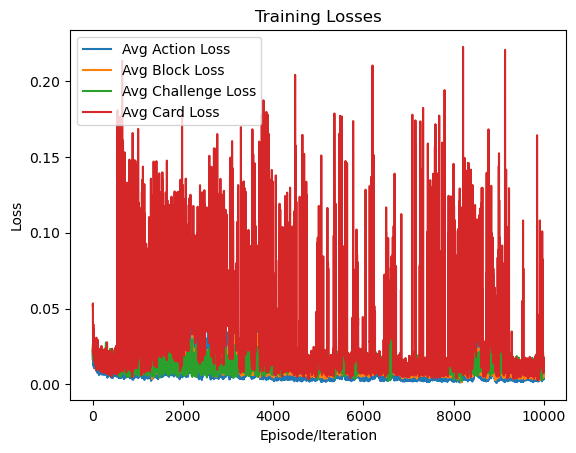

In [17]:
import matplotlib.pyplot as plt

plt.plot(avg_losses_action, label='Avg Action Loss')
plt.plot(avg_losses_block, label='Avg Block Loss')
plt.plot(avg_losses_challenge, label='Avg Challenge Loss')
plt.plot(avg_losses_card, label='Avg Card Loss')

plt.xlabel('Episode/Iteration')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

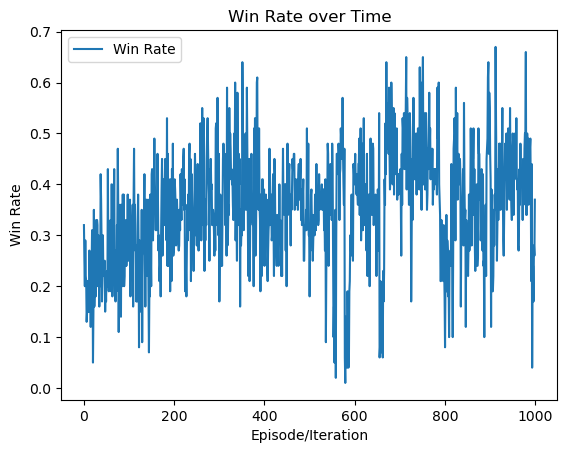

In [18]:
plt.plot(win_rates, label='Win Rate')

plt.xlabel('Episode/Iteration')
plt.ylabel('Win Rate')
plt.title('Win Rate over Time')
plt.legend()
plt.show()

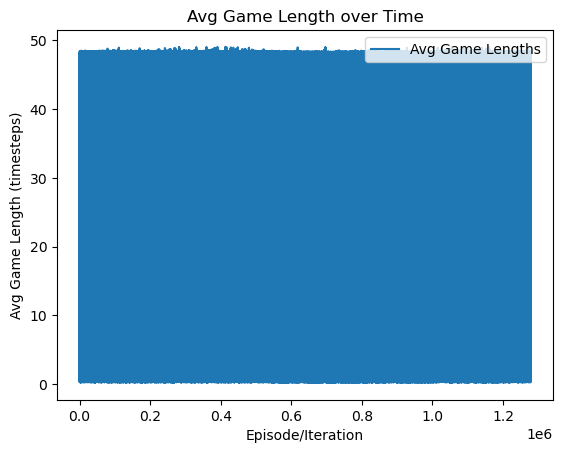

In [19]:
plt.plot(avg_game_lengths, label='Avg Game Lengths')

plt.xlabel('Episode/Iteration')
plt.ylabel('Avg Game Length (timesteps)')
plt.title('Avg Game Length over Time')
plt.legend()
plt.show()

In [20]:
torch.save({
        'action_q_state_dict': bot.action_q.state_dict(),
        'block_q_state_dict': bot.block_q.state_dict(),
        'challenge_q_state_dict': bot.challenge_q.state_dict(),
        'card_q_state_dict': bot.card_q.state_dict(),
        'optimizer_action_state_dict': bot.optimizer_action.state_dict(),
        'optimizer_block_state_dict': bot.optimizer_block.state_dict(),
        'optimizer_challenge_state_dict': bot.optimizer_challenge.state_dict(),
        'optimizer_card_state_dict': bot.optimizer_card.state_dict()
    }, 'bot_parameters.pth')

In [21]:
checkpoint = torch.load('bot_parameters.pth')
bot.action_q.load_state_dict(checkpoint['action_q_state_dict'])
bot.block_q.load_state_dict(checkpoint['block_q_state_dict'])
bot.challenge_q.load_state_dict(checkpoint['challenge_q_state_dict'])
bot.card_q.load_state_dict(checkpoint['card_q_state_dict'])
bot.optimizer_action.load_state_dict(checkpoint['optimizer_action_state_dict'])
bot.optimizer_block.load_state_dict(checkpoint['optimizer_block_state_dict'])
bot.optimizer_challenge.load_state_dict(checkpoint['optimizer_challenge_state_dict'])
bot.optimizer_card.load_state_dict(checkpoint['optimizer_card_state_dict'])

In [22]:
bots[0].action_q.load_state_dict(bot.action_q.state_dict())

# Copy parameters of block_q network
bots[0].block_q.load_state_dict(bot.block_q.state_dict())

# Copy parameters of challenge_q network
bots[0].challenge_q.load_state_dict(bot.challenge_q.state_dict())

# Copy parameters of card_q network
bots[0].card_q.load_state_dict(bot.card_q.state_dict())


win_rate = 0

for i in range(100):

  # print(i)
  discard_pile, acting_player, reacting_player, current_player, action_game, reaction_game, challenge_game, card_game, coin_game, challenge_direction, done_0, reward, card_chosen, bots_copy = game_loop_random(bots, actions, influences_reverse, 0.0)
  bots = bots_copy
  if reward[-1] == 1:
    win_rate += 1

# win_rate = win_rate / 50
print(f'Bot 0 Win Rate, Random Actions: {win_rate / 100}')


/var/folders/dx/zdhgw_j12hv1vs2r2s94qphr0000gn/T/ipykernel_78650/1205259918.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x[-1][9:12] = torch.tensor(embedding_actions(torch.tensor(action)))


Bot 0 Win Rate, Random Actions: 0.37
